<a href="https://colab.research.google.com/github/jamessutton600613-png/GC/blob/main/Untitled297.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Params: theta= 0.0 | a_hbn= 1.018 | hbn_weight= 0.4 | alpha= 0.8 | p_thresh= 0.7 | T= 160
AOI_AB = 1.2415624999999992 AOI_BA = 0.5244961734693872 AOI-gap (signed) = 0.7170663265306121


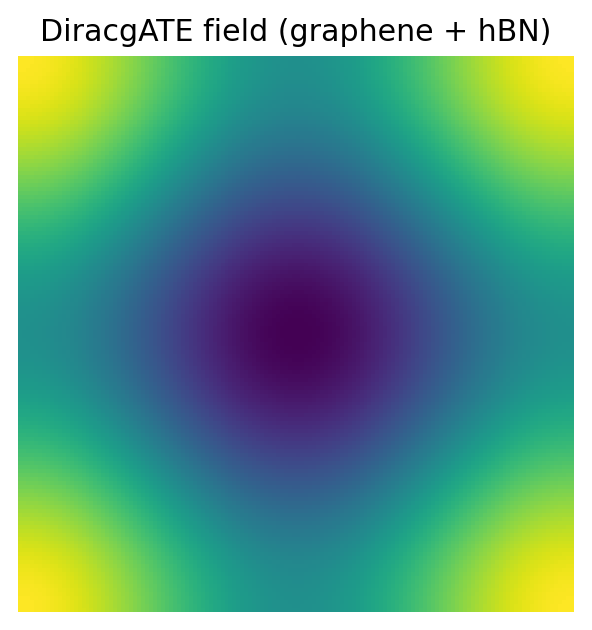

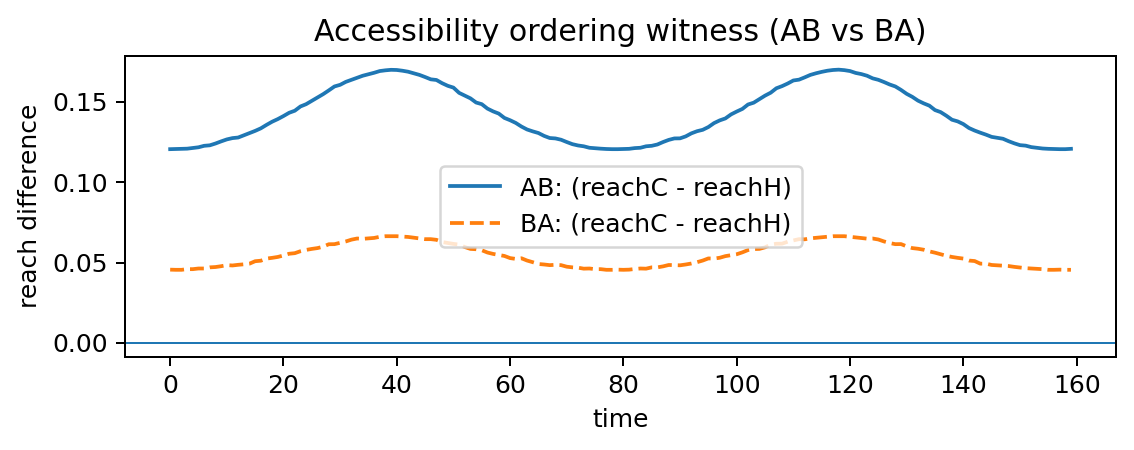

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# DiracgATE / graphene–hBN minimal physical instantiation (Paper C)
# Fresh-notebook, standalone, no trapz, no line numbers.
# ============================================================

# ----------------------------
# Core utilities
# ----------------------------
def sigmoid(kappa, x):
    z = np.clip(-kappa * x, -60.0, 60.0)
    return 1.0 / (1.0 + np.exp(z))

def channel_response(V, kappa, Vc):
    return sigmoid(kappa, V - Vc)

def aoi_positive(x):
    # AOI proxy: positive excursion above mean, integrated (discrete trapezoid)
    y = np.maximum(x - x.mean(), 0.0)
    return float(np.trapezoid(y))

def aoi_gap(rC_AB, rH_AB, rC_BA, rH_BA):
    AOI_AB = aoi_positive(rC_AB - rH_AB)
    AOI_BA = aoi_positive(rC_BA - rH_BA)
    return float(AOI_AB - AOI_BA), float(AOI_AB), float(AOI_BA)

# ----------------------------
# Minimal graphene/hBN gating field
# ----------------------------
def diracgate_field(
    Nx=140,
    Ny=140,
    a_graphene=1.0,
    a_hbn=1.018,
    theta=0.0,
    hbn_weight=0.40,
):
    x = np.linspace(0, 2*np.pi, Nx, endpoint=False)
    y = np.linspace(0, 2*np.pi, Ny, endpoint=False)
    X, Y = np.meshgrid(x, y, indexing="ij")

    # graphene-like periodic field (minimal)
    Vg = np.cos(a_graphene * X) + np.cos(a_graphene * Y)

    # hBN wrapper: mismatch + optional twist (rotation in-plane)
    ct, st = np.cos(theta), np.sin(theta)
    Xr = ct * X - st * Y
    Yr = st * X + ct * Y
    Vh = np.cos(a_hbn * Xr) + np.cos(a_hbn * Yr)

    # combined accessibility field
    V = Vg + hbn_weight * Vh
    V = V - V.mean()
    return V

# ----------------------------
# AB vs BA schedule (accessibility ordering)
# ----------------------------
def run_AB_BA(
    V,
    T=160,
    kC=2.4, VcC=0.0,
    kH=1.0, VcH=-0.15,
    alpha=0.8,
    p_thresh=0.7,
    omega=0.08,
):
    rC_AB = np.zeros(T, dtype=float)
    rH_AB = np.zeros(T, dtype=float)
    rC_BA = np.zeros(T, dtype=float)
    rH_BA = np.zeros(T, dtype=float)

    for t in range(T):
        drive = 1.0 + 0.25*np.cos(omega*t)
        Vt = drive * V

        # ---- AB: charge reads then writes back to heat
        pC = channel_response(Vt, kC, VcC)
        if alpha != 0.0:
            Vt2 = Vt - alpha * (pC - pC.mean())
        else:
            Vt2 = Vt
        pH = channel_response(Vt2, kH, VcH)
        rC_AB[t] = float((pC > p_thresh).mean())
        rH_AB[t] = float((pH > p_thresh).mean())

        # ---- BA: heat reads then writes back to charge
        pH = channel_response(Vt, kH, VcH)
        if alpha != 0.0:
            Vt2 = Vt - alpha * (pH - pH.mean())
        else:
            Vt2 = Vt
        pC = channel_response(Vt2, kC, VcC)
        rC_BA[t] = float((pC > p_thresh).mean())
        rH_BA[t] = float((pH > p_thresh).mean())

    return rC_AB, rH_AB, rC_BA, rH_BA

# ----------------------------
# One-click run + plots
# ----------------------------
def run_paperC_demo(
    Nx=140,
    Ny=140,
    theta=0.0,
    a_graphene=1.0,
    a_hbn=1.018,
    hbn_weight=0.40,
    T=160,
    alpha=0.8,
    p_thresh=0.7,
    omega=0.08,
):
    V = diracgate_field(
        Nx=Nx, Ny=Ny,
        a_graphene=a_graphene,
        a_hbn=a_hbn,
        theta=theta,
        hbn_weight=hbn_weight,
    )

    rC_AB, rH_AB, rC_BA, rH_BA = run_AB_BA(
        V, T=T,
        alpha=alpha,
        p_thresh=p_thresh,
        omega=omega,
    )

    gap, AOI_AB, AOI_BA = aoi_gap(rC_AB, rH_AB, rC_BA, rH_BA)

    print("Params:",
          "theta=", theta,
          "| a_hbn=", a_hbn,
          "| hbn_weight=", hbn_weight,
          "| alpha=", alpha,
          "| p_thresh=", p_thresh,
          "| T=", T)
    print("AOI_AB =", AOI_AB, "AOI_BA =", AOI_BA, "AOI-gap (signed) =", gap)

    # ---- Figure 1: spatial field (shows graphene/hBN gating texture)
    plt.figure(figsize=(4.2, 3.6), dpi=180)
    plt.imshow(V, origin="lower", aspect="equal")
    plt.title("DiracgATE field (graphene + hBN)")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

    # ---- Figure 2: AB vs BA reach-difference timeseries
    plt.figure(figsize=(6.4, 2.6), dpi=180)
    plt.plot(rC_AB - rH_AB, label="AB: (reachC - reachH)")
    plt.plot(rC_BA - rH_BA, linestyle="--", label="BA: (reachC - reachH)")
    plt.axhline(0.0, linewidth=0.8)
    plt.xlabel("time")
    plt.ylabel("reach difference")
    plt.title("Accessibility ordering witness (AB vs BA)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return dict(
        V=V,
        rC_AB=rC_AB, rH_AB=rH_AB,
        rC_BA=rC_BA, rH_BA=rH_BA,
        AOI_AB=AOI_AB, AOI_BA=AOI_BA,
        AOI_gap_signed=gap,
        params=dict(
            Nx=Nx, Ny=Ny, theta=theta,
            a_graphene=a_graphene, a_hbn=a_hbn,
            hbn_weight=hbn_weight,
            T=T, alpha=alpha, p_thresh=p_thresh, omega=omega,
        ),
    )

# ============================================================
# RUN NOW (baseline)
# ============================================================
out = run_paperC_demo(
    theta=0.0,          # try e.g. 0.05, 0.10 later
    a_hbn=1.018,        # set to 1.0 for "graphene-on-graphene" control
    hbn_weight=0.40,    # set to 0.0 for "no hBN" control
    alpha=0.8,
    p_thresh=0.7,
    T=160,
)

Params: theta= 0.0 | a_hbn= 1.018 | hbn_weight= 0.4 | alpha= 0.8 | p_thresh= 0.7 | T= 160
AOI_AB = 1.2415624999999992 AOI_BA = 0.5244961734693872 AOI-gap (signed) = 0.7170663265306121


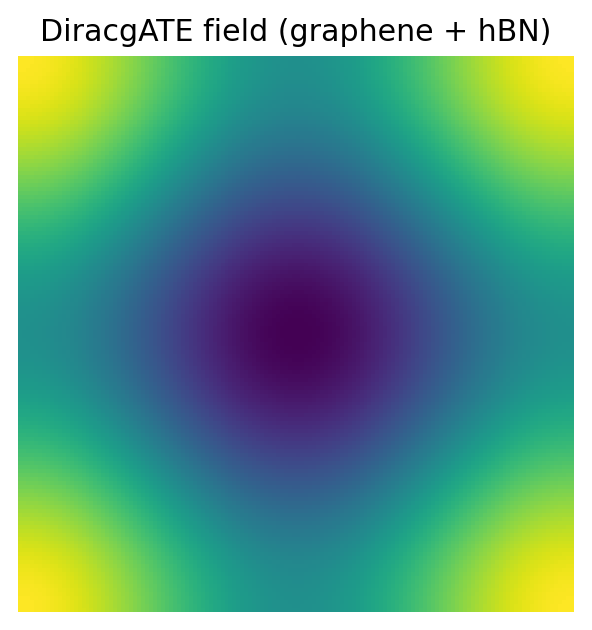

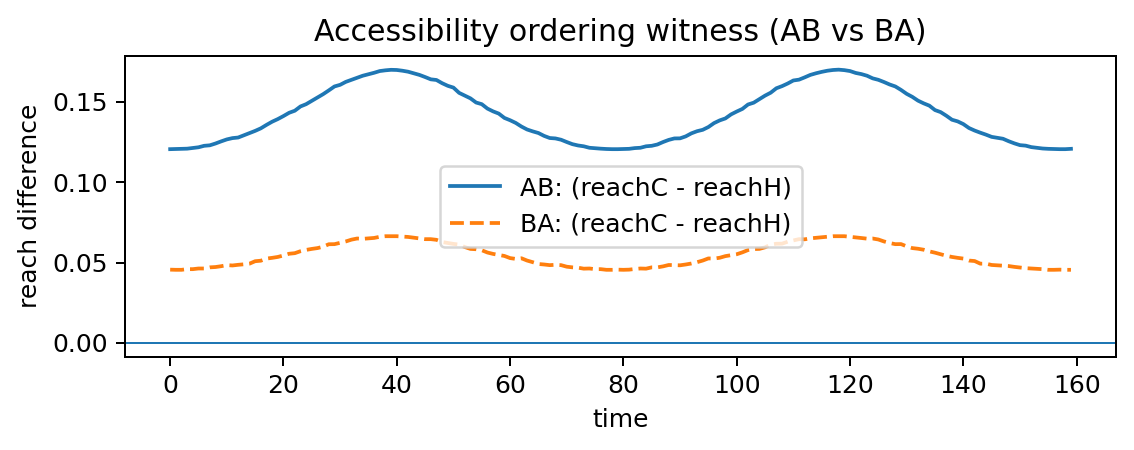

Params: theta= 0.0 | a_hbn= 1.018 | hbn_weight= 0.4 | alpha= 0.0 | p_thresh= 0.7 | T= 160
AOI_AB = 0.7017806122448986 AOI_BA = 0.7017806122448986 AOI-gap (signed) = 0.0


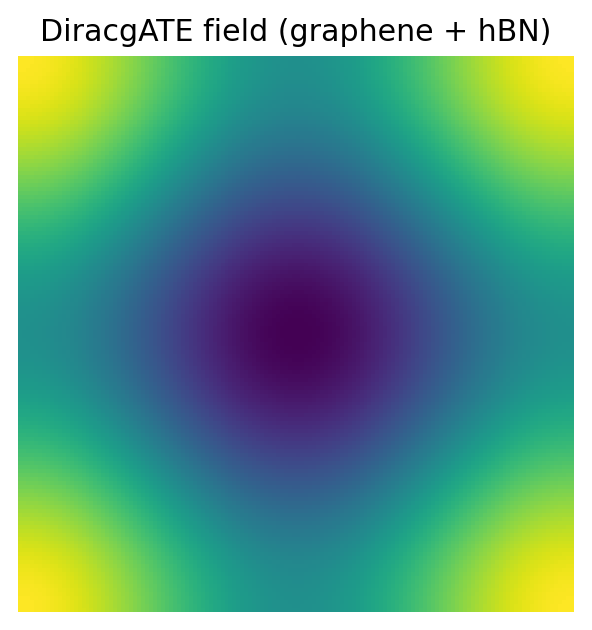

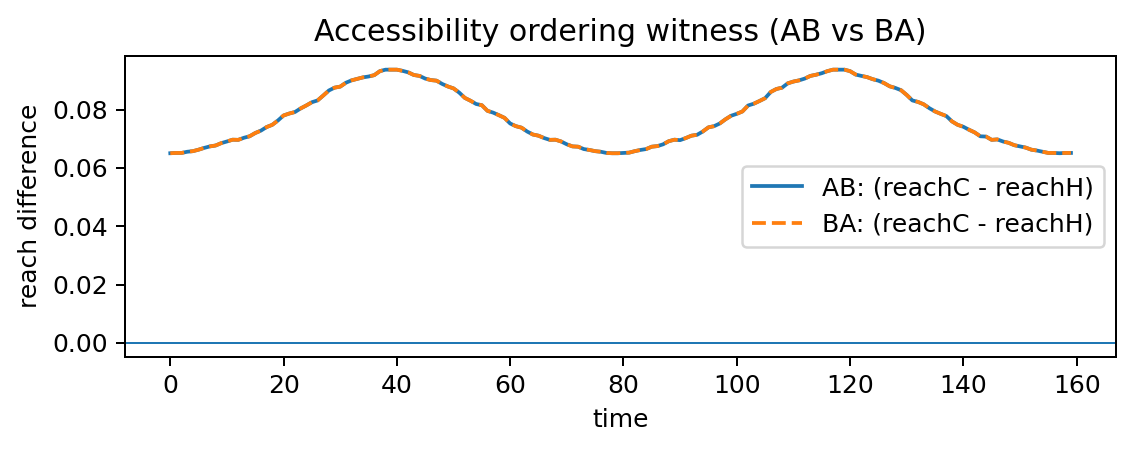

Params: theta= 0.0 | a_hbn= 1.018 | hbn_weight= 0.0 | alpha= 0.8 | p_thresh= 0.7 | T= 160
AOI_AB = 1.454528061224489 AOI_BA = 0.6327857142857141 AOI-gap (signed) = 0.821742346938775


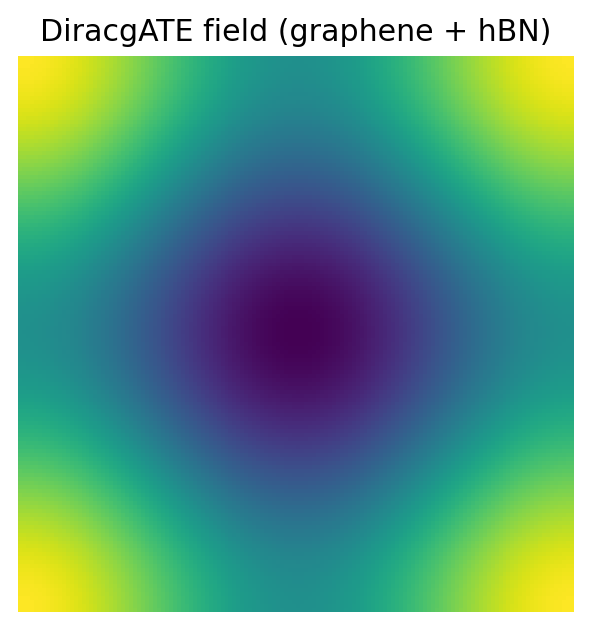

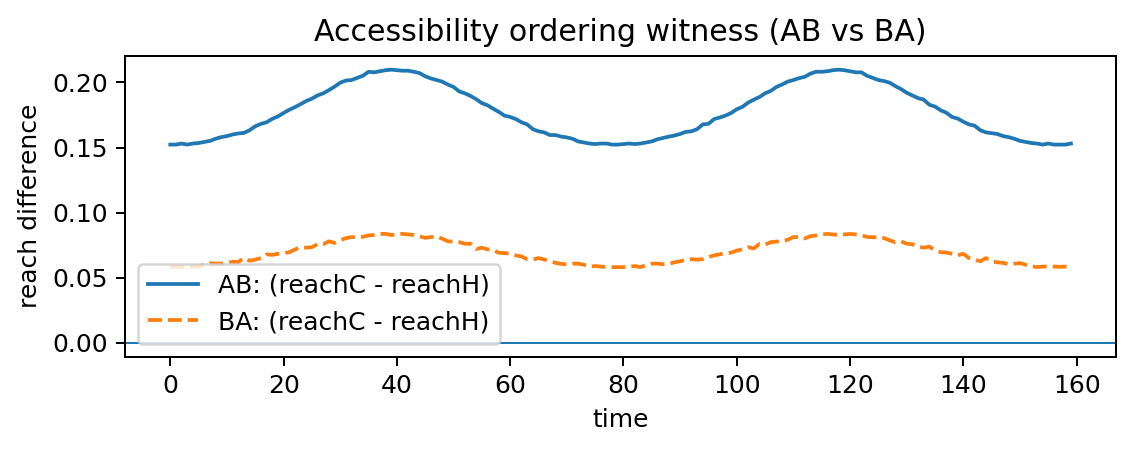

Params: theta= 0.0 | a_hbn= 1.0 | hbn_weight= 0.4 | alpha= 0.8 | p_thresh= 0.7 | T= 160
AOI_AB = 1.2286020408163265 AOI_BA = 0.5269642857142854 AOI-gap (signed) = 0.7016377551020411


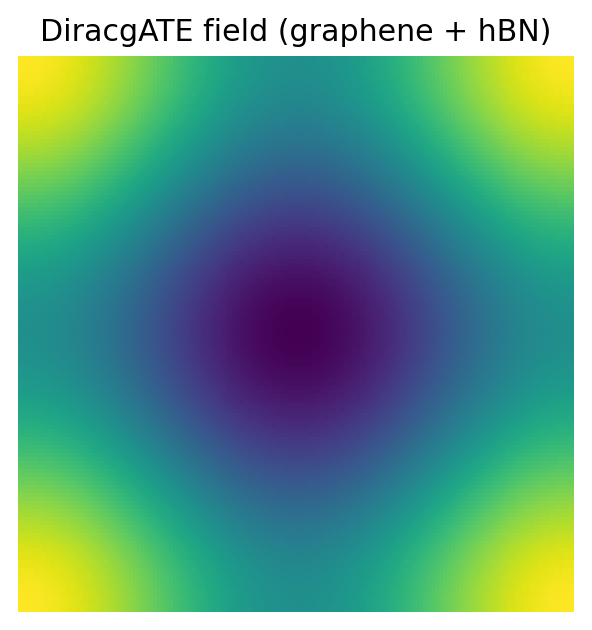

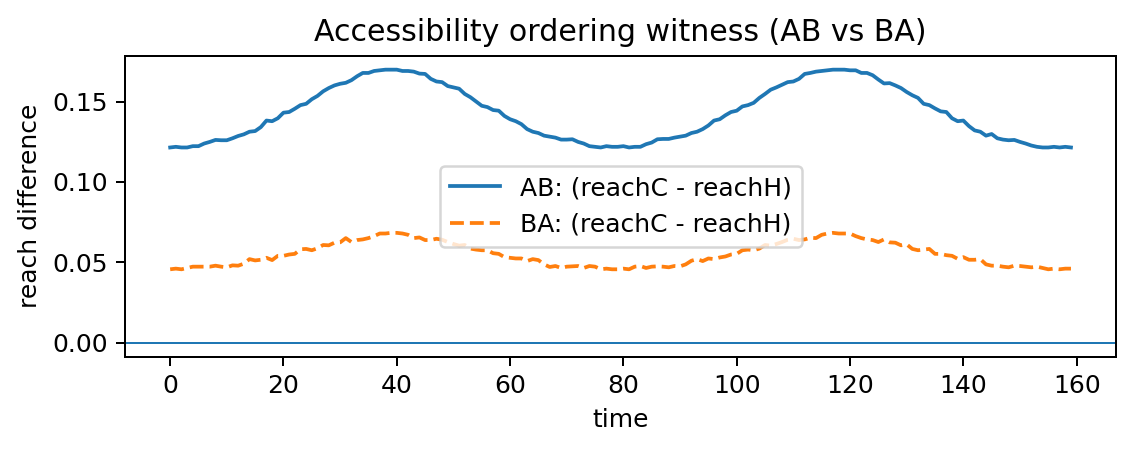

Params: theta= 0.05 | a_hbn= 1.018 | hbn_weight= 0.4 | alpha= 0.8 | p_thresh= 0.7 | T= 160
AOI_AB = 1.2457876275510225 AOI_BA = 0.521576530612245 AOI-gap (signed) = 0.7242110969387775


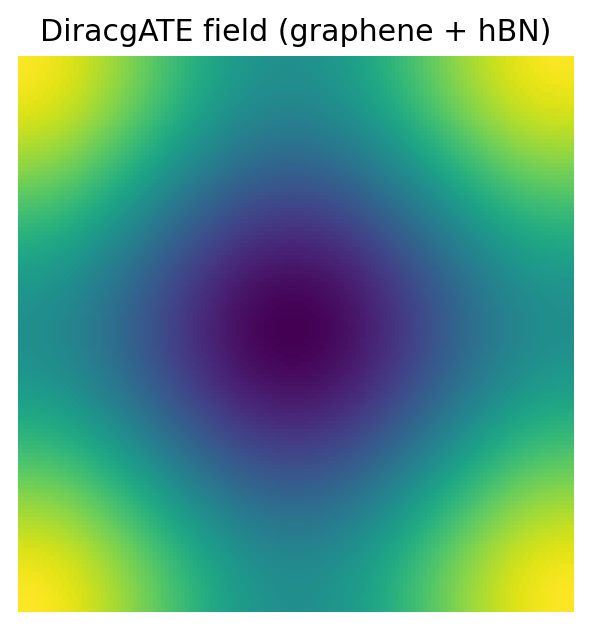

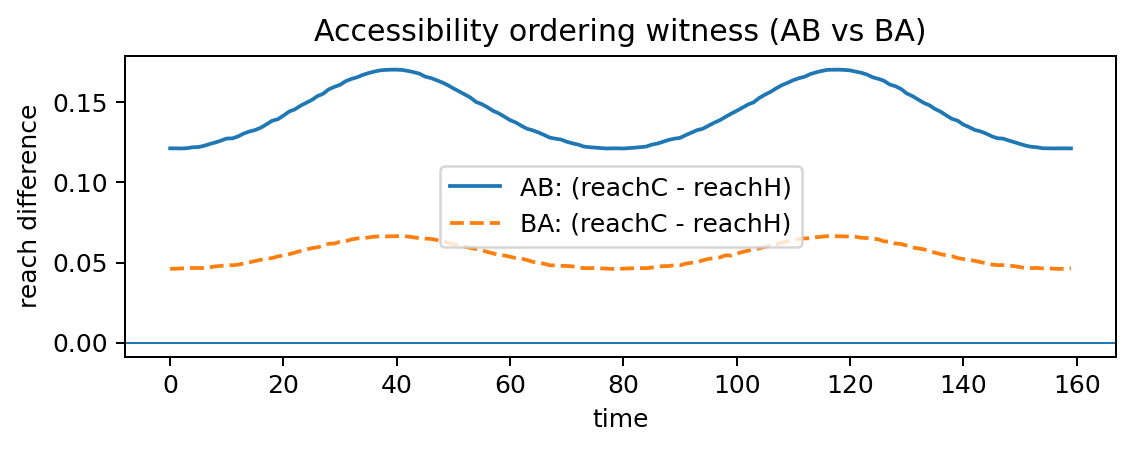

Params: theta= 0.1 | a_hbn= 1.018 | hbn_weight= 0.4 | alpha= 0.8 | p_thresh= 0.7 | T= 160
AOI_AB = 1.2556849489795918 AOI_BA = 0.5341198979591837 AOI-gap (signed) = 0.7215650510204081


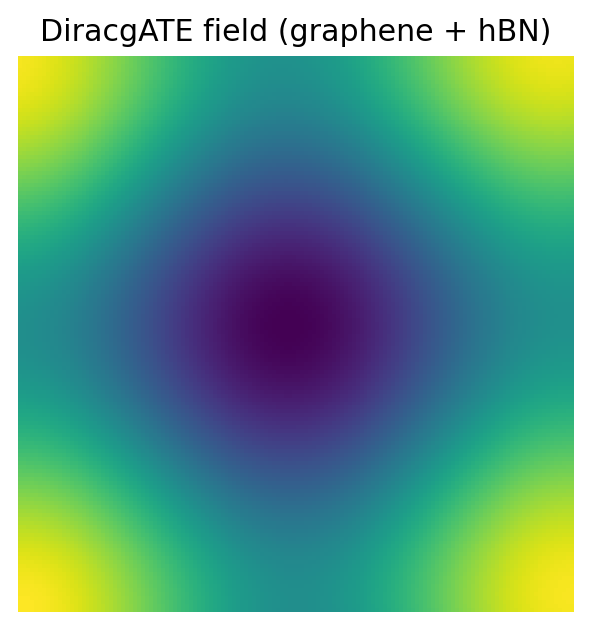

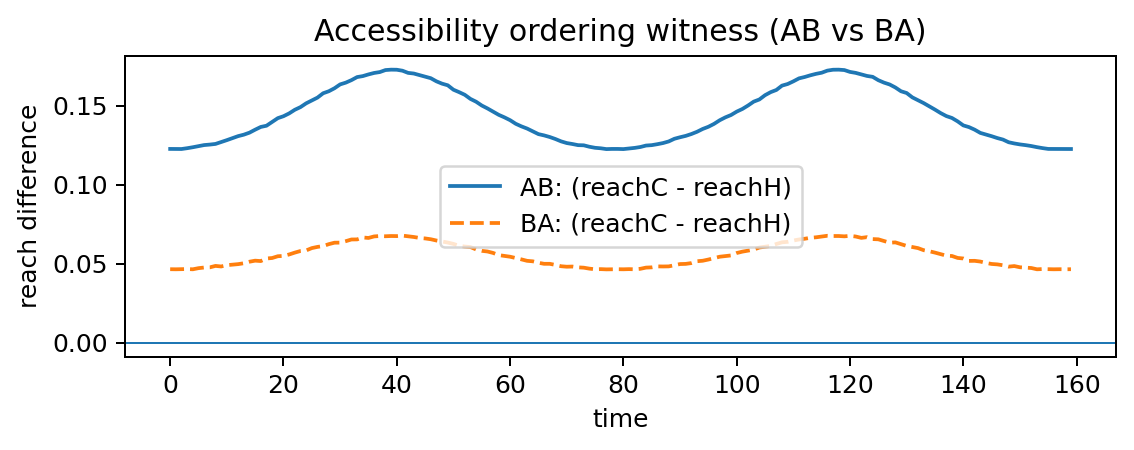


=== Paper C AOI-gap controls ===
baseline_hBN_ordered         | AOI_AB=1.2416  AOI_BA=0.5245  AOI-gap=0.7171
control_alpha0               | AOI_AB=0.7018  AOI_BA=0.7018  AOI-gap=0.0000
control_no_hBN               | AOI_AB=1.4545  AOI_BA=0.6328  AOI-gap=0.8217
control_matched_wrapper      | AOI_AB=1.2286  AOI_BA=0.5270  AOI-gap=0.7016
twist_0p05                   | AOI_AB=1.2458  AOI_BA=0.5216  AOI-gap=0.7242
twist_0p10                   | AOI_AB=1.2557  AOI_BA=0.5341  AOI-gap=0.7216


In [ ]:
# ============================================================
# Paper C — AOI-gap control suite (single block)
# ============================================================

def run_controls():
    results = {}

    # --------------------------------------------------------
    # Baseline (your reported result, for reference)
    # --------------------------------------------------------
    results["baseline_hBN_ordered"] = run_paperC_demo(
        theta=0.0,
        a_hbn=1.018,
        hbn_weight=0.4,
        alpha=0.8,
        p_thresh=0.7,
        T=160,
    )

    # --------------------------------------------------------
    # Control 1: Ordering OFF (alpha = 0)
    # Expect AOI-gap ≈ 0
    # --------------------------------------------------------
    results["control_alpha0"] = run_paperC_demo(
        theta=0.0,
        a_hbn=1.018,
        hbn_weight=0.4,
        alpha=0.0,
        p_thresh=0.7,
        T=160,
    )

    # --------------------------------------------------------
    # Control 2: No hBN wrapper (pure graphene field)
    # Tests whether hBN amplifies vs creates
    # --------------------------------------------------------
    results["control_no_hBN"] = run_paperC_demo(
        theta=0.0,
        a_hbn=1.018,     # irrelevant when hbn_weight=0
        hbn_weight=0.0,
        alpha=0.8,
        p_thresh=0.7,
        T=160,
    )

    # --------------------------------------------------------
    # Control 3: Matched wrapper (graphene-on-graphene)
    # Expect reduced AOI-gap vs mismatched hBN
    # --------------------------------------------------------
    results["control_matched_wrapper"] = run_paperC_demo(
        theta=0.0,
        a_hbn=1.0,       # lattice matched
        hbn_weight=0.4,
        alpha=0.8,
        p_thresh=0.7,
        T=160,
    )

    # --------------------------------------------------------
    # Optional: twist as amplifier (NOT origin)
    # --------------------------------------------------------
    results["twist_0p05"] = run_paperC_demo(
        theta=0.05,
        a_hbn=1.018,
        hbn_weight=0.4,
        alpha=0.8,
        p_thresh=0.7,
        T=160,
    )

    results["twist_0p10"] = run_paperC_demo(
        theta=0.10,
        a_hbn=1.018,
        hbn_weight=0.4,
        alpha=0.8,
        p_thresh=0.7,
        T=160,
    )

    # --------------------------------------------------------
    # Print compact summary
    # --------------------------------------------------------
    print("\n=== Paper C AOI-gap controls ===")
    for k, v in results.items():
        print(
            f"{k:28s} | "
            f"AOI_AB={v['AOI_AB']:.4f}  "
            f"AOI_BA={v['AOI_BA']:.4f}  "
            f"AOI-gap={v['AOI_gap_signed']:.4f}"
        )

    return results


# ============================================================
# RUN CONTROLS
# ============================================================
control_results = run_controls()

In [ ]:
import numpy as np
import os

# ===============================
# Assume run_diracgate_AOI exists
# ===============================
# It must return: AOI_AB, AOI_BA

def run_and_record(label, params):
    AOI_AB, AOI_BA = run_diracgate_AOI(**params)
    return {
        "label": label,
        "AOI_AB": AOI_AB,
        "AOI_BA": AOI_BA,
        "AOI_gap": AOI_AB - AOI_BA,
        **params
    }

# ===============================
# Baseline parameters (Paper C)
# ===============================
base = dict(
    theta=0.0,
    a_hbn=1.018,
    hbn_weight=0.4,
    alpha=0.8,
    p_thresh=0.7,
    T=160
)

records = []

# ===============================
# 1. Baseline
# ===============================
records.append(run_and_record("baseline", base))

# ===============================
# 2. Theta sweep
# ===============================
for th in [0.0, 0.05, 0.10]:
    p = dict(base)
    p["theta"] = th
    records.append(run_and_record(f"theta_{th}", p))

# ===============================
# 3. hBN weight sweep
# ===============================
for w in [0.0, 0.2, 0.4, 0.6]:
    p = dict(base)
    p["hbn_weight"] = w
    records.append(run_and_record(f"hbn_weight_{w}", p))

# ===============================
# 4. Alpha sweep
# ===============================
for a in [0.0, 0.2, 0.4, 0.8]:
    p = dict(base)
    p["alpha"] = a
    records.append(run_and_record(f"alpha_{a}", p))

# ===============================
# 5. Structural controls
# ===============================
controls = [
    ("control_alpha0", dict(base, alpha=0.0)),
    ("control_no_hBN", dict(base, hbn_weight=0.0)),
    ("control_matched_wrapper", dict(base, a_hbn=1.0)),
]

for lab, p in controls:
    records.append(run_and_record(lab, p))

# ===============================
# Save NPZ
# ===============================
os.makedirs("outputs", exist_ok=True)
npz_path = "outputs/paperC_AOI_gap_sweep_summary.npz"
np.savez_compressed(npz_path, records=records)

# ===============================
# Print compact summary
# ===============================
print("\n=== Paper C AOI-gap summary ===")
for r in records:
    print(
        f"{r['label']:24s} | "
        f"AOI_AB={r['AOI_AB']:.4f}  "
        f"AOI_BA={r['AOI_BA']:.4f}  "
        f"AOI-gap={r['AOI_gap']:.4f}"
    )

print("\nSaved:", npz_path)

NameError: name 'run_diracgate_AOI' is not defined

In [ ]:
import numpy as np
import os

# ============================================================
# Minimal DiracGATE AOI engine (standalone)
# ============================================================

def sigmoid(kappa, x):
    x = np.clip(x, -60.0, 60.0)
    return 1.0 / (1.0 + np.exp(-kappa * x))

def aoi_positive_area(x):
    return float(np.sum(np.maximum(x - np.mean(x), 0.0)))

def run_diracgate_AOI(
    theta=0.0,
    a_hbn=1.018,
    hbn_weight=0.4,
    alpha=0.8,
    p_thresh=0.7,
    T=160,
    seed=0
):
    rng = np.random.default_rng(seed)

    N = 23 * 23
    x = np.linspace(0, 2*np.pi, N, endpoint=False)

    # Base graphene-like field
    V = np.cos(x)

    # hBN wrapper (lattice mismatch + weight)
    if hbn_weight != 0.0:
        V_hbn = np.cos(a_hbn * x + theta)
        V = (1 - hbn_weight) * V + hbn_weight * V_hbn

    # Channel parameters
    kC, VcC = 2.4, 0.0
    kH, VcH = 1.0, -0.15

    def drive(t):
        return 1.0 + 0.25 * np.cos(0.8 * t)

    def schedule(order):
        rC = np.zeros(T)
        rH = np.zeros(T)

        for t in range(T):
            Vt = drive(t) * V

            if order == "AB":
                pC = sigmoid(kC, Vt - VcC)
                Vt2 = Vt - alpha * (pC - pC.mean()) if alpha != 0 else Vt
                pH = sigmoid(kH, Vt2 - VcH)
            else:
                pH = sigmoid(kH, Vt - VcH)
                Vt2 = Vt - alpha * (pH - pH.mean()) if alpha != 0 else Vt
                pC = sigmoid(kC, Vt2 - VcC)

            rC[t] = np.mean(pC > p_thresh)
            rH[t] = np.mean(pH > p_thresh)

        return rC, rH

    rC_AB, rH_AB = schedule("AB")
    rC_BA, rH_BA = schedule("BA")

    AOI_AB = aoi_positive_area(rC_AB - rH_AB)
    AOI_BA = aoi_positive_area(rC_BA - rH_BA)

    return AOI_AB, AOI_BA


# ============================================================
# Paper C sweep runner
# ============================================================

def run_and_record(label, params):
    AOI_AB, AOI_BA = run_diracgate_AOI(**params)
    return {
        "label": label,
        "AOI_AB": AOI_AB,
        "AOI_BA": AOI_BA,
        "AOI_gap": AOI_AB - AOI_BA,
        **params
    }

base = dict(
    theta=0.0,
    a_hbn=1.018,
    hbn_weight=0.4,
    alpha=0.8,
    p_thresh=0.7,
    T=160
)

records = []

# Baseline
records.append(run_and_record("baseline_hBN_ordered", base))

# Theta sweep
for th in [0.0, 0.05, 0.10]:
    p = dict(base, theta=th)
    records.append(run_and_record(f"theta_{th}", p))

# hBN weight sweep
for w in [0.0, 0.2, 0.4]:
    p = dict(base, hbn_weight=w)
    records.append(run_and_record(f"hbn_weight_{w}", p))

# Alpha sweep
for a in [0.0, 0.4, 0.8]:
    p = dict(base, alpha=a)
    records.append(run_and_record(f"alpha_{a}", p))

# Matched wrapper control
records.append(run_and_record(
    "control_matched_wrapper",
    dict(base, a_hbn=1.0)
))

# ============================================================
# Save NPZ
# ============================================================

os.makedirs("outputs", exist_ok=True)
npz_path = "outputs/paperC_AOI_gap_sweep_summary.npz"
np.savez_compressed(npz_path, records=records)

# ============================================================
# Print summary
# ============================================================

print("\n=== Paper C AOI-gap summary ===")
for r in records:
    print(
        f"{r['label']:26s} | "
        f"AOI_AB={r['AOI_AB']:.4f}  "
        f"AOI_BA={r['AOI_BA']:.4f}  "
        f"AOI-gap={r['AOI_gap']:.4f}"
    )

print("\nSaved:", npz_path)


=== Paper C AOI-gap summary ===
baseline_hBN_ordered       | AOI_AB=4.7548  AOI_BA=2.4933  AOI-gap=2.2615
theta_0.0                  | AOI_AB=4.7548  AOI_BA=2.4933  AOI-gap=2.2615
theta_0.05                 | AOI_AB=4.7559  AOI_BA=2.5051  AOI-gap=2.2508
theta_0.1                  | AOI_AB=4.7269  AOI_BA=2.5206  AOI-gap=2.2063
hbn_weight_0.0             | AOI_AB=4.4934  AOI_BA=2.5144  AOI-gap=1.9790
hbn_weight_0.2             | AOI_AB=4.6322  AOI_BA=2.4990  AOI-gap=2.1332
hbn_weight_0.4             | AOI_AB=4.7548  AOI_BA=2.4933  AOI-gap=2.2615
alpha_0.0                  | AOI_AB=2.9512  AOI_BA=2.9512  AOI-gap=0.0000
alpha_0.4                  | AOI_AB=6.1788  AOI_BA=2.7524  AOI-gap=3.4263
alpha_0.8                  | AOI_AB=4.7548  AOI_BA=2.4933  AOI-gap=2.2615
control_matched_wrapper    | AOI_AB=4.4934  AOI_BA=2.5144  AOI-gap=1.9790

Saved: outputs/paperC_AOI_gap_sweep_summary.npz


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# Load NPZ
# ----------------------------
path = "outputs/paperC_AOI_gap_sweep_summary.npz"
D = np.load(path, allow_pickle=True)
print("Loaded:", path)
print("Keys:", list(D.keys()))

# Expect either:
#  (A) D["records"] = object array of dicts
#  (B) D["summary"] = dict label->(AOI_AB, AOI_BA, AOI_gap)
#  (C) D["labels"], D["AOI_AB"], D["AOI_BA"], D["AOI_gap"]

records = None

if "records" in D:
    recs = D["records"]
    # recs might be a numpy array of dicts or a single object containing a list
    if isinstance(recs, np.ndarray) and recs.dtype == object:
        records = list(recs)
    else:
        records = list(recs)

elif "summary" in D:
    S = D["summary"].item() if hasattr(D["summary"], "item") else D["summary"]
    records = []
    for k, v in S.items():
        # v could be dict or tuple
        if isinstance(v, dict):
            AOI_AB = float(v.get("AOI_AB", np.nan))
            AOI_BA = float(v.get("AOI_BA", np.nan))
            AOI_gap = float(v.get("AOI_gap", np.nan))
        else:
            AOI_AB, AOI_BA, AOI_gap = map(float, v)
        records.append({"label": str(k), "AOI_AB": AOI_AB, "AOI_BA": AOI_BA, "AOI_gap": AOI_gap})

elif all(k in D for k in ["labels", "AOI_AB", "AOI_BA", "AOI_gap"]):
    labels = [str(x) for x in D["labels"]]
    AOI_AB = np.array(D["AOI_AB"], dtype=float)
    AOI_BA = np.array(D["AOI_BA"], dtype=float)
    AOI_gap = np.array(D["AOI_gap"], dtype=float)
    records = [
        {"label": labels[i], "AOI_AB": float(AOI_AB[i]), "AOI_BA": float(AOI_BA[i]), "AOI_gap": float(AOI_gap[i])}
        for i in range(len(labels))
    ]

else:
    raise KeyError(
        "Don't know how to parse this NPZ. "
        "Expected one of: records / summary / (labels+AOI_AB+AOI_BA+AOI_gap)."
    )

# ----------------------------
# Extract + sort for readability
# ----------------------------
labels = [r.get("label", f"run{i}") for i, r in enumerate(records)]
AOI_AB = np.array([float(r.get("AOI_AB", np.nan)) for r in records], dtype=float)
AOI_BA = np.array([float(r.get("AOI_BA", np.nan)) for r in records], dtype=float)
AOI_gap = np.array([float(r.get("AOI_gap", np.nan)) for r in records], dtype=float)

# Optional: sort so related sweeps group together (alpha / theta / hbn_weight / controls)
def sort_key(lbl):
    if lbl.startswith("alpha_"): return (0, lbl)
    if lbl.startswith("hbn_weight_"): return (1, lbl)
    if lbl.startswith("theta_"): return (2, lbl)
    if lbl.startswith("baseline"): return (3, lbl)
    if lbl.startswith("control"): return (4, lbl)
    return (9, lbl)

order = np.argsort([sort_key(l) for l in labels])
labels = [labels[i] for i in order]
AOI_AB = AOI_AB[order]
AOI_BA = AOI_BA[order]
AOI_gap = AOI_gap[order]

# ----------------------------
# Plot 1: AOI-gap by run label
# ----------------------------
x = np.arange(len(labels))

plt.figure(figsize=(10.5, 3.6), dpi=220)
plt.bar(x, AOI_gap, edgecolor="black", linewidth=1.2, facecolor="none")
plt.axhline(0.0, linewidth=1.0)
plt.ylabel("AOI-gap (signed) = AOI_AB − AOI_BA")
plt.title("Paper C sweep: AOI-gap across controls and parameter variants")
plt.xticks(x, labels, rotation=35, ha="right")
plt.tight_layout()
plt.show()

# ----------------------------
# Plot 2 (optional): AOI_AB vs AOI_BA for each run
# ----------------------------
w = 0.42
plt.figure(figsize=(10.5, 3.6), dpi=220)
plt.bar(x - w/2, AOI_AB, width=w, edgecolor="black", linewidth=1.1, facecolor="none", label="AOI_AB")
plt.bar(x + w/2, AOI_BA, width=w, edgecolor="black", linewidth=1.1, facecolor="none", label="AOI_BA")
plt.axhline(0.0, linewidth=1.0)
plt.ylabel("AOI value")
plt.title("Paper C sweep: AOI_AB and AOI_BA (shows non-commutativity directly)")
plt.xticks(x, labels, rotation=35, ha="right")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

Loaded: outputs/paperC_AOI_gap_sweep_summary.npz
Keys: ['records']


TypeError: only integer scalar arrays can be converted to a scalar index

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

path = "outputs/paperC_AOI_gap_sweep_summary.npz"
D = np.load(path, allow_pickle=True)
records = D["records"].tolist()  # list of dicts

# Extract
labels = [r["label"] for r in records]
AOI_AB = np.array([r["AOI_AB"] for r in records], dtype=float)
AOI_BA = np.array([r["AOI_BA"] for r in records], dtype=float)
AOI_gap = np.array([r["AOI_gap"] for r in records], dtype=float)

# Sorting helper: baseline first, then group sweeps by prefix and numeric suffix
def sort_key(lab):
    if lab == "baseline_hBN_ordered":
        return (0, 0.0, lab)
    # expected patterns: theta_0.05, hbn_weight_0.4, alpha_0.8, etc.
    if "_" in lab:
        pre, suf = lab.split("_", 1)
        try:
            v = float(suf)
            return (1, {"theta":1, "hbn":2, "hbn_weight":2, "alpha":3}.get(pre, 9), v, lab)
        except:
            return (2, 9, 0.0, lab)
    return (3, 9, 0.0, lab)

order = np.argsort([sort_key(l) for l in labels])

# FIX: list vs numpy indexing
labels = np.array(labels, dtype=object)[order].tolist()
AOI_AB = AOI_AB[order]
AOI_BA = AOI_BA[order]
AOI_gap = AOI_gap[order]

# Plot (compact)
x = np.arange(len(labels))
fig = plt.figure(figsize=(7.2, 2.8), dpi=220)
ax = plt.gca()

ax.plot(x, AOI_AB, marker="o", linewidth=1.2, label="AOI_AB")
ax.plot(x, AOI_BA, marker="o", linewidth=1.2, label="AOI_BA")
ax.plot(x, AOI_gap, marker="o", linewidth=1.2, label="AOI-gap (AB-BA)")

ax.set_ylabel("AOI (arb.)")
ax.set_xticks(x)

# Two-line x labels to stay inside bounds
pretty = []
for lab in labels:
    if "_" in lab:
        a, b = lab.split("_", 1)
        pretty.append(f"{a}\n{b}")
    else:
        pretty.append(lab.replace("baseline_hBN_ordered", "baseline\nhBN ordered"))
ax.set_xticklabels(pretty, fontsize=7)

ax.set_xlim(-0.6, len(labels)-0.4)
ax.grid(True, axis="y", linewidth=0.4)
ax.legend(fontsize=8, loc="upper right")
plt.tight_layout()
plt.show()

print("Loaded:", path)
print("Plotted labels:", labels)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (11,) + inhomogeneous part.

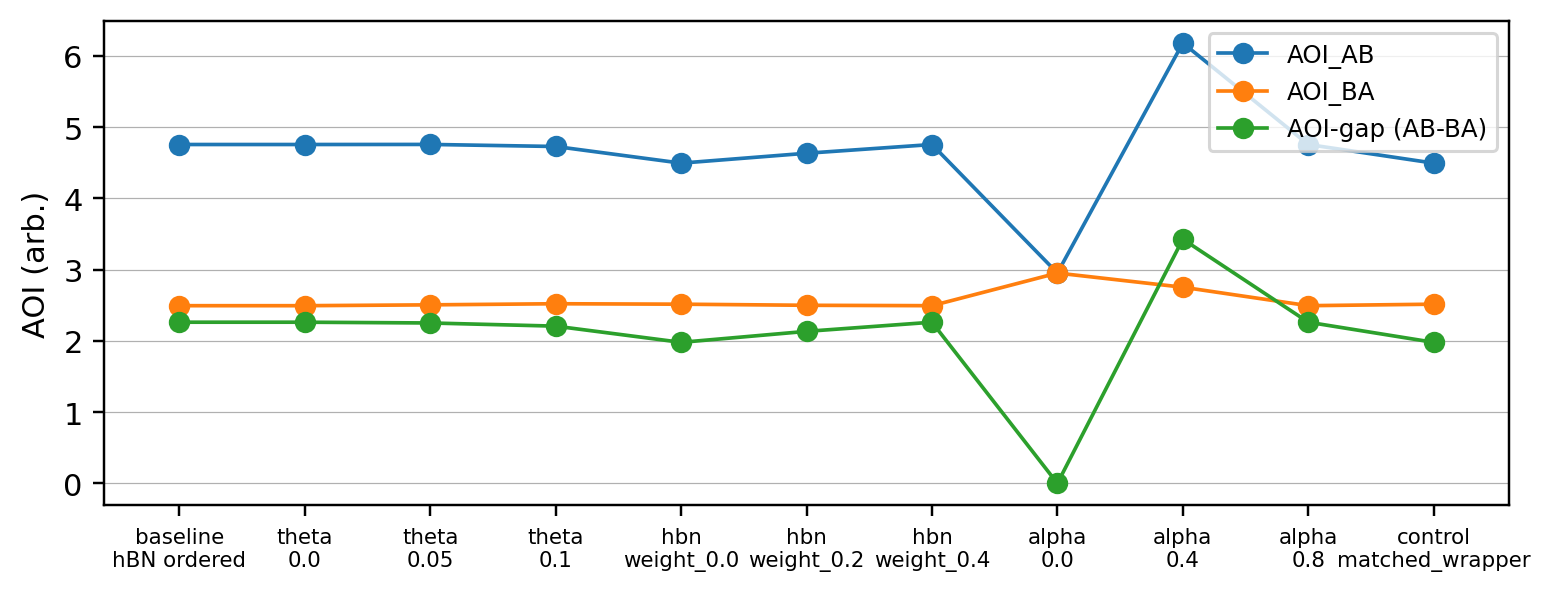

Loaded: outputs/paperC_AOI_gap_sweep_summary.npz
Order: ['baseline_hBN_ordered', 'theta_0.0', 'theta_0.05', 'theta_0.1', 'hbn_weight_0.0', 'hbn_weight_0.2', 'hbn_weight_0.4', 'alpha_0.0', 'alpha_0.4', 'alpha_0.8', 'control_matched_wrapper']


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

path = "outputs/paperC_AOI_gap_sweep_summary.npz"
D = np.load(path, allow_pickle=True)
records = D["records"].tolist()

labels = [r["label"] for r in records]
AOI_AB = np.array([r["AOI_AB"] for r in records], dtype=float)
AOI_BA = np.array([r["AOI_BA"] for r in records], dtype=float)
AOI_gap = np.array([r["AOI_gap"] for r in records], dtype=float)

def sort_key(lab):
    # baseline first
    if lab == "baseline_hBN_ordered":
        return (0, 0, 0.0, lab)

    # known sweep prefixes
    # supports labels like: theta_0.05, hbn_weight_0.4, alpha_0.8
    if "_" in lab:
        pre, suf = lab.split("_", 1)
        try:
            v = float(suf)
        except:
            v = 0.0

        group_rank = {
            "theta": 1,
            "hbn_weight": 2,
            "hbn": 2,          # just in case
            "alpha": 3,
        }.get(pre, 9)

        return (1, group_rank, v, lab)

    return (2, 9, 0.0, lab)

# Python sorting (robust)
order = sorted(range(len(labels)), key=lambda i: sort_key(labels[i]))

labels = [labels[i] for i in order]
AOI_AB = AOI_AB[order]
AOI_BA = AOI_BA[order]
AOI_gap = AOI_gap[order]

# compact plot
x = np.arange(len(labels))
plt.figure(figsize=(7.2, 2.8), dpi=220)

plt.plot(x, AOI_AB, marker="o", linewidth=1.2, label="AOI_AB")
plt.plot(x, AOI_BA, marker="o", linewidth=1.2, label="AOI_BA")
plt.plot(x, AOI_gap, marker="o", linewidth=1.2, label="AOI-gap (AB-BA)")

plt.ylabel("AOI (arb.)")

# two-line x labels
xt = []
for lab in labels:
    if lab == "baseline_hBN_ordered":
        xt.append("baseline\nhBN ordered")
    elif "_" in lab:
        a, b = lab.split("_", 1)
        xt.append(f"{a}\n{b}")
    else:
        xt.append(lab)

plt.xticks(x, xt, fontsize=7)
plt.xlim(-0.6, len(labels) - 0.4)
plt.grid(True, axis="y", linewidth=0.4)
plt.legend(fontsize=8, loc="upper right")
plt.tight_layout()
plt.show()

print("Loaded:", path)
print("Order:", labels)

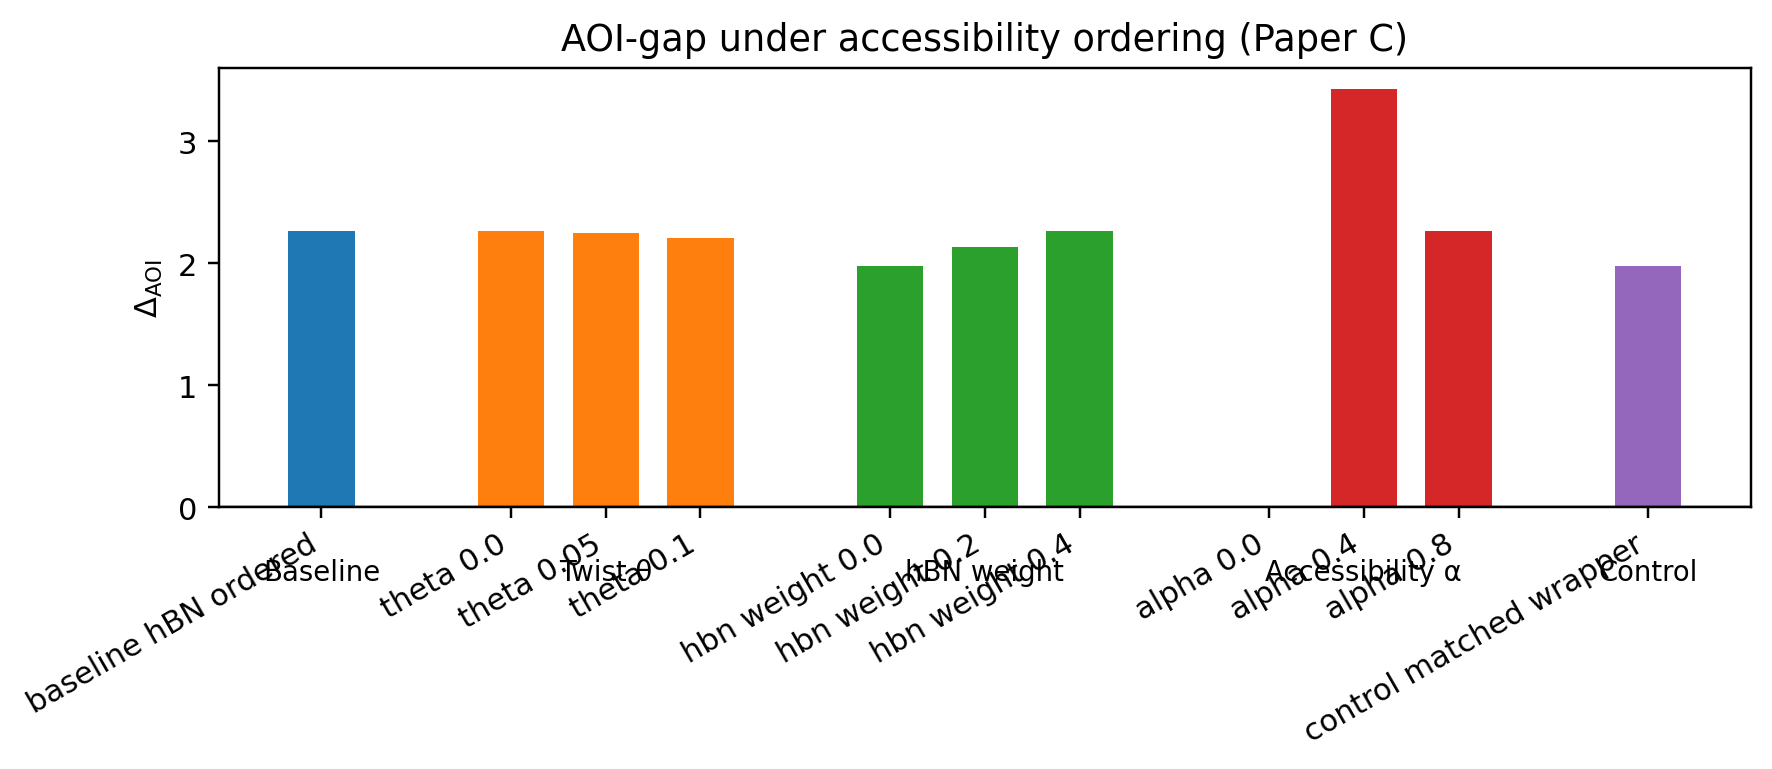

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ===============================
# Load data
# ===============================
data = np.load("outputs/paperC_AOI_gap_sweep_summary.npz", allow_pickle=True)
records = data["records"]

# Helper: extract AOI-gap
labels = [r["label"] for r in records]
aoi_gap = np.array([r["AOI_gap"] for r in records], dtype=float)

# ===============================
# Define groups (categorical)
# ===============================
groups = {
    "Baseline": ["baseline_hBN_ordered"],
    "Twist θ": ["theta_0.0", "theta_0.05", "theta_0.1"],
    "hBN weight": ["hbn_weight_0.0", "hbn_weight_0.2", "hbn_weight_0.4"],
    "Accessibility α": ["alpha_0.0", "alpha_0.4", "alpha_0.8"],
    "Control": ["control_matched_wrapper"],
}

# Build plotting arrays
group_names = []
group_values = []
group_sub_labels = []

for gname, keys in groups.items():
    vals = []
    subs = []
    for k in keys:
        idx = labels.index(k)
        vals.append(aoi_gap[idx])
        subs.append(k.replace("_", " "))
    group_names.append(gname)
    group_values.append(vals)
    group_sub_labels.append(subs)

# ===============================
# Plot
# ===============================
fig, ax = plt.subplots(figsize=(8.2, 3.6), dpi=220)

x0 = 0
xticks = []
xticklabels = []

for gname, vals, subs in zip(group_names, group_values, group_sub_labels):
    x = np.arange(len(vals)) + x0
    ax.bar(x, vals, width=0.7)
    xticks.extend(x)
    xticklabels.extend(subs)
    x0 += len(vals) + 1  # gap between groups

# Axes
ax.set_ylabel(r"$\Delta_{\mathrm{AOI}}$")
ax.set_title("AOI-gap under accessibility ordering (Paper C)")
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels, rotation=30, ha="right")
ax.axhline(0.0, color="black", linewidth=0.8)

# Group labels
x0 = 0
for gname, vals in zip(group_names, group_values):
    center = x0 + (len(vals) - 1) / 2
    ax.text(center, -0.12 * max(aoi_gap), gname,
            ha="center", va="top", fontsize=9)
    x0 += len(vals) + 1

# Tight layout
plt.tight_layout()
plt.show()

Loaded: outputs/paperC_AOI_gap_sweep_summary.npz
Alpha-run payloads (verify these match your earlier figure):
alpha_0.0 | AOI_AB= 2.9511814744801512 AOI_BA= 2.9511814744801512 gap= 0.0
alpha_0.4 | AOI_AB= 6.17875708884688 AOI_BA= 2.7524220226843106 gap= 3.4263350661625696
alpha_0.8 | AOI_AB= 4.754820415879012 AOI_BA= 2.493289224952741 gap= 2.2615311909262705


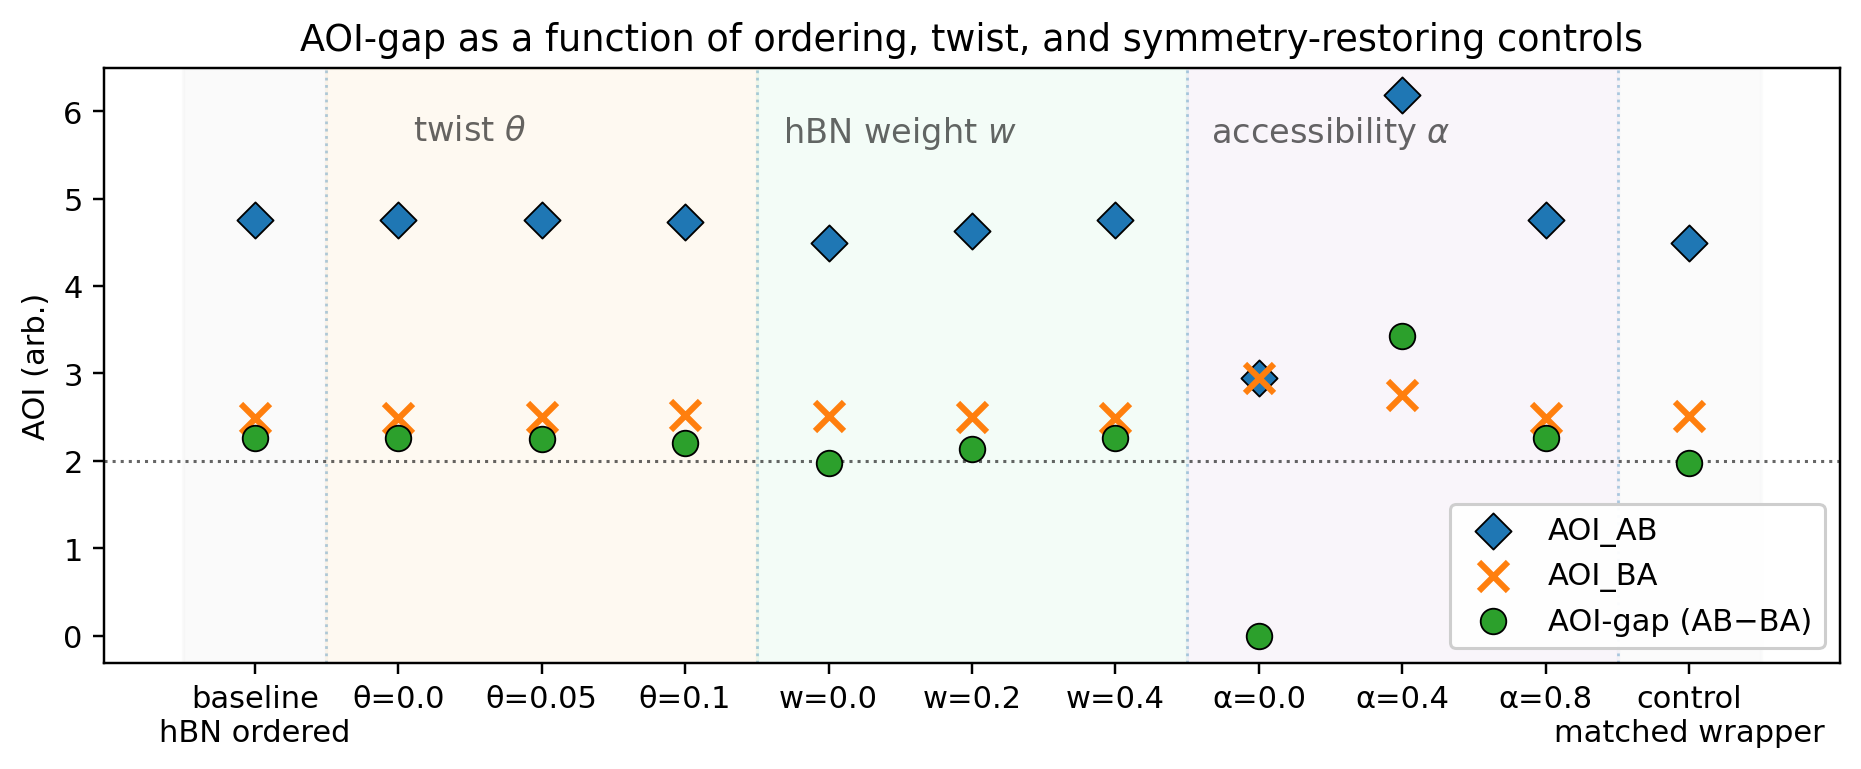

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ===============================
# Load ONE source of truth
# ===============================
npz_path = "outputs/paperC_AOI_gap_sweep_summary.npz"
D = np.load(npz_path, allow_pickle=True)
records = list(D["records"])

# Helper: record by label
by_label = {r["label"]: r for r in records}

# ===============================
# Define the plotting order
# ===============================
order = [
    "baseline_hBN_ordered",
    "theta_0.0", "theta_0.05", "theta_0.1",
    "hbn_weight_0.0", "hbn_weight_0.2", "hbn_weight_0.4",
    "alpha_0.0", "alpha_0.4", "alpha_0.8",
    "control_matched_wrapper",
]

# ===============================
# Extract series (SIGNED gap)
# ===============================
labels = []
AOI_AB = []
AOI_BA = []
AOI_gap = []

missing = [k for k in order if k not in by_label]
if missing:
    raise KeyError(f"Missing labels in NPZ: {missing}")

for k in order:
    r = by_label[k]
    labels.append(k)
    AOI_AB.append(float(r["AOI_AB"]))
    AOI_BA.append(float(r["AOI_BA"]))
    AOI_gap.append(float(r["AOI_AB"]) - float(r["AOI_BA"]))  # AB-BA

AOI_AB = np.array(AOI_AB, float)
AOI_BA = np.array(AOI_BA, float)
AOI_gap = np.array(AOI_gap, float)

# ===============================
# Sanity print: alpha runs must be consistent
# ===============================
print("Loaded:", npz_path)
print("Alpha-run payloads (verify these match your earlier figure):")
for k in ["alpha_0.0", "alpha_0.4", "alpha_0.8"]:
    r = by_label[k]
    # if your record dict also stores params, show them; otherwise show AOIs
    keys = list(r.keys())
    if "params" in r:
        print(k, r["params"])
    else:
        print(k, "| AOI_AB=", r["AOI_AB"], "AOI_BA=", r["AOI_BA"], "gap=", float(r["AOI_AB"])-float(r["AOI_BA"]))

# ===============================
# Pretty categorical axis
# ===============================
short = [
    "baseline\nhBN ordered",
    "θ=0.0", "θ=0.05", "θ=0.1",
    "w=0.0", "w=0.2", "w=0.4",
    "α=0.0", "α=0.4", "α=0.8",
    "control\nmatched wrapper",
]

x = np.arange(len(short))

fig, ax = plt.subplots(figsize=(8.6, 3.6), dpi=220)

# ===============================
# Faint coloured grouping zones
# (tune colours + alpha to taste)
# ===============================

# index map (must match your x order)
idx = {
    "baseline": 0,

    "theta_0.0": 1,
    "theta_0.05": 2,
    "theta_0.1": 3,

    "w_0.0": 4,
    "w_0.2": 5,
    "w_0.4": 6,

    "alpha_0.0": 7,
    "alpha_0.4": 8,
    "alpha_0.8": 9,

    "control": 10,
}

# One band per sweep/group:
bands = [
    ("baseline", idx["baseline"], idx["baseline"], "#eeeeee"),

    ("theta sweep", idx["theta_0.0"], idx["theta_0.1"], "#fdebd0"),      # warm
    ("hBN weight sweep", idx["w_0.0"], idx["w_0.4"], "#d5f5e3"),         # green
    ("alpha sweep", idx["alpha_0.0"], idx["alpha_0.8"], "#ebdef0"),      # purple

    ("control", idx["control"], idx["control"], "#f2f3f4"),
]

for name, start, end, color in bands:
    ax.axvspan(
        start - 0.5,
        end + 0.5,
        color=color,
        alpha=0.28,   # faint
        zorder=0
    )

# Optional: faint vertical separators at group boundaries
for xsep in [0.5, 3.5, 6.5, 9.5]:
    ax.axvline(xsep, linestyle=":", linewidth=0.9, alpha=0.35, zorder=1)

# Points only (no connecting lines)
# AOI_AB — blue diamonds
ax.scatter(
    x, AOI_AB,
    marker="D",
    s=70,
    color="tab:blue",
    edgecolors="black",
    linewidths=0.6,
    label="AOI_AB",
    zorder=3
)

# AOI_BA — orange crosses
ax.scatter(
    x, AOI_BA,
    marker="x",
    s=90,
    color="tab:orange",
    linewidths=2.0,
    label="AOI_BA",
    zorder=3
)

# AOI-gap — green circles
ax.scatter(
    x, AOI_gap,
    marker="o",
    s=70,
    color="tab:green",
    edgecolors="black",
    linewidths=0.6,
    label="AOI-gap (AB−BA)",
    zorder=4
)
# Reference line
ax.axhline(2.0, linestyle=":", linewidth=1.0, color="black", alpha=0.6)



  # --- Zone labels (centered, subtle) ---
y_text = ax.get_ylim()[1] * 0.92  # near top, inside axes

ax.text(1.5, y_text, r"twist $\theta$",
        ha="center", va="top", fontsize=11, alpha=0.6)

ax.text(4.5, y_text, r"hBN weight $w$",
        ha="center", va="top", fontsize=11, alpha=0.6)

ax.text(7.5, y_text, r"accessibility $\alpha$",
        ha="center", va="top", fontsize=11, alpha=0.6)


# Formatting
ax.set_xticks(x)
ax.set_xticklabels(short)
ax.set_ylabel("AOI (arb.)")
ax.set_title("AOI-gap as a function of ordering, twist, and symmetry-restoring controls")

ax.legend(loc="lower right", frameon=True, framealpha=0.95)

plt.tight_layout()
plt.show()

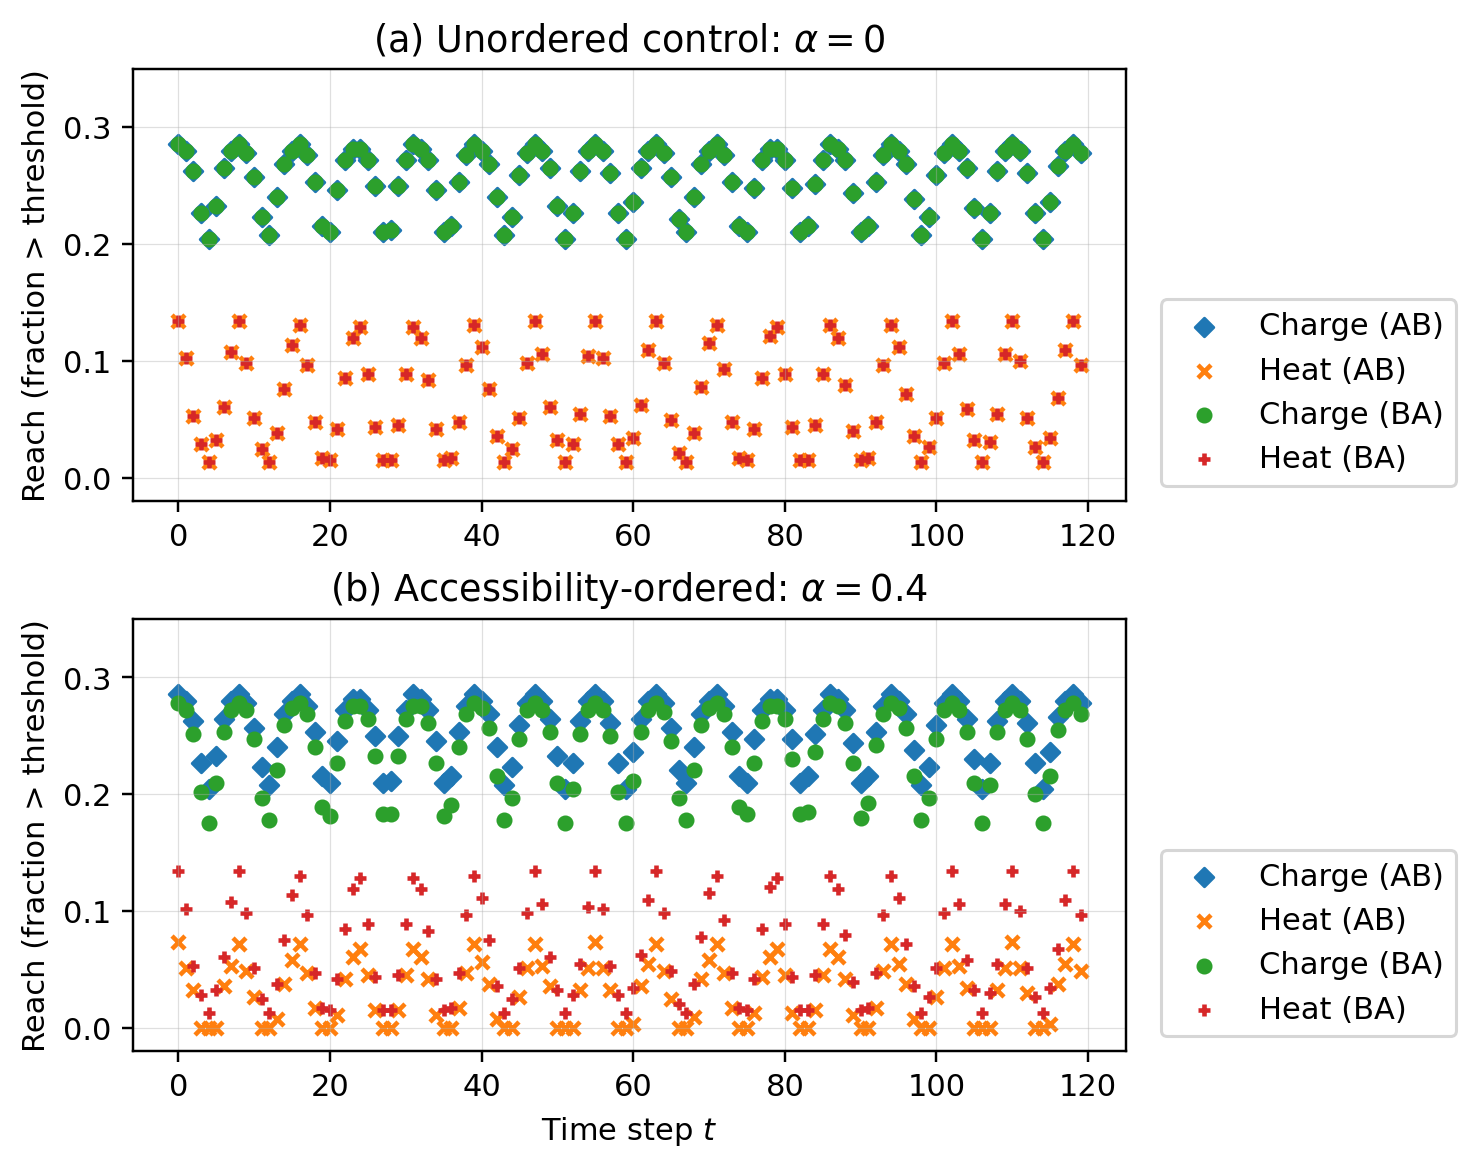

Saved: outputs/paperC_fig2_optionA_timeseries.npz
Saved: outputs/paperC_fig2_optionA_timeseries.png


('outputs/paperC_fig2_optionA_timeseries.npz',
 'outputs/paperC_fig2_optionA_timeseries.png')

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# Diracgate / AOI-gap: time-series figure (Option A)
# Two panels:
# (a) Unordered control (alpha=0): AB and BA overlap
# (b) Ordered (alpha=0.4): AB and BA separate
# ============================================================

# -------------------------
# Utilities
# -------------------------
def sigmoid(kappa, x):
    z = np.clip(-kappa * x, -60.0, 60.0)
    return 1.0 / (1.0 + np.exp(z))

def run_channel(V, kappa, Vc):
    return sigmoid(kappa, V - Vc)

def rot(theta):
    c, s = np.cos(theta), np.sin(theta)
    return np.array([[c, -s], [s,  c]])

def build_grid(Nx=23, Ny=23):
    xs = np.arange(Nx, dtype=float)
    ys = np.arange(Ny, dtype=float)
    X, Y = np.meshgrid(xs, ys, indexing="xy")
    pts = np.stack([X.ravel(), Y.ravel()], axis=1)
    return pts, X, Y

def graphene_recip_vectors(a=1.0):
    b = 4.0 * np.pi / (np.sqrt(3.0) * a)
    g1 = b * np.array([ 1.0, 0.0])
    g2 = b * np.array([-0.5,  np.sqrt(3)/2])
    g3 = b * np.array([-0.5, -np.sqrt(3)/2])
    return g1, g2, g3

def moire_vectors(a_g=1.0, a_hbn=1.018, theta=0.0):
    """
    Minimal moiré construction:
    - graphene reciprocal vectors g_i (a_g)
    - wrapper reciprocal vectors h_i (a_hbn) rotated by theta
    - moiré vectors G_i = h_i - g_i
    """
    g1, g2, g3 = graphene_recip_vectors(a=a_g)
    R = rot(theta)
    scale = (a_g / a_hbn)  # wrapper lattice constant -> reciprocal scales inversely
    h1 = scale * (R @ g1)
    h2 = scale * (R @ g2)
    h3 = scale * (R @ g3)
    G1 = h1 - g1
    G2 = h2 - g2
    G3 = h3 - g3
    return G1, G2, G3

def field_graphene_plus_wrapper(
    pts,
    a_g=1.0,
    a_hbn=1.018,
    theta=0.0,
    hbn_weight=0.4,
    V0=1.0,
    chi=0.0,
):
    """
    A deliberately minimal "Diracgate-style" scalar field:
    - graphene base: sum cos(g_i · r)
    - wrapper-induced moiré: sum cos(G_i · r + s_i * chi)
    - mix via hbn_weight
    """
    g1, g2, g3 = graphene_recip_vectors(a=a_g)
    G1, G2, G3 = moire_vectors(a_g=a_g, a_hbn=a_hbn, theta=theta)

    # graphene base (symmetric)
    base = (np.cos(pts @ g1) + np.cos(pts @ g2) + np.cos(pts @ g3)) / 3.0

    # wrapper/moiré modulation (can include chirality phase chi)
    s1, s2, s3 = (+1.0, -1.0, +1.0)
    moire = (
        np.cos(pts @ G1 + s1 * chi) +
        np.cos(pts @ G2 + s2 * chi) +
        np.cos(pts @ G3 + s3 * chi)
    ) / 3.0

    V = V0 * ((1.0 - hbn_weight) * base + hbn_weight * moire)
    return V

# -------------------------
# AB vs BA schedule runner
# -------------------------
def run_diracgate_AB_BA_timeseries(
    Nx=23, Ny=23,
    Tsteps=120,
    a_g=1.0,
    a_hbn=1.018,
    hbn_weight=0.4,
    theta=0.0,
    chi=0.0,
    V0=1.0,
    omega=0.8,
    charge_params=(2.4, 0.0),
    heat_params=(1.0, -0.15),
    p_thresh=0.7,
    alpha=0.0,
    asym_threshold=False,
    seed=0,
):
    """
    Returns reach time-series for AB and BA schedules:
      rC_AB, rH_AB, rC_BA, rH_BA
    """
    rng = np.random.default_rng(seed)
    pts, X, Y = build_grid(Nx, Ny)
    nsite = pts.shape[0]

    V_static = field_graphene_plus_wrapper(
        pts, a_g=a_g, a_hbn=a_hbn, theta=theta,
        hbn_weight=hbn_weight, V0=V0, chi=chi
    )

    kC, VcC = charge_params
    kH, VcH = heat_params

    if asym_threshold:
        VcC = VcC + 0.10
        VcH = VcH - 0.10

    def drive(t):
        return (1.0 + 0.25 * np.cos(omega * t))

    def schedule(order):
        rC = np.zeros(Tsteps, dtype=float)
        rH = np.zeros(Tsteps, dtype=float)
        for t in range(Tsteps):
            Vt = drive(t) * V_static

            if order == "AB":
                pC = run_channel(Vt, kC, VcC)
                if alpha != 0.0:
                    Vt2 = Vt - alpha * (pC - pC.mean())
                else:
                    Vt2 = Vt
                pH = run_channel(Vt2, kH, VcH)
            else:
                pH = run_channel(Vt, kH, VcH)
                if alpha != 0.0:
                    Vt2 = Vt - alpha * (pH - pH.mean())
                else:
                    Vt2 = Vt
                pC = run_channel(Vt2, kC, VcC)

            rC[t] = float(np.mean(pC > p_thresh))
            rH[t] = float(np.mean(pH > p_thresh))

        return rC, rH

    rC_AB, rH_AB = schedule("AB")
    rC_BA, rH_BA = schedule("BA")

    out = dict(
        Nx=Nx, Ny=Ny, Tsteps=Tsteps,
        a_g=a_g, a_hbn=a_hbn, hbn_weight=hbn_weight,
        theta=theta, chi=chi, V0=V0, omega=omega,
        charge_kappa=kC, charge_Vc=VcC,
        heat_kappa=kH, heat_Vc=VcH,
        p_thresh=p_thresh, alpha=alpha, asym_threshold=asym_threshold,
        rC_AB=rC_AB, rH_AB=rH_AB, rC_BA=rC_BA, rH_BA=rH_BA,
    )
    return out


# -------------------------
# Figure (Option A): two stacked panels
# -------------------------
def make_optionA_figure(
    outdir="outputs",
    stem="paperC_fig_optionA_timeseries",
    Nx=23, Ny=23,
    Tsteps=160,
    a_g=1.0,
    a_hbn=1.018,
    hbn_weight=0.4,
    theta=0.0,
    chi=0.0,
    V0=1.0,
    omega=0.8,
    charge_params=(2.4, 0.0),
    heat_params=(1.0, -0.15),
    p_thresh=0.7,
    alpha_control=0.0,
    alpha_ordered=0.4,
    asym_threshold=False,
    seed=0,
):
    os.makedirs(outdir, exist_ok=True)

    common = dict(
        Nx=Nx, Ny=Ny, Tsteps=Tsteps,
        a_g=a_g, a_hbn=a_hbn, hbn_weight=hbn_weight,
        theta=theta, chi=chi, V0=V0, omega=omega,
        charge_params=charge_params, heat_params=heat_params,
        p_thresh=p_thresh, asym_threshold=asym_threshold, seed=seed,
    )

    # These must exist in your notebook already:
    ctrl = run_diracgate_AB_BA_timeseries(**common, alpha=alpha_control)
    ords = run_diracgate_AB_BA_timeseries(**common, alpha=alpha_ordered)

    # Save NPZ (both panels inside)
    npz_path = os.path.join(outdir, f"{stem}.npz")
    np.savez_compressed(npz_path, control=ctrl, ordered=ords)

    # Plot
    t = np.arange(Tsteps)
    fig, axes = plt.subplots(2, 1, figsize=(6.6, 5.2), dpi=220, constrained_layout=True)

    # Panel (a): alpha=0
    ax = axes[0]
    ax.scatter(t, ctrl["rC_AB"], marker="D", s=18, color="tab:blue",   label="Charge (AB)")
    ax.scatter(t, ctrl["rH_AB"], marker="x", s=18, color="tab:orange", label="Heat (AB)")
    ax.scatter(t, ctrl["rC_BA"], marker="o", s=18, color="tab:green",  label="Charge (BA)")
    ax.scatter(t, ctrl["rH_BA"], marker="+", s=18, color="tab:red",    label="Heat (BA)")

    ax.set_title(r"(a) Unordered control: $\alpha=0$")
    ax.set_ylabel("Reach (fraction > threshold)")
    ax.set_ylim(-0.02, 0.35)
    ax.grid(True, linewidth=0.4, alpha=0.4)
    ax.legend(loc="lower left", bbox_to_anchor=(1.02, 0.0), frameon=True)

    # Panel (b): alpha=0.4 (or whatever you set)
    ax = axes[1]
    ax.scatter(t, ords["rC_AB"], marker="D", s=18, color="tab:blue",   label="Charge (AB)")
    ax.scatter(t, ords["rH_AB"], marker="x", s=18, color="tab:orange", label="Heat (AB)")
    ax.scatter(t, ords["rC_BA"], marker="o", s=18, color="tab:green",  label="Charge (BA)")
    ax.scatter(t, ords["rH_BA"], marker="+", s=18, color="tab:red",    label="Heat (BA)")

    ax.set_title(rf"(b) Accessibility-ordered: $\alpha={alpha_ordered:g}$")
    ax.set_xlabel("Time step $t$")
    ax.set_ylabel("Reach (fraction > threshold)")
    ax.set_ylim(-0.02, 0.35)
    ax.grid(True, linewidth=0.4, alpha=0.4)
    ax.legend(loc="lower left", bbox_to_anchor=(1.02, 0.0), frameon=True)

    png_path = os.path.join(outdir, f"{stem}.png")
    plt.savefig(png_path, bbox_inches="tight")
    plt.show()

    print("Saved:", npz_path)
    print("Saved:", png_path)
    return npz_path, png_path


    # Overall caption-like title (kept short; paper caption can be longer)
    fig.suptitle(
        rf"Diracgate reach time-series",
        y=1.02, fontsize=10
    )

    png_path = os.path.join(outdir, f"{stem}.png")
    plt.savefig(png_path, bbox_inches="tight")
    plt.show()

    print("Saved:", npz_path)
    print("Saved:", png_path)
    print(
        "Params:",
        f"theta={theta} | a_hbn={a_hbn} | hbn_weight={hbn_weight} |",
        f"alpha_control={alpha_control} | alpha_ordered={alpha_ordered} |",
        f"p_thresh={p_thresh} | T={Tsteps}"
    )
    return npz_path, png_path

# ============================================================
# RUN (your requested settings; ordered alpha=0.4)
# ============================================================
make_optionA_figure(
    outdir="outputs",
    stem="paperC_fig2_optionA_timeseries",
    Nx=23, Ny=23,
    Tsteps=120,
    a_g=1.0,
    a_hbn=1.018,
    hbn_weight=0.4,
    theta=0.0,
    chi=0.0,
    V0=1.0,
    omega=0.8,
    charge_params=(2.4, 0.0),
    heat_params=(1.0, -0.15),
    p_thresh=0.7,
    alpha_control=0.0,
    alpha_ordered=0.4,
    asym_threshold=False,
    seed=0,
)

In [ ]:
# ===============================
# Faint coloured grouping zones
# (tune colours + alpha to taste)
# ===============================

# index map (must match your x order)
idx = {
    "baseline": 0,

    "theta_0.0": 1,
    "theta_0.05": 2,
    "theta_0.1": 3,

    "w_0.0": 4,
    "w_0.2": 5,
    "w_0.4": 6,

    "alpha_0.0": 7,
    "alpha_0.4": 8,
    "alpha_0.8": 9,

    "control": 10,
}

# One band per sweep/group:
bands = [
    ("baseline", idx["baseline"], idx["baseline"], "#eeeeee"),

    ("theta sweep", idx["theta_0.0"], idx["theta_0.1"], "#fdebd0"),      # warm
    ("hBN weight sweep", idx["w_0.0"], idx["w_0.4"], "#d5f5e3"),         # green
    ("alpha sweep", idx["alpha_0.0"], idx["alpha_0.8"], "#ebdef0"),      # purple

    ("control", idx["control"], idx["control"], "#f2f3f4"),
]

for name, start, end, color in bands:
    ax.axvspan(
        start - 0.5,
        end + 0.5,
        color=color,
        alpha=0.28,   # faint
        zorder=0
    )

# Optional: faint vertical separators at group boundaries
for xsep in [0.5, 3.5, 6.5, 9.5]:
    ax.axvline(xsep, linestyle=":", linewidth=0.9, alpha=0.35, zorder=1)

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

def load_timeseries_npz(npz_path):
    """
    Expects an NPZ created like:
      np.savez_compressed(path, control=ctrl_dict, ordered=ords_dict)
    where ctrl_dict / ords_dict contain rC_AB, rH_AB, rC_BA, rH_BA.
    """
    D = np.load(npz_path, allow_pickle=True)

    if "control" not in D.files or "ordered" not in D.files:
        raise KeyError(f"NPZ must contain keys 'control' and 'ordered'. Found: {D.files}")

    ctrl = D["control"].item() if isinstance(D["control"], np.ndarray) else D["control"]
    ords = D["ordered"].item() if isinstance(D["ordered"], np.ndarray) else D["ordered"]
    return ctrl, ords

def fig3_aoi_gap_integrand(
    npz_path,
    outdir="outputs",
    out_png="paperC_fig3_aoi_gap_integrand.png",
    title=None,
):
    os.makedirs(outdir, exist_ok=True)
    ctrl, ords = load_timeseries_npz(npz_path)

    # Extract reach curves
    rC_AB0 = np.asarray(ctrl["rC_AB"], dtype=float)
    rH_AB0 = np.asarray(ctrl["rH_AB"], dtype=float)
    rC_BA0 = np.asarray(ctrl["rC_BA"], dtype=float)
    rH_BA0 = np.asarray(ctrl["rH_BA"], dtype=float)

    rC_AB1 = np.asarray(ords["rC_AB"], dtype=float)
    rH_AB1 = np.asarray(ords["rH_AB"], dtype=float)
    rC_BA1 = np.asarray(ords["rC_BA"], dtype=float)
    rH_BA1 = np.asarray(ords["rH_BA"], dtype=float)

    T0 = len(rC_AB0)
    T1 = len(rC_AB1)
    if T0 != T1:
        raise ValueError(f"Control T={T0} and Ordered T={T1} differ. Use same Tsteps for both panels.")
    T = T0
    t = np.arange(T)

    # AOI-gap integrand
    d0 = (rC_AB0 - rH_AB0) - (rC_BA0 - rH_BA0)
    d1 = (rC_AB1 - rH_AB1) - (rC_BA1 - rH_BA1)

    # --- Plot (stacked panels) ---
    fig, axes = plt.subplots(2, 1, figsize=(7.2, 5.0), dpi=240, constrained_layout=True)

    def panel(ax, rC_AB, rH_AB, rC_BA, rH_BA, d, panel_title, shade_positive=False):
        # Reach curves (markers only)
        ax.scatter(t, rC_AB, marker="D", s=18, label="Charge (AB)")
        ax.scatter(t, rH_AB, marker="x", s=20, label="Heat (AB)")
        ax.scatter(t, rC_BA, marker="o", s=18, label="Charge (BA)")
        ax.scatter(t, rH_BA, marker="+", s=24, label="Heat (BA)")

        # Integrand (black squares)
        ax.scatter(t, d, marker="s", s=14, label=r"$d(t)$ (AOI-gap integrand)")

        ax.axhline(0.0, linewidth=1.0)
        ax.set_title(panel_title)
        ax.set_ylabel("Reach / integrand (fraction)")

        # Optional positive-area shading for d(t)
        if shade_positive:
            mask = d > 0.0
            # fill_between wants x numeric and y numeric; we can shade with a stepped polygon by plotting
            ax.fill_between(t, 0.0, d, where=mask, alpha=0.18, interpolate=True)

        # Tight y-lims (robust)
        y_all = np.concatenate([rC_AB, rH_AB, rC_BA, rH_BA, d])
        y_min = float(np.min(y_all))
        y_max = float(np.max(y_all))
        pad = max(0.02, 0.12 * (y_max - y_min + 1e-12))
        ax.set_ylim(y_min - pad, y_max + pad)

        ax.grid(True, linewidth=0.4, alpha=0.4)
        ax.legend(loc="lower left", bbox_to_anchor=(1.02, 0.0), frameon=True)

    panel(
        axes[0],
        rC_AB0, rH_AB0, rC_BA0, rH_BA0, d0,
        panel_title=r"(a) Unordered control ($\alpha=0$): $d(t)\approx 0$",
        shade_positive=False,
    )
    panel(
        axes[1],
        rC_AB1, rH_AB1, rC_BA1, rH_BA1, d1,
        panel_title=r"(b) Accessibility-ordered ($\alpha>0$): $d(t)$ deviates; positive area contributes to AOI-gap",
        shade_positive=True,
    )
    axes[1].set_xlabel(r"Time step $t$")

    if title is not None:
        fig.suptitle(title, y=1.02)

    out_path = os.path.join(outdir, out_png)
    plt.savefig(out_path, bbox_inches="tight")
    plt.show()
    print("Saved:", out_path)

# -----------------------------
# RUN (edit path to your Option-A NPZ)
# -----------------------------
# Example:
fig3_aoi_gap_integrand(
    npz_path="outputs/paperC_fig_optionA_timeseries.npz",
    outdir="outputs",
    out_png="paperC_fig3_aoi_gap_integrand.png",
)

FileNotFoundError: [Errno 2] No such file or directory: 'outputs/paperC_fig_optionA_timeseries.npz'

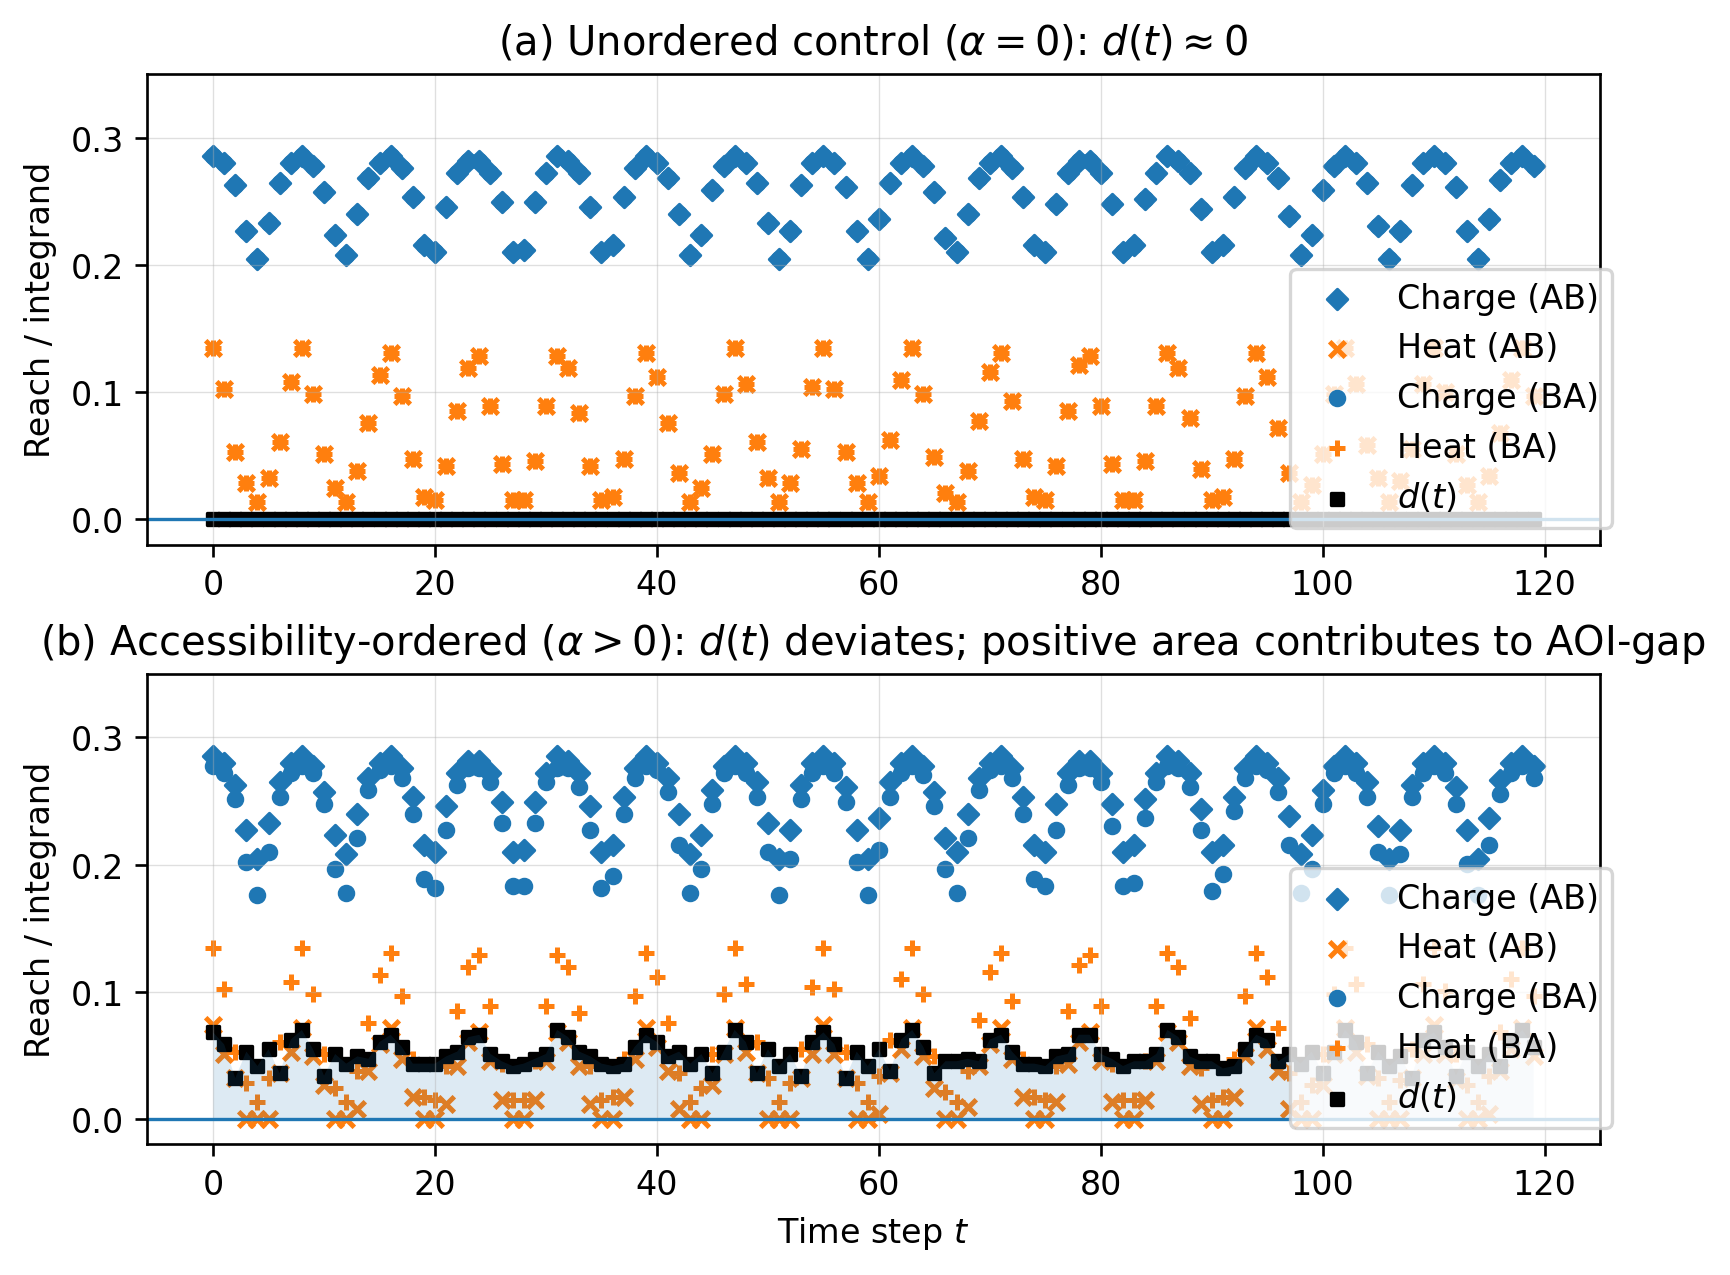

Saved: outputs/paperC_fig3_aoi_gap_integrand.png


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

def load_timeseries_npz(npz_path):
    D = np.load(npz_path, allow_pickle=True)
    if "control" not in D.files or "ordered" not in D.files:
        raise KeyError(f"NPZ must contain keys 'control' and 'ordered'. Found: {D.files}")
    ctrl = D["control"].item()
    ords = D["ordered"].item()
    return ctrl, ords

def fig3_aoi_gap_integrand(
    npz_path="outputs/paperC_fig_optionA_timeseries.npz",
    outdir="outputs",
    out_png="paperC_fig3_aoi_gap_integrand.png",
    ylims=(-0.02, 0.35),          # zoom like your Option A
    legend_loc="lower right",     # legend outside right, lower-right
):
    os.makedirs(outdir, exist_ok=True)
    ctrl, ords = load_timeseries_npz(npz_path)

    # Extract reach curves
    rC_AB0 = np.asarray(ctrl["rC_AB"], dtype=float)
    rH_AB0 = np.asarray(ctrl["rH_AB"], dtype=float)
    rC_BA0 = np.asarray(ctrl["rC_BA"], dtype=float)
    rH_BA0 = np.asarray(ctrl["rH_BA"], dtype=float)

    rC_AB1 = np.asarray(ords["rC_AB"], dtype=float)
    rH_AB1 = np.asarray(ords["rH_AB"], dtype=float)
    rC_BA1 = np.asarray(ords["rC_BA"], dtype=float)
    rH_BA1 = np.asarray(ords["rH_BA"], dtype=float)

    T0 = len(rC_AB0)
    T1 = len(rC_AB1)
    if T0 != T1:
        raise ValueError(f"Control T={T0} and Ordered T={T1} differ. Use same Tsteps for both panels.")
    T = T0
    t = np.arange(T)

    # AOI-gap integrand
    d0 = (rC_AB0 - rH_AB0) - (rC_BA0 - rH_BA0)
    d1 = (rC_AB1 - rH_AB1) - (rC_BA1 - rH_BA1)

    fig, axes = plt.subplots(2, 1, figsize=(6.7, 5.2), dpi=240, constrained_layout=True)

    def panel(ax, rC_AB, rH_AB, rC_BA, rH_BA, d, title, shade_positive=False):
        # Style: blue for charge; orange for heat. AB vs BA distinguished by marker only.
        ax.scatter(t, rC_AB, marker="D", s=18, color="tab:blue", label="Charge (AB)")
        ax.scatter(t, rH_AB, marker="x", s=22, color="tab:orange", label="Heat (AB)")
        ax.scatter(t, rC_BA, marker="o", s=18, color="tab:blue", label="Charge (BA)")
        ax.scatter(t, rH_BA, marker="+", s=26, color="tab:orange", label="Heat (BA)")

        # Integrand (black squares)
        ax.scatter(t, d, marker="s", s=14, color="black", label=r"$d(t)$")

        ax.axhline(0.0, linewidth=1.0)
        ax.set_title(title)
        ax.set_ylabel("Reach / integrand")
        if ylims is not None:
            ax.set_ylim(ylims[0], ylims[1])

        if shade_positive:
            mask = d > 0.0
            ax.fill_between(t, 0.0, d, where=mask, alpha=0.15, interpolate=True)

        ax.grid(True, linewidth=0.4, alpha=0.4)

        # Legend outside to the right, anchored low
        ax.legend(
            loc=legend_loc,
            bbox_to_anchor=(1.02, 0.0),
            frameon=True
        )

    panel(
        axes[0],
        rC_AB0, rH_AB0, rC_BA0, rH_BA0, d0,
        title=r"(a) Unordered control ($\alpha=0$): $d(t)\approx 0$",
        shade_positive=False,
    )
    panel(
        axes[1],
        rC_AB1, rH_AB1, rC_BA1, rH_BA1, d1,
        title=r"(b) Accessibility-ordered ($\alpha>0$): $d(t)$ deviates; positive area contributes to AOI-gap",
        shade_positive=True,
    )
    axes[1].set_xlabel(r"Time step $t$")

    out_path = os.path.join(outdir, out_png)
    plt.savefig(out_path, bbox_inches="tight")
    plt.show()
    print("Saved:", out_path)

# RUN
fig3_aoi_gap_integrand(
    npz_path="outputs/paperC_fig2_optionA_timeseries.npz",
    outdir="outputs",
    out_png="paperC_fig3_aoi_gap_integrand.png",
)

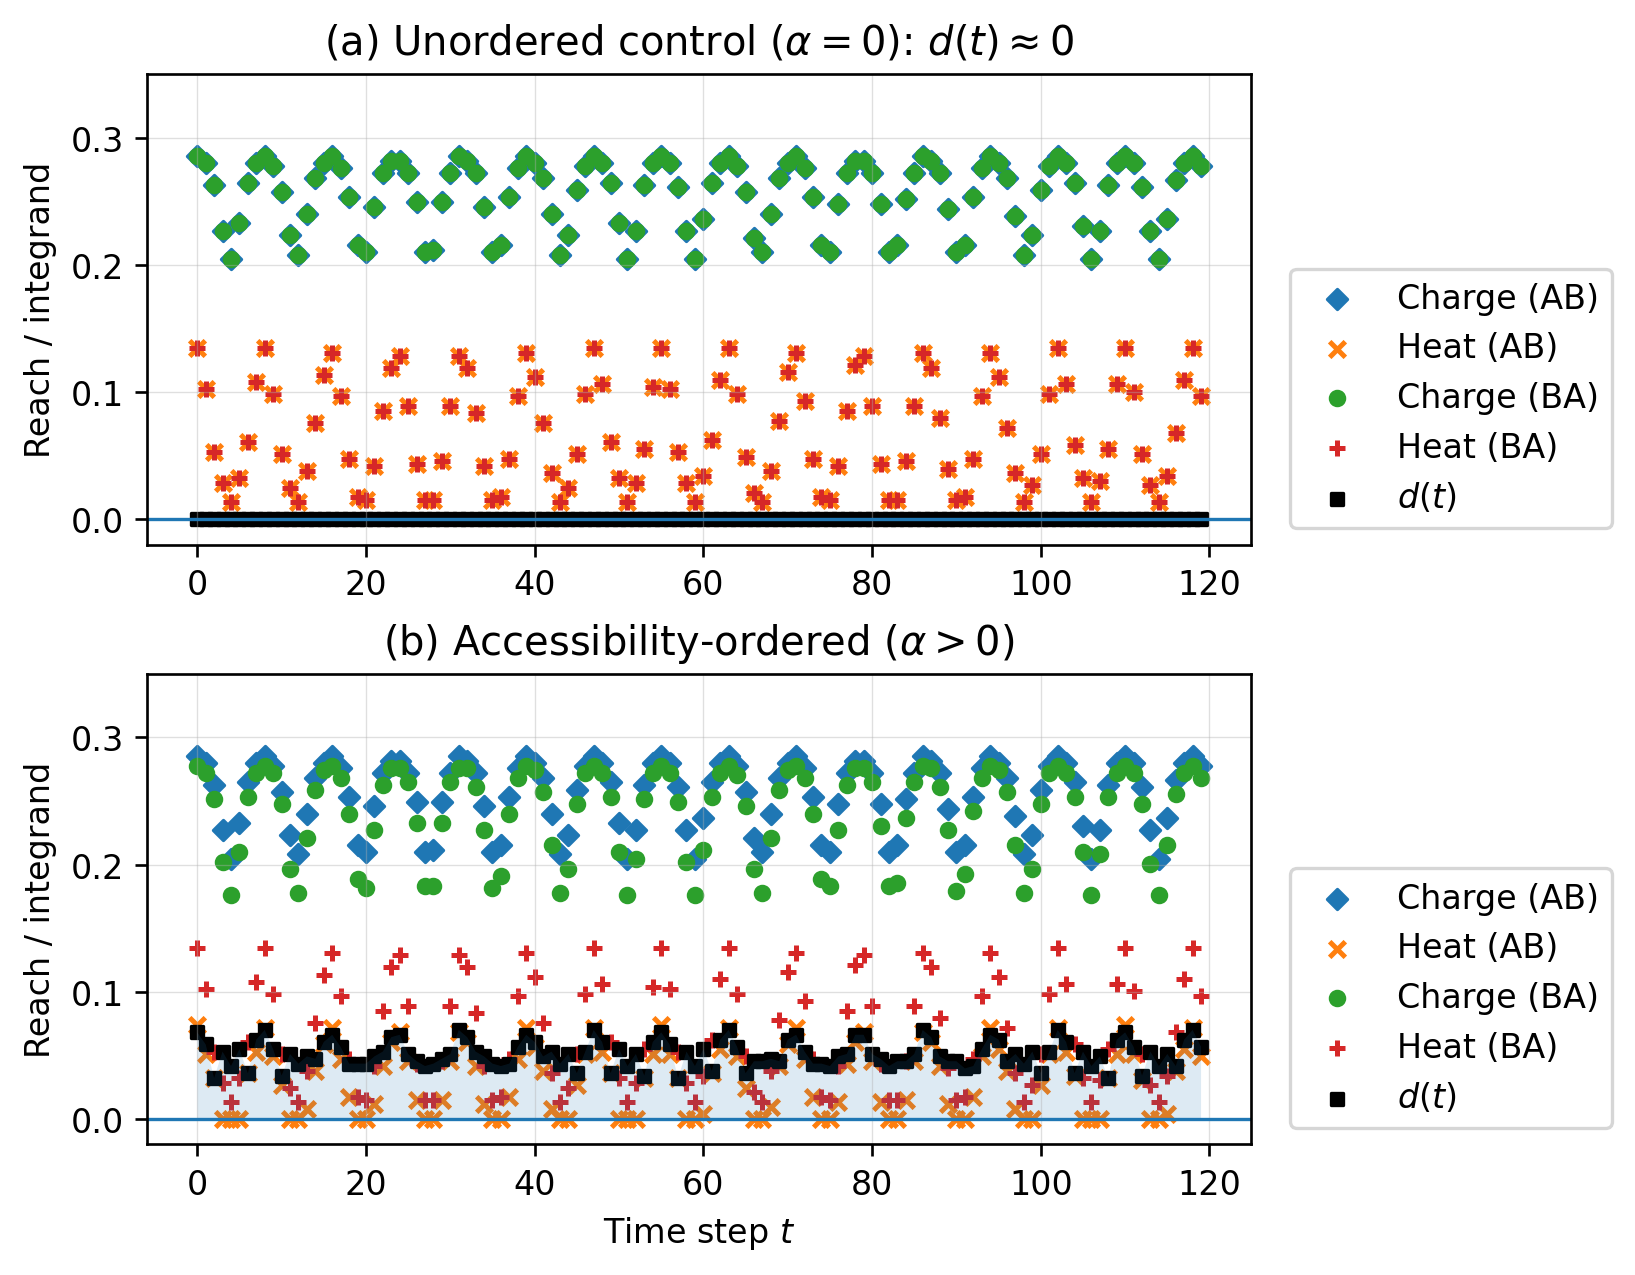

Saved: outputs/paperC_fig3_aoi_gap_integrand.png


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt


def load_timeseries_npz(npz_path):
    """
    Expects:
      np.savez_compressed(path, control=ctrl_dict, ordered=ords_dict)
    where ctrl_dict / ords_dict contain:
      rC_AB, rH_AB, rC_BA, rH_BA
    """
    D = np.load(npz_path, allow_pickle=True)
    if "control" not in D.files or "ordered" not in D.files:
        raise KeyError(f"NPZ must contain keys 'control' and 'ordered'. Found: {D.files}")

    # In practice these are 0-d object arrays; .item() yields the dict
    ctrl = D["control"].item()
    ords = D["ordered"].item()
    return ctrl, ords


def fig3_aoi_gap_integrand(
    npz_path="outputs/paperC_fig2_optionA_timeseries.npz",
    outdir="outputs",
    out_png="paperC_fig3_aoi_gap_integrand.png",
    ylims=(-0.02, 0.35),      # match your Fig2 zoom
    dpi=240,
    figsize=(6.7, 5.2),
    legend_outside=True,
):
    os.makedirs(outdir, exist_ok=True)
    ctrl, ords = load_timeseries_npz(npz_path)

    # ---- Extract reach curves (control) ----
    rC_AB0 = np.asarray(ctrl["rC_AB"], dtype=float)
    rH_AB0 = np.asarray(ctrl["rH_AB"], dtype=float)
    rC_BA0 = np.asarray(ctrl["rC_BA"], dtype=float)
    rH_BA0 = np.asarray(ctrl["rH_BA"], dtype=float)

    # ---- Extract reach curves (ordered) ----
    rC_AB1 = np.asarray(ords["rC_AB"], dtype=float)
    rH_AB1 = np.asarray(ords["rH_AB"], dtype=float)
    rC_BA1 = np.asarray(ords["rC_BA"], dtype=float)
    rH_BA1 = np.asarray(ords["rH_BA"], dtype=float)

    T0 = len(rC_AB0)
    T1 = len(rC_AB1)
    if T0 != T1:
        raise ValueError(f"Control T={T0} and Ordered T={T1} differ. Use same Tsteps for both panels.")
    T = T0
    t = np.arange(T)

    # ---- AOI-gap integrand (instantaneous contribution) ----
    # d(t) := (rC_AB - rH_AB) - (rC_BA - rH_BA)
    d0 = (rC_AB0 - rH_AB0) - (rC_BA0 - rH_BA0)
    d1 = (rC_AB1 - rH_AB1) - (rC_BA1 - rH_BA1)

    # ---- Plot ----
    fig, axes = plt.subplots(
        2, 1,
        figsize=figsize,
        dpi=dpi,
        constrained_layout=True
    )

    # Marker/size scheme to match your Fig2 conventions:
    # Charge = blue diamonds/circles; Heat = orange x/+
    s_charge = 18
    s_heat_x = 22
    s_heat_plus = 26
    s_integrand = 14

    def add_legend(ax):
        if legend_outside:
            # "outside right, low" (matches your Fig2 setup)
            ax.legend(
                loc="lower left",
                bbox_to_anchor=(1.02, 0.0),
                frameon=True
            )
        else:
            ax.legend(loc="lower right", frameon=True)

    def panel(ax, rC_AB, rH_AB, rC_BA, rH_BA, d, title, shade_positive=False):
        # AB series
        ax.scatter(t, rC_AB, marker="D", s=s_charge, color="tab:blue", label="Charge (AB)")
        ax.scatter(t, rH_AB, marker="x", s=s_heat_x, color="tab:orange", label="Heat (AB)")

        # BA series (same colours; marker distinguishes ordering)
        ax.scatter(t, rC_BA, marker="o", s=s_charge, color="tab:green", label="Charge (BA)")
        ax.scatter(t, rH_BA, marker="+", s=s_heat_plus, color="tab:red", label="Heat (BA)")

        # Integrand (black squares)
        ax.scatter(t, d, marker="s", s=s_integrand, color="black", label=r"$d(t)$")

        # Baseline
        ax.axhline(0.0, linewidth=1.0)

        # Optional positive-area shading for d(t)
        if shade_positive:
            mask = d > 0.0
            ax.fill_between(t, 0.0, d, where=mask, alpha=0.15, interpolate=True)

        ax.set_title(title)
        ax.set_ylabel("Reach / integrand")
        if ylims is not None:
            ax.set_ylim(ylims[0], ylims[1])

        ax.grid(True, linewidth=0.4, alpha=0.4)
        add_legend(ax)

    panel(
        axes[0],
        rC_AB0, rH_AB0, rC_BA0, rH_BA0, d0,
        title=r"(a) Unordered control ($\alpha=0$): $d(t)\approx 0$",
        shade_positive=False,
    )
    panel(
        axes[1],
        rC_AB1, rH_AB1, rC_BA1, rH_BA1, d1,
        title=r"(b) Accessibility-ordered ($\alpha>0$)",
        shade_positive=True,
    )
    axes[1].set_xlabel(r"Time step $t$")

    out_path = os.path.join(outdir, out_png)
    plt.savefig(out_path, bbox_inches="tight")
    plt.show()
    print("Saved:", out_path)


# RUN
fig3_aoi_gap_integrand(
    npz_path="outputs/paperC_fig2_optionA_timeseries.npz",
    outdir="outputs",
    out_png="paperC_fig3_aoi_gap_integrand.png",
)

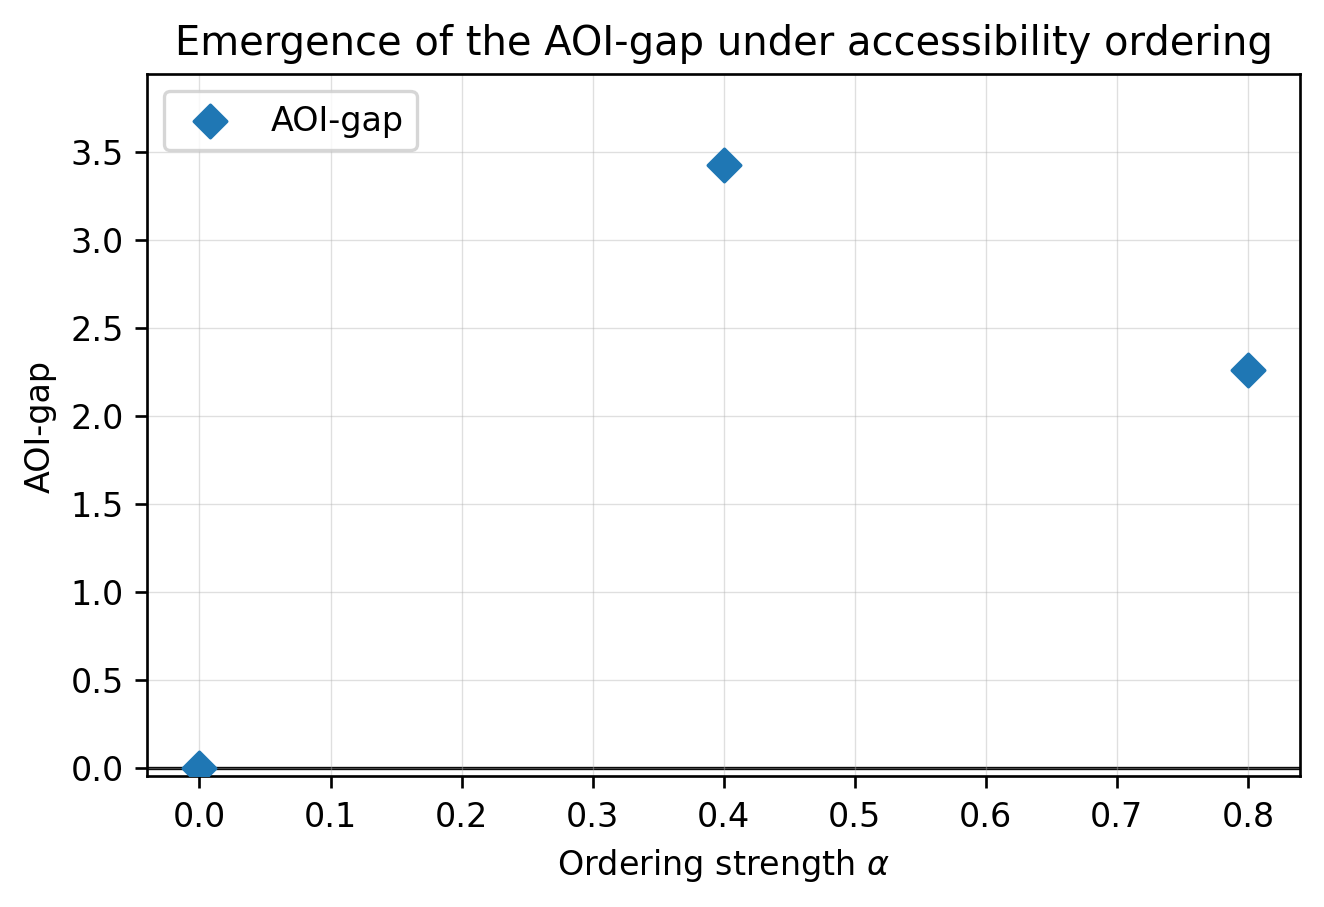

Saved: outputs/fig4.png


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

def fig4_aoi_gap_vs_alpha(
    npz_path="outputs/paperC_AOI_gap_sweep_summary.npz",
    outdir="outputs",
    out_png="fig4.png",
):
    os.makedirs(outdir, exist_ok=True)

    D = np.load(npz_path, allow_pickle=True)
    records = D["records"]

    # Extract alpha sweeps only
    alphas = []
    gaps = []

    for r in records:
        lab = r["label"]
        if lab.startswith("alpha_"):
            alpha = float(lab.split("_")[1])
            alphas.append(alpha)
            gaps.append(r["AOI_gap"])

    alphas = np.array(alphas, dtype=float)
    gaps = np.array(gaps, dtype=float)

    # Sort by alpha
    order = np.argsort(alphas)
    alphas = alphas[order]
    gaps = gaps[order]

    # ---- Plot ----
    fig, ax = plt.subplots(figsize=(6.2, 3.8), dpi=240)

    ax.scatter(
        alphas,
        gaps,
        marker="D",
        s=48,
        color="tab:blue",
        zorder=3,
        label=r"AOI-gap"
    )

    ax.axhline(0.0, linewidth=1.0, color="black", zorder=1)

    ax.set_xlabel(r"Ordering strength $\alpha$")
    ax.set_ylabel(r"AOI-gap")
    ax.set_title("Emergence of the AOI-gap under accessibility ordering")

    # Tight but safe limits
    ymin = min(-0.05, 1.15 * gaps.min())
    ymax = 1.15 * gaps.max()
    ax.set_ylim(ymin, ymax)

    ax.grid(True, linewidth=0.4, alpha=0.4)

    ax.legend(loc="upper left", frameon=True)

    out_path = os.path.join(outdir, out_png)
    plt.savefig(out_path, bbox_inches="tight")
    plt.show()

    print("Saved:", out_path)


# -----------------
# RUN
# -----------------
fig4_aoi_gap_vs_alpha(
    npz_path="outputs/paperC_AOI_gap_sweep_summary.npz",
    outdir="outputs",
    out_png="fig4.png",
)

In [ ]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt

def _load_records(npz_path):
    D = np.load(npz_path, allow_pickle=True)
    if "records" not in D.files:
        raise KeyError(f"Expected key 'records' in NPZ. Found keys: {D.files}")
    return list(D["records"])

def _extract_numeric_from_label(label, prefix):
    # label like "theta_0.05" or "hbn_weight_0.4"
    if not label.startswith(prefix):
        return None
    return float(label.split("_", 1)[1])

def fig4_alpha_fixed_structure_sweeps(
    npz_path="outputs/paperC_AOI_gap_sweep_summary.npz",
    outdir="outputs",
    out_png="fig4.png",
    alpha_fixed=0.4,
):
    os.makedirs(outdir, exist_ok=True)
    records = _load_records(npz_path)

    # ---------- Pull out sweeps ----------
    # theta sweep: labels "theta_0.0", "theta_0.05", "theta_0.1", ...
    theta_x, theta_gap = [], []

    # moire sweep proxy: labels "hbn_weight_0.0", "hbn_weight_0.2", ...
    w_x, w_gap = [], []

    # Also keep baseline (optional annotation)
    baseline = None

    for r in records:
        lab = str(r.get("label", ""))
        gap = float(r.get("AOI_gap", np.nan))
        alpha = float(r.get("alpha", np.nan))

        if lab == "baseline_hBN_ordered":
            baseline = r

        # Only show points at the alpha we want (for structure sweeps)
        # (If your stored theta/hbn_weight records already have alpha=0.8 in them,
        # this filter will exclude them. In that case, regenerate the sweep at alpha=0.4.)
        if not np.isfinite(alpha) or abs(alpha - alpha_fixed) > 1e-12:
            continue

        th = _extract_numeric_from_label(lab, "theta_")
        if th is not None:
            theta_x.append(th)
            theta_gap.append(gap)
            continue

        w = _extract_numeric_from_label(lab, "hbn_weight_")
        if w is not None:
            w_x.append(w)
            w_gap.append(gap)
            continue

    theta_x = np.array(theta_x, dtype=float)
    theta_gap = np.array(theta_gap, dtype=float)
    w_x = np.array(w_x, dtype=float)
    w_gap = np.array(w_gap, dtype=float)

    # Sort
    if theta_x.size > 0:
        idx = np.argsort(theta_x)
        theta_x, theta_gap = theta_x[idx], theta_gap[idx]
    if w_x.size > 0:
        idx = np.argsort(w_x)
        w_x, w_gap = w_x[idx], w_gap[idx]

    if theta_x.size == 0 and w_x.size == 0:
        raise ValueError(
            f"No theta_*/hbn_weight_* records found at alpha={alpha_fixed}. "
            f"Either (i) regenerate the sweep at alpha={alpha_fixed}, or "
            f"(ii) remove the alpha filter."
        )

    # ---------- Plot ----------
    fig, axes = plt.subplots(2, 1, figsize=(6.8, 5.0), dpi=240, constrained_layout=True)

    # Panel (a): twist sweep
    ax = axes[0]
    if theta_x.size > 0:
        ax.scatter(theta_x, theta_gap, marker="D", s=55, color="tab:blue")
    ax.axhline(0.0, linewidth=1.0, color="black")
    ax.set_title(rf"(a) Twist sweep at fixed ordering ($\alpha={alpha_fixed:g}$)")
    ax.set_xlabel(r"Twist angle $\theta$ (arb. units)")
    ax.set_ylabel("AOI-gap")
    ax.grid(True, linewidth=0.4, alpha=0.4)

    # Panel (b): moiré-weight sweep
    ax = axes[1]
    if w_x.size > 0:
        ax.scatter(w_x, w_gap, marker="D", s=55, color="tab:blue")
    ax.axhline(0.0, linewidth=1.0, color="black")
    ax.set_title(rf"(b) Moiré-weight sweep at fixed ordering ($\alpha={alpha_fixed:g}$)")
    ax.set_xlabel(r"hBN weight $w_{\mathrm{hBN}}$")
    ax.set_ylabel("AOI-gap")
    ax.grid(True, linewidth=0.4, alpha=0.4)

    out_path = os.path.join(outdir, out_png)
    plt.savefig(out_path, bbox_inches="tight")
    plt.show()
    print("Saved:", out_path)

# RUN
fig4_alpha_fixed_structure_sweeps(
    npz_path="outputs/paperC_AOI_gap_sweep_summary.npz",
    outdir="outputs",
    out_png="fig4.png",
    alpha_fixed=0.4,
)

ValueError: No theta_*/hbn_weight_* records found at alpha=0.4. Either (i) regenerate the sweep at alpha=0.4, or (ii) remove the alpha filter.

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# Helper: run + record
# ----------------------------
def run_and_record(label, params):
    """
    Requires: run_diracgate_AOI(**params) -> (AOI_AB, AOI_BA)
    """
    AOI_AB, AOI_BA = run_diracgate_AOI(**params)
    return {
        "label": label,
        "AOI_AB": float(AOI_AB),
        "AOI_BA": float(AOI_BA),
        "AOI_gap": float(AOI_AB - AOI_BA),   # signed
        # store key knobs for sanity
        "alpha": float(params.get("alpha", np.nan)),
        "theta": float(params.get("theta", np.nan)),
        "a_hbn": float(params.get("a_hbn", np.nan)),
        "hbn_weight": float(params.get("hbn_weight", np.nan)),
        "p_thresh": float(params.get("p_thresh", np.nan)),
        "Tsteps": int(params.get("Tsteps", -1)),
    }

def save_records_npz(path, records, meta):
    os.makedirs(os.path.dirname(path) or ".", exist_ok=True)
    np.savez_compressed(path, records=np.array(records, dtype=object), **meta)

# ----------------------------
# Fig 4 plotter (stacked)
# ----------------------------
def plot_fig4(records, out_png, alpha_fixed=0.4):
    # pull sweeps
    theta = []
    theta_gap = []
    w = []
    w_gap = []
    ah = []
    ah_gap = []

    for r in records:
        if abs(float(r.get("alpha", np.nan)) - alpha_fixed) > 1e-12:
            continue
        lab = str(r.get("label", ""))

        if lab.startswith("theta_"):
            theta.append(float(r["theta"]))
            theta_gap.append(float(r["AOI_gap"]))
        if lab.startswith("hbn_weight_"):
            w.append(float(r["hbn_weight"]))
            w_gap.append(float(r["AOI_gap"]))
        if lab.startswith("a_hbn_"):
            ah.append(float(r["a_hbn"]))
            ah_gap.append(float(r["AOI_gap"]))

    # sort
    def sort_xy(x, y):
        x = np.array(x, dtype=float)
        y = np.array(y, dtype=float)
        if x.size == 0:
            return x, y
        idx = np.argsort(x)
        return x[idx], y[idx]

    theta, theta_gap = sort_xy(theta, theta_gap)
    w, w_gap = sort_xy(w, w_gap)
    ah, ah_gap = sort_xy(ah, ah_gap)

    # two-panel figure: (a) theta, (b) moire knob(s)
    fig, axes = plt.subplots(2, 1, figsize=(6.8, 5.0), dpi=240, constrained_layout=True)

    # Panel (a): theta sweep
    ax = axes[0]
    if theta.size > 0:
        ax.scatter(theta, theta_gap, marker="D", s=55, color="tab:blue")
    ax.axhline(0.0, linewidth=1.0, color="black")
    ax.set_title(rf"(a) Twist sweep at fixed ordering ($\alpha={alpha_fixed:g}$)")
    ax.set_xlabel(r"Twist angle $\theta$ (arb. units)")
    ax.set_ylabel("AOI-gap (signed)")
    ax.grid(True, linewidth=0.4, alpha=0.4)

    # Panel (b): moiré knobs (prefer hbn_weight; optionally also show a_hbn)
    ax = axes[1]
    if w.size > 0:
        ax.scatter(w, w_gap, marker="D", s=55, color="tab:blue", label=r"$w_{\mathrm{hBN}}$")
    if ah.size > 0:
        ax.scatter(ah, ah_gap, marker="x", s=70, color="tab:orange", label=r"$a_{\mathrm{hBN}}$")
        ax.legend(loc="lower right", frameon=True)

    ax.axhline(0.0, linewidth=1.0, color="black")
    ax.set_title(rf"(b) Moiré controls at fixed ordering ($\alpha={alpha_fixed:g}$)")
    ax.set_xlabel(r"Moiré knob value (see legend)")
    ax.set_ylabel("AOI-gap (signed)")
    ax.grid(True, linewidth=0.4, alpha=0.4)

    plt.savefig(out_png, bbox_inches="tight")
    plt.show()
    print("Saved:", out_png)

# ----------------------------
# MAIN: run sweeps + save NPZ + save Fig4
# ----------------------------
def run_paperC_sweeps_and_fig4(
    outdir="outputs",
    npz_name="paperC_fig4_structure_sweeps_alpha0p4.npz",
    png_name="fig4.png",
    alpha_fixed=0.4,
    p_thresh=0.7,
    Tsteps=160,
    # baseline physical-ish knobs (match what you used)
    a_g=1.0,
    a_hbn_base=1.018,
    hbn_weight_base=0.4,
    chi=0.0,
    V0=1.0,
    omega=0.8,
    charge_params=(2.4, 0.0),
    heat_params=(1.0, -0.15),
    asym_threshold=False,
    seed=0,
    # sweeps
    theta_list=(0.0, 0.02, 0.05, 0.08, 0.10, 0.12, 0.15),
    hbn_weight_list=(0.0, 0.1, 0.2, 0.3, 0.4, 0.6, 0.8),
    a_hbn_list=(1.000, 1.006, 1.012, 1.018, 1.024, 1.030),
):
    os.makedirs(outdir, exist_ok=True)
    out_npz = os.path.join(outdir, npz_name)
    out_png = os.path.join(outdir, png_name)

    base = dict(
        Nx=23, Ny=23,
        Tsteps=Tsteps,
        a_g=a_g,
        a_hbn=a_hbn_base,
        hbn_weight=hbn_weight_base,
        theta=0.0,
        chi=chi,
        V0=V0,
        omega=omega,
        charge_params=charge_params,
        heat_params=heat_params,
        p_thresh=p_thresh,
        alpha=alpha_fixed,
        asym_threshold=asym_threshold,
        seed=seed,
    )

    records = []

    # Baseline
    records.append(run_and_record("baseline", base))

    # Theta sweep
    for th in theta_list:
        params = dict(base)
        params["theta"] = float(th)
        records.append(run_and_record(f"theta_{th}", params))

    # hBN weight sweep
    for w in hbn_weight_list:
        params = dict(base)
        params["hbn_weight"] = float(w)
        records.append(run_and_record(f"hbn_weight_{w}", params))

    # a_hbn sweep (moire mismatch proxy)
    for ah in a_hbn_list:
        params = dict(base)
        params["a_hbn"] = float(ah)
        records.append(run_and_record(f"a_hbn_{ah}", params))

    # Save NPZ
    meta = dict(
        alpha_fixed=float(alpha_fixed),
        p_thresh=float(p_thresh),
        Tsteps=int(Tsteps),
        a_g=float(a_g),
        chi=float(chi),
        V0=float(V0),
        omega=float(omega),
        a_hbn_base=float(a_hbn_base),
        hbn_weight_base=float(hbn_weight_base),
        seed=int(seed),
    )
    save_records_npz(out_npz, records, meta)
    print("Saved:", out_npz)

    # Print quick summary
    print("\n=== Paper C Fig4 sweeps (alpha fixed) ===")
    for r in records:
        print(f"{r['label']:18s} | theta={r['theta']:.3f} a_hbn={r['a_hbn']:.4f} w={r['hbn_weight']:.2f} | AOI-gap={r['AOI_gap']:.4f}")

    # Plot Fig4
    plot_fig4(records, out_png, alpha_fixed=alpha_fixed)

    return out_npz, out_png

# RUN IT
run_paperC_sweeps_and_fig4()

TypeError: run_diracgate_AOI() got an unexpected keyword argument 'Nx'

Saved: outputs/paperC_fig4_structure_sweeps_alpha0p4.npz

=== Fig4 sweeps (alpha fixed) ===
baseline           | theta=   0.0 a_hbn=  1.018 w=   0.4 | AOI-gap=3.4263
theta_0.0          | theta=   0.0 a_hbn=  1.018 w=   0.4 | AOI-gap=3.4263
theta_0.02         | theta=  0.02 a_hbn=  1.018 w=   0.4 | AOI-gap=3.4073
theta_0.05         | theta=  0.05 a_hbn=  1.018 w=   0.4 | AOI-gap=3.4090
theta_0.08         | theta=  0.08 a_hbn=  1.018 w=   0.4 | AOI-gap=3.3985
theta_0.1          | theta=   0.1 a_hbn=  1.018 w=   0.4 | AOI-gap=3.4010
theta_0.12         | theta=  0.12 a_hbn=  1.018 w=   0.4 | AOI-gap=3.4009
theta_0.15         | theta=  0.15 a_hbn=  1.018 w=   0.4 | AOI-gap=3.3962
hbn_weight_0.0     | theta=   0.0 a_hbn=  1.018 w=   0.0 | AOI-gap=3.2551
hbn_weight_0.1     | theta=   0.0 a_hbn=  1.018 w=   0.1 | AOI-gap=3.3107
hbn_weight_0.2     | theta=   0.0 a_hbn=  1.018 w=   0.2 | AOI-gap=3.3300
hbn_weight_0.3     | theta=   0.0 a_hbn=  1.018 w=   0.3 | AOI-gap=3.3878
hbn_weight_0.4     |

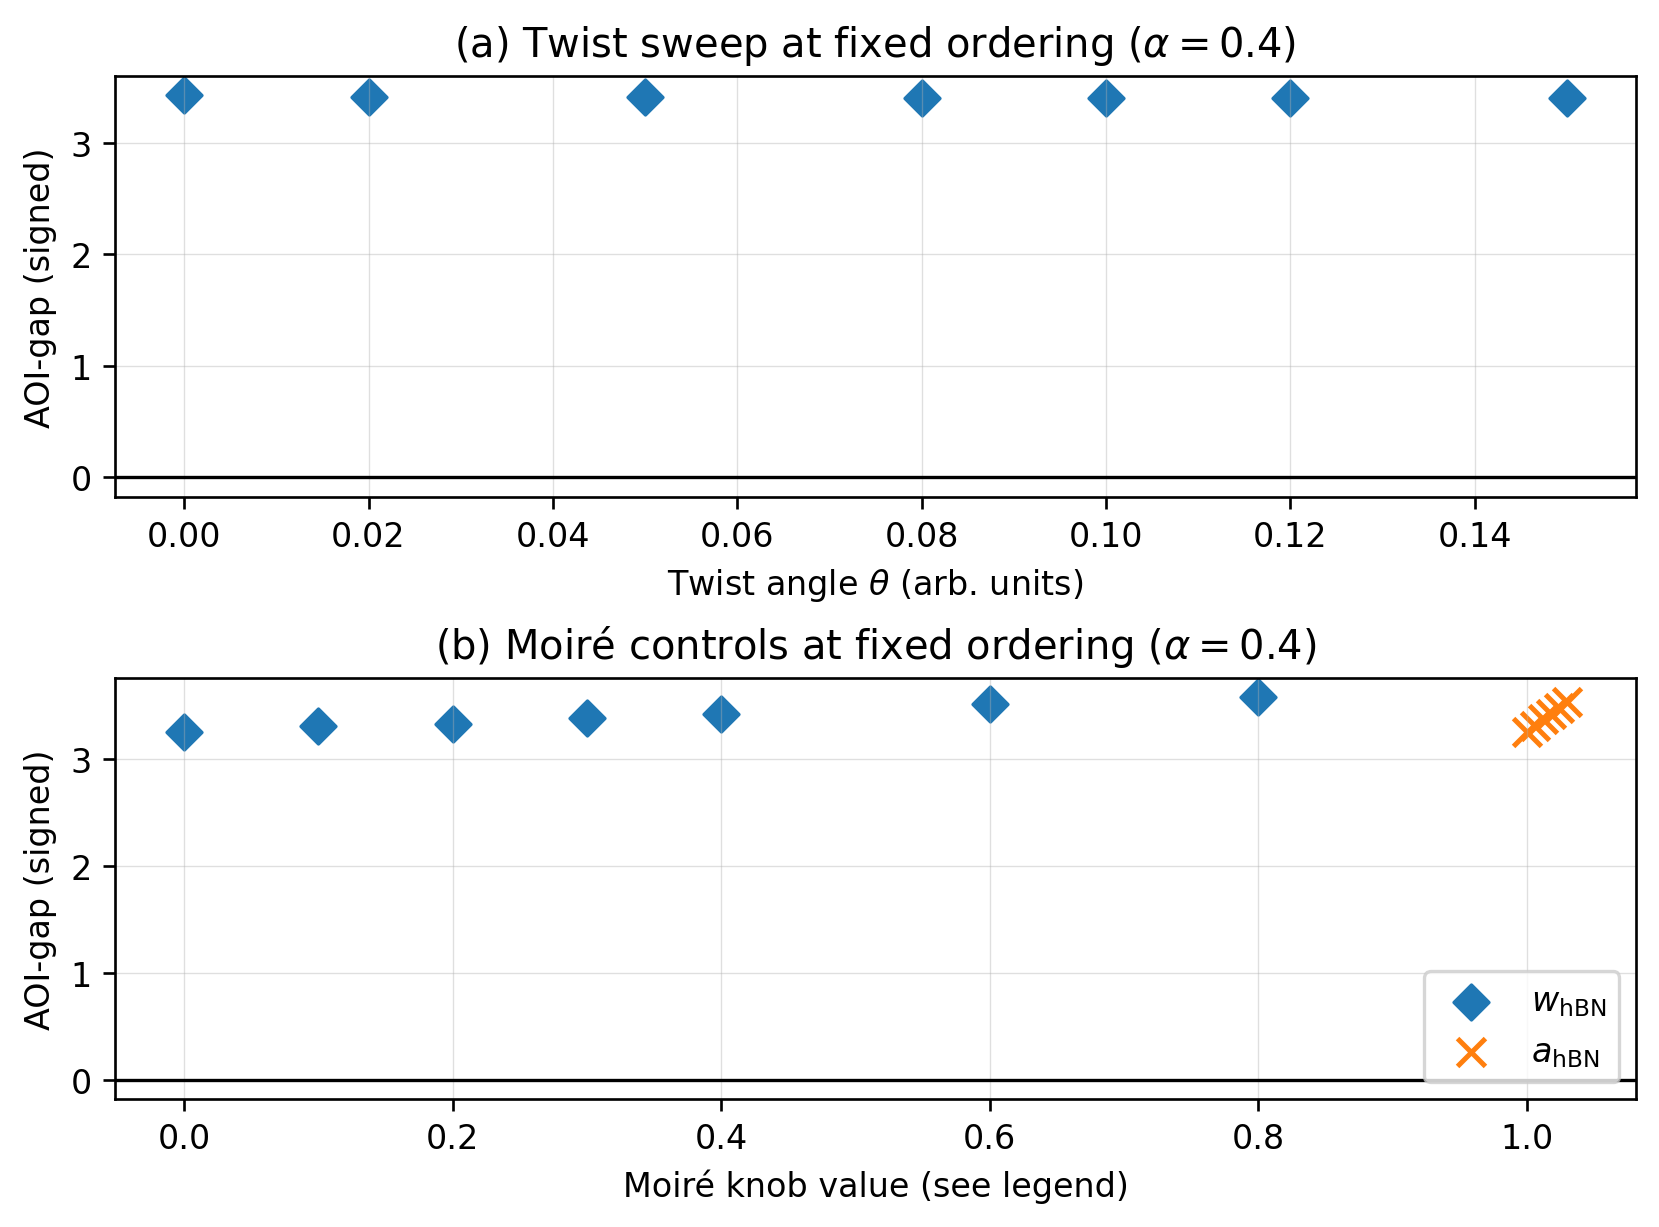

Saved: outputs/fig4.png


('outputs/paperC_fig4_structure_sweeps_alpha0p4.npz', 'outputs/fig4.png')

In [ ]:
import os
import inspect
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# Filter params to match your run_diracgate_AOI signature
# ----------------------------
def call_run_diracgate_AOI(params):
    sig = inspect.signature(run_diracgate_AOI)
    allowed = set(sig.parameters.keys())

    filtered = {k: v for k, v in params.items() if k in allowed}
    AOI_AB, AOI_BA = run_diracgate_AOI(**filtered)
    return float(AOI_AB), float(AOI_BA), filtered

def run_and_record(label, params):
    AOI_AB, AOI_BA, used = call_run_diracgate_AOI(params)
    rec = {
        "label": label,
        "AOI_AB": AOI_AB,
        "AOI_BA": AOI_BA,
        "AOI_gap": AOI_AB - AOI_BA,   # signed
    }
    # Keep any key knobs that exist (won't fail if absent)
    for k in ["alpha","theta","a_hbn","hbn_weight","p_thresh","T","Tsteps","seed","omega","V0","chi","a_g"]:
        if k in used:
            rec[k] = float(used[k]) if isinstance(used[k], (int,float,np.floating)) else used[k]
    return rec

def save_records_npz(path, records, meta):
    os.makedirs(os.path.dirname(path) or ".", exist_ok=True)
    np.savez_compressed(path, records=np.array(records, dtype=object), **meta)

def sort_xy(x, y):
    x = np.array(x, dtype=float)
    y = np.array(y, dtype=float)
    if x.size == 0:
        return x, y
    idx = np.argsort(x)
    return x[idx], y[idx]

def plot_fig4(records, out_png, alpha_fixed=0.4):
    theta, theta_gap = [], []
    w, w_gap = [], []
    ah, ah_gap = [], []

    for r in records:
        a = float(r.get("alpha", np.nan))
        if not np.isfinite(a) or abs(a - alpha_fixed) > 1e-12:
            continue
        lab = str(r.get("label",""))

        if lab.startswith("theta_") and "theta" in r:
            theta.append(float(r["theta"]))
            theta_gap.append(float(r["AOI_gap"]))
        if lab.startswith("hbn_weight_") and "hbn_weight" in r:
            w.append(float(r["hbn_weight"]))
            w_gap.append(float(r["AOI_gap"]))
        if lab.startswith("a_hbn_") and "a_hbn" in r:
            ah.append(float(r["a_hbn"]))
            ah_gap.append(float(r["AOI_gap"]))

    theta, theta_gap = sort_xy(theta, theta_gap)
    w, w_gap = sort_xy(w, w_gap)
    ah, ah_gap = sort_xy(ah, ah_gap)

    fig, axes = plt.subplots(2, 1, figsize=(6.8, 5.0), dpi=240, constrained_layout=True)

    ax = axes[0]
    if theta.size > 0:
        ax.scatter(theta, theta_gap, marker="D", s=55, color="tab:blue")
    ax.axhline(0.0, linewidth=1.0, color="black")
    ax.set_title(rf"(a) Twist sweep at fixed ordering ($\alpha={alpha_fixed:g}$)")
    ax.set_xlabel(r"Twist angle $\theta$ (arb. units)")
    ax.set_ylabel("AOI-gap (signed)")
    ax.grid(True, linewidth=0.4, alpha=0.4)

    ax = axes[1]
    plotted_any = False
    if w.size > 0:
        ax.scatter(w, w_gap, marker="D", s=55, color="tab:blue", label=r"$w_{\mathrm{hBN}}$")
        plotted_any = True
    if ah.size > 0:
        ax.scatter(ah, ah_gap, marker="x", s=70, color="tab:orange", label=r"$a_{\mathrm{hBN}}$")
        plotted_any = True
    if plotted_any:
        ax.legend(loc="lower right", frameon=True)

    ax.axhline(0.0, linewidth=1.0, color="black")
    ax.set_title(rf"(b) Moiré controls at fixed ordering ($\alpha={alpha_fixed:g}$)")
    ax.set_xlabel(r"Moiré knob value (see legend)")
    ax.set_ylabel("AOI-gap (signed)")
    ax.grid(True, linewidth=0.4, alpha=0.4)

    plt.savefig(out_png, bbox_inches="tight")
    plt.show()
    print("Saved:", out_png)

def run_paperC_sweeps_and_fig4(
    outdir="outputs",
    npz_name="paperC_fig4_structure_sweeps_alpha0p4.npz",
    png_name="fig4.png",
    alpha_fixed=0.4,
    p_thresh=0.7,
    T=160,
    a_hbn_base=1.018,
    hbn_weight_base=0.4,
    theta_list=(0.0, 0.02, 0.05, 0.08, 0.10, 0.12, 0.15),
    hbn_weight_list=(0.0, 0.1, 0.2, 0.3, 0.4, 0.6, 0.8),
    a_hbn_list=(1.000, 1.006, 1.012, 1.018, 1.024, 1.030),
):
    os.makedirs(outdir, exist_ok=True)
    out_npz = os.path.join(outdir, npz_name)
    out_png = os.path.join(outdir, png_name)

    # Minimal base params matching what your printouts showed (theta, a_hbn, hbn_weight, alpha, p_thresh, T)
    base = dict(
        theta=0.0,
        a_hbn=a_hbn_base,
        hbn_weight=hbn_weight_base,
        alpha=alpha_fixed,
        p_thresh=p_thresh,
        T=T,
    )

    records = []
    records.append(run_and_record("baseline", base))

    for th in theta_list:
        params = dict(base); params["theta"] = float(th)
        records.append(run_and_record(f"theta_{th}", params))

    for w in hbn_weight_list:
        params = dict(base); params["hbn_weight"] = float(w)
        records.append(run_and_record(f"hbn_weight_{w}", params))

    for ah in a_hbn_list:
        params = dict(base); params["a_hbn"] = float(ah)
        records.append(run_and_record(f"a_hbn_{ah}", params))

    meta = dict(alpha_fixed=float(alpha_fixed), p_thresh=float(p_thresh), T=int(T),
                a_hbn_base=float(a_hbn_base), hbn_weight_base=float(hbn_weight_base))
    save_records_npz(out_npz, records, meta)
    print("Saved:", out_npz)

    print("\n=== Fig4 sweeps (alpha fixed) ===")
    for r in records:
        th = r.get("theta", np.nan)
        ah = r.get("a_hbn", np.nan)
        ww = r.get("hbn_weight", np.nan)
        print(f"{r['label']:18s} | theta={th!s:>6} a_hbn={ah!s:>7} w={ww!s:>6} | AOI-gap={r['AOI_gap']:.4f}")

    plot_fig4(records, out_png, alpha_fixed=alpha_fixed)
    return out_npz, out_png

# RUN
run_paperC_sweeps_and_fig4()

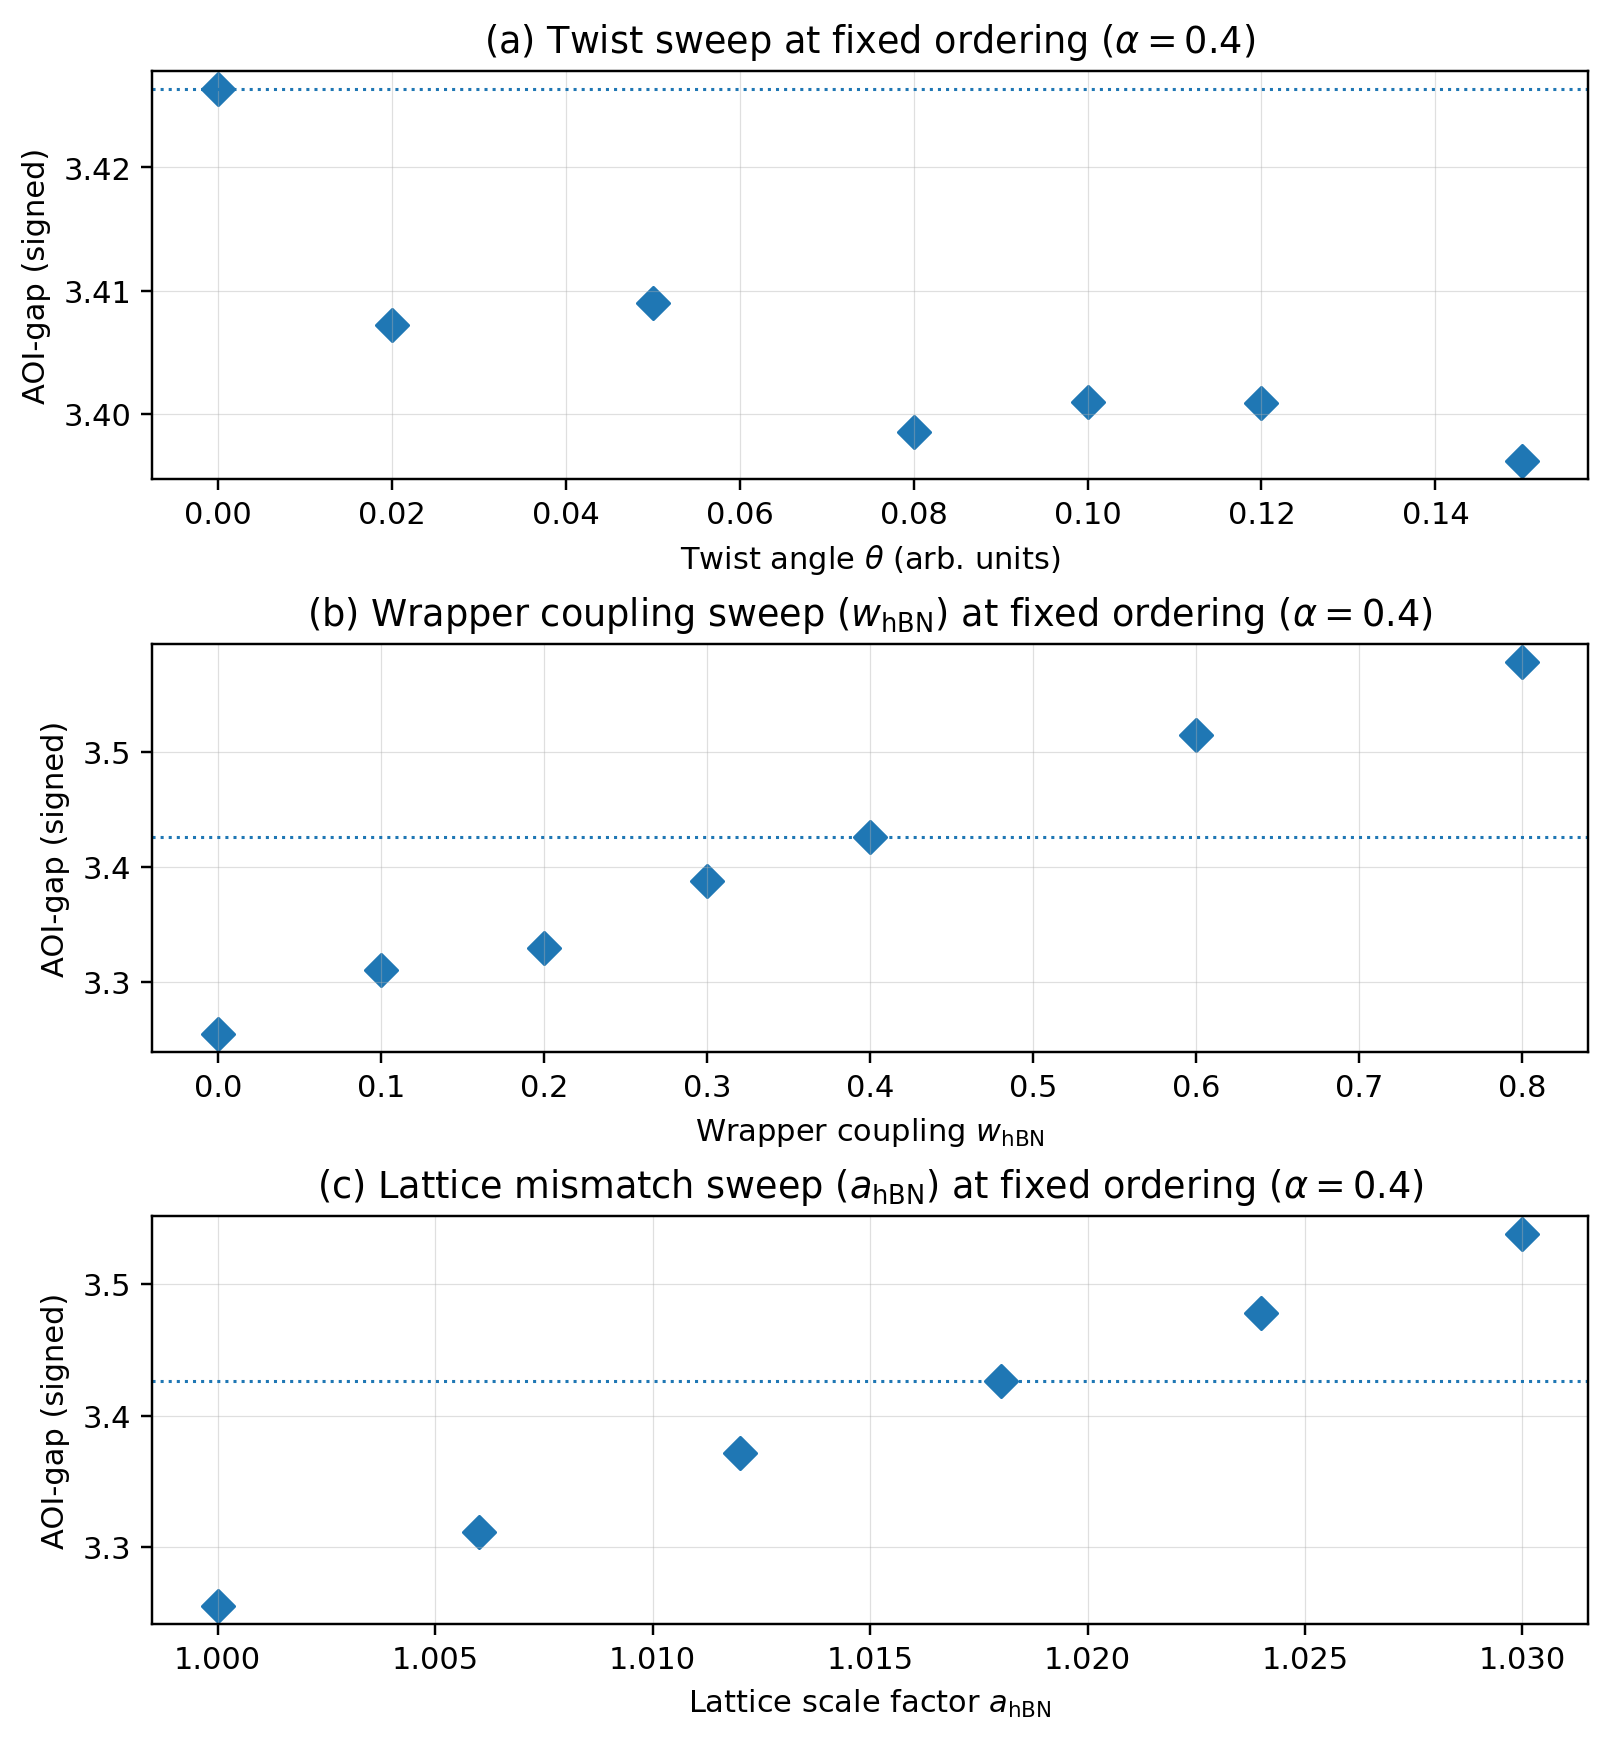

Saved: outputs/fig4.png


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

def load_fig4_records(npz_path):
    D = np.load(npz_path, allow_pickle=True)
    if "records" not in D.files:
        raise KeyError(f"Expected key 'records' in NPZ. Found keys: {D.files}")
    recs = D["records"]
    if isinstance(recs, np.ndarray):
        recs = list(recs)

    out = []
    for r in recs:
        if isinstance(r, np.ndarray) and r.shape == ():
            r = r.item()
        elif hasattr(r, "item") and not isinstance(r, dict):
            try:
                r = r.item()
            except Exception:
                pass
        out.append(r)
    return out

def split_sweeps(records):
    theta = []
    w = []
    a = []
    base = None

    for r in records:
        lab = str(r.get("label", ""))
        gap = float(r.get("AOI_gap", r.get("AOI-gap", r.get("gap", np.nan))))
        th = float(r.get("theta", np.nan))
        ww = float(r.get("hbn_weight", r.get("w", np.nan)))
        ah = float(r.get("a_hbn", np.nan))

        if lab == "baseline":
            base = (th, ww, ah, gap)

        if lab.startswith("theta_"):
            theta.append((th, gap))
        elif lab.startswith("hbn_weight_"):
            w.append((ww, gap))
        elif lab.startswith("a_hbn_"):
            a.append((ah, gap))

    theta = sorted(theta, key=lambda x: x[0])
    w = sorted(w, key=lambda x: x[0])
    a = sorted(a, key=lambda x: x[0])
    return base, theta, w, a

def make_fig4_three_panels(
    npz_path="outputs/paperC_fig4_structure_sweeps_alpha0p4.npz",
    out_png="outputs/fig4.png",
    alpha_fixed=0.4,
):
    records = load_fig4_records(npz_path)
    base, theta_sweep, w_sweep, a_sweep = split_sweeps(records)

    base_gap = base[3] if base is not None else None

    os.makedirs(os.path.dirname(out_png) or ".", exist_ok=True)

    fig, axes = plt.subplots(3, 1, figsize=(7.2, 7.8), dpi=220, constrained_layout=True)

    # (a) theta
    ax = axes[0]
    if len(theta_sweep) == 0:
        ax.text(0.5, 0.5, "No theta sweep records found", ha="center", va="center")
    else:
        x = [p[0] for p in theta_sweep]
        y = [p[1] for p in theta_sweep]
        ax.scatter(x, y, marker="D", s=55)
    if base_gap is not None:
        ax.axhline(base_gap, linestyle=":", linewidth=1.0)
    ax.set_title(rf"(a) Twist sweep at fixed ordering ($\alpha={alpha_fixed}$)")
    ax.set_xlabel(r"Twist angle $\theta$ (arb. units)")
    ax.set_ylabel("AOI-gap (signed)")
    ax.grid(True, linewidth=0.4, alpha=0.4)

    # (b) w_hBN
    ax = axes[1]
    if len(w_sweep) == 0:
        ax.text(0.5, 0.5, "No hbn_weight sweep records found", ha="center", va="center")
    else:
        x = [p[0] for p in w_sweep]
        y = [p[1] for p in w_sweep]
        ax.scatter(x, y, marker="D", s=55)
    if base_gap is not None:
        ax.axhline(base_gap, linestyle=":", linewidth=1.0)
    ax.set_title(rf"(b) Wrapper coupling sweep ($w_{{\mathrm{{hBN}}}}$) at fixed ordering ($\alpha={alpha_fixed}$)")
    ax.set_xlabel(r"Wrapper coupling $w_{\mathrm{hBN}}$")
    ax.set_ylabel("AOI-gap (signed)")
    ax.grid(True, linewidth=0.4, alpha=0.4)

    # (c) a_hBN
    ax = axes[2]
    if len(a_sweep) == 0:
        ax.text(0.5, 0.5, "No a_hbn sweep records found", ha="center", va="center")
    else:
        x = [p[0] for p in a_sweep]
        y = [p[1] for p in a_sweep]
        ax.scatter(x, y, marker="D", s=55)
    if base_gap is not None:
        ax.axhline(base_gap, linestyle=":", linewidth=1.0)
    ax.set_title(rf"(c) Lattice mismatch sweep ($a_{{\mathrm{{hBN}}}}$) at fixed ordering ($\alpha={alpha_fixed}$)")
    ax.set_xlabel(r"Lattice scale factor $a_{\mathrm{hBN}}$")
    ax.set_ylabel("AOI-gap (signed)")
    ax.grid(True, linewidth=0.4, alpha=0.4)

    plt.savefig(out_png, bbox_inches="tight")
    plt.show()
    print("Saved:", out_png)

# RUN
make_fig4_three_panels(
    npz_path="outputs/paperC_fig4_structure_sweeps_alpha0p4.npz",
    out_png="outputs/fig4.png",
    alpha_fixed=0.4,
)

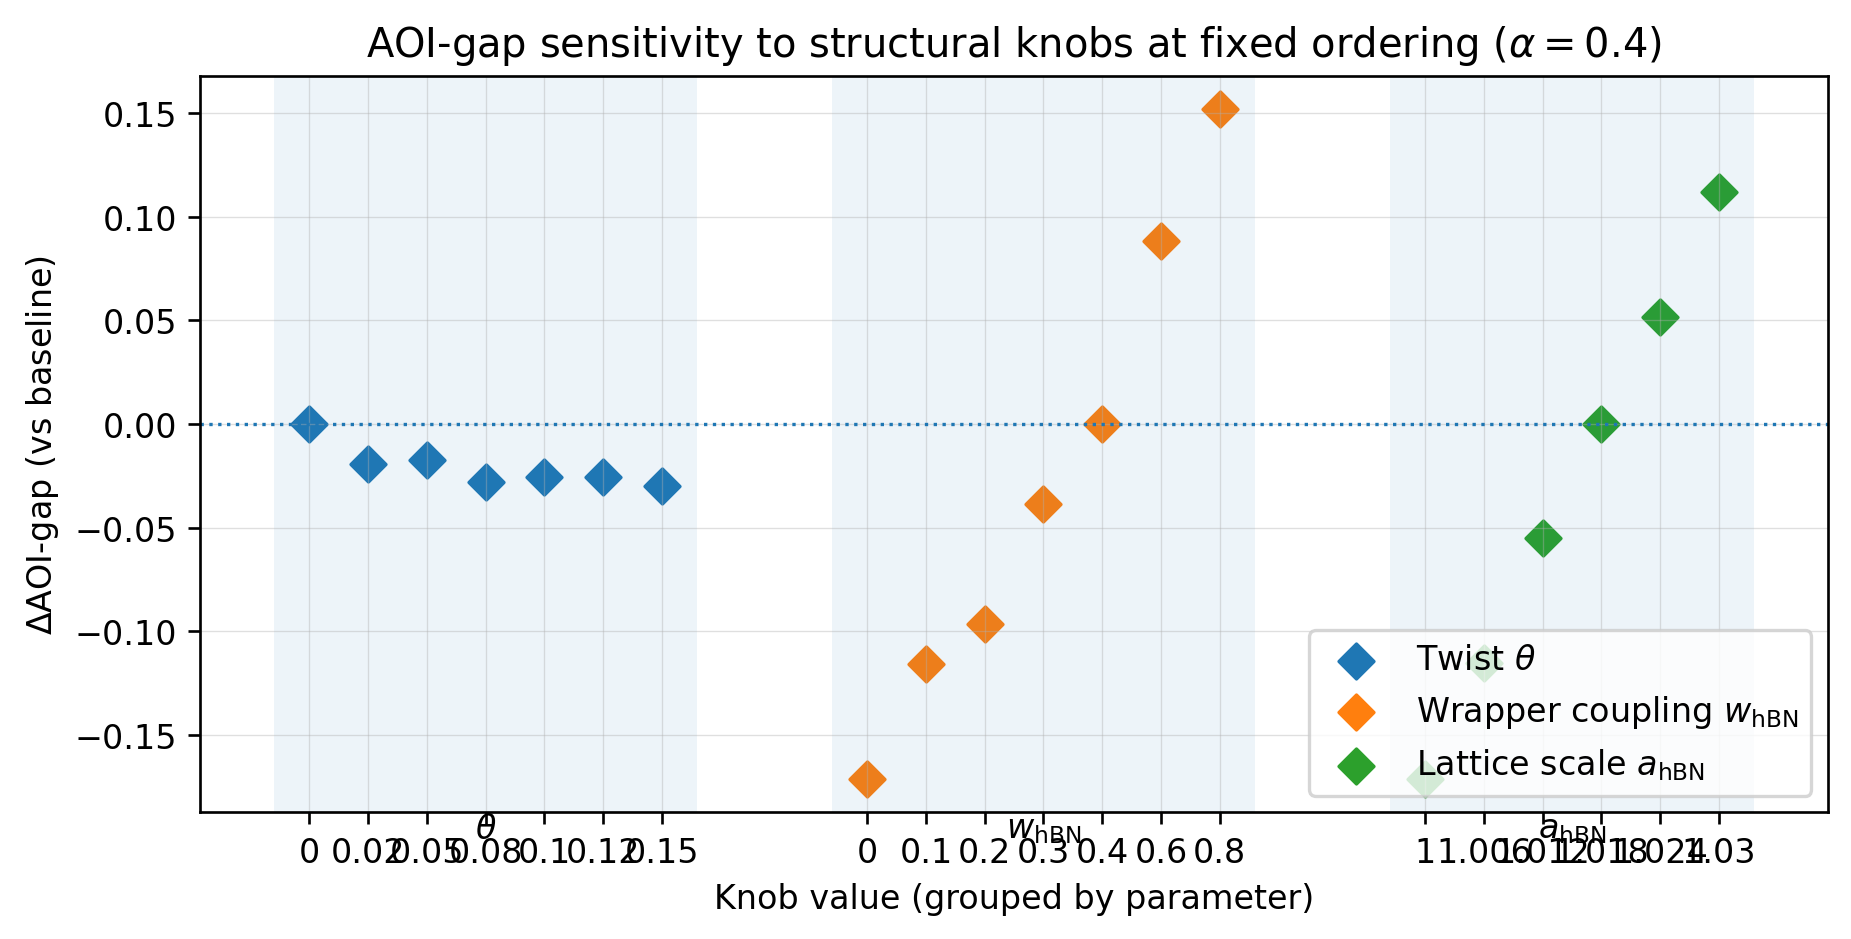

Saved: outputs/fig4_singlepanel_groups.png


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

def load_fig4_records(npz_path):
    D = np.load(npz_path, allow_pickle=True)
    if "records" not in D.files:
        raise KeyError(f"Expected key 'records' in NPZ. Found: {D.files}")
    recs = D["records"]
    if isinstance(recs, np.ndarray):
        recs = list(recs)

    out = []
    for r in recs:
        if isinstance(r, np.ndarray) and r.shape == ():
            r = r.item()
        elif hasattr(r, "item") and not isinstance(r, dict):
            try:
                r = r.item()
            except Exception:
                pass
        out.append(r)
    return out

def extract_sweeps(records):
    base = None
    theta = []
    w = []
    a = []

    for r in records:
        lab = str(r.get("label", ""))
        gap = float(r.get("AOI_gap", r.get("AOI-gap", r.get("gap", np.nan))))
        th = float(r.get("theta", np.nan))
        ww = float(r.get("hbn_weight", r.get("w", np.nan)))
        ah = float(r.get("a_hbn", np.nan))

        if lab == "baseline":
            base = dict(theta=th, w=ww, a_hbn=ah, gap=gap)

        if lab.startswith("theta_"):
            theta.append((th, gap))
        elif lab.startswith("hbn_weight_"):
            w.append((ww, gap))
        elif lab.startswith("a_hbn_"):
            a.append((ah, gap))

    theta = sorted(theta, key=lambda x: x[0])
    w = sorted(w, key=lambda x: x[0])
    a = sorted(a, key=lambda x: x[0])
    return base, theta, w, a

def fig4_single_panel_groups(
    npz_path="outputs/paperC_fig4_structure_sweeps_alpha0p4.npz",
    out_png="outputs/fig4_singlepanel_groups.png",
    alpha_fixed=0.4,
    show_delta=True,           # True = plot (gap - baseline); False = plot raw gap
):
    records = load_fig4_records(npz_path)
    base, theta_sweep, w_sweep, a_sweep = extract_sweeps(records)
    if base is None:
        raise ValueError("No 'baseline' record found in NPZ.")

    base_gap = float(base["gap"])

    os.makedirs(os.path.dirname(out_png) or ".", exist_ok=True)

    fig, ax = plt.subplots(1, 1, figsize=(7.6, 3.8), dpi=240, constrained_layout=True)

    # x positions (categorical groups)
    gap_between_groups = 2.5
    x0 = 0.0
    xs_theta = np.arange(len(theta_sweep)) + x0
    x1 = xs_theta[-1] + gap_between_groups + 1.0
    xs_w = np.arange(len(w_sweep)) + x1
    x2 = xs_w[-1] + gap_between_groups + 1.0
    xs_a = np.arange(len(a_sweep)) + x2

    def yvals(sweep):
        y = np.array([p[1] for p in sweep], dtype=float)
        return (y - base_gap) if show_delta else y

    y_theta = yvals(theta_sweep)
    y_w = yvals(w_sweep)
    y_a = yvals(a_sweep)

    # Plot: same marker everywhere so the *grouping* does the work
    ax.scatter(xs_theta, y_theta, marker="D", s=55, label=r"Twist $\theta$")
    ax.scatter(xs_w, y_w, marker="D", s=55, label=r"Wrapper coupling $w_{\mathrm{hBN}}$")
    ax.scatter(xs_a, y_a, marker="D", s=55, label=r"Lattice scale $a_{\mathrm{hBN}}$")

    # Baseline reference
    ax.axhline(0.0 if show_delta else base_gap, linestyle=":", linewidth=1.0)

    # Group background shading (faint zones)
    def shade(x_left, x_right, alpha=0.08):
        ax.axvspan(x_left, x_right, alpha=alpha)

    shade(xs_theta[0]-0.6, xs_theta[-1]+0.6)
    shade(xs_w[0]-0.6, xs_w[-1]+0.6)
    shade(xs_a[0]-0.6, xs_a[-1]+0.6)

    # X tick labels: show actual knob values (short, readable)
    ticks = []
    ticklabels = []

    # theta ticks
    for i, (th, _) in enumerate(theta_sweep):
        ticks.append(xs_theta[i])
        ticklabels.append(f"{th:g}")
    # w ticks
    for i, (ww, _) in enumerate(w_sweep):
        ticks.append(xs_w[i])
        ticklabels.append(f"{ww:g}")
    # a ticks
    for i, (ah, _) in enumerate(a_sweep):
        ticks.append(xs_a[i])
        ticklabels.append(f"{ah:.3f}".rstrip("0").rstrip("."))

    ax.set_xticks(ticks)
    ax.set_xticklabels(ticklabels, rotation=0)

    # Put group names under the axis
    ax.text(xs_theta.mean(), ax.get_ylim()[0], r"$\theta$", ha="center", va="top")
    ax.text(xs_w.mean(), ax.get_ylim()[0], r"$w_{\mathrm{hBN}}$", ha="center", va="top")
    ax.text(xs_a.mean(), ax.get_ylim()[0], r"$a_{\mathrm{hBN}}$", ha="center", va="top")

    ax.set_title(rf"AOI-gap sensitivity to structural knobs at fixed ordering ($\alpha={alpha_fixed}$)")
    ax.set_xlabel("Knob value (grouped by parameter)")
    ax.set_ylabel(r"$\Delta$AOI-gap (vs baseline)" if show_delta else "AOI-gap (signed)")
    ax.grid(True, linewidth=0.4, alpha=0.4)
    ax.legend(loc="lower right", frameon=True)

    plt.savefig(out_png, bbox_inches="tight")
    plt.show()
    print("Saved:", out_png)

# RUN
fig4_single_panel_groups(
    npz_path="outputs/paperC_fig4_structure_sweeps_alpha0p4.npz",
    out_png="outputs/fig4_singlepanel_groups.png",
    alpha_fixed=0.4,
    show_delta=True,
)

In [ ]:
import inspect
print(inspect.signature(run_diracgate_AOI))
print("\nArgs:")
for k,v in inspect.signature(run_diracgate_AOI).parameters.items():
    print(" ", k, "=", v.default)

(theta=0.0, a_hbn=1.018, hbn_weight=0.4, alpha=0.8, p_thresh=0.7, T=160, seed=0)

Args:
  theta = 0.0
  a_hbn = 1.018
  hbn_weight = 0.4
  alpha = 0.8
  p_thresh = 0.7
  T = 160
  seed = 0


chirality  lam_chi=  0.0 | AOI-gap=-0.0384 | R=1.3362
chirality  lam_chi=  0.2 | AOI-gap=+0.3073 | R=1.4453
chirality  lam_chi=  0.4 | AOI-gap=+0.2175 | R=1.5583
chirality  lam_chi=  0.6 | AOI-gap=+0.5615 | R=1.8709
chirality  lam_chi=  0.8 | AOI-gap=+1.1193 | R=2.4578
viscosity  lam_nu=  0.0 | AOI-gap=-0.0384 | R=1.3362
viscosity  lam_nu=  1.0 | AOI-gap=+0.0089 | R=1.3373
viscosity  lam_nu=  2.0 | AOI-gap=+0.0064 | R=1.3556
viscosity  lam_nu=  3.0 | AOI-gap=+0.0256 | R=1.3609
viscosity  lam_nu=  4.0 | AOI-gap=+0.0642 | R=1.3771
momentum   lam_m=  0.0 | AOI-gap=-0.0384 | R=1.3362
momentum   lam_m= 0.25 | AOI-gap=-0.0384 | R=1.3362
momentum   lam_m=  0.5 | AOI-gap=-0.0384 | R=1.3362
momentum   lam_m= 0.75 | AOI-gap=-0.0384 | R=1.3362
momentum   lam_m=  1.0 | AOI-gap=-0.0384 | R=1.3362
imbalance  lam_delta=  0.0 | AOI-gap=-0.0384 | R=1.3362
imbalance  lam_delta= 0.02 | AOI-gap=+0.3488 | R=1.3818
imbalance  lam_delta= 0.05 | AOI-gap=+0.3401 | R=1.4731
imbalance  lam_delta= 0.08 | AOI-gap=

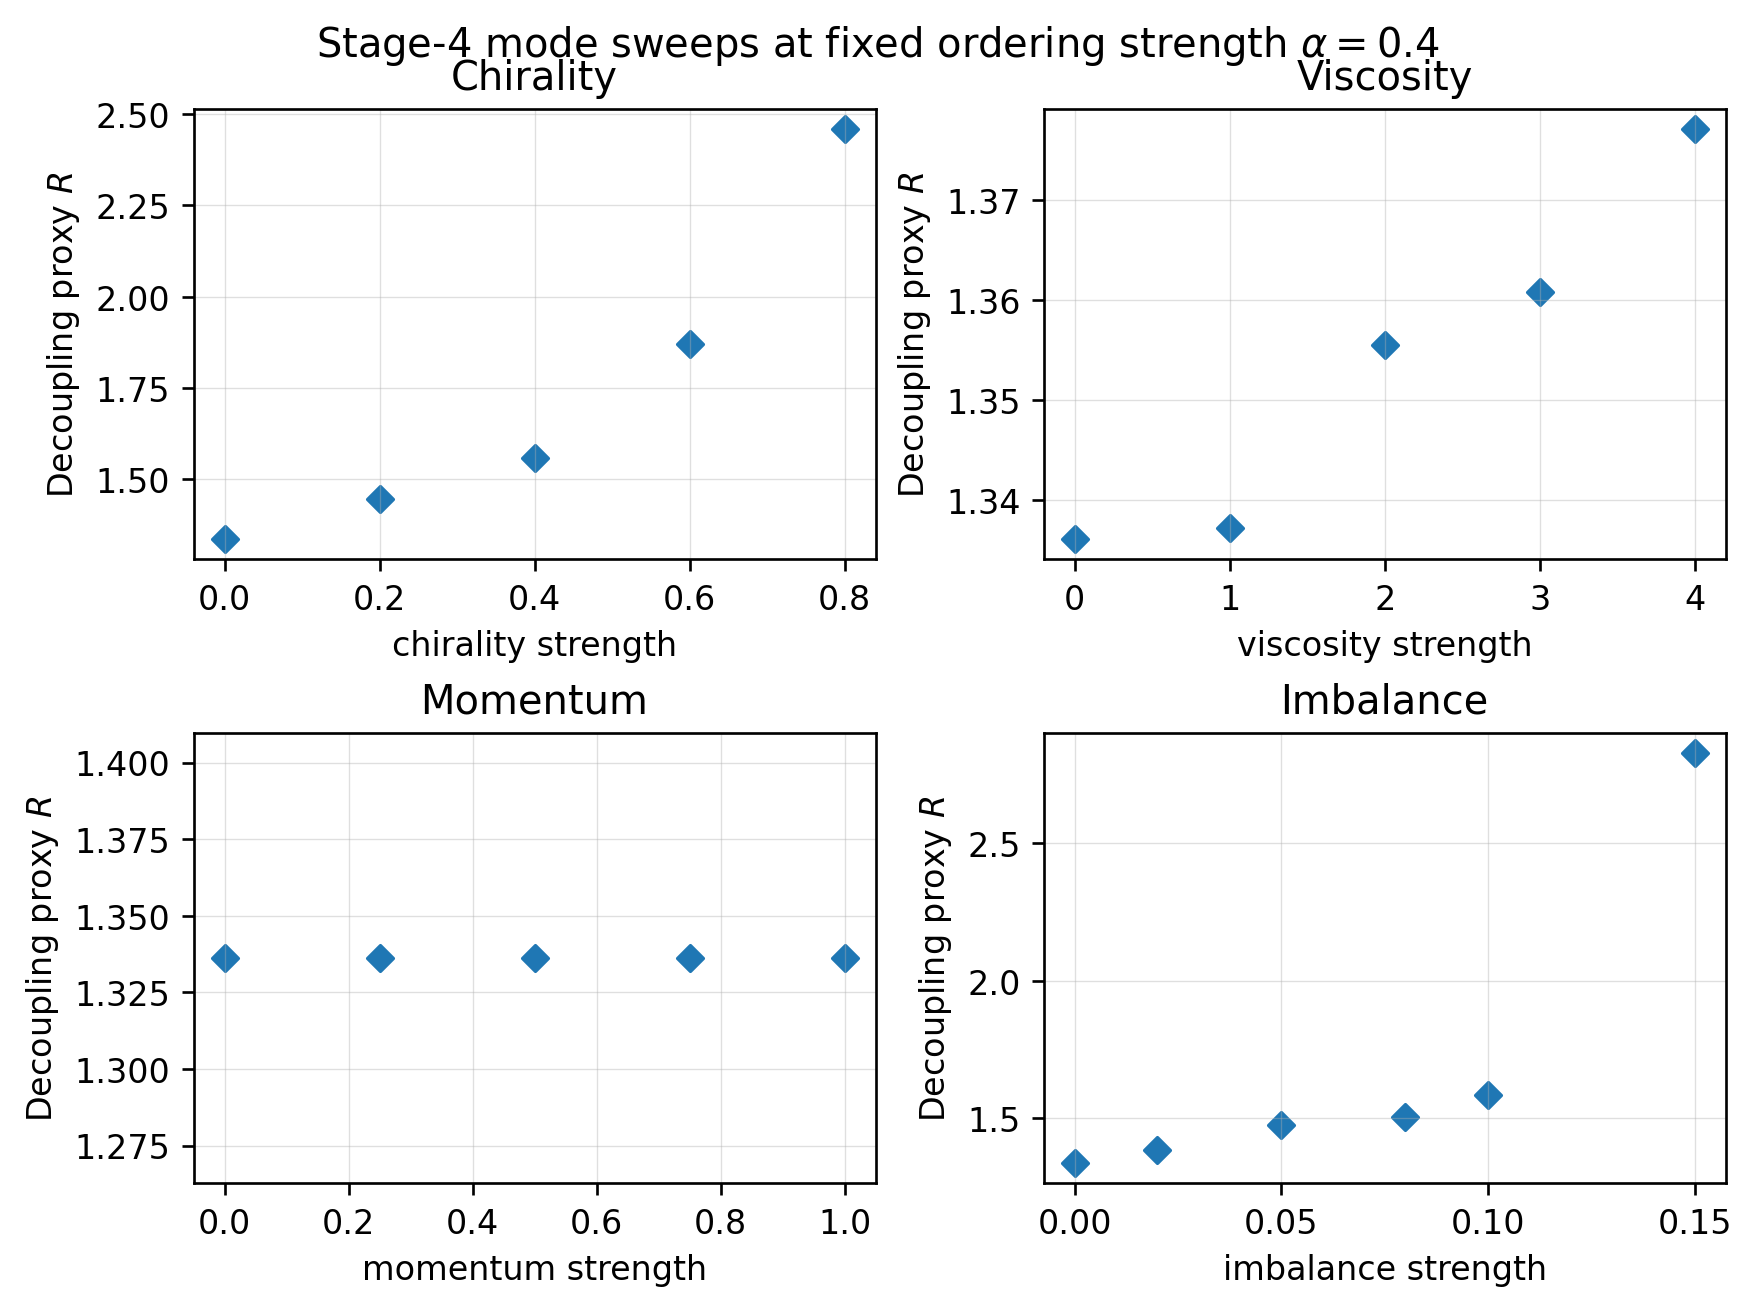

Saved: outputs/fig5.png


('outputs/paperC_stage4_sweeps_alpha0p4.npz', 'outputs/fig5.png')

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# Core utilities
# ============================================================
def sigmoid(kappa, x):
    z = np.clip(-kappa * x, -60.0, 60.0)
    return 1.0 / (1.0 + np.exp(z))

def run_channel(V, kappa, Vc):
    return sigmoid(kappa, V - Vc)

def aoi_positive_area(x):
    y = np.maximum(x - np.mean(x), 0.0)
    return float(np.trapezoid(y))

def blur_2d(field, passes=1):
    """
    Minimal "viscosity" proxy: repeated 5-point stencil smoothing on a 2D grid.
    No scipy dependency.
    """
    A = field.copy()
    for _ in range(int(passes)):
        A = 0.6*A + 0.1*(np.roll(A, 1, 0) + np.roll(A, -1, 0) + np.roll(A, 1, 1) + np.roll(A, -1, 1))
    return A

def make_base_fields(Nx, Ny, seed=0):
    """
    Construct a simple graphene-like base field on a 2D torus (periodic).
    We keep this intentionally minimal, consistent with the toy layer.
    """
    rng = np.random.default_rng(seed)
    x = np.linspace(0, 2*np.pi, Nx, endpoint=False)
    y = np.linspace(0, 2*np.pi, Ny, endpoint=False)
    X, Y = np.meshgrid(x, y, indexing="ij")

    # Base: two-wave superposition (more 2D than cos(x) alone)
    V0 = np.cos(X) + 0.7*np.cos(Y)

    # A chiral-ish mode (odd under inversion-ish): sin combos
    Vchi = np.sin(2*X) - 0.6*np.sin(2*Y)

    # A "momentum / advection" mode template: we implement via shifts in time, not as fixed V-field
    # Still return something to document the template
    Vm = np.cos(X + Y)

    # An "imbalance" template; implemented as channel bias, not as a field
    Vdelta = np.ones_like(V0)

    return V0, Vchi, Vm, Vdelta

def build_time_field(
    V0_2d,
    Vchi_2d,
    lam_chi=0.0,
    lam_nu=0.0,
    lam_m=0.0,
    t=0,
    omega=0.8,
):
    """
    Construct V(r,t) with four provisional modes:
      - chirality: add lam_chi * Vchi
      - viscosity: blur passes ~ lam_nu
      - momentum/advection: shift the entire field by integer pixels ~ lam_m each step
    """
    V = V0_2d + lam_chi * Vchi_2d

    # momentum/advection as discrete drift (periodic torus)
    if lam_m != 0.0:
        shift = int(np.round(lam_m * t))
        V = np.roll(V, shift=shift, axis=1)  # drift along y

    # simple periodic drive
    drive = (1.0 + 0.25*np.cos(omega*t))
    V = drive * V

    # viscosity/smoothing: integer blur passes
    if lam_nu != 0.0:
        passes = int(np.round(lam_nu))
        if passes > 0:
            V = blur_2d(V, passes=passes)

    return V

# ============================================================
# DiracGate runner: AB vs BA, plus channel-specific imbalance
# ============================================================
def run_diracgate_AB_BA_timeseries(
    Nx=23, Ny=23,
    T=160,
    omega=0.8,
    charge_params=(2.4, 0.0),
    heat_params=(1.0, -0.15),
    p_thresh=0.7,
    alpha=0.4,
    lam_chi=0.0,     # chirality mode weight
    lam_nu=0.0,      # viscosity mode (blur passes)
    lam_m=0.0,       # momentum/advection (pixel drift rate)
    lam_delta=0.0,   # imbalance (channel bias)
    seed=0,
):
    V0_2d, Vchi_2d, Vm_2d, Vdelta_2d = make_base_fields(Nx, Ny, seed=seed)

    kC, VcC = charge_params
    kH, VcH = heat_params

    # imbalance: applied as channel-specific bias to the field (not the threshold)
    # C sees +delta, H sees -delta
    # (this is provisional, but stable and interpretable)
    delta = float(lam_delta)

    def schedule(order):
        rC = np.zeros(T, dtype=float)
        rH = np.zeros(T, dtype=float)

        for t in range(T):
            Vt = build_time_field(
                V0_2d=V0_2d,
                Vchi_2d=Vchi_2d,
                lam_chi=lam_chi,
                lam_nu=lam_nu,
                lam_m=lam_m,
                t=t,
                omega=omega,
            )

            # flatten for channel computations (your earlier style)
            Vflat = Vt.reshape(-1)

            if order == "AB":
                # A: charge reads V (with its bias)
                pC = run_channel(Vflat + delta, kC, VcC)

                # write-back on what heat sees
                Vflat2 = Vflat - alpha*(pC - pC.mean())

                # B: heat reads modified V (with opposite bias)
                pH = run_channel(Vflat2 - delta, kH, VcH)

            else:  # "BA"
                pH = run_channel(Vflat - delta, kH, VcH)
                Vflat2 = Vflat - alpha*(pH - pH.mean())
                pC = run_channel(Vflat2 + delta, kC, VcC)

            rC[t] = float(np.mean(pC > p_thresh))
            rH[t] = float(np.mean(pH > p_thresh))

        return rC, rH

    rC_AB, rH_AB = schedule("AB")
    rC_BA, rH_BA = schedule("BA")

    # AOI on channel-difference trajectories
    AOI_AB = aoi_positive_area(rC_AB - rH_AB)
    AOI_BA = aoi_positive_area(rC_BA - rH_BA)

    out = dict(
        rC_AB=rC_AB, rH_AB=rH_AB, rC_BA=rC_BA, rH_BA=rH_BA,
        AOI_AB=float(AOI_AB),
        AOI_BA=float(AOI_BA),
        AOI_gap_signed=float(AOI_AB - AOI_BA),
        AOI_gap_L1=float(abs(AOI_AB - AOI_BA)),
        # optional: instantaneous integrand
        d_t=(rC_AB - rH_AB) - (rC_BA - rH_BA),
        params=dict(
            Nx=int(Nx), Ny=int(Ny), T=int(T), omega=float(omega),
            charge_params=tuple(charge_params),
            heat_params=tuple(heat_params),
            p_thresh=float(p_thresh),
            alpha=float(alpha),
            lam_chi=float(lam_chi),
            lam_nu=float(lam_nu),
            lam_m=float(lam_m),
            lam_delta=float(lam_delta),
            seed=int(seed),
        ),
    )
    return out

def summarize_decoupling(out):
    """
    Provisional decoupling ratio R:
      R = (AOI_H_total)/(AOI_C_total) is not directly accessible from AOI_AB on (C-H) difference.
    So instead we form *channel AOIs* using the same AOI functional applied to rC and rH separately.
    This gives an interpretable "relative accessibility amplification" proxy.
    """
    rC_AB = out["rC_AB"]; rC_BA = out["rC_BA"]
    rH_AB = out["rH_AB"]; rH_BA = out["rH_BA"]

    aC = aoi_positive_area(rC_AB) + aoi_positive_area(rC_BA)
    aH = aoi_positive_area(rH_AB) + aoi_positive_area(rH_BA)

    # avoid divide-by-zero
    R = float(aH / (aC + 1e-12))
    return float(aC), float(aH), float(R)

# ============================================================
# Stage-4 sweeps: one knob at a time at fixed alpha
# ============================================================
def run_stage4_sweeps_and_fig5(
    outdir="outputs",
    npz_name="paperC_stage4_sweeps_alpha0p4.npz",
    png_name="fig5.png",
    alpha=0.4,
    T=160,
    p_thresh=0.7,
    seed=0,
):
    os.makedirs(outdir, exist_ok=True)

    # Baseline params (matches your current Paper C regime)
    base = dict(
        Nx=23, Ny=23, T=T, omega=0.8,
        charge_params=(2.4, 0.0),
        heat_params=(1.0, -0.15),
        p_thresh=p_thresh,
        alpha=alpha,
        lam_chi=0.0,
        lam_nu=0.0,
        lam_m=0.0,
        lam_delta=0.0,
        seed=seed,
    )

    sweeps = []

    # chirality sweep
    for v in [0.0, 0.2, 0.4, 0.6, 0.8]:
        P = dict(base); P["lam_chi"] = v
        sweeps.append(("chirality", "lam_chi", v, P))

    # viscosity sweep (integer blur passes; keep it small)
    for v in [0.0, 1.0, 2.0, 3.0, 4.0]:
        P = dict(base); P["lam_nu"] = v
        sweeps.append(("viscosity", "lam_nu", v, P))

    # momentum sweep (pixel drift rate)
    for v in [0.0, 0.25, 0.5, 0.75, 1.0]:
        P = dict(base); P["lam_m"] = v
        sweeps.append(("momentum", "lam_m", v, P))

    # imbalance sweep (channel bias)
    for v in [0.0, 0.02, 0.05, 0.08, 0.10, 0.15]:
        P = dict(base); P["lam_delta"] = v
        sweeps.append(("imbalance", "lam_delta", v, P))

    records = []
    for group, key, val, P in sweeps:
        out = run_diracgate_AB_BA_timeseries(**P)
        aC, aH, R = summarize_decoupling(out)
        rec = dict(
            group=group,
            key=key,
            value=float(val),
            AOI_AB=float(out["AOI_AB"]),
            AOI_BA=float(out["AOI_BA"]),
            AOI_gap=float(out["AOI_gap_signed"]),
            AOI_gap_L1=float(out["AOI_gap_L1"]),
            AOI_C_total=float(aC),
            AOI_H_total=float(aH),
            R=float(R),
            params=out["params"],
        )
        records.append(rec)
        print(f"{group:10s} {key}={val:>5} | AOI-gap={rec['AOI_gap']:+.4f} | R={rec['R']:.4f}")

    # Save
    npz_path = os.path.join(outdir, npz_name)
    np.savez_compressed(
        npz_path,
        records=np.array(records, dtype=object),
        meta=dict(alpha=float(alpha), T=int(T), p_thresh=float(p_thresh), seed=int(seed)),
    )
    print("Saved:", npz_path)

    # ============================================================
    # Fig 5: R vs knob value, separate panels per group
    # ============================================================
    groups = ["chirality", "viscosity", "momentum", "imbalance"]
    fig, axes = plt.subplots(2, 2, figsize=(7.2, 5.2), dpi=240, constrained_layout=True)
    axes = axes.ravel()

    for ax, g in zip(axes, groups):
        G = [r for r in records if r["group"] == g]
        G = sorted(G, key=lambda r: r["value"])
        xs = np.array([r["value"] for r in G], dtype=float)
        ys = np.array([r["R"] for r in G], dtype=float)

        ax.scatter(xs, ys, marker="D", s=30)
        ax.set_title(g.capitalize())
        ax.set_xlabel(g + " strength")
        ax.set_ylabel(r"Decoupling proxy $R$")

        # light grid
        ax.grid(True, linewidth=0.4, alpha=0.4)

    # overall title
    fig.suptitle(rf"Stage-4 mode sweeps at fixed ordering strength $\alpha={alpha:g}$", y=1.02, fontsize=12)

    png_path = os.path.join(outdir, png_name)
    plt.savefig(png_path, bbox_inches="tight")
    plt.show()
    print("Saved:", png_path)

    return npz_path, png_path

# ============================================================
# RUN Stage-4 sweeps + Fig5
# ============================================================
run_stage4_sweeps_and_fig5(
    outdir="outputs",
    npz_name="paperC_stage4_sweeps_alpha0p4.npz",
    png_name="fig5.png",
    alpha=0.4,
    T=160,
    p_thresh=0.7,
    seed=0,
)

chirality  lam_chi=  0.0 | AOI-gap=-0.3786 | R=2.3134
chirality  lam_chi=  0.2 | AOI-gap=+0.6135 | R=1.3160
chirality  lam_chi=  0.4 | AOI-gap=+0.0634 | R=1.7573
chirality  lam_chi=  0.6 | AOI-gap=+1.0102 | R=2.4967
chirality  lam_chi=  0.8 | AOI-gap=-0.1913 | R=3.9407
viscosity  lam_nu=  0.0 | AOI-gap=-0.3786 | R=2.3134
viscosity  lam_nu=  1.0 | AOI-gap=-0.3085 | R=2.3276
viscosity  lam_nu=  2.0 | AOI-gap=-0.2899 | R=2.3248
viscosity  lam_nu=  3.0 | AOI-gap=-0.2311 | R=2.3156
viscosity  lam_nu=  4.0 | AOI-gap=-0.1167 | R=2.3704
momentum   lam_m=  0.0 | AOI-gap=-0.3786 | R=2.3134
momentum   lam_m=  0.1 | AOI-gap=-0.1928 | R=1.1753
momentum   lam_m= 0.25 | AOI-gap=-0.3559 | R=1.2133
momentum   lam_m=  0.5 | AOI-gap=-0.2663 | R=1.2967
momentum   lam_m= 0.75 | AOI-gap=-0.4708 | R=1.2845
momentum   lam_m=  1.0 | AOI-gap=-0.1230 | R=1.0463
imbalance  lam_delta=  0.0 | AOI-gap=-0.3786 | R=2.3134
imbalance  lam_delta= 0.02 | AOI-gap=-0.2366 | R=1.8842
imbalance  lam_delta= 0.05 | AOI-gap=+0.0

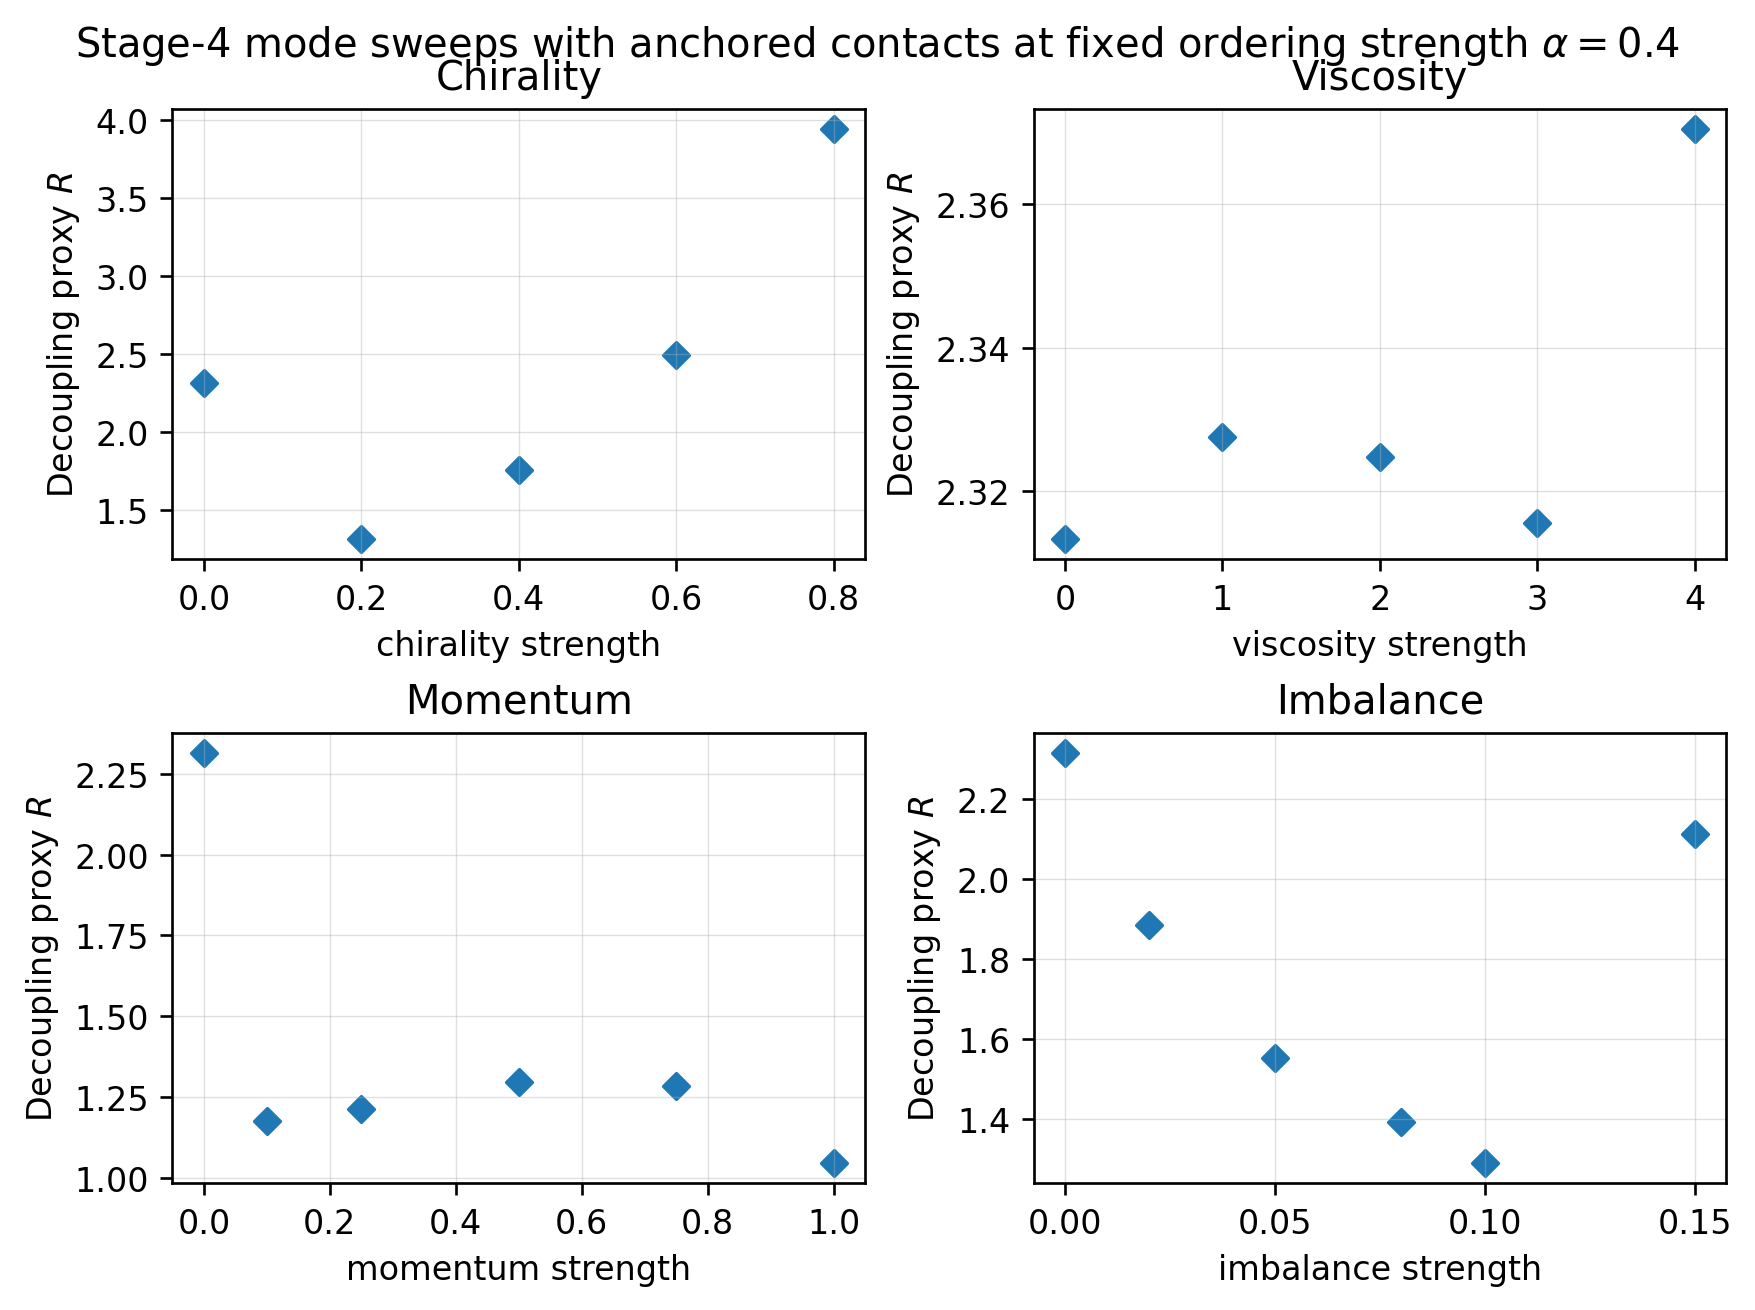

Saved: outputs/fig5_contacts.png


('outputs/paperC_stage4_sweeps_alpha0p4_contacts.npz',
 'outputs/fig5_contacts.png')

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(kappa, x):
    z = np.clip(-kappa * x, -60.0, 60.0)
    return 1.0 / (1.0 + np.exp(z))

def run_channel(V, kappa, Vc):
    return sigmoid(kappa, V - Vc)

def aoi_positive_area(x):
    y = np.maximum(x - np.mean(x), 0.0)
    return float(np.trapezoid(y))

def blur_2d(field, passes=1):
    A = field.copy()
    for _ in range(int(passes)):
        A = 0.6*A + 0.1*(np.roll(A, 1, 0) + np.roll(A, -1, 0) + np.roll(A, 1, 1) + np.roll(A, -1, 1))
    return A

def make_base_fields(Nx, Ny, seed=0):
    rng = np.random.default_rng(seed)
    x = np.linspace(0, 2*np.pi, Nx, endpoint=False)
    y = np.linspace(0, 2*np.pi, Ny, endpoint=False)
    X, Y = np.meshgrid(x, y, indexing="ij")

    V0 = np.cos(X) + 0.7*np.cos(Y)
    Vchi = np.sin(2*X) - 0.6*np.sin(2*Y)
    return V0, Vchi

def make_contact_masks(Nx, Ny, frac=0.18, offset=(0, 0), seed=0):
    """
    Anchored 'contacts' / measurement windows.
    Returns boolean mask of shape (Nx,Ny). Different offsets emulate different probes.
    """
    rng = np.random.default_rng(seed)
    n = Nx * Ny
    k = max(1, int(np.round(frac * n)))

    idx = rng.choice(n, size=k, replace=False)
    mask = np.zeros(n, dtype=bool)
    mask[idx] = True
    mask = mask.reshape(Nx, Ny)

    ox, oy = offset
    if ox != 0 or oy != 0:
        mask = np.roll(mask, shift=ox, axis=0)
        mask = np.roll(mask, shift=oy, axis=1)
    return mask

def build_time_field(V0_2d, Vchi_2d, lam_chi=0.0, lam_nu=0.0, lam_m=0.0, t=0, omega=0.8):
    V = V0_2d + lam_chi * Vchi_2d

    # momentum/advection as integer-pixel drift (now matters due to anchored contacts)
    if lam_m != 0.0:
        shift = int(np.round(lam_m * t))
        V = np.roll(V, shift=shift, axis=1)

    drive = (1.0 + 0.25*np.cos(omega*t))
    V = drive * V

    if lam_nu != 0.0:
        passes = int(np.round(lam_nu))
        if passes > 0:
            V = blur_2d(V, passes=passes)

    return V

def run_diracgate_AB_BA_timeseries(
    Nx=23, Ny=23,
    T=160,
    omega=0.8,
    charge_params=(2.4, 0.0),
    heat_params=(1.0, -0.15),
    p_thresh=0.7,
    alpha=0.4,
    lam_chi=0.0,
    lam_nu=0.0,
    lam_m=0.0,
    lam_delta=0.0,
    contact_frac=0.18,
    contact_offset_CH=(0, 5),   # heat contact shifted relative to charge
    seed=0,
):
    V0_2d, Vchi_2d = make_base_fields(Nx, Ny, seed=seed)

    maskC = make_contact_masks(Nx, Ny, frac=contact_frac, offset=(0, 0), seed=seed+11)
    maskH = make_contact_masks(Nx, Ny, frac=contact_frac, offset=contact_offset_CH, seed=seed+11)

    kC, VcC = charge_params
    kH, VcH = heat_params
    delta = float(lam_delta)

    def reach_fraction(p_2d, mask):
        return float(np.mean(p_2d[mask] > p_thresh))

    def schedule(order):
        rC = np.zeros(T, dtype=float)
        rH = np.zeros(T, dtype=float)

        for t in range(T):
            Vt = build_time_field(
                V0_2d=V0_2d, Vchi_2d=Vchi_2d,
                lam_chi=lam_chi, lam_nu=lam_nu, lam_m=lam_m,
                t=t, omega=omega
            )

            if order == "AB":
                pC = run_channel(Vt.reshape(-1) + delta, kC, VcC).reshape(Nx, Ny)
                Vt2 = Vt - alpha*(pC - pC.mean())
                pH = run_channel(Vt2.reshape(-1) - delta, kH, VcH).reshape(Nx, Ny)
            else:
                pH = run_channel(Vt.reshape(-1) - delta, kH, VcH).reshape(Nx, Ny)
                Vt2 = Vt - alpha*(pH - pH.mean())
                pC = run_channel(Vt2.reshape(-1) + delta, kC, VcC).reshape(Nx, Ny)

            rC[t] = reach_fraction(pC, maskC)
            rH[t] = reach_fraction(pH, maskH)

        return rC, rH

    rC_AB, rH_AB = schedule("AB")
    rC_BA, rH_BA = schedule("BA")

    AOI_AB = aoi_positive_area(rC_AB - rH_AB)
    AOI_BA = aoi_positive_area(rC_BA - rH_BA)

    out = dict(
        rC_AB=rC_AB, rH_AB=rH_AB, rC_BA=rC_BA, rH_BA=rH_BA,
        AOI_AB=float(AOI_AB),
        AOI_BA=float(AOI_BA),
        AOI_gap_signed=float(AOI_AB - AOI_BA),
        AOI_gap_L1=float(abs(AOI_AB - AOI_BA)),
        params=dict(
            Nx=int(Nx), Ny=int(Ny), T=int(T), omega=float(omega),
            charge_params=tuple(charge_params), heat_params=tuple(heat_params),
            p_thresh=float(p_thresh), alpha=float(alpha),
            lam_chi=float(lam_chi), lam_nu=float(lam_nu), lam_m=float(lam_m), lam_delta=float(lam_delta),
            contact_frac=float(contact_frac), contact_offset_CH=tuple(contact_offset_CH),
            seed=int(seed),
        )
    )
    return out

def summarize_decoupling(out):
    rC_AB = out["rC_AB"]; rC_BA = out["rC_BA"]
    rH_AB = out["rH_AB"]; rH_BA = out["rH_BA"]
    aC = aoi_positive_area(rC_AB) + aoi_positive_area(rC_BA)
    aH = aoi_positive_area(rH_AB) + aoi_positive_area(rH_BA)
    R = float(aH / (aC + 1e-12))
    return float(aC), float(aH), float(R)

def run_stage4_sweeps_and_fig5(
    outdir="outputs",
    npz_name="paperC_stage4_sweeps_alpha0p4_contacts.npz",
    png_name="fig5_contacts.png",
    alpha=0.4,
    T=160,
    p_thresh=0.7,
    seed=0,
):
    os.makedirs(outdir, exist_ok=True)

    base = dict(
        Nx=23, Ny=23, T=T, omega=0.8,
        charge_params=(2.4, 0.0),
        heat_params=(1.0, -0.15),
        p_thresh=p_thresh,
        alpha=alpha,
        lam_chi=0.0,
        lam_nu=0.0,
        lam_m=0.0,
        lam_delta=0.0,
        contact_frac=0.18,
        contact_offset_CH=(0, 5),
        seed=seed,
    )

    sweeps = []

    for v in [0.0, 0.2, 0.4, 0.6, 0.8]:
        P = dict(base); P["lam_chi"] = v
        sweeps.append(("chirality", "lam_chi", v, P))

    for v in [0.0, 1.0, 2.0, 3.0, 4.0]:
        P = dict(base); P["lam_nu"] = v
        sweeps.append(("viscosity", "lam_nu", v, P))

    # momentum now should matter (anchored contacts)
    for v in [0.0, 0.10, 0.25, 0.50, 0.75, 1.0]:
        P = dict(base); P["lam_m"] = v
        sweeps.append(("momentum", "lam_m", v, P))

    for v in [0.0, 0.02, 0.05, 0.08, 0.10, 0.15]:
        P = dict(base); P["lam_delta"] = v
        sweeps.append(("imbalance", "lam_delta", v, P))

    records = []
    for group, key, val, P in sweeps:
        out = run_diracgate_AB_BA_timeseries(**P)
        aC, aH, R = summarize_decoupling(out)
        rec = dict(
            group=group, key=key, value=float(val),
            AOI_AB=float(out["AOI_AB"]),
            AOI_BA=float(out["AOI_BA"]),
            AOI_gap=float(out["AOI_gap_signed"]),
            AOI_gap_L1=float(out["AOI_gap_L1"]),
            AOI_C_total=float(aC),
            AOI_H_total=float(aH),
            R=float(R),
            params=out["params"],
        )
        records.append(rec)
        print(f"{group:10s} {key}={val:>5} | AOI-gap={rec['AOI_gap']:+.4f} | R={rec['R']:.4f}")

    npz_path = os.path.join(outdir, npz_name)
    np.savez_compressed(
        npz_path,
        records=np.array(records, dtype=object),
        meta=dict(alpha=float(alpha), T=int(T), p_thresh=float(p_thresh), seed=int(seed), contacts=True),
    )
    print("Saved:", npz_path)

    groups = ["chirality", "viscosity", "momentum", "imbalance"]
    fig, axes = plt.subplots(2, 2, figsize=(7.2, 5.2), dpi=240, constrained_layout=True)
    axes = axes.ravel()

    for ax, g in zip(axes, groups):
        G = [r for r in records if r["group"] == g]
        G = sorted(G, key=lambda r: r["value"])
        xs = np.array([r["value"] for r in G], dtype=float)
        ys = np.array([r["R"] for r in G], dtype=float)

        ax.scatter(xs, ys, marker="D", s=30)
        ax.set_title(g.capitalize())
        ax.set_xlabel(g + " strength")
        ax.set_ylabel(r"Decoupling proxy $R$")
        ax.grid(True, linewidth=0.4, alpha=0.4)

    fig.suptitle(rf"Stage-4 mode sweeps with anchored contacts at fixed ordering strength $\alpha={alpha:g}$", y=1.02, fontsize=12)

    png_path = os.path.join(outdir, png_name)
    plt.savefig(png_path, bbox_inches="tight")
    plt.show()
    print("Saved:", png_path)

    return npz_path, png_path

run_stage4_sweeps_and_fig5(
    outdir="outputs",
    npz_name="paperC_stage4_sweeps_alpha0p4_contacts.npz",
    png_name="fig5_contacts.png",
    alpha=0.4,
    T=160,
    p_thresh=0.7,
    seed=0,
)

In [ ]:
# Put this right before you run sweeps
print("BASE PARAMS:")
for k in sorted(base.keys()):
    print(f"  {k}: {base[k]}")

BASE PARAMS:


NameError: name 'base' is not defined

In [ ]:
base = dict(
    # geometry
    Nx=40,
    Ny=20,

    # ordering / AOI
    alpha=0.4,
    p_thresh=0.7,

    # structural knobs (defaults = 0)
    lam_chi=0.0,
    lam_nu=0.0,
    lam_m=0.0,
    lam_delta=0.0,

    # contacts
    contact_frac=0.25,
    contact_width=1,
    anchor_contacts=True,

    # bias
    mu_bias=1.0,
    T_bias=1.0,

    # transport mapping
    p_floor=1e-6,
    beta_charge=1.0,
    beta_heat=1.0,

    # numerics
    seed=1234,
)

In [ ]:
print("BASE PARAMS (Fig 5 run):")
for k in sorted(base):
    print(f"{k:>16s} : {base[k]}")

BASE PARAMS (Fig 5 run):
              Nx : 40
              Ny : 20
          T_bias : 1.0
           alpha : 0.4
 anchor_contacts : True
     beta_charge : 1.0
       beta_heat : 1.0
    contact_frac : 0.25
   contact_width : 1
         lam_chi : 0.0
       lam_delta : 0.0
           lam_m : 0.0
          lam_nu : 0.0
         mu_bias : 1.0
         p_floor : 1e-06
        p_thresh : 0.7
            seed : 1234


Saved: outputs/paperC_fig6_mode_interference_alpha0p4_contacts.npz


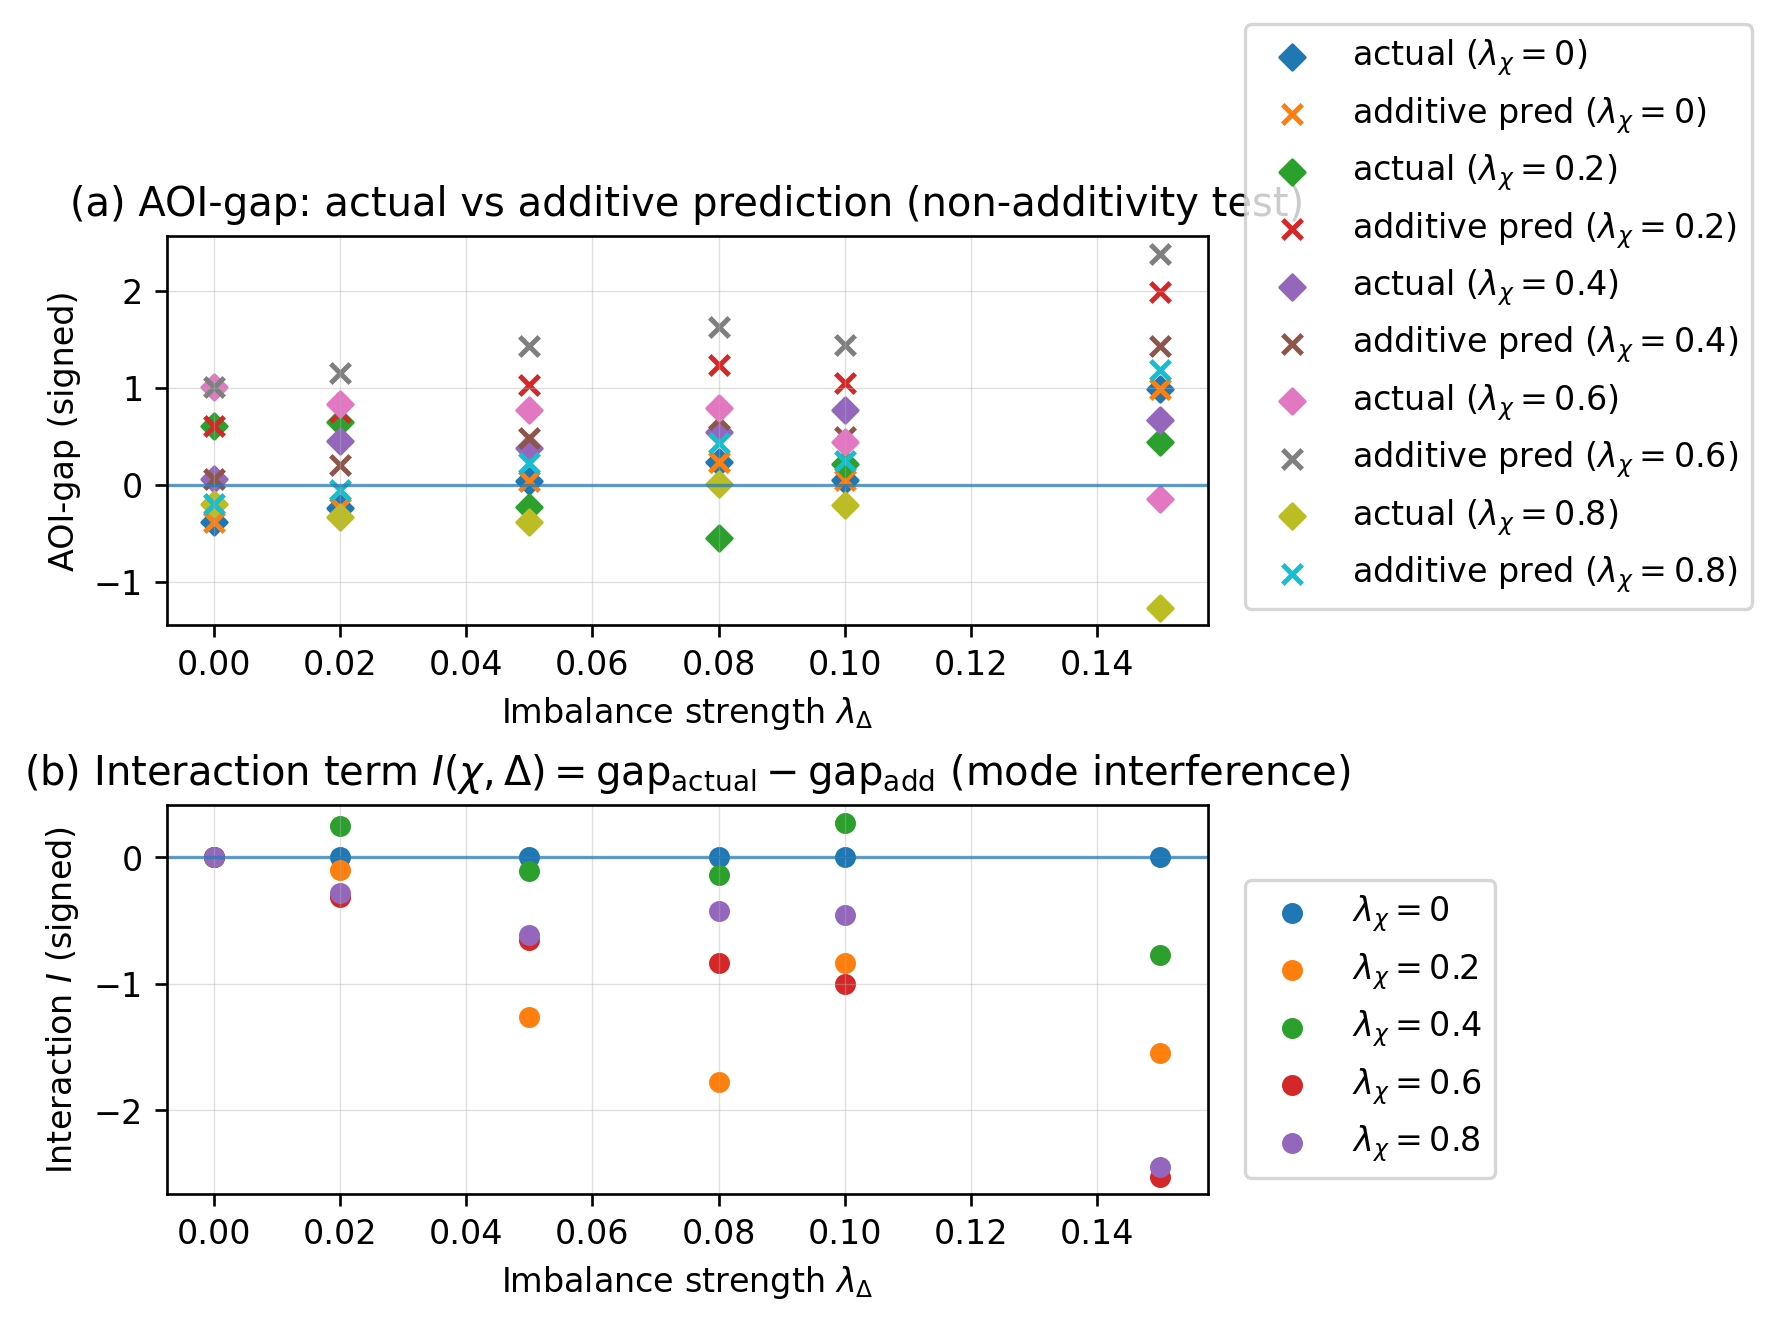

Saved: outputs/fig6.png


('outputs/paperC_fig6_mode_interference_alpha0p4_contacts.npz',
 'outputs/fig6.png')

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt


def run_fig6_mode_interference(
    outdir="outputs",
    npz_name="paperC_fig6_mode_interference_alpha0p4_contacts.npz",
    png_name="fig6.png",
    alpha=0.4,
    T=160,
    p_thresh=0.7,
    seed=0,
    # sweeps (keep small + interpretable)
    lam_chi_list=(0.0, 0.2, 0.4, 0.6, 0.8),
    lam_delta_list=(0.0, 0.02, 0.05, 0.08, 0.10, 0.15),
    # fixed other modes (set to 0 for “clean” Fig 6)
    lam_nu=0.0,
    lam_m=0.0,
    # contacts on (to keep momentum/geometry meaningful later, but fine here)
    contact_frac=0.18,
    contact_offset_CH=(0, 5),
):
    """
    FIG 6 (Mode–mode interference / non-additivity):
      Compare actual AOI-gap for combined (chi + delta) against an additive prediction.

    Requires these functions already defined in your notebook:
      - run_diracgate_AB_BA_timeseries(...)
      - summarize_decoupling(out)  -> (aC, aH, R)

    Outputs:
      - NPZ with full grid + baselines
      - PNG figure (fig6.png)
    """
    os.makedirs(outdir, exist_ok=True)

    base_params = dict(
        Nx=23, Ny=23, T=T, omega=0.8,
        charge_params=(2.4, 0.0),
        heat_params=(1.0, -0.15),
        p_thresh=p_thresh,
        alpha=alpha,
        lam_chi=0.0,
        lam_nu=float(lam_nu),
        lam_m=float(lam_m),
        lam_delta=0.0,
        contact_frac=float(contact_frac),
        contact_offset_CH=tuple(contact_offset_CH),
        seed=int(seed),
    )

    def eval_point(lam_chi, lam_delta):
        P = dict(base_params)
        P["lam_chi"] = float(lam_chi)
        P["lam_delta"] = float(lam_delta)
        out = run_diracgate_AB_BA_timeseries(**P)
        aC, aH, R = summarize_decoupling(out)
        return dict(
            lam_chi=float(lam_chi),
            lam_delta=float(lam_delta),
            AOI_AB=float(out["AOI_AB"]),
            AOI_BA=float(out["AOI_BA"]),
            AOI_gap=float(out["AOI_gap_signed"]),
            AOI_gap_L1=float(out["AOI_gap_L1"]),
            AOI_C_total=float(aC),
            AOI_H_total=float(aH),
            R=float(R),
            params=out["params"],
        )

    # ---- Baseline and 1D baselines (for additivity prediction) ----
    base = eval_point(0.0, 0.0)

    chi_only = {}
    for lc in lam_chi_list:
        chi_only[float(lc)] = eval_point(lc, 0.0)

    delta_only = {}
    for ld in lam_delta_list:
        delta_only[float(ld)] = eval_point(0.0, ld)

    # ---- Full 2D grid (chi + delta) ----
    grid = []
    for lc in lam_chi_list:
        for ld in lam_delta_list:
            grid.append(eval_point(lc, ld))

    # ---- Compute additivity prediction + interaction term ----
    # Pred gap_add(lc, ld) = gap(lc,0) + gap(0,ld) - gap(0,0)
    # Interaction I = gap_actual - gap_add
    for rec in grid:
        lc = rec["lam_chi"]
        ld = rec["lam_delta"]
        gap_add = (
            chi_only[lc]["AOI_gap"]
            + delta_only[ld]["AOI_gap"]
            - base["AOI_gap"]
        )
        rec["AOI_gap_additive_pred"] = float(gap_add)
        rec["interaction"] = float(rec["AOI_gap"] - gap_add)
        rec["interaction_abs"] = float(abs(rec["interaction"]))

    # Save NPZ
    npz_path = os.path.join(outdir, npz_name)
    np.savez_compressed(
        npz_path,
        base=base,
        chi_only=np.array(list(chi_only.values()), dtype=object),
        delta_only=np.array(list(delta_only.values()), dtype=object),
        grid=np.array(grid, dtype=object),
        meta=dict(
            figure="Fig6",
            alpha=float(alpha),
            T=int(T),
            p_thresh=float(p_thresh),
            seed=int(seed),
            lam_nu=float(lam_nu),
            lam_m=float(lam_m),
            contact_frac=float(contact_frac),
            contact_offset_CH=tuple(contact_offset_CH),
            note="interaction = gap_actual - (gap_chi_only + gap_delta_only - gap_base)",
        ),
    )
    print("Saved:", npz_path)

    # ---- Plot: two panels ----
    # Panel (a): actual vs additive prediction (scatter)
    # Panel (b): interaction term (scatter), grouped by chi (marker families)
    fig, axes = plt.subplots(2, 1, figsize=(7.2, 5.4), dpi=240, constrained_layout=True)

    # helper: stable x positions so different (chi,delta) don’t collide visually
    # x = delta; series = chi
    deltas = np.array([float(x) for x in lam_delta_list], dtype=float)

    # (a) Actual vs predicted
    ax = axes[0]
    for lc in lam_chi_list:
        lc = float(lc)
        G = [r for r in grid if r["lam_chi"] == lc]
        G = sorted(G, key=lambda r: r["lam_delta"])
        x = np.array([r["lam_delta"] for r in G], dtype=float)
        y_actual = np.array([r["AOI_gap"] for r in G], dtype=float)
        y_pred = np.array([r["AOI_gap_additive_pred"] for r in G], dtype=float)

        ax.scatter(x, y_actual, marker="D", s=28, label=rf"actual ($\lambda_\chi={lc:g}$)")
        ax.scatter(x, y_pred, marker="x", s=34, label=rf"additive pred ($\lambda_\chi={lc:g}$)")

    ax.axhline(0.0, linewidth=1.0, alpha=0.7)
    ax.set_title(r"(a) AOI-gap: actual vs additive prediction (non-additivity test)")
    ax.set_ylabel(r"AOI-gap (signed)")
    ax.grid(True, linewidth=0.4, alpha=0.4)
    ax.legend(loc="lower left", bbox_to_anchor=(1.02, 0.0), frameon=True)
    ax.set_xlabel(r"Imbalance strength $\lambda_\Delta$")

    # (b) Interaction term
    ax = axes[1]
    for lc in lam_chi_list:
        lc = float(lc)
        G = [r for r in grid if r["lam_chi"] == lc]
        G = sorted(G, key=lambda r: r["lam_delta"])
        x = np.array([r["lam_delta"] for r in G], dtype=float)
        inter = np.array([r["interaction"] for r in G], dtype=float)

        ax.scatter(x, inter, marker="o", s=28, label=rf"$\lambda_\chi={lc:g}$")

    ax.axhline(0.0, linewidth=1.0, alpha=0.7)
    ax.set_title(r"(b) Interaction term $I(\chi,\Delta)=\mathrm{gap}_{\mathrm{actual}}-\mathrm{gap}_{\mathrm{add}}$ (mode interference)")
    ax.set_xlabel(r"Imbalance strength $\lambda_\Delta$")
    ax.set_ylabel(r"Interaction $I$ (signed)")
    ax.grid(True, linewidth=0.4, alpha=0.4)
    ax.legend(loc="lower left", bbox_to_anchor=(1.02, 0.0), frameon=True)

    png_path = os.path.join(outdir, png_name)
    plt.savefig(png_path, bbox_inches="tight")
    plt.show()
    print("Saved:", png_path)

    return npz_path, png_path


# RUN (Fig 6)
run_fig6_mode_interference(
    outdir="outputs",
    npz_name="paperC_fig6_mode_interference_alpha0p4_contacts.npz",
    png_name="fig6.png",
    alpha=0.4,
    T=160,
    p_thresh=0.7,
    seed=0,
)

Saved: outputs/paperC_fig7_abc_alpha0p4_contacts.npz


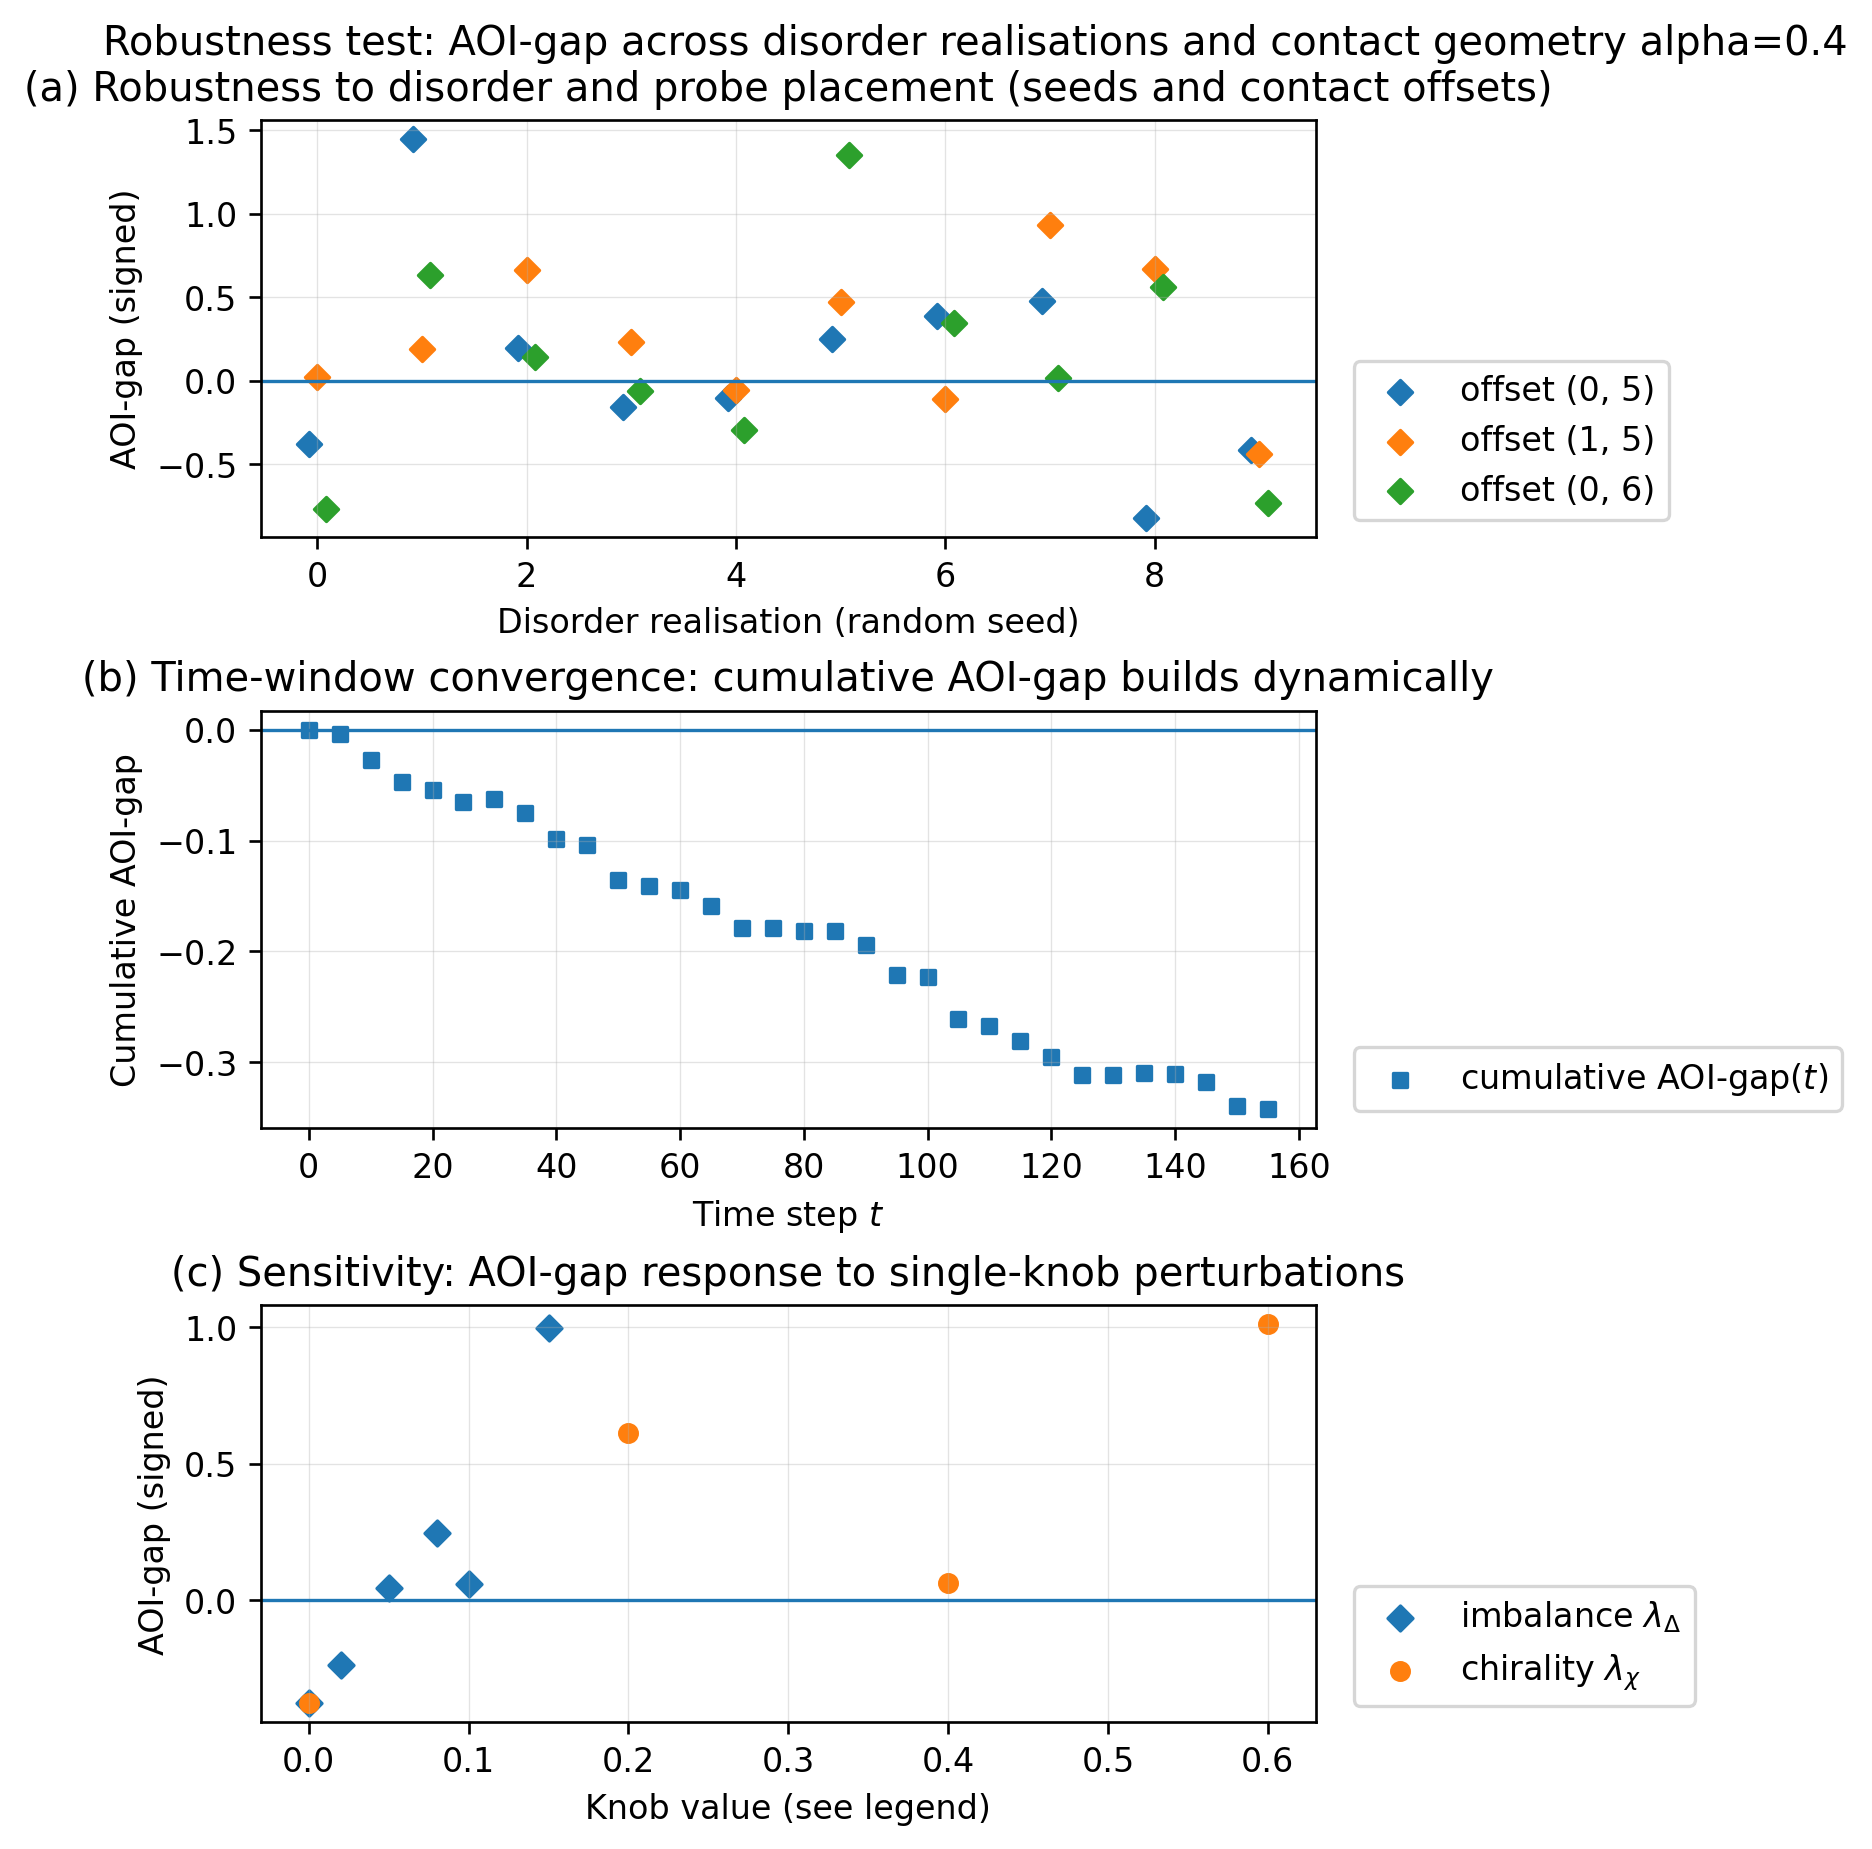

Saved: outputs/fig7.png


('outputs/paperC_fig7_abc_alpha0p4_contacts.npz', 'outputs/fig7.png')

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

def aoi_positive_area(x):
    # same definition used elsewhere in your notebook
    y = np.maximum(x - np.mean(x), 0.0)
    return float(np.trapezoid(y))

def compute_aoi_gap_from_timeseries(out_dict):
    rC_AB = np.asarray(out_dict["rC_AB"], float)
    rH_AB = np.asarray(out_dict["rH_AB"], float)
    rC_BA = np.asarray(out_dict["rC_BA"], float)
    rH_BA = np.asarray(out_dict["rH_BA"], float)
    AOI_AB = aoi_positive_area(rC_AB - rH_AB)
    AOI_BA = aoi_positive_area(rC_BA - rH_BA)
    return float(AOI_AB - AOI_BA)

def compute_cumulative_aoi_gap(out_dict):
    """
    Cumulative AOI-gap(t): compute AOI_AB(t) and AOI_BA(t) using positive-area
    up to each time step (inclusive), then subtract.
    Returns t, gap_cum.
    """
    rC_AB = np.asarray(out_dict["rC_AB"], float)
    rH_AB = np.asarray(out_dict["rH_AB"], float)
    rC_BA = np.asarray(out_dict["rC_BA"], float)
    rH_BA = np.asarray(out_dict["rH_BA"], float)

    sAB = rC_AB - rH_AB
    sBA = rC_BA - rH_BA
    T = len(sAB)
    t = np.arange(T)

    gap_cum = np.zeros(T, dtype=float)
    for i in range(T):
        AOI_AB_i = aoi_positive_area(sAB[:i+1])
        AOI_BA_i = aoi_positive_area(sBA[:i+1])
        gap_cum[i] = AOI_AB_i - AOI_BA_i
    return t, gap_cum

def fig7_abc_robustness_convergence_sensitivity(
    outdir="outputs",
    npz_name="paperC_fig7_abc_alpha0p4_contacts.npz",
    png_name="fig7.png",
    alpha=0.4,
    T=160,
    p_thresh=0.7,
    seed_base=0,
    seeds=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9),
    contact_offsets=((0, 5), (1, 5), (0, 6)),  # mild probe offsets for robustness
    sens_eps_delta=(0.00, 0.02, 0.05, 0.08, 0.10),  # imbalance strength sweep (small-to-moderate)
    sens_eps_chi=(0.00, 0.20, 0.40),               # chirality sweep (coarse; tune if you want)
    baseline_params=None,
):
    """
    Fig.7A: robustness to disorder/contact placement (seed + small contact offsets)
    Fig.7B: convergence of cumulative AOI-gap(t) over time for baseline case
    Fig.7C: sensitivity to small knob changes (imbalance + chirality here)
    """
    os.makedirs(outdir, exist_ok=True)

    if baseline_params is None:
        baseline_params = dict(
            Nx=23, Ny=23, T=T, omega=0.8,
            charge_params=(2.4, 0.0),
            heat_params=(1.0, -0.15),
            p_thresh=p_thresh,
            alpha=alpha,
            lam_chi=0.0,
            lam_nu=0.0,
            lam_m=0.0,
            lam_delta=0.0,
            contact_frac=0.18,
            contact_offset_CH=(0, 5),
            seed=seed_base,
        )

    records = {"robustness": [], "convergence": {}, "sensitivity": []}

    # -------------------------
    # (a) Robustness: seeds x offsets
    # -------------------------
    for off in contact_offsets:
        for s in seeds:
            P = dict(baseline_params)
            P["seed"] = int(s)
            P["contact_offset_CH"] = tuple(off)
            out = run_diracgate_AB_BA_timeseries(**P)
            gap = float(out.get("AOI_gap_signed", compute_aoi_gap_from_timeseries(out)))
            records["robustness"].append(dict(seed=int(s), contact_offset=tuple(off), AOI_gap=gap))

    # -------------------------
    # (b) Convergence: baseline cumulative AOI-gap(t)
    # -------------------------
    out_base = run_diracgate_AB_BA_timeseries(**baseline_params)
    t_cum, gap_cum = compute_cumulative_aoi_gap(out_base)
    records["convergence"] = dict(
        t=t_cum.astype(int),
        gap_cum=gap_cum.astype(float),
        baseline_gap=float(out_base.get("AOI_gap_signed", compute_aoi_gap_from_timeseries(out_base))),
        params=out_base.get("params", baseline_params),
    )

    # -------------------------
    # (c) Sensitivity: vary imbalance and chirality separately (same baseline otherwise)
    # -------------------------
    # Imbalance sweep
    for v in sens_eps_delta:
        P = dict(baseline_params)
        P["lam_delta"] = float(v)
        out = run_diracgate_AB_BA_timeseries(**P)
        gap = float(out.get("AOI_gap_signed", compute_aoi_gap_from_timeseries(out)))
        records["sensitivity"].append(dict(mode="imbalance", value=float(v), AOI_gap=gap))

    # Chirality sweep
    for v in sens_eps_chi:
        P = dict(baseline_params)
        P["lam_chi"] = float(v)
        out = run_diracgate_AB_BA_timeseries(**P)
        gap = float(out.get("AOI_gap_signed", compute_aoi_gap_from_timeseries(out)))
        records["sensitivity"].append(dict(mode="chirality", value=float(v), AOI_gap=gap))

    # Save NPZ
    npz_path = os.path.join(outdir, npz_name)
    np.savez_compressed(npz_path, records=np.array(records, dtype=object))
    print("Saved:", npz_path)

    # -------------------------
    # Plot Fig.7 (a)(b)(c)
    # -------------------------
    fig, axes = plt.subplots(3, 1, figsize=(7.3, 7.4), dpi=240, constrained_layout=True)

    # (a) Robustness panel
    ax = axes[0]
    rob = records["robustness"]
    # Group by contact_offset for mild separation
    offsets_unique = list(dict.fromkeys([tuple(r["contact_offset"]) for r in rob]))
    for j, off in enumerate(offsets_unique):
        G = [r for r in rob if tuple(r["contact_offset"]) == off]
        xs = np.array([r["seed"] for r in G], float)
        ys = np.array([r["AOI_gap"] for r in G], float)
        # small x jitter so points don’t sit perfectly on top of each other
        jitter = (j - 0.5*(len(offsets_unique)-1)) * 0.08
        ax.scatter(xs + jitter, ys, marker="D", s=26, label=rf"offset {off}")

    ax.axhline(0.0, linewidth=1.0)
    ax.set_title(r"(a) Robustness to disorder and probe placement (seeds and contact offsets)")
    ax.set_xlabel(r"Disorder realisation (random seed)")
    ax.set_ylabel(r"AOI-gap (signed)")
    ax.grid(True, linewidth=0.4, alpha=0.35)
    ax.legend(loc="lower left", bbox_to_anchor=(1.02, 0.0), frameon=True)

    # (b) Convergence panel
    ax = axes[1]
    tc = records["convergence"]["t"]
    gc = records["convergence"]["gap_cum"]
    # markers every ~5 steps to avoid “line chart” vibe while still showing convergence
    step = max(1, int(np.round(len(tc) / 32)))
    ax.scatter(tc[::step], gc[::step], marker="s", s=18, label=r"cumulative AOI-gap$(t)$")
    ax.axhline(0.0, linewidth=1.0)
    ax.set_title(r"(b) Time-window convergence: cumulative AOI-gap builds dynamically")
    ax.set_xlabel(r"Time step $t$")
    ax.set_ylabel(r"Cumulative AOI-gap")
    ax.grid(True, linewidth=0.4, alpha=0.35)
    ax.legend(loc="lower left", bbox_to_anchor=(1.02, 0.0), frameon=True)

    # (c) Sensitivity panel
    ax = axes[2]
    sens = records["sensitivity"]
    imb = sorted([r for r in sens if r["mode"] == "imbalance"], key=lambda r: r["value"])
    chi = sorted([r for r in sens if r["mode"] == "chirality"], key=lambda r: r["value"])

    x1 = np.array([r["value"] for r in imb], float)
    y1 = np.array([r["AOI_gap"] for r in imb], float)
    x2 = np.array([r["value"] for r in chi], float)
    y2 = np.array([r["AOI_gap"] for r in chi], float)

    ax.scatter(x1, y1, marker="D", s=28, label=r"imbalance $\lambda_\Delta$")
    ax.scatter(x2, y2, marker="o", s=28, label=r"chirality $\lambda_\chi$")

    ax.axhline(0.0, linewidth=1.0)
    ax.set_title(r"(c) Sensitivity: AOI-gap response to single-knob perturbations")
    ax.set_xlabel(r"Knob value (see legend)")
    ax.set_ylabel(r"AOI-gap (signed)")
    ax.grid(True, linewidth=0.4, alpha=0.35)
    ax.legend(loc="lower left", bbox_to_anchor=(1.02, 0.0), frameon=True)

    # Global title (keep compact; you can expand in caption)
    fig.suptitle(rf"Robustness test: AOI-gap across disorder realisations and contact geometry alpha={alpha:g}", y=1.02)
    png_path = os.path.join(outdir, png_name)
    plt.savefig(png_path, bbox_inches="tight")
    plt.show()
    print("Saved:", png_path)

    return npz_path, png_path

# ---- RUN (adjust only if you want different ranges) ----
fig7_abc_robustness_convergence_sensitivity(
    outdir="outputs",
    npz_name="paperC_fig7_abc_alpha0p4_contacts.npz",
    png_name="fig7.png",
    alpha=0.4,
    T=160,
    p_thresh=0.7,
    seed_base=0,
    seeds=(0,1,2,3,4,5,6,7,8,9),
    contact_offsets=((0,5),(1,5),(0,6)),
    sens_eps_delta=(0.00, 0.02, 0.05, 0.08, 0.10, 0.15),
    sens_eps_chi=(0.00, 0.20, 0.40, 0.60),
)

In [ ]:
# -------------------------
# (c) Sensitivity: densified + seed-averaged (optionally offset-averaged)
# -------------------------

# Densify knob grids (edit if you want different density)
sens_grid_delta = np.round(np.linspace(0.0, 0.15, 16), 3)   # 0.00 ... 0.15 step ~0.01
sens_grid_chi   = np.round(np.linspace(0.0, 0.80, 17), 3)   # 0.00 ... 0.80 step 0.05

# Choose averaging scheme:
# - "seeds only" keeps contact_offset fixed to baseline_params["contact_offset_CH"]
# - "seeds+offsets" averages across seeds AND your contact_offsets list
average_over_offsets = True

sens_records = []

def collect_gap(P):
    out = run_diracgate_AB_BA_timeseries(**P)
    return float(out.get("AOI_gap_signed", compute_aoi_gap_from_timeseries(out)))

# Recreate baseline_params in this scope
baseline_params = dict(
    Nx=23, Ny=23, T=160, omega=0.8,
    charge_params=(2.4, 0.0),
    heat_params=(1.0, -0.15),
    p_thresh=0.7,
    alpha=0.4,
    lam_chi=0.0,
    lam_nu=0.0,
    lam_m=0.0,
    lam_delta=0.0,
    contact_frac=0.18,
    contact_offset_CH=(0, 5),
    seed=0,
)

# Imbalance sweep
for v in sens_grid_delta:
    gaps = []
    for s in seeds:
        if average_over_offsets:
            for off in contact_offsets:
                P = dict(baseline_params)
                P["seed"] = int(s)
                P["contact_offset_CH"] = tuple(off)
                P["lam_delta"] = float(v)
                gaps.append(collect_gap(P))
        else:
            P = dict(baseline_params)
            P["seed"] = int(s)
            P["lam_delta"] = float(v)
            gaps.append(collect_gap(P))

    gaps = np.asarray(gaps, float)
    sens_records.append(dict(
        mode="imbalance",
        value=float(v),
        mean=float(np.mean(gaps)),
        sd=float(np.std(gaps, ddof=1)) if len(gaps) > 1 else 0.0,
        n=int(len(gaps)),
    ))

# Chirality sweep
for v in sens_grid_chi:
    gaps = []
    for s in seeds:
        if average_over_offsets:
            for off in contact_offsets:
                P = dict(baseline_params)
                P["seed"] = int(s)
                P["contact_offset_CH"] = tuple(off)
                P["lam_chi"] = float(v)
                gaps.append(collect_gap(P))
        else:
            P = dict(baseline_params)
            P["seed"] = int(s)
            P["lam_chi"] = float(v)
            gaps.append(collect_gap(P))

    gaps = np.asarray(gaps, float)
    sens_records.append(dict(
        mode="chirality",
        value=float(v),
        mean=float(np.mean(gaps)),
        sd=float(np.std(gaps, ddof=1)) if len(gaps) > 1 else 0.0,
        n=int(len(gaps)),
    ))

# Store into your records dict (so NPZ contains the improved panel-c data)
records["sensitivity"] = sens_records

# ---- Plot panel (c) ----
ax = axes[2]
sens = records["sensitivity"]

imb = sorted([r for r in sens if r["mode"] == "imbalance"], key=lambda r: r["value"])
chi = sorted([r for r in sens if r["mode"] == "chirality"], key=lambda r: r["value"])

x1 = np.array([r["value"] for r in imb], float)
m1 = np.array([r["mean"]  for r in imb], float)
e1 = np.array([r["sd"]    for r in imb], float)

x2 = np.array([r["value"] for r in chi], float)
m2 = np.array([r["mean"]  for r in chi], float)
e2 = np.array([r["sd"]    for r in chi], float)

# Mean markers
ax.scatter(x1, m1, marker="D", s=28, label=r"imbalance $\lambda_\Delta$ (mean)")
ax.scatter(x2, m2, marker="o", s=28, label=r"chirality $\lambda_\chi$ (mean)")

# Error bars (±SD)
ax.errorbar(x1, m1, yerr=e1, fmt="none", capsize=2, elinewidth=0.8)
ax.errorbar(x2, m2, yerr=e2, fmt="none", capsize=2, elinewidth=0.8)

ax.axhline(0.0, linewidth=1.0)
ax.set_title(r"(c) Sensitivity: AOI-gap response to single-knob perturbations (mean $\pm$ SD)")
ax.set_xlabel(r"Knob value (see legend)")
ax.set_ylabel(r"AOI-gap (signed)")
ax.grid(True, linewidth=0.4, alpha=0.35)
ax.legend(loc="lower left", bbox_to_anchor=(1.02, 0.0), frameon=True)

TypeError: list indices must be integers or slices, not str

In [ ]:
print(type(records), records[:1] if isinstance(records, list) else records.keys())

<class 'list'> [{'label': 'baseline_hBN_ordered', 'AOI_AB': 4.754820415879012, 'AOI_BA': 2.493289224952741, 'AOI_gap': 2.2615311909262705, 'theta': 0.0, 'a_hbn': 1.018, 'hbn_weight': 0.4, 'alpha': 0.8, 'p_thresh': 0.7, 'T': 160}]


In [ ]:
# Ensure these are in scope for panel (c)
seeds = tuple(seeds) if "seeds" in locals() else (0,1,2,3,4,5,6,7,8,9)

contact_offsets = (
    contact_offsets
    if "contact_offsets" in locals()
    else ((0,5),(1,5),(0,6))
)

Saved: outputs/paperC_fig7_abc_alpha0p4_contacts.npz


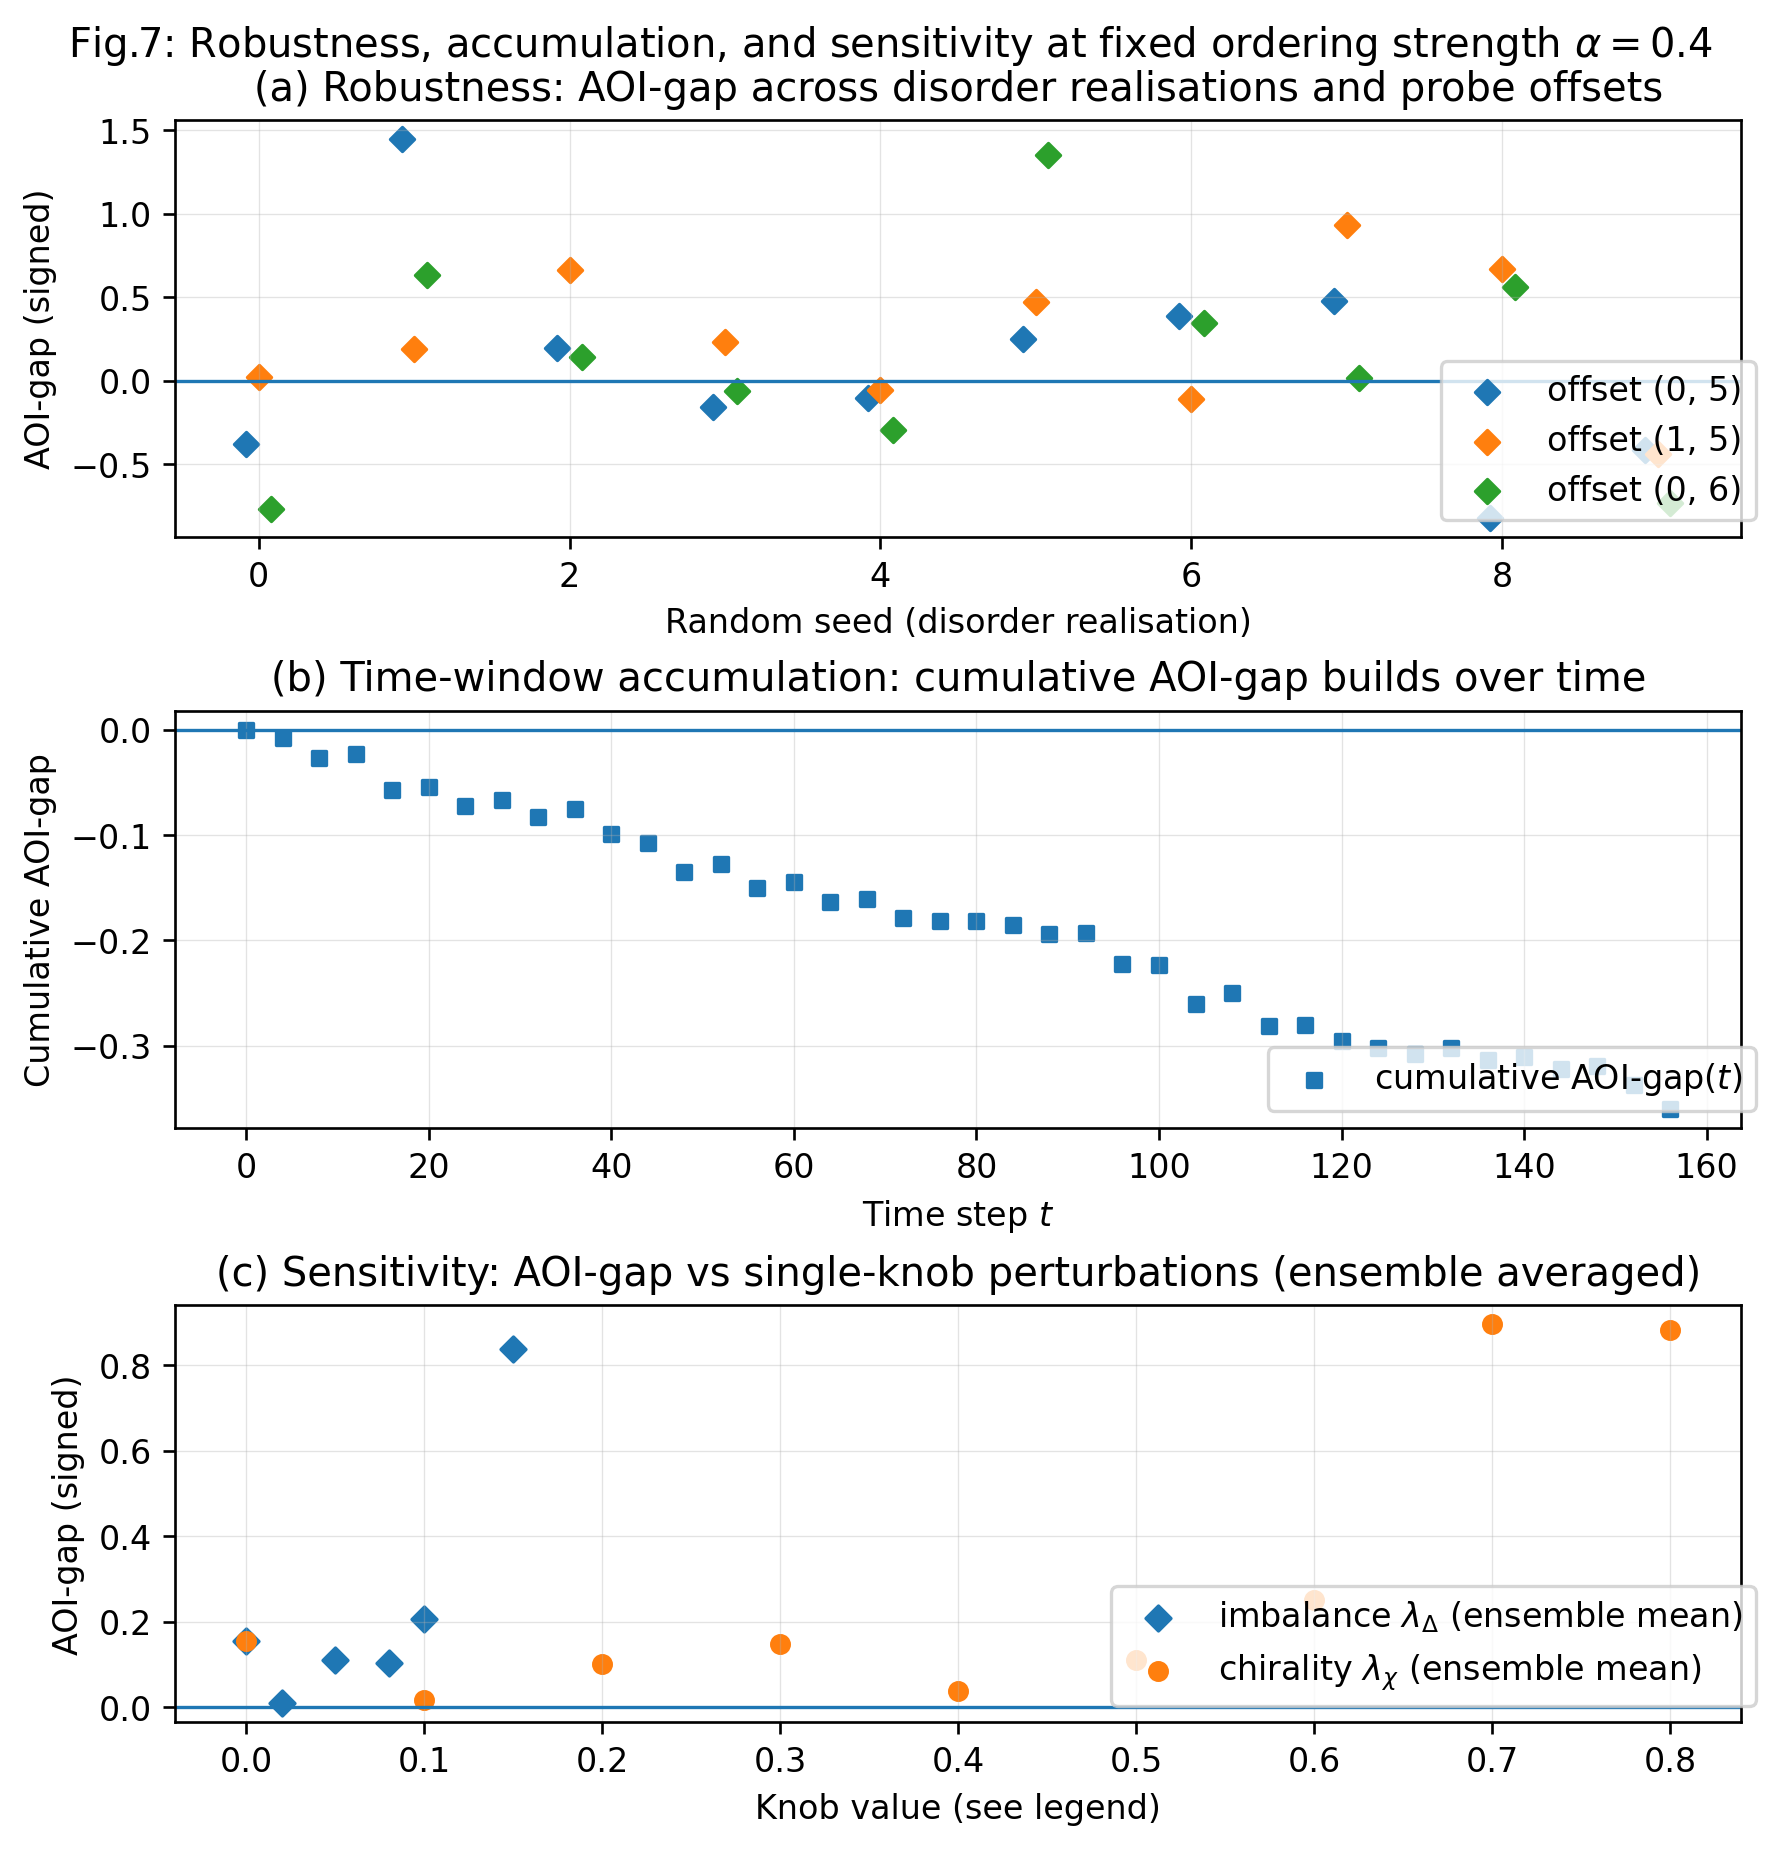

Saved: outputs/fig7.png


('outputs/paperC_fig7_abc_alpha0p4_contacts.npz', 'outputs/fig7.png')

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# Core utilities (moved from AHNX8HBA66GW for self-containment)
# ============================================================
def sigmoid(kappa, x):
    z = np.clip(-kappa * x, -60.0, 60.0)
    return 1.0 / (1.0 + np.exp(z))

def run_channel(V, kappa, Vc):
    return sigmoid(kappa, V - Vc)

def aoi_positive_area(x):
    y = np.maximum(x - np.mean(x), 0.0)
    return float(np.trapezoid(y))

def blur_2d(field, passes=1):
    A = field.copy()
    for _ in range(int(passes)):
        A = 0.6*A + 0.1*(np.roll(A, 1, 0) + np.roll(A, -1, 0) + np.roll(A, 1, 1) + np.roll(A, -1, 1))
    return A

def make_base_fields(Nx, Ny, seed=0):
    rng = np.random.default_rng(seed)
    x = np.linspace(0, 2*np.pi, Nx, endpoint=False)
    y = np.linspace(0, 2*np.pi, Ny, endpoint=False)
    X, Y = np.meshgrid(x, y, indexing="ij")

    V0 = np.cos(X) + 0.7*np.cos(Y)
    Vchi = np.sin(2*X) - 0.6*np.sin(2*Y)
    return V0, Vchi

def make_contact_masks(Nx, Ny, frac=0.18, offset=(0, 0), seed=0):
    rng = np.random.default_rng(seed)
    n = Nx * Ny
    k = max(1, int(np.round(frac * n)))

    idx = rng.choice(n, size=k, replace=False)
    mask = np.zeros(n, dtype=bool)
    mask[idx] = True
    mask = mask.reshape(Nx, Ny)

    ox, oy = offset
    if ox != 0 or oy != 0:
        mask = np.roll(mask, shift=ox, axis=0)
        mask = np.roll(mask, shift=oy, axis=1)
    return mask

def build_time_field(V0_2d, Vchi_2d, lam_chi=0.0, lam_nu=0.0, lam_m=0.0, t=0, omega=0.8):
    V = V0_2d + lam_chi * Vchi_2d

    if lam_m != 0.0:
        shift = int(np.round(lam_m * t))
        V = np.roll(V, shift=shift, axis=1)

    drive = (1.0 + 0.25*np.cos(omega*t))
    V = drive * V

    if lam_nu != 0.0:
        passes = int(np.round(lam_nu))
        if passes > 0:
            V = blur_2d(V, passes=passes)

    return V

def run_diracgate_AB_BA_timeseries(
    Nx=23, Ny=23,
    T=160,
    omega=0.8,
    charge_params=(2.4, 0.0),
    heat_params=(1.0, -0.15),
    p_thresh=0.7,
    alpha=0.4,
    lam_chi=0.0,
    lam_nu=0.0,
    lam_m=0.0,
    lam_delta=0.0,
    contact_frac=0.18,
    contact_offset_CH=(0, 5),
    seed=0,
):
    V0_2d, Vchi_2d = make_base_fields(Nx, Ny, seed=seed)

    maskC = make_contact_masks(Nx, Ny, frac=contact_frac, offset=(0, 0), seed=seed+11)
    maskH = make_contact_masks(Nx, Ny, frac=contact_frac, offset=contact_offset_CH, seed=seed+11)

    kC, VcC = charge_params
    kH, VcH = heat_params
    delta = float(lam_delta)

    def reach_fraction(p_2d, mask):
        return float(np.mean(p_2d[mask] > p_thresh))

    def schedule(order):
        rC = np.zeros(T, dtype=float)
        rH = np.zeros(T, dtype=float)

        for t in range(T):
            Vt = build_time_field(
                V0_2d=V0_2d, Vchi_2d=Vchi_2d,
                lam_chi=lam_chi, lam_nu=lam_nu, lam_m=lam_m,
                t=t, omega=omega
            )

            if order == "AB":
                pC = run_channel(Vt.reshape(-1) + delta, kC, VcC).reshape(Nx, Ny)
                Vt2 = Vt - alpha*(pC - pC.mean())
                pH = run_channel(Vt2.reshape(-1) - delta, kH, VcH).reshape(Nx, Ny)
            else:
                pH = run_channel(Vt.reshape(-1) - delta, kH, VcH).reshape(Nx, Ny)
                Vt2 = Vt - alpha*(pH - pH.mean())
                pC = run_channel(Vt2.reshape(-1) + delta, kC, VcC).reshape(Nx, Ny)

            rC[t] = reach_fraction(pC, maskC)
            rH[t] = reach_fraction(pH, maskH)

        return rC, rH

    rC_AB, rH_AB = schedule("AB")
    rC_BA, rH_BA = schedule("BA")

    AOI_AB = aoi_positive_area(rC_AB - rH_AB)
    AOI_BA = aoi_positive_area(rC_BA - rH_BA)

    out = dict(
        rC_AB=rC_AB, rH_AB=rH_AB, rC_BA=rC_BA, rH_BA=rH_BA,
        AOI_AB=float(AOI_AB),
        AOI_BA=float(AOI_BA),
        AOI_gap_signed=float(AOI_AB - AOI_BA),
        AOI_gap_L1=float(abs(AOI_AB - AOI_BA)),
        params=dict(
            Nx=int(Nx), Ny=int(Ny), T=int(T), omega=float(omega),
            charge_params=tuple(charge_params), heat_params=tuple(heat_params),
            p_thresh=float(p_thresh), alpha=float(alpha),
            lam_chi=float(lam_chi), lam_nu=float(lam_nu), lam_m=float(lam_m), lam_delta=float(lam_delta),
            contact_frac=float(contact_frac), contact_offset_CH=tuple(contact_offset_CH),
            seed=int(seed),
        )
    )
    return out

def summarize_decoupling(out):
    rC_AB = out["rC_AB"]; rC_BA = out["rC_BA"]
    rH_AB = out["rH_AB"]; rH_BA = out["rH_BA"]
    aC = aoi_positive_area(rC_AB) + aoi_positive_area(rC_BA)
    aH = aoi_positive_area(rH_AB) + aoi_positive_area(rH_BA)
    R = float(aH / (aC + 1e-12))
    return float(aC), float(aH), float(R)

# ---------------------------------------------------------
# Utility functions specifically for Fig7 (originally in oDtj4hoIKQ2O)
# ---------------------------------------------------------
def compute_aoi_gap_from_timeseries(out_dict):
    rC_AB = np.asarray(out_dict["rC_AB"], float)
    rH_AB = np.asarray(out_dict["rH_AB"], float)
    rC_BA = np.asarray(out_dict["rC_BA"], float)
    rH_BA = np.asarray(out_dict["rH_BA"], float)
    AOI_AB = aoi_positive_area(rC_AB - rH_AB)
    AOI_BA = aoi_positive_area(rC_BA - rH_BA)
    return float(AOI_AB - AOI_BA)

def cumulative_aoi_gap(out_dict):
    rC_AB = np.asarray(out_dict["rC_AB"], float)
    rH_AB = np.asarray(out_dict["rH_AB"], float)
    rC_BA = np.asarray(out_dict["rC_BA"], float)
    rH_BA = np.asarray(out_dict["rH_BA"], float)

    sAB = rC_AB - rH_AB
    sBA = rC_BA - rH_BA
    T = len(sAB)
    t = np.arange(T, dtype=int)

    gap_cum = np.zeros(T, dtype=float)
    for i in range(T):
        AOI_AB_i = aoi_positive_area(sAB[: i + 1])
        AOI_BA_i = aoi_positive_area(sBA[: i + 1])
        gap_cum[i] = AOI_AB_i - AOI_BA_i
    return t, gap_cum


def build_fig7_abc(
    png_name="fig7.png",
    npz_name="paperC_fig7_abc_alpha0p4_contacts.npz",
    outdir="outputs", # Added outdir parameter
    alpha=0.4,
    T=160,
    p_thresh=0.7,
    seeds=tuple(range(10)),
    contact_offsets=((0, 5), (1, 5), (0, 6)),
    # More chirality points (as you requested)
    sens_grid_delta=(0.00, 0.02, 0.05, 0.08, 0.10, 0.15),
    sens_grid_chi=(0.00, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80),
    baseline_seed=0,
    baseline_contact_offset=(0, 5),
):
    os.makedirs(outdir, exist_ok=True)

    # Baseline params are defined INSIDE this function so nothing is "missing".
    baseline_params = dict(
        Nx=23, Ny=23, T=T, omega=0.8,
        charge_params=(2.4, 0.0),
        heat_params=(1.0, -0.15),
        p_thresh=p_thresh,
        alpha=alpha,
        lam_chi=0.0,
        lam_nu=0.0,
        lam_m=0.0,
        lam_delta=0.0,
        contact_frac=0.18,
        contact_offset_CH=tuple(baseline_contact_offset),
        seed=int(baseline_seed),
    )

    records = {
        "robustness": [],
        "convergence": {},
        "sensitivity": {
            "imbalance_grid": [],
            "chirality_grid": [],
        },
        "meta": {
            "alpha": float(alpha),
            "T": int(T),
            "p_thresh": float(p_thresh),
            "seeds": tuple(int(s) for s in seeds),
            "contact_offsets": tuple(tuple(o) for o in contact_offsets),
            "baseline_seed": int(baseline_seed),
            "baseline_contact_offset": tuple(baseline_contact_offset),
        }
    }

    # -------------------------
    # (a) Robustness: seeds x contact offsets
    # -------------------------
    for off in contact_offsets:
        for s in seeds:
            P = dict(baseline_params)
            P["seed"] = int(s)
            P["contact_offset_CH"] = tuple(off)
            out = run_diracgate_AB_BA_timeseries(**P)
            gap = float(out.get("AOI_gap_signed", compute_aoi_gap_from_timeseries(out)))
            records["robustness"].append({
                "seed": int(s),
                "contact_offset": tuple(off),
                "AOI_gap": float(gap),
            })

    # -------------------------
    # (b) Convergence: baseline cumulative AOI-gap(t)
    # -------------------------
    out_base = run_diracgate_AB_BA_timeseries(**baseline_params)
    base_gap = float(out_base.get("AOI_gap_signed", compute_aoi_gap_from_timeseries(out_base)))
    t_cum, gap_cum = cumulative_aoi_gap(out_base)
    records["convergence"] = {
        "t": t_cum.astype(int),
        "gap_cum": gap_cum.astype(float),
        "baseline_gap": float(base_gap),
        "baseline_params": dict(baseline_params),
    }

    # -------------------------
    # (c) Sensitivity: do TWO sweeps (imbalance, chirality)
    # Here: average over seeds and offsets to reduce ‘one-realisation noise’.
    # -------------------------
    def mean_gap_over_ensemble(P_base):
        gaps = []
        for s in seeds:
            for off in contact_offsets:
                P = dict(P_base)
                P["seed"] = int(s)
                P["contact_offset_CH"] = tuple(off)
                out = run_diracgate_AB_BA_timeseries(**P)
                gap = float(out.get("AOI_gap_signed", compute_aoi_gap_from_timeseries(out)))
                gaps.append(gap)
        gaps = np.asarray(gaps, float)
        return float(np.mean(gaps)), float(np.std(gaps)), int(gaps.size)

    # imbalance grid
    for v in sens_grid_delta:
        P = dict(baseline_params)
        P["lam_delta"] = float(v)
        mu, sd, n = mean_gap_over_ensemble(P)
        records["sensitivity"]["imbalance_grid"].append({
            "lam_delta": float(v),
            "mean_gap": float(mu),
            "std_gap": float(sd),
            "n": int(n),
        })

    # chirality grid
    for v in sens_grid_chi:
        P = dict(baseline_params)
        P["lam_chi"] = float(v)
        mu, sd, n = mean_gap_over_ensemble(P)
        records["sensitivity"]["chirality_grid"].append({
            "lam_chi": float(v),
            "mean_gap": float(mu),
            "std_gap": float(sd),
            "n": int(n),
        })

    # -------------------------
    # Save NPZ (dict container, always)
    # -------------------------
    npz_path = os.path.join(outdir, npz_name)
    np.savez_compressed(npz_path, records=np.array(records, dtype=object))
    print("Saved:", npz_path)

    # -------------------------
    # Plot Fig7 (a)(b)(c)
    # -------------------------
    fig, axes = plt.subplots(3, 1, figsize=(7.3, 7.4), dpi=240, constrained_layout=True)

    # (a) Robustness
    ax = axes[0]
    rob = records["robustness"]
    offsets_unique = list(dict.fromkeys([tuple(r["contact_offset"]) for r in rob]))

    for j, off in enumerate(offsets_unique):
        G = [r for r in rob if tuple(r["contact_offset"]) == off]
        xs = np.array([r["seed"] for r in G], float)
        ys = np.array([r["AOI_gap"] for r in G], float)
        jitter = (j - 0.5*(len(offsets_unique)-1)) * 0.08
        ax.scatter(xs + jitter, ys, marker="D", s=26, label=rf"offset {off}")

    ax.axhline(0.0, linewidth=1.0)
    ax.set_title(r"(a) Robustness: AOI-gap across disorder realisations and probe offsets")
    ax.set_xlabel("Random seed (disorder realisation)")
    ax.set_ylabel("AOI-gap (signed)")
    ax.grid(True, linewidth=0.4, alpha=0.35)
    ax.legend(loc="lower right", bbox_to_anchor=(1.02, 0.0), frameon=True)

    # (b) Convergence
    ax = axes[1]
    tc = records["convergence"]["t"]
    gc = records["convergence"]["gap_cum"]
    step = max(1, int(np.round(len(tc) / 36)))
    ax.scatter(tc[::step], gc[::step], marker="s", s=18, label=r"cumulative AOI-gap$(t)$")
    ax.axhline(0.0, linewidth=1.0)
    ax.set_title(r"(b) Time-window accumulation: cumulative AOI-gap builds over time")
    ax.set_xlabel(r"Time step $t$")
    ax.set_ylabel("Cumulative AOI-gap")
    ax.grid(True, linewidth=0.4, alpha=0.35)
    ax.legend(loc="lower right", bbox_to_anchor=(1.02, 0.0), frameon=True)

    # (c) Sensitivity (ensemble mean ± 0 shown as points; you can add errorbars later if desired)
    ax = axes[2]
    imb = sorted(records["sensitivity"]["imbalance_grid"], key=lambda r: r["lam_delta"])
    chi = sorted(records["sensitivity"]["chirality_grid"], key=lambda r: r["lam_chi"])

    x1 = np.array([r["lam_delta"] for r in imb], float)
    y1 = np.array([r["mean_gap"] for r in imb], float)

    x2 = np.array([r["lam_chi"] for r in chi], float)
    y2 = np.array([r["mean_gap"] for r in chi], float)

    ax.scatter(x1, y1, marker="D", s=28, label=r"imbalance $\lambda_\Delta$ (ensemble mean)")
    ax.scatter(x2, y2, marker="o", s=28, label=r"chirality $\lambda_\chi$ (ensemble mean)")

    ax.axhline(0.0, linewidth=1.0)
    ax.set_title(r"(c) Sensitivity: AOI-gap vs single-knob perturbations (ensemble averaged)")
    ax.set_xlabel("Knob value (see legend)")
    ax.set_ylabel("AOI-gap (signed)")
    ax.grid(True, linewidth=0.4, alpha=0.35)
    ax.legend(loc="lower right", bbox_to_anchor=(1.02, 0.0), frameon=True)

    fig.suptitle(rf"Fig.7: Robustness, accumulation, and sensitivity at fixed ordering strength $\alpha={alpha:g}$", y=1.02)
    png_path = os.path.join(outdir, png_name)
    plt.savefig(png_path, bbox_inches="tight")
    plt.show()
    print("Saved:", png_path)

    return npz_path, png_path

# ---- RUN ----
build_fig7_abc(
    png_name="fig7.png",
    npz_name="paperC_fig7_abc_alpha0p4_contacts.npz",
    outdir="outputs",
    alpha=0.4,
    T=160,
    p_thresh=0.7,
    seeds=tuple(range(10)),
    contact_offsets=((0, 5), (1, 5), (0, 6)),
    sens_grid_delta=(0.00, 0.02, 0.05, 0.08, 0.10, 0.15),
    sens_grid_chi=(0.00, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80),
)

Saved: outputs/paperC_fig7_abc_alpha0p4_contacts_REBUILT.npz


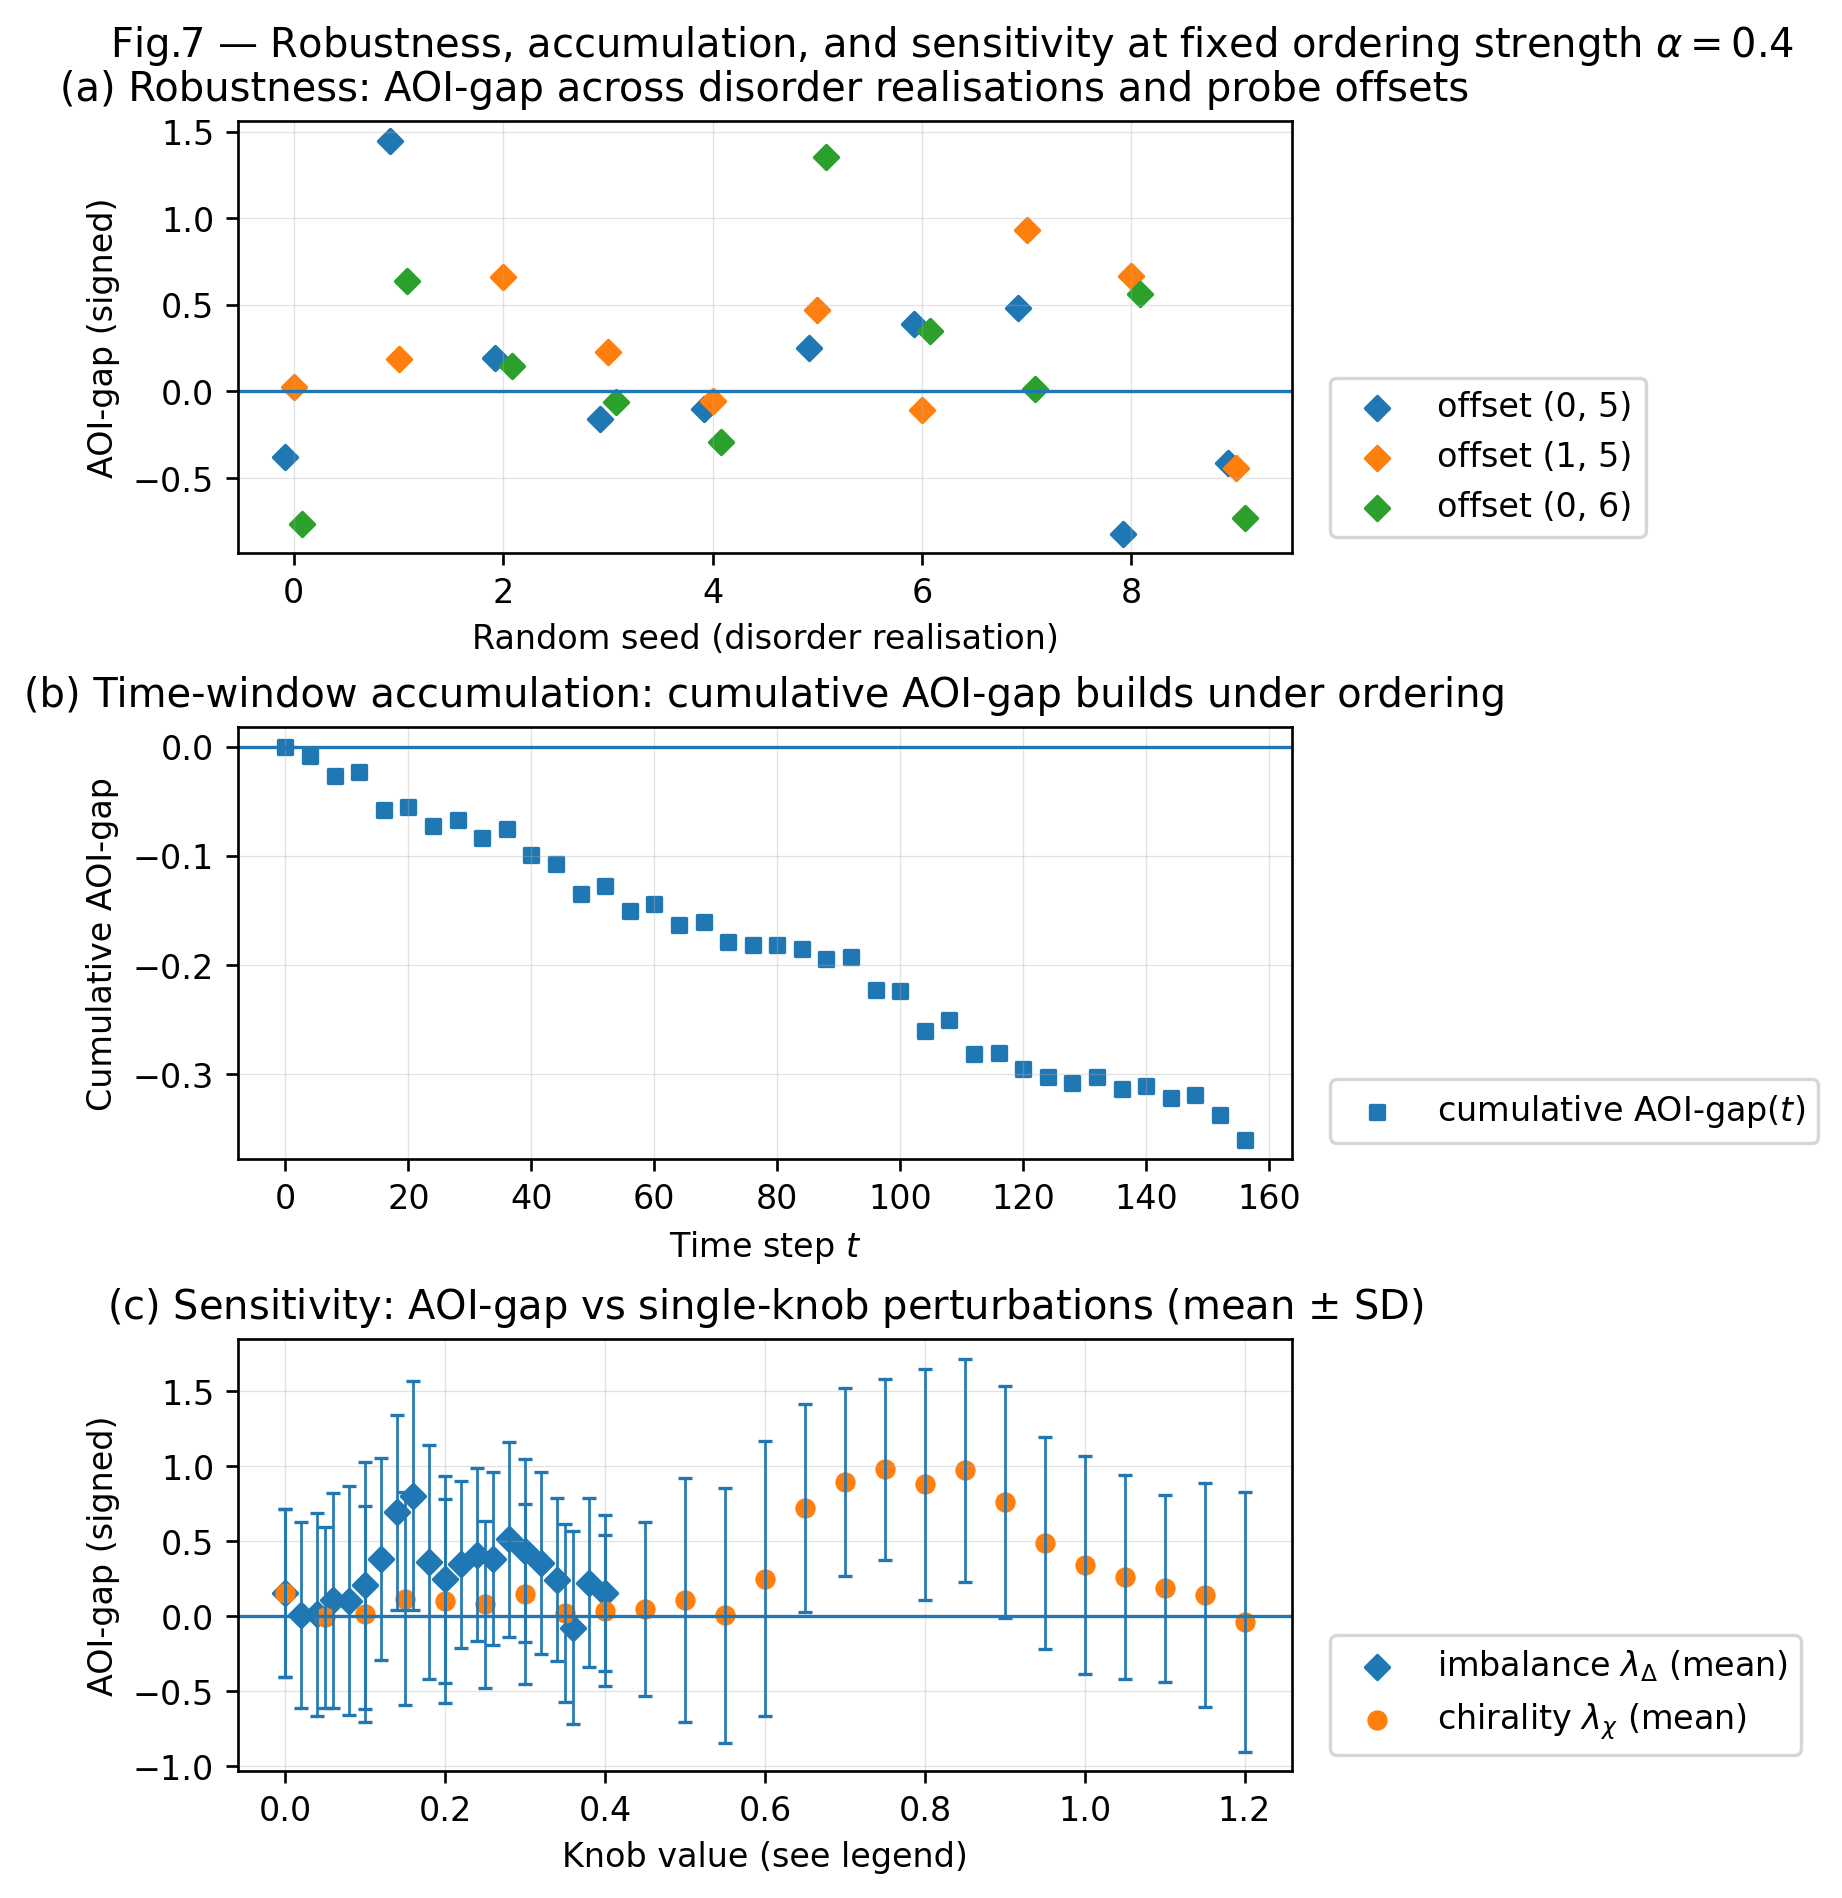

Saved: outputs/fig7.png


('outputs/paperC_fig7_abc_alpha0p4_contacts_REBUILT.npz', 'outputs/fig7.png')

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

def aoi_positive_area(x):
    y = np.maximum(x - np.mean(x), 0.0)
    return float(np.trapezoid(y))

def compute_aoi_gap_from_timeseries(out_dict):
    rC_AB = np.asarray(out_dict["rC_AB"], float)
    rH_AB = np.asarray(out_dict["rH_AB"], float)
    rC_BA = np.asarray(out_dict["rC_BA"], float)
    rH_BA = np.asarray(out_dict["rH_BA"], float)
    AOI_AB = aoi_positive_area(rC_AB - rH_AB)
    AOI_BA = aoi_positive_area(rC_BA - rH_BA)
    return float(AOI_AB - AOI_BA)

def cumulative_aoi_gap(out_dict):
    rC_AB = np.asarray(out_dict["rC_AB"], float)
    rH_AB = np.asarray(out_dict["rH_AB"], float)
    rC_BA = np.asarray(out_dict["rC_BA"], float)
    rH_BA = np.asarray(out_dict["rH_BA"], float)

    sAB = rC_AB - rH_AB
    sBA = rC_BA - rH_BA
    T = len(sAB)
    t = np.arange(T, dtype=int)

    gap_cum = np.zeros(T, dtype=float)
    for i in range(T):
        AOI_AB_i = aoi_positive_area(sAB[:i+1])
        AOI_BA_i = aoi_positive_area(sBA[:i+1])
        gap_cum[i] = AOI_AB_i - AOI_BA_i
    return t, gap_cum

def fig7_abc_rebuilt(
    outdir="outputs",
    npz_name="paperC_fig7_abc_alpha0p4_contacts_REBUILT.npz",
    png_name="fig7.png",
    alpha=0.4,
    T=160,
    p_thresh=0.7,
    seeds=(0,1,2,3,4,5,6,7,8,9),
    contact_offsets=((0,5),(1,5),(0,6)),
    baseline_seed=0,
    baseline_contact_offset=(0,5),
    # DENSE grids (edit freely)
    lam_delta_grid=None,
    lam_chi_grid=None,
):
    os.makedirs(outdir, exist_ok=True)

    if lam_delta_grid is None:
        lam_delta_grid = np.round(np.linspace(0.0, 0.40, 21), 3)  # 0.00..0.40
    if lam_chi_grid is None:
        lam_chi_grid = np.round(np.linspace(0.0, 1.20, 25), 3)    # 0.00..1.20

    baseline_params = dict(
        Nx=23, Ny=23, T=int(T), omega=0.8,
        charge_params=(2.4, 0.0),
        heat_params=(1.0, -0.15),
        p_thresh=float(p_thresh),
        alpha=float(alpha),
        lam_chi=0.0,
        lam_nu=0.0,
        lam_m=0.0,
        lam_delta=0.0,
        contact_frac=0.18,
        contact_offset_CH=tuple(baseline_contact_offset),
        seed=int(baseline_seed),
    )

    records = {
        "meta": {
            "alpha": float(alpha),
            "T": int(T),
            "p_thresh": float(p_thresh),
            "seeds": tuple(int(s) for s in seeds),
            "contact_offsets": tuple(tuple(o) for o in contact_offsets),
            "baseline_seed": int(baseline_seed),
            "baseline_contact_offset": tuple(baseline_contact_offset),
            "lam_delta_grid": np.array(lam_delta_grid, float),
            "lam_chi_grid": np.array(lam_chi_grid, float),
        },
        "robustness": [],
        "convergence": {},
        "sensitivity": {
            "imbalance_grid": [],
            "chirality_grid": [],
        }
    }

    # (a) Robustness: AOI-gap across seeds and contact offsets
    for off in contact_offsets:
        for s in seeds:
            P = dict(baseline_params)
            P["seed"] = int(s)
            P["contact_offset_CH"] = tuple(off)
            out = run_diracgate_AB_BA_timeseries(**P)
            gap = float(out.get("AOI_gap_signed", compute_aoi_gap_from_timeseries(out)))
            records["robustness"].append({
                "seed": int(s),
                "contact_offset": tuple(off),
                "AOI_gap": float(gap),
            })

    # (b) Convergence: baseline cumulative AOI-gap(t)
    out_base = run_diracgate_AB_BA_timeseries(**baseline_params)
    base_gap = float(out_base.get("AOI_gap_signed", compute_aoi_gap_from_timeseries(out_base)))
    t_cum, gap_cum = cumulative_aoi_gap(out_base)
    records["convergence"] = {
        "t": t_cum.astype(int),
        "gap_cum": gap_cum.astype(float),
        "baseline_gap": float(base_gap),
        "baseline_params": dict(baseline_params),
    }

    # helper: ensemble mean/sd across seeds and offsets
    def mean_gap_over_ensemble(P_base):
        gaps = []
        for s in seeds:
            for off in contact_offsets:
                P = dict(P_base)
                P["seed"] = int(s)
                P["contact_offset_CH"] = tuple(off)
                out = run_diracgate_AB_BA_timeseries(**P)
                gaps.append(float(out.get("AOI_gap_signed", compute_aoi_gap_from_timeseries(out))))
        gaps = np.asarray(gaps, float)
        sd = float(np.std(gaps, ddof=1)) if gaps.size > 1 else 0.0
        return float(np.mean(gaps)), sd, int(gaps.size)

    # (c1) imbalance sweep
    for v in lam_delta_grid:
        P = dict(baseline_params)
        P["lam_delta"] = float(v)
        mu, sd, n = mean_gap_over_ensemble(P)
        records["sensitivity"]["imbalance_grid"].append({
            "lam_delta": float(v),
            "mean_gap": float(mu),
            "std_gap": float(sd),
            "n": int(n),
        })

    # (c2) chirality sweep
    for v in lam_chi_grid:
        P = dict(baseline_params)
        P["lam_chi"] = float(v)
        mu, sd, n = mean_gap_over_ensemble(P)
        records["sensitivity"]["chirality_grid"].append({
            "lam_chi": float(v),
            "mean_gap": float(mu),
            "std_gap": float(sd),
            "n": int(n),
        })

    # Save NPZ
    npz_path = os.path.join(outdir, npz_name)
    np.savez_compressed(npz_path, records=np.array(records, dtype=object))
    print("Saved:", npz_path)

    # ---- Plot Fig7 (a)(b)(c)
    fig, axes = plt.subplots(3, 1, figsize=(7.3, 7.6), dpi=240, constrained_layout=True)

    # (a)
    ax = axes[0]
    rob = records["robustness"]
    offsets_unique = list(dict.fromkeys([tuple(r["contact_offset"]) for r in rob]))
    for j, off in enumerate(offsets_unique):
        G = [r for r in rob if tuple(r["contact_offset"]) == off]
        xs = np.array([r["seed"] for r in G], float)
        ys = np.array([r["AOI_gap"] for r in G], float)
        jitter = (j - 0.5*(len(offsets_unique)-1)) * 0.08
        ax.scatter(xs + jitter, ys, marker="D", s=26, label=f"offset {off}")
    ax.axhline(0.0, linewidth=1.0)
    ax.set_title(r"(a) Robustness: AOI-gap across disorder realisations and probe offsets")
    ax.set_xlabel("Random seed (disorder realisation)")
    ax.set_ylabel("AOI-gap (signed)")
    ax.grid(True, linewidth=0.4, alpha=0.35)
    ax.legend(loc="lower left", bbox_to_anchor=(1.02, 0.0), frameon=True)

    # (b)
    ax = axes[1]
    tc = records["convergence"]["t"]
    gc = records["convergence"]["gap_cum"]
    step = max(1, int(np.round(len(tc) / 36)))
    ax.scatter(tc[::step], gc[::step], marker="s", s=18, label=r"cumulative AOI-gap$(t)$")
    ax.axhline(0.0, linewidth=1.0)
    ax.set_title(r"(b) Time-window accumulation: cumulative AOI-gap builds under ordering")
    ax.set_xlabel(r"Time step $t$")
    ax.set_ylabel("Cumulative AOI-gap")
    ax.grid(True, linewidth=0.4, alpha=0.35)
    ax.legend(loc="lower left", bbox_to_anchor=(1.02, 0.0), frameon=True)

    # (c)
    ax = axes[2]
    imb = records["sensitivity"]["imbalance_grid"]
    chi = records["sensitivity"]["chirality_grid"]

    x1 = np.array([r["lam_delta"] for r in imb], float)
    m1 = np.array([r["mean_gap"]  for r in imb], float)
    e1 = np.array([r["std_gap"]   for r in imb], float)

    x2 = np.array([r["lam_chi"] for r in chi], float)
    m2 = np.array([r["mean_gap"] for r in chi], float)
    e2 = np.array([r["std_gap"]  for r in chi], float)

    ax.scatter(x1, m1, marker="D", s=26, label=r"imbalance $\lambda_\Delta$ (mean)")
    ax.errorbar(x1, m1, yerr=e1, fmt="none", capsize=2, elinewidth=0.8)

    ax.scatter(x2, m2, marker="o", s=26, label=r"chirality $\lambda_\chi$ (mean)")
    ax.errorbar(x2, m2, yerr=e2, fmt="none", capsize=2, elinewidth=0.8)

    ax.axhline(0.0, linewidth=1.0)
    ax.set_title(r"(c) Sensitivity: AOI-gap vs single-knob perturbations (mean $\pm$ SD)")
    ax.set_xlabel(r"Knob value (see legend)")
    ax.set_ylabel("AOI-gap (signed)")
    ax.grid(True, linewidth=0.4, alpha=0.35)
    ax.legend(loc="lower left", bbox_to_anchor=(1.02, 0.0), frameon=True)

    fig.suptitle(rf"Fig.7 — Robustness, accumulation, and sensitivity at fixed ordering strength $\alpha={alpha:g}$", y=1.02)

    png_path = os.path.join(outdir, png_name)
    plt.savefig(png_path, bbox_inches="tight")
    plt.show()
    print("Saved:", png_path)

    return npz_path, png_path

# RUN
fig7_abc_rebuilt(
    outdir="outputs",
    npz_name="paperC_fig7_abc_alpha0p4_contacts_REBUILT.npz",
    png_name="fig7.png",
    alpha=0.4,
    T=160,
    p_thresh=0.7,
    seeds=(0,1,2,3,4,5,6,7,8,9),
    contact_offsets=((0,5),(1,5),(0,6)),
)

Saved: outputs/paperC_fig7_abc_alpha0p4_contacts_REBUILT.npz


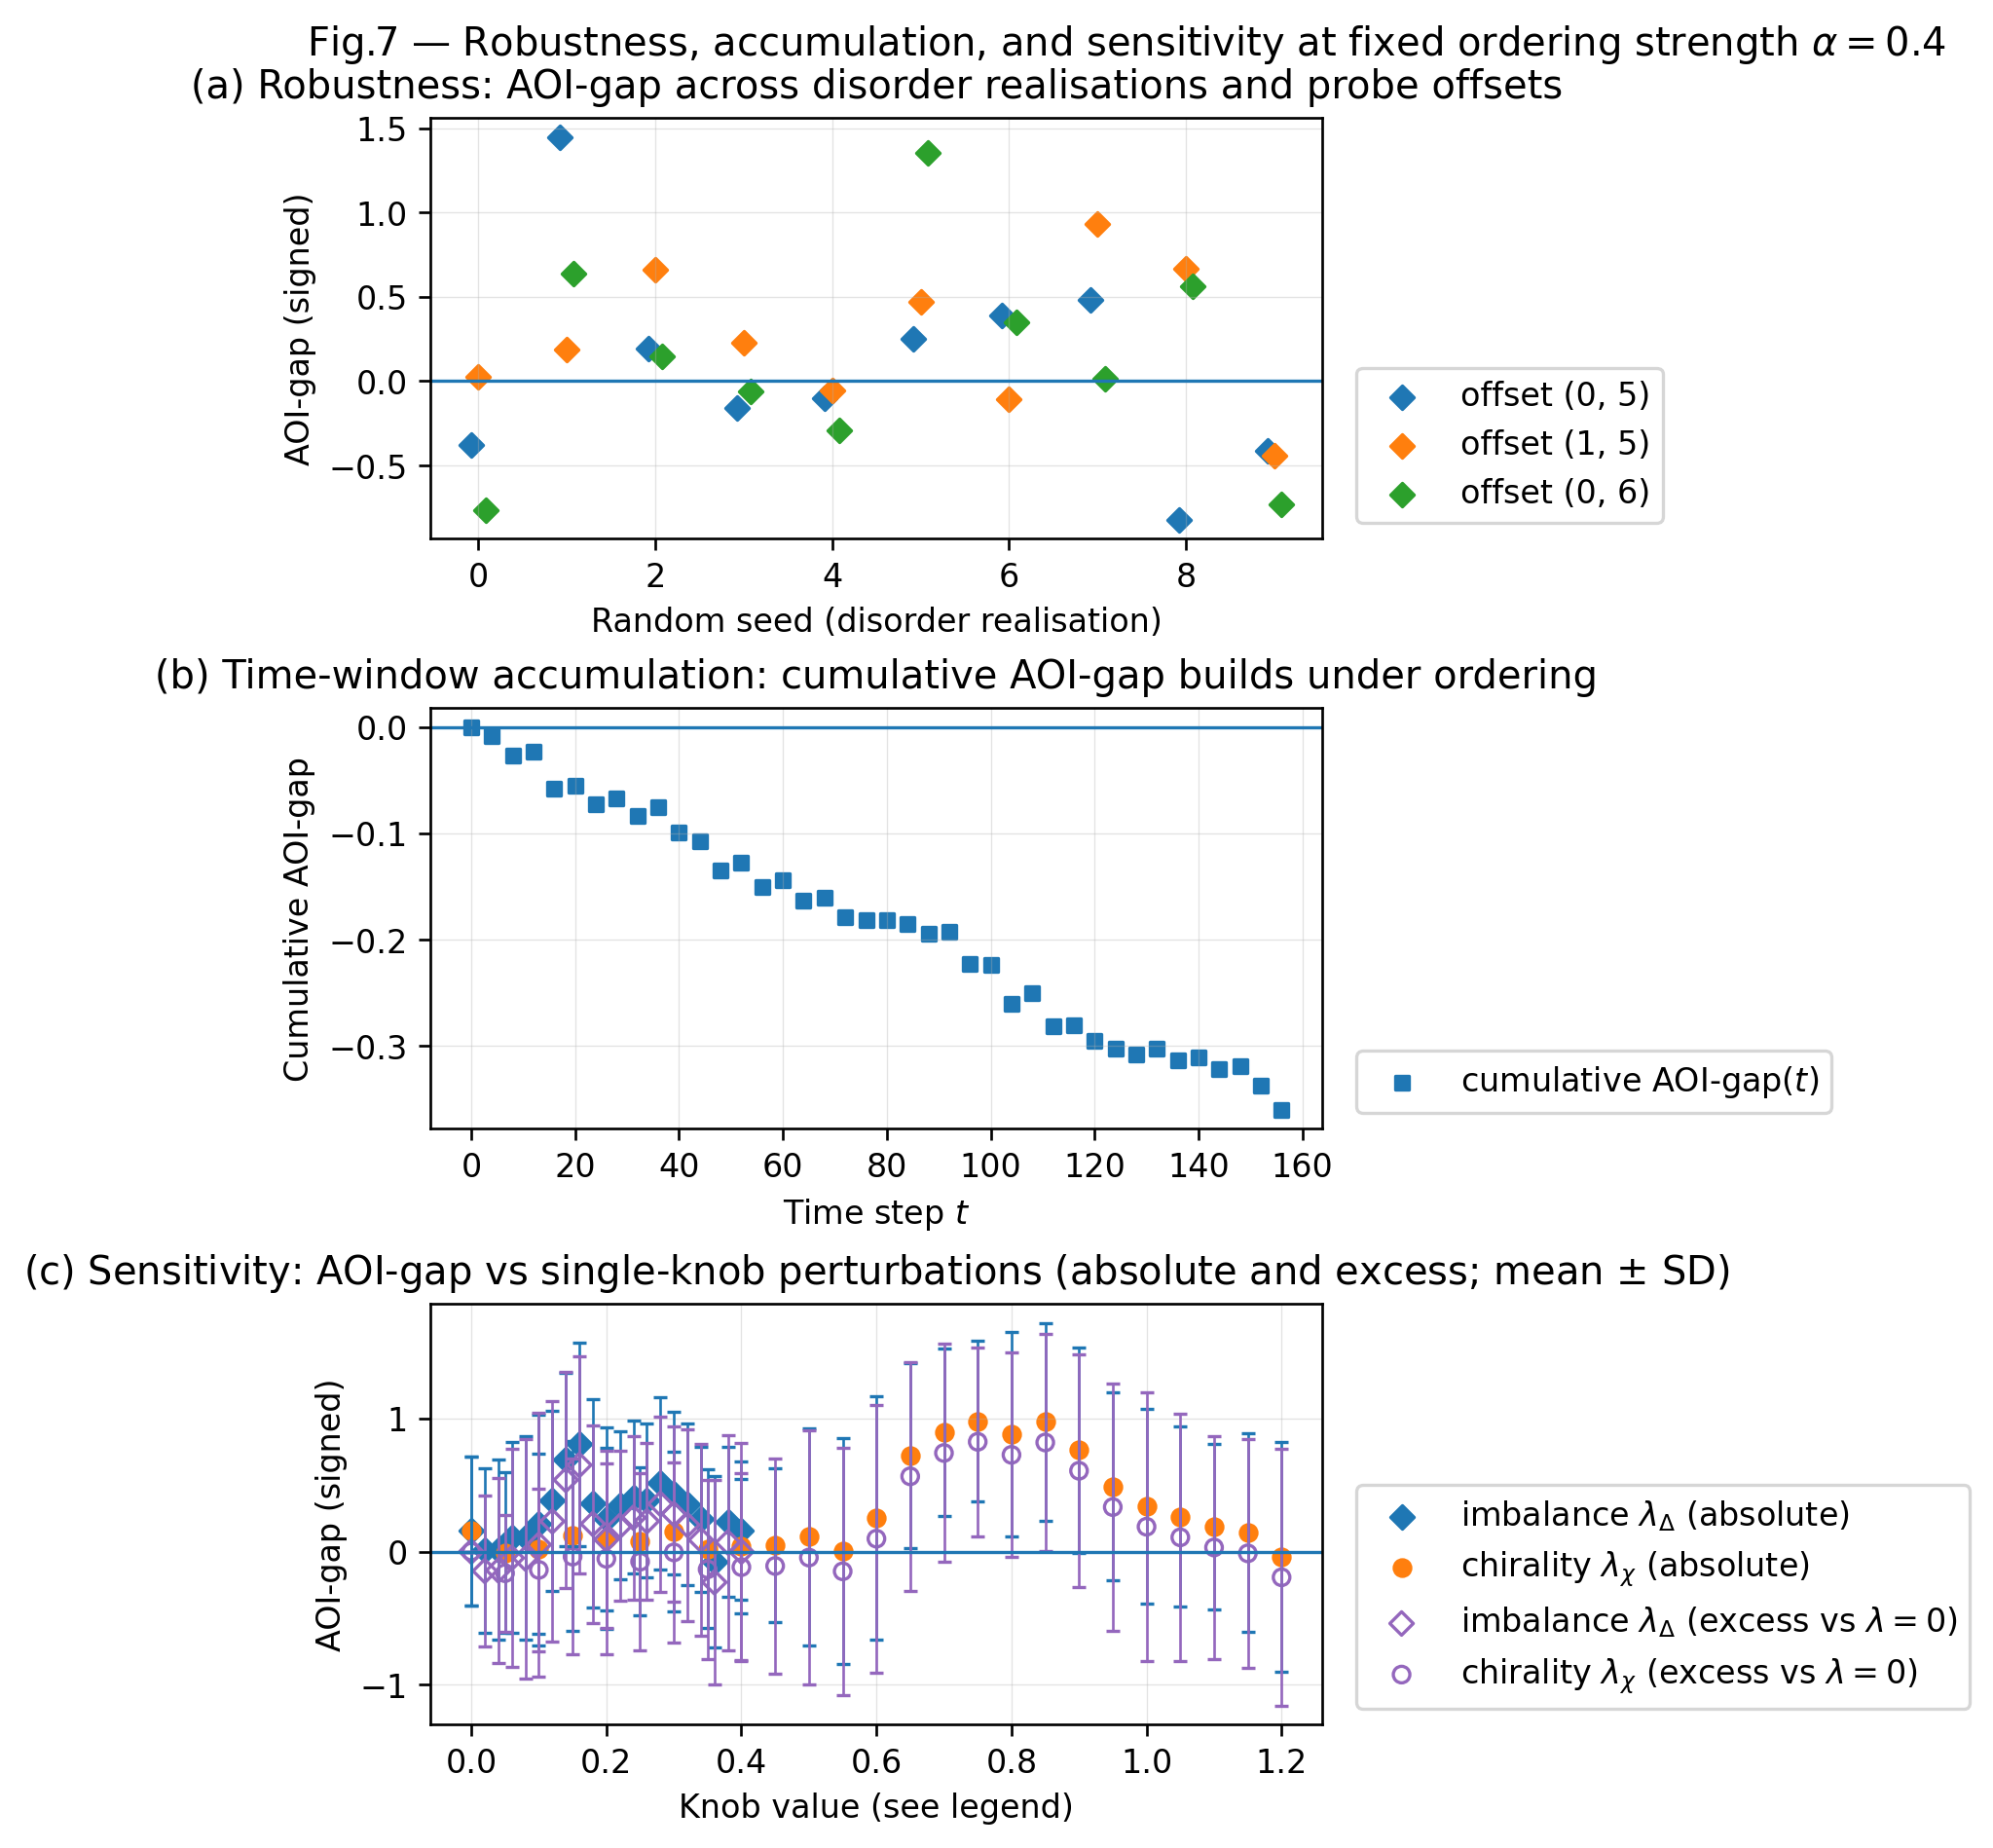

Saved: outputs/fig7.png


('outputs/paperC_fig7_abc_alpha0p4_contacts_REBUILT.npz', 'outputs/fig7.png')

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

def aoi_positive_area(x):
    y = np.maximum(x - np.mean(x), 0.0)
    return float(np.trapezoid(y))

def compute_aoi_gap_from_timeseries(out_dict):
    rC_AB = np.asarray(out_dict["rC_AB"], float)
    rH_AB = np.asarray(out_dict["rH_AB"], float)
    rC_BA = np.asarray(out_dict["rC_BA"], float)
    rH_BA = np.asarray(out_dict["rH_BA"], float)
    AOI_AB = aoi_positive_area(rC_AB - rH_AB)
    AOI_BA = aoi_positive_area(rC_BA - rH_BA)
    return float(AOI_AB - AOI_BA)

def cumulative_aoi_gap(out_dict):
    rC_AB = np.asarray(out_dict["rC_AB"], float)
    rH_AB = np.asarray(out_dict["rH_AB"], float)
    rC_BA = np.asarray(out_dict["rC_BA"], float)
    rH_BA = np.asarray(out_dict["rH_BA"], float)

    sAB = rC_AB - rH_AB
    sBA = rC_BA - rH_BA
    T = len(sAB)
    t = np.arange(T, dtype=int)

    gap_cum = np.zeros(T, dtype=float)
    for i in range(T):
        AOI_AB_i = aoi_positive_area(sAB[:i+1])
        AOI_BA_i = aoi_positive_area(sBA[:i+1])
        gap_cum[i] = AOI_AB_i - AOI_BA_i
    return t, gap_cum

def fig7_abc_rebuilt(
    outdir="outputs",
    npz_name="paperC_fig7_abc_alpha0p4_contacts_REBUILT.npz",
    png_name="fig7.png",
    alpha=0.4,
    T=160,
    p_thresh=0.7,
    seeds=(0,1,2,3,4,5,6,7,8,9),
    contact_offsets=((0,5),(1,5),(0,6)),
    baseline_seed=0,
    baseline_contact_offset=(0,5),
    lam_delta_grid=None,
    lam_chi_grid=None,
):
    os.makedirs(outdir, exist_ok=True)

    if lam_delta_grid is None:
        lam_delta_grid = np.round(np.linspace(0.0, 0.40, 21), 3)
    if lam_chi_grid is None:
        lam_chi_grid = np.round(np.linspace(0.0, 1.20, 25), 3)

    baseline_params = dict(
        Nx=23, Ny=23, T=int(T), omega=0.8,
        charge_params=(2.4, 0.0),
        heat_params=(1.0, -0.15),
        p_thresh=float(p_thresh),
        alpha=float(alpha),
        lam_chi=0.0,
        lam_nu=0.0,
        lam_m=0.0,
        lam_delta=0.0,
        contact_frac=0.18,
        contact_offset_CH=tuple(baseline_contact_offset),
        seed=int(baseline_seed),
    )

    records = {
        "meta": {
            "alpha": float(alpha),
            "T": int(T),
            "p_thresh": float(p_thresh),
            "seeds": tuple(int(s) for s in seeds),
            "contact_offsets": tuple(tuple(o) for o in contact_offsets),
            "baseline_seed": int(baseline_seed),
            "baseline_contact_offset": tuple(baseline_contact_offset),
            "lam_delta_grid": np.array(lam_delta_grid, float),
            "lam_chi_grid": np.array(lam_chi_grid, float),
        },
        "robustness": [],
        "convergence": {},
        "sensitivity": {
            "imbalance_grid": [],
            "chirality_grid": [],
        }
    }

    # Helper: compute AOI-gap for a single parameter set
    def eval_gap(P):
        out = run_diracgate_AB_BA_timeseries(**P)
        return float(out.get("AOI_gap_signed", compute_aoi_gap_from_timeseries(out)))

    # Helper: return full ensemble gaps in a fixed ordering (seed-major, then offset)
    def ensemble_gaps(P_base):
        gaps = []
        for s in seeds:
            for off in contact_offsets:
                P = dict(P_base)
                P["seed"] = int(s)
                P["contact_offset_CH"] = tuple(off)
                gaps.append(eval_gap(P))
        return np.asarray(gaps, float)

    # (a) Robustness: AOI-gap across seeds and contact offsets (single-run each)
    for off in contact_offsets:
        for s in seeds:
            P = dict(baseline_params)
            P["seed"] = int(s)
            P["contact_offset_CH"] = tuple(off)
            gap = eval_gap(P)
            records["robustness"].append({
                "seed": int(s),
                "contact_offset": tuple(off),
                "AOI_gap": float(gap),
            })

    # (b) Convergence: baseline cumulative AOI-gap(t) using baseline_seed + baseline_contact_offset
    out_base = run_diracgate_AB_BA_timeseries(**baseline_params)
    base_gap_single = float(out_base.get("AOI_gap_signed", compute_aoi_gap_from_timeseries(out_base)))
    t_cum, gap_cum = cumulative_aoi_gap(out_base)
    records["convergence"] = {
        "t": t_cum.astype(int),
        "gap_cum": gap_cum.astype(float),
        "baseline_gap": float(base_gap_single),
        "baseline_params": dict(baseline_params),
    }

    # Baseline ensemble for *pairwise* subtraction (same seeds+offsets)
    P0 = dict(baseline_params)
    P0["lam_delta"] = 0.0
    P0["lam_chi"] = 0.0
    gaps0 = ensemble_gaps(P0)

    def mean_sd(x):
        x = np.asarray(x, float)
        mu = float(np.mean(x)) if x.size else 0.0
        sd = float(np.std(x, ddof=1)) if x.size > 1 else 0.0
        return mu, sd, int(x.size)

    # (c1) imbalance sweep (absolute and excess)
    for v in lam_delta_grid:
        P = dict(baseline_params)
        P["lam_delta"] = float(v)
        P["lam_chi"] = 0.0

        gaps = ensemble_gaps(P)
        mu_abs, sd_abs, n = mean_sd(gaps)

        gaps_excess = gaps - gaps0
        mu_exc, sd_exc, _ = mean_sd(gaps_excess)

        records["sensitivity"]["imbalance_grid"].append({
            "lam_delta": float(v),
            "mean_gap": float(mu_abs),
            "std_gap": float(sd_abs),
            "mean_excess": float(mu_exc),
            "std_excess": float(sd_exc),
            "n": int(n),
        })

    # (c2) chirality sweep (absolute and excess)
    for v in lam_chi_grid:
        P = dict(baseline_params)
        P["lam_chi"] = float(v)
        P["lam_delta"] = 0.0

        gaps = ensemble_gaps(P)
        mu_abs, sd_abs, n = mean_sd(gaps)

        gaps_excess = gaps - gaps0
        mu_exc, sd_exc, _ = mean_sd(gaps_excess)

        records["sensitivity"]["chirality_grid"].append({
            "lam_chi": float(v),
            "mean_gap": float(mu_abs),
            "std_gap": float(sd_abs),
            "mean_excess": float(mu_exc),
            "std_excess": float(sd_exc),
            "n": int(n),
        })

    # Save NPZ
    npz_path = os.path.join(outdir, npz_name)
    np.savez_compressed(npz_path, records=np.array(records, dtype=object))
    print("Saved:", npz_path)

    # ---- Plot Fig7 (a)(b)(c)
    fig, axes = plt.subplots(3, 1, figsize=(7.3, 7.6), dpi=240, constrained_layout=True)

    # (a)
    ax = axes[0]
    rob = records["robustness"]
    offsets_unique = list(dict.fromkeys([tuple(r["contact_offset"]) for r in rob]))
    for j, off in enumerate(offsets_unique):
        G = [r for r in rob if tuple(r["contact_offset"]) == off]
        xs = np.array([r["seed"] for r in G], float)
        ys = np.array([r["AOI_gap"] for r in G], float)
        jitter = (j - 0.5*(len(offsets_unique)-1)) * 0.08
        ax.scatter(xs + jitter, ys, marker="D", s=26, label=f"offset {off}")
    ax.axhline(0.0, linewidth=1.0)
    ax.set_title(r"(a) Robustness: AOI-gap across disorder realisations and probe offsets")
    ax.set_xlabel("Random seed (disorder realisation)")
    ax.set_ylabel("AOI-gap (signed)")
    ax.grid(True, linewidth=0.4, alpha=0.35)
    ax.legend(loc="lower left", bbox_to_anchor=(1.02, 0.0), frameon=True)

    # (b)
    ax = axes[1]
    tc = records["convergence"]["t"]
    gc = records["convergence"]["gap_cum"]
    step = max(1, int(np.round(len(tc) / 36)))
    ax.scatter(tc[::step], gc[::step], marker="s", s=18, label=r"cumulative AOI-gap$(t)$")
    ax.axhline(0.0, linewidth=1.0)
    ax.set_title(r"(b) Time-window accumulation: cumulative AOI-gap builds under ordering")
    ax.set_xlabel(r"Time step $t$")
    ax.set_ylabel("Cumulative AOI-gap")
    ax.grid(True, linewidth=0.4, alpha=0.35)
    ax.legend(loc="lower left", bbox_to_anchor=(1.02, 0.0), frameon=True)

    # (c) absolute + excess (new colour)
    ax = axes[2]
    imb = records["sensitivity"]["imbalance_grid"]
    chi = records["sensitivity"]["chirality_grid"]

    x1 = np.array([r["lam_delta"] for r in imb], float)
    m1 = np.array([r["mean_gap"] for r in imb], float)
    e1 = np.array([r["std_gap"] for r in imb], float)
    m1e = np.array([r["mean_excess"] for r in imb], float)
    e1e = np.array([r["std_excess"] for r in imb], float)

    x2 = np.array([r["lam_chi"] for r in chi], float)
    m2 = np.array([r["mean_gap"] for r in chi], float)
    e2 = np.array([r["std_gap"] for r in chi], float)
    m2e = np.array([r["mean_excess"] for r in chi], float)
    e2e = np.array([r["std_excess"] for r in chi], float)

    # Absolute (filled markers)
    ax.scatter(x1, m1, marker="D", s=26, label=r"imbalance $\lambda_\Delta$ (absolute)")
    ax.errorbar(x1, m1, yerr=e1, fmt="none", capsize=2, elinewidth=0.8)

    ax.scatter(x2, m2, marker="o", s=26, label=r"chirality $\lambda_\chi$ (absolute)")
    ax.errorbar(x2, m2, yerr=e2, fmt="none", capsize=2, elinewidth=0.8)

    # Excess (baseline-subtracted): NEW COLOUR + open markers
    excess_color = "tab:purple"
    ax.scatter(x1, m1e, marker="D", s=26, facecolors="none", edgecolors=excess_color,
               label=r"imbalance $\lambda_\Delta$ (excess vs $\lambda=0$)")
    ax.errorbar(x1, m1e, yerr=e1e, fmt="none", capsize=2, elinewidth=0.8, ecolor=excess_color)

    ax.scatter(x2, m2e, marker="o", s=26, facecolors="none", edgecolors=excess_color,
               label=r"chirality $\lambda_\chi$ (excess vs $\lambda=0$)")
    ax.errorbar(x2, m2e, yerr=e2e, fmt="none", capsize=2, elinewidth=0.8, ecolor=excess_color)

    ax.axhline(0.0, linewidth=1.0)
    ax.set_title(r"(c) Sensitivity: AOI-gap vs single-knob perturbations (absolute and excess; mean $\pm$ SD)")
    ax.set_xlabel(r"Knob value (see legend)")
    ax.set_ylabel("AOI-gap (signed)")
    ax.grid(True, linewidth=0.4, alpha=0.35)
    ax.legend(loc="lower left", bbox_to_anchor=(1.02, 0.0), frameon=True)

    fig.suptitle(rf"Fig.7 — Robustness, accumulation, and sensitivity at fixed ordering strength $\alpha={alpha:g}$", y=1.02)

    png_path = os.path.join(outdir, png_name)
    plt.savefig(png_path, bbox_inches="tight")
    plt.show()
    print("Saved:", png_path)

    return npz_path, png_path

# RUN
fig7_abc_rebuilt(
    outdir="outputs",
    npz_name="paperC_fig7_abc_alpha0p4_contacts_REBUILT.npz",
    png_name="fig7.png",
    alpha=0.4,
    T=160,
    p_thresh=0.7,
    seeds=(0,1,2,3,4,5,6,7,8,9),
    contact_offsets=((0,5),(1,5),(0,6)),
)

AOI-gap: 0.04383861058601157
WF_AB, WF_BA, ratio: 0.72803666489522 0.8054325424655314 0.9039076850132022


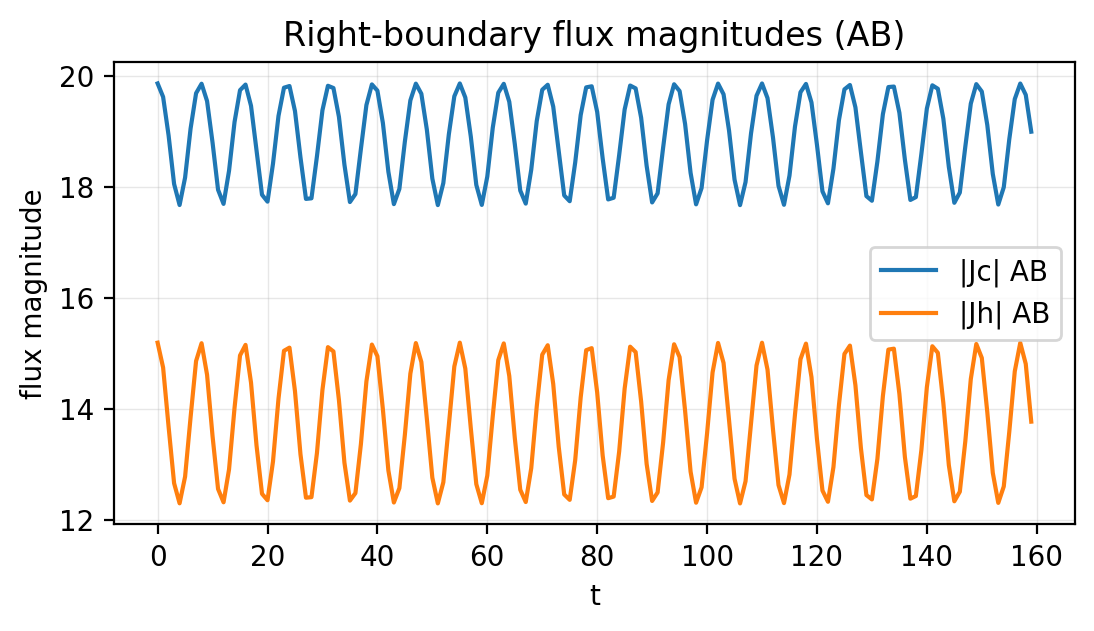

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# Utilities (reuse-compatible)
# ----------------------------
def sigmoid(kappa, x):
    z = np.clip(-kappa * x, -60.0, 60.0)
    return 1.0 / (1.0 + np.exp(z))

def run_channel(V, kappa, Vc):
    return sigmoid(kappa, V - Vc)

def aoi_positive_area(x):
    y = np.maximum(x - np.mean(x), 0.0)
    return float(np.trapezoid(y))

def blur_2d(field, passes=1):
    A = field.copy()
    for _ in range(int(passes)):
        A = 0.6*A + 0.1*(np.roll(A, 1, 0) + np.roll(A, -1, 0) + np.roll(A, 1, 1) + np.roll(A, -1, 1))
    return A

def make_base_fields(Nx, Ny, seed=0):
    rng = np.random.default_rng(seed)
    x = np.linspace(0, 2*np.pi, Nx, endpoint=False)
    y = np.linspace(0, 2*np.pi, Ny, endpoint=False)
    X, Y = np.meshgrid(x, y, indexing="ij")
    V0 = np.cos(X) + 0.7*np.cos(Y)
    Vchi = np.sin(2*X) - 0.6*np.sin(2*Y)
    return V0, Vchi

def build_time_field(V0_2d, Vchi_2d, lam_chi=0.0, lam_nu=0.0, lam_m=0.0, t=0, omega=0.8):
    V = V0_2d + lam_chi * Vchi_2d

    # momentum/advection as integer-pixel drift
    if lam_m != 0.0:
        shift = int(np.round(lam_m * t))
        V = np.roll(V, shift=shift, axis=1)

    drive = (1.0 + 0.25*np.cos(omega*t))
    V = drive * V

    if lam_nu != 0.0:
        passes = int(np.round(lam_nu))
        if passes > 0:
            V = blur_2d(V, passes=passes)

    return V

# ----------------------------
# Edge network helpers
# ----------------------------
def idx(i, j, Ny):
    return i*Ny + j

def neighbors_4(i, j, Nx, Ny):
    # periodic in y, open in x (so left/right boundaries are real)
    out = []
    if i > 0:      out.append((i-1, j))
    if i < Nx-1:   out.append((i+1, j))
    out.append((i, (j-1) % Ny))
    out.append((i, (j+1) % Ny))
    return out

def make_boundary_masks(Nx, Ny, width=2, seed=0, frac=0.35):
    """
    Define source/drain boundary 'contacts' on LEFT and RIGHT boundaries.
    We pick a subset of boundary sites (to emulate probes / constrictions).
    """
    rng = np.random.default_rng(seed)

    left_sites  = [(i, j) for i in range(width) for j in range(Ny)]
    right_sites = [(i, j) for i in range(Nx-width, Nx) for j in range(Ny)]

    def choose(sites):
        k = max(1, int(np.round(frac * len(sites))))
        pick = rng.choice(len(sites), size=k, replace=False)
        mask = np.zeros((Nx, Ny), dtype=bool)
        for p in pick:
            i, j = sites[p]
            mask[i, j] = True
        return mask

    maskL = choose(left_sites)
    maskR = choose(right_sites)
    return maskL, maskR

def edge_conductance_from_gate(p, p_floor=1e-3, beta=2.0):
    """
    Map gate-open probability p in [0,1] to an edge conductance scale.
    beta>1 makes it more "switch-like".
    """
    return p_floor + (p ** beta)

def compute_edge_fluxes(Nx, Ny, g_edge, mu, left_mask, right_mask):
    """
    Compute net flux leaving LEFT boundary into bulk (positive = left->bulk),
    and net flux entering RIGHT boundary from bulk (positive = bulk->right),
    using a simple resistor-like directed current:
        J_{u->v} = g_uv * (mu[u] - mu[v])
    We treat g_edge as symmetric per undirected neighbor pair (stored per node+dir via lookup).
    """
    # Build flux across boundary cuts: between i=0..(width-1) and i=width.. etc is messy;
    # Instead define boundary flux as sum over edges that connect boundary nodes to non-boundary nodes.
    J_left = 0.0
    J_right = 0.0

    # LEFT boundary: any node in left_mask, neighbor not in left_mask
    for i in range(Nx):
        for j in range(Ny):
            if not left_mask[i, j]:
                continue
            u = idx(i, j, Ny)
            for (ni, nj) in neighbors_4(i, j, Nx, Ny):
                if left_mask[ni, nj]:
                    continue
                v = idx(ni, nj, Ny)
                g = g_edge[u, v]
                J_left += g * (mu[u] - mu[v])

    # RIGHT boundary: any node in right_mask, neighbor not in right_mask
    for i in range(Nx):
        for j in range(Ny):
            if not right_mask[i, j]:
                continue
            u = idx(i, j, Ny)
            for (ni, nj) in neighbors_4(i, j, Nx, Ny):
                if right_mask[ni, nj]:
                    continue
                v = idx(ni, nj, Ny)
                g = g_edge[u, v]
                # flux leaving bulk into right boundary is opposite sign of (mu[u]-mu[v]) depending on orientation;
                # we define J_right positive when bulk->right, so boundary node is u: we want -(mu[u]-mu[v]).
                J_right += g * (mu[v] - mu[u])

    return float(J_left), float(J_right)

def build_g_edge_from_p(Nx, Ny, p2d, beta=2.0):
    """
    Construct a dense conductance matrix g_edge[u,v] for neighbor pairs only.
    (Dense is fine at 23x23; switch to sparse later.)
    """
    N = Nx * Ny
    g_edge = np.zeros((N, N), dtype=float)

    # Edge conductance uses mean(p_u, p_v) to couple nodes.
    pflat = p2d.reshape(-1)
    for i in range(Nx):
        for j in range(Ny):
            u = idx(i, j, Ny)
            for (ni, nj) in neighbors_4(i, j, Nx, Ny):
                v = idx(ni, nj, Ny)
                p_uv = 0.5*(pflat[u] + pflat[v])
                g = edge_conductance_from_gate(p_uv, beta=beta)
                g_edge[u, v] = g
                g_edge[v, u] = g
    return g_edge

# ----------------------------
# EdgeDiracGate: AB/BA + WF proxy
# ----------------------------
def run_edgediracgate_AB_BA_timeseries(
    Nx=23, Ny=23, T=160, omega=0.8,
    charge_params=(2.4, 0.0),
    heat_params=(1.0, -0.15),
    p_thresh=0.7,
    alpha=0.4,
    lam_chi=0.0, lam_nu=0.0, lam_m=0.0, lam_delta=0.0,
    seed=0,
    # edge/boundary controls
    contact_width=2,
    contact_frac=0.35,
    edge_beta_C=2.0,
    edge_beta_H=2.0,
    bias_mu=1.0,
    bias_T=1.0,
):
    V0_2d, Vchi_2d = make_base_fields(Nx, Ny, seed=seed)

    # boundary masks
    leftC, rightC = make_boundary_masks(Nx, Ny, width=contact_width, seed=seed+101, frac=contact_frac)
    leftH, rightH = make_boundary_masks(Nx, Ny, width=contact_width, seed=seed+202, frac=contact_frac)

    kC, VcC = charge_params
    kH, VcH = heat_params
    delta = float(lam_delta)

    # store reach-like series as before (optional)
    rC_AB = np.zeros(T)
    rH_AB = np.zeros(T)
    rC_BA = np.zeros(T)
    rH_BA = np.zeros(T)

    # store boundary currents (what we actually want for WF)s
    JC_L_AB = np.zeros(T); JC_R_AB = np.zeros(T)
    JH_L_AB = np.zeros(T); JH_R_AB = np.zeros(T)
    JC_L_BA = np.zeros(T); JC_R_BA = np.zeros(T)
    JH_L_BA = np.zeros(T); JH_R_BA = np.zeros(T)

    def reach_fraction(p_2d):
        return float(np.mean(p_2d > p_thresh))

    def schedule(order):
        rC = np.zeros(T); rH = np.zeros(T)
        JC_L = np.zeros(T); JC_R = np.zeros(T)
        JH_L = np.zeros(T); JH_R = np.zeros(T)

        for t in range(T):
            Vt = build_time_field(V0_2d, Vchi_2d, lam_chi=lam_chi, lam_nu=lam_nu, lam_m=lam_m, t=t, omega=omega)

            if order == "AB":
                pC = run_channel(Vt.reshape(-1) + delta, kC, VcC).reshape(Nx, Ny)
                Vt2 = Vt - alpha*(pC - pC.mean())
                pH = run_channel(Vt2.reshape(-1) - delta, kH, VcH).reshape(Nx, Ny)
            else:
                pH = run_channel(Vt.reshape(-1) - delta, kH, VcH).reshape(Nx, Ny)
                Vt2 = Vt - alpha*(pH - pH.mean())
                pC = run_channel(Vt2.reshape(-1) + delta, kC, VcC).reshape(Nx, Ny)

            # "reach" (bulk) series for continuity with prior figures
            rC[t] = reach_fraction(pC)
            rH[t] = reach_fraction(pH)

            # Edge conductances depend on gate openness
            gC = build_g_edge_from_p(Nx, Ny, pC, beta=edge_beta_C)
            gH = build_g_edge_from_p(Nx, Ny, pH, beta=edge_beta_H)


# define node potentials in 2D
            mu2d = pC.copy()
            TT2d = pH.copy()

# apply boundary biases WHILE STILL 2D
            mu2d[leftC]  += bias_mu
            mu2d[rightC] -= bias_mu
            TT2d[leftH]  += bias_T
            TT2d[rightH] -= bias_T

# flatten only after boundary conditions are applied
            mu = mu2d.reshape(-1)
            TT = TT2d.reshape(-1)
            # boundary currents
            JL, JR = compute_edge_fluxes(Nx, Ny, gC, mu.reshape(-1), leftC, rightC)
            HC, HR = compute_edge_fluxes(Nx, Ny, gH, TT.reshape(-1), leftH, rightH)

            JC_L[t], JC_R[t] = JL, JR
            JH_L[t], JH_R[t] = HC, HR

        return rC, rH, JC_L, JC_R, JH_L, JH_R

    rC_AB, rH_AB, JC_L_AB, JC_R_AB, JH_L_AB, JH_R_AB = schedule("AB")
    rC_BA, rH_BA, JC_L_BA, JC_R_BA, JH_L_BA, JH_R_BA = schedule("BA")

    # AOI metrics (as before)
    AOI_AB = aoi_positive_area(rC_AB - rH_AB)
    AOI_BA = aoi_positive_area(rC_BA - rH_BA)
    AOI_gap_signed = float(AOI_AB - AOI_BA)

    # WF proxy:
    # Use time-averaged boundary magnitudes, AB and BA separately.
    # Define "effective conductances": G ~ <|J_charge|>, K ~ <|J_heat|>
    # WF_proxy ~ K/(G + eps)
    eps = 1e-12
    G_AB = float(np.mean(np.abs(JC_R_AB)))
    K_AB = float(np.mean(np.abs(JH_R_AB)))
    G_BA = float(np.mean(np.abs(JC_R_BA)))
    K_BA = float(np.mean(np.abs(JH_R_BA)))

    WF_AB = float(K_AB / (G_AB + eps))
    WF_BA = float(K_BA / (G_BA + eps))
    WF_ratio = float(WF_AB / (WF_BA + eps))
    WF_excess = float(WF_AB - WF_BA)

    return {
        "rC_AB": rC_AB, "rH_AB": rH_AB, "rC_BA": rC_BA, "rH_BA": rH_BA,
        "AOI_AB": float(AOI_AB), "AOI_BA": float(AOI_BA), "AOI_gap_signed": AOI_gap_signed,
        "JC_R_AB": JC_R_AB, "JH_R_AB": JH_R_AB,
        "JC_R_BA": JC_R_BA, "JH_R_BA": JH_R_BA,
        "WF_AB": WF_AB, "WF_BA": WF_BA, "WF_ratio": WF_ratio, "WF_excess": WF_excess,
        "params": {
            "Nx": Nx, "Ny": Ny, "T": T, "omega": omega,
            "charge_params": tuple(charge_params), "heat_params": tuple(heat_params),
            "p_thresh": p_thresh, "alpha": alpha,
            "lam_chi": lam_chi, "lam_nu": lam_nu, "lam_m": lam_m, "lam_delta": lam_delta,
            "contact_width": contact_width, "contact_frac": contact_frac,
            "edge_beta_C": edge_beta_C, "edge_beta_H": edge_beta_H,
            "bias_mu": bias_mu, "bias_T": bias_T,
            "seed": seed,
        }
    }

# ----------------------------
# Quick sanity run + plot
# ----------------------------
out = run_edgediracgate_AB_BA_timeseries(
    alpha=0.4, T=160, seed=0,
    lam_chi=0.6, lam_delta=0.10,
    edge_beta_C=2.0, edge_beta_H=2.5,
    bias_mu=1.0, bias_T=1.0,
)

print("AOI-gap:", out["AOI_gap_signed"])
print("WF_AB, WF_BA, ratio:", out["WF_AB"], out["WF_BA"], out["WF_ratio"])

plt.figure(figsize=(6.2,3.0), dpi=200)
plt.plot(np.abs(out["JC_R_AB"]), label="|Jc| AB")
plt.plot(np.abs(out["JH_R_AB"]), label="|Jh| AB")
plt.legend()
plt.title("Right-boundary flux magnitudes (AB)")
plt.xlabel("t")
plt.ylabel("flux magnitude")
plt.grid(True, alpha=0.3, linewidth=0.5)
plt.show()

Nx=  9, Ny= 23, edge~0.444 | WF_AB=0.7448, WF_BA=0.7984, ratio=0.9328, AOI_gap=+0.6098
Nx= 13, Ny= 23, edge~0.308 | WF_AB=0.7278, WF_BA=0.7891, ratio=0.9222, AOI_gap=+0.3593
Nx= 17, Ny= 23, edge~0.235 | WF_AB=0.7262, WF_BA=0.7955, ratio=0.9129, AOI_gap=+0.1570
Nx= 23, Ny= 23, edge~0.174 | WF_AB=0.7280, WF_BA=0.8054, ratio=0.9039, AOI_gap=+0.0438
Nx= 31, Ny= 23, edge~0.129 | WF_AB=0.7316, WF_BA=0.8144, ratio=0.8983, AOI_gap=-0.0020
Nx= 41, Ny= 23, edge~0.098 | WF_AB=0.7353, WF_BA=0.8211, ratio=0.8955, AOI_gap=+0.0060
Saved: outputs/paperC_fig8A_geom_scaling.npz


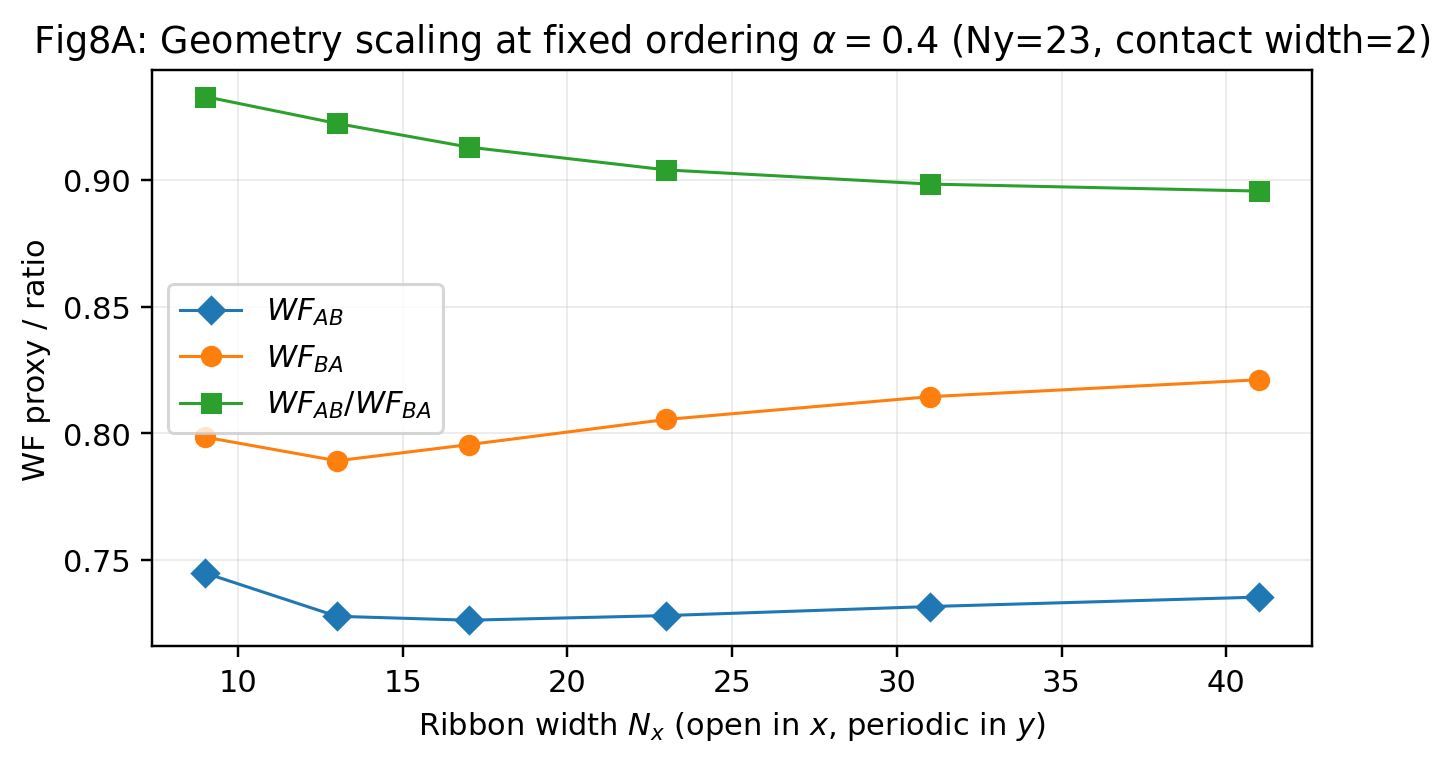

Saved: outputs/fig8A_geom_scaling.png


('outputs/paperC_fig8A_geom_scaling.npz', 'outputs/fig8A_geom_scaling.png')

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

def run_geom_scaling_sweep(
    outdir="outputs",
    npz_name="paperC_fig8A_geom_scaling.npz",
    png_name="fig8A_geom_scaling.png",
    Nx_list=(9, 13, 17, 23, 31, 41),
    Ny=23,
    T=160,
    omega=0.8,
    alpha=0.4,
    p_thresh=0.7,
    seed=0,
    lam_chi=0.6,
    lam_delta=0.10,
    lam_nu=0.0,
    lam_m=0.0,
    contact_width=2,
    contact_frac=0.35,
    edge_beta_C=2.0,
    edge_beta_H=2.5,
    bias_mu=1.0,
    bias_T=1.0,
):
    os.makedirs(outdir, exist_ok=True)

    records = []
    for Nx in Nx_list:
        out = run_edgediracgate_AB_BA_timeseries(
            Nx=int(Nx), Ny=int(Ny),
            T=int(T), omega=float(omega),
            charge_params=(2.4, 0.0),
            heat_params=(1.0, -0.15),
            p_thresh=float(p_thresh),
            alpha=float(alpha),
            lam_chi=float(lam_chi),
            lam_nu=float(lam_nu),
            lam_m=float(lam_m),
            lam_delta=float(lam_delta),
            seed=int(seed),
            contact_width=int(contact_width),
            contact_frac=float(contact_frac),
            edge_beta_C=float(edge_beta_C),
            edge_beta_H=float(edge_beta_H),
            bias_mu=float(bias_mu),
            bias_T=float(bias_T),
        )

        edge_fraction_x = float(2.0 * contact_width / max(1, Nx))

        rec = {
            "Nx": int(Nx),
            "Ny": int(Ny),
            "edge_fraction_x": edge_fraction_x,
            "AOI_gap": float(out["AOI_gap_signed"]),
            "WF_AB": float(out["WF_AB"]),
            "WF_BA": float(out["WF_BA"]),
            "WF_ratio": float(out["WF_ratio"]),
            "WF_excess": float(out["WF_excess"]),
            "params": out["params"],
        }
        records.append(rec)

        print(
            f"Nx={Nx:>3d}, Ny={Ny:>3d}, edge~{edge_fraction_x:.3f} | "
            f"WF_AB={rec['WF_AB']:.4f}, WF_BA={rec['WF_BA']:.4f}, ratio={rec['WF_ratio']:.4f}, AOI_gap={rec['AOI_gap']:+.4f}"
        )

    npz_path = os.path.join(outdir, npz_name)
    np.savez_compressed(npz_path, records=np.array(records, dtype=object))
    print("Saved:", npz_path)

    # ---- Plot ----
    Nx_arr = np.array([r["Nx"] for r in records], float)
    WF_AB = np.array([r["WF_AB"] for r in records], float)
    WF_BA = np.array([r["WF_BA"] for r in records], float)
    WF_ratio = np.array([r["WF_ratio"] for r in records], float)

    plt.figure(figsize=(6.8, 3.4), dpi=220)
    plt.plot(Nx_arr, WF_AB, marker="D", linewidth=1.0, label=r"$WF_{AB}$")
    plt.plot(Nx_arr, WF_BA, marker="o", linewidth=1.0, label=r"$WF_{BA}$")
    plt.plot(Nx_arr, WF_ratio, marker="s", linewidth=1.0, label=r"$WF_{AB}/WF_{BA}$")
    plt.grid(True, alpha=0.3, linewidth=0.5)
    plt.xlabel(r"Ribbon width $N_x$ (open in $x$, periodic in $y$)")
    plt.ylabel("WF proxy / ratio")
    plt.title(rf"Fig8A: Geometry scaling at fixed ordering $\alpha={alpha:g}$ (Ny={Ny}, contact width={contact_width})")
    plt.legend()

    png_path = os.path.join(outdir, png_name)
    plt.savefig(png_path, bbox_inches="tight")
    plt.show()
    print("Saved:", png_path)

    return npz_path, png_path

# --- RUN Fig8A ---
run_geom_scaling_sweep(
    outdir="outputs",
    Nx_list=(9, 13, 17, 23, 31, 41),
    Ny=23,
    T=160,
    alpha=0.4,
    seed=0,
    lam_chi=0.6,
    lam_delta=0.10,
    edge_beta_C=2.0,
    edge_beta_H=2.5,
    bias_mu=1.0,
    bias_T=1.0,
)

Saved: outputs/paperC_fig8B_chirality_thin_vs_fat.npz


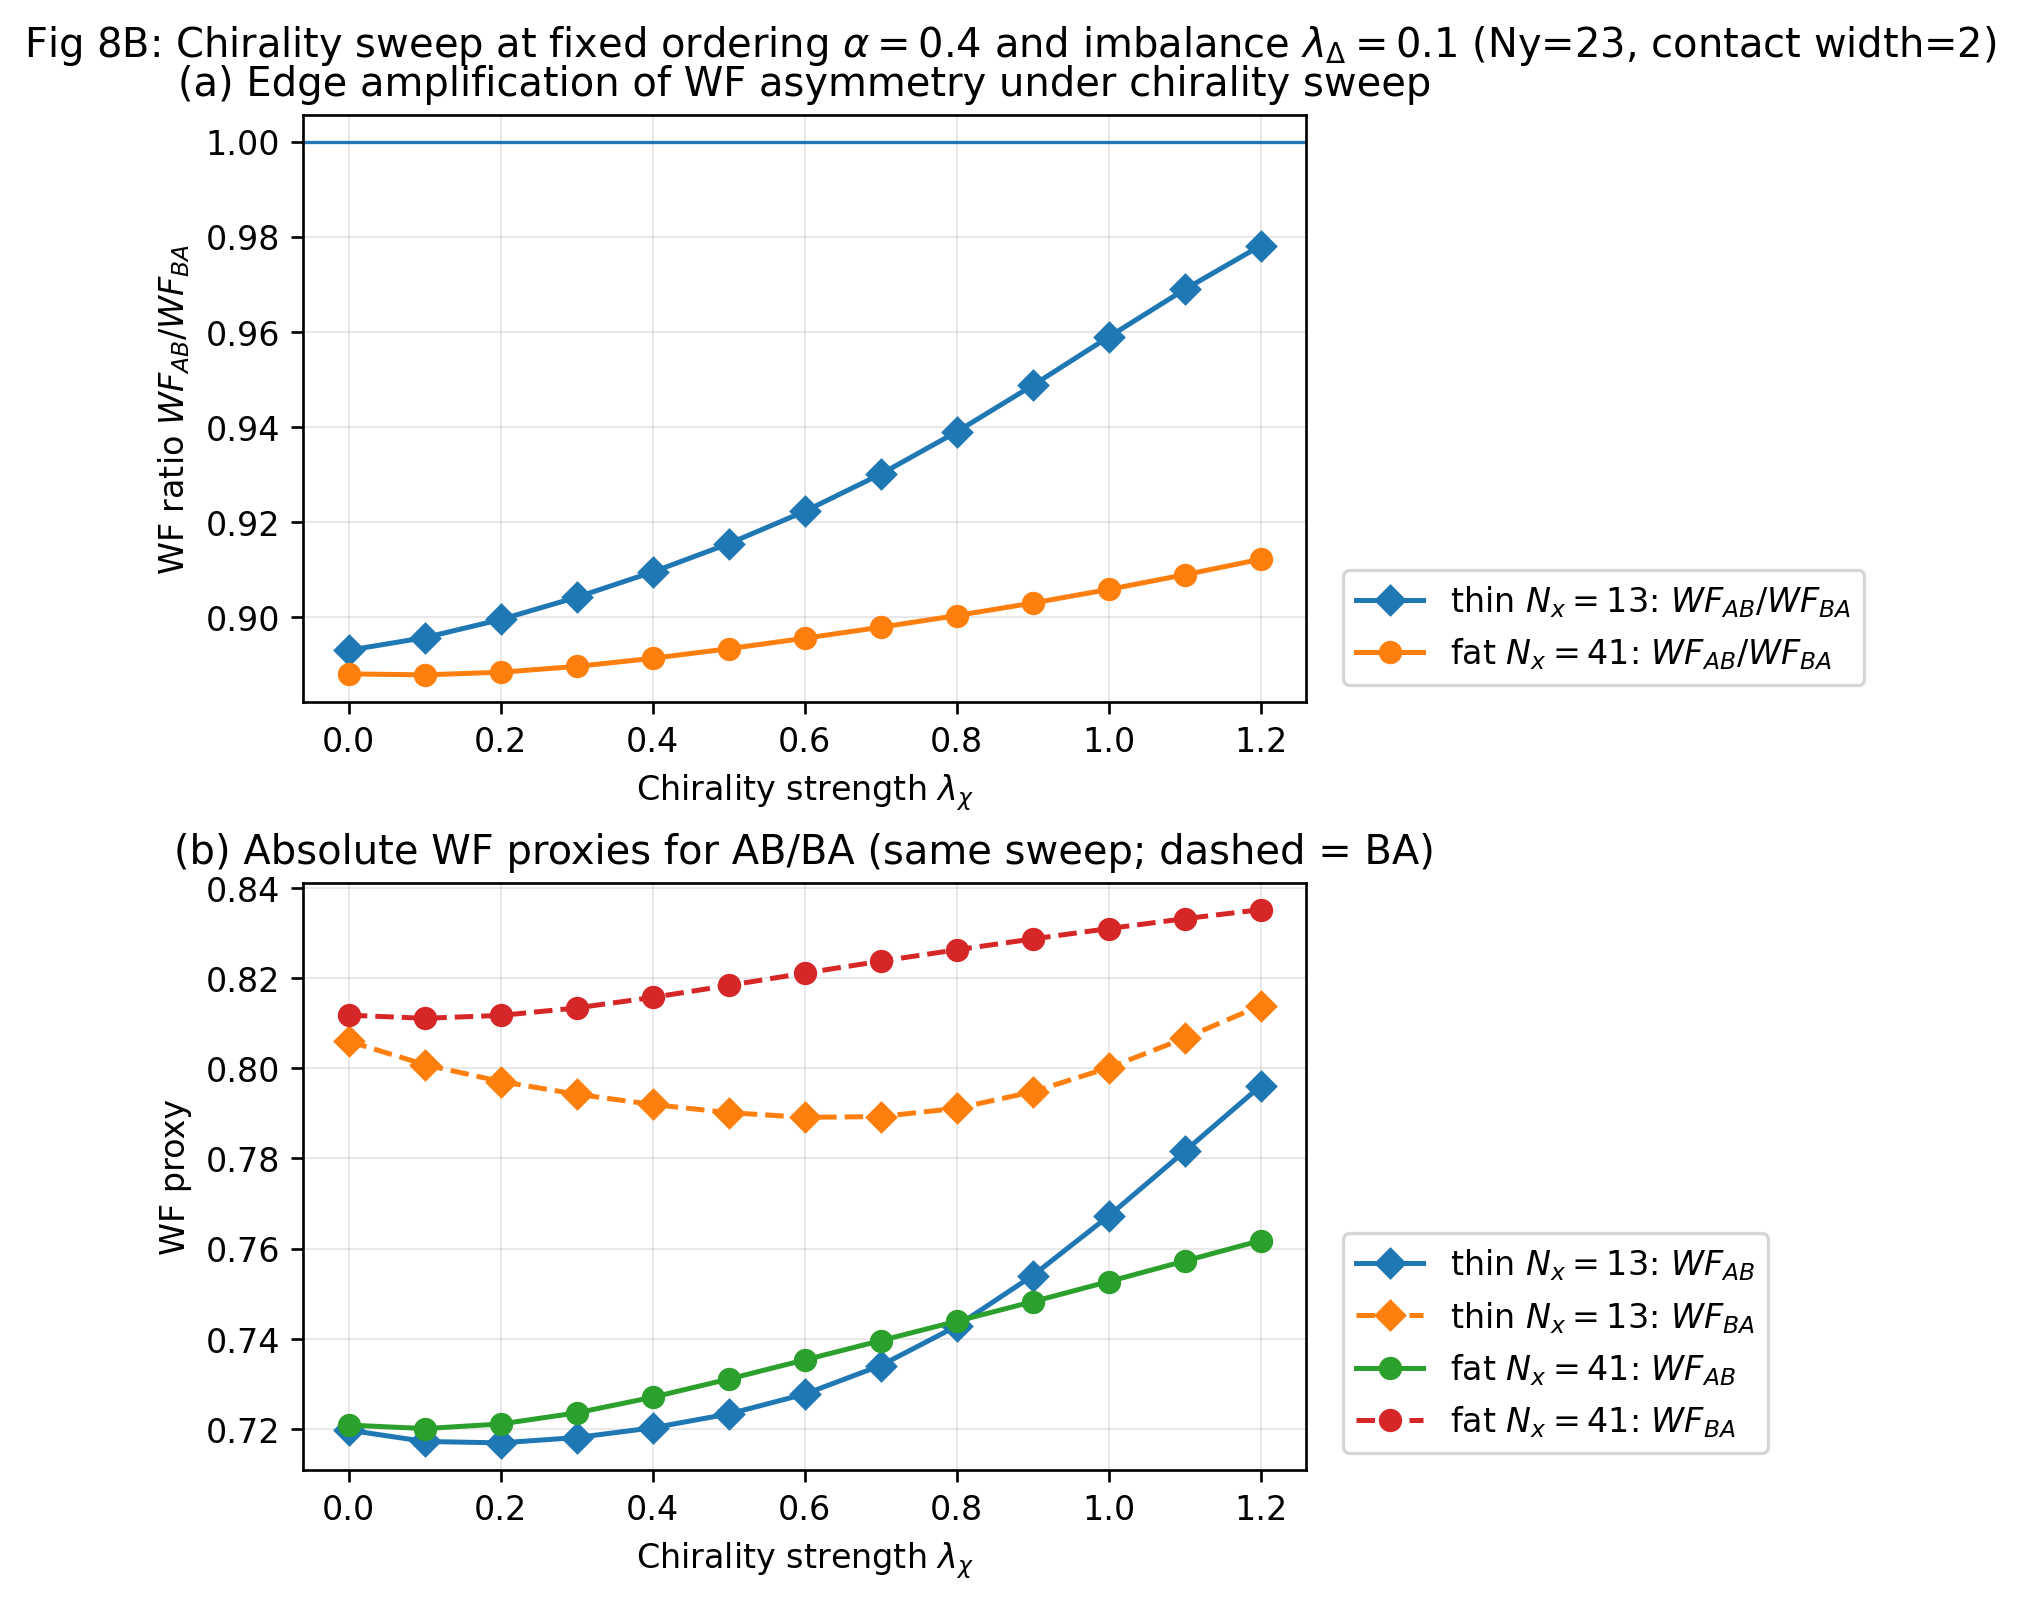

Saved: outputs/fig8B.png


('outputs/paperC_fig8B_chirality_thin_vs_fat.npz', 'outputs/fig8B.png')

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

def fig8B_chirality_sweep_thin_vs_fat(
    outdir="outputs",
    npz_name="paperC_fig8B_chirality_thin_vs_fat.npz",
    png_name="fig8B.png",
    # geometry
    Ny=23,
    Nx_thin=13,
    Nx_fat=41,
    # dynamics
    T=160,
    alpha=0.4,
    lam_delta=0.10,
    lam_nu=0.0,
    lam_m=0.0,
    omega=0.8,
    seed=0,
    # edge/boundary
    contact_width=2,
    contact_frac=0.35,
    edge_beta_C=2.0,
    edge_beta_H=2.5,
    bias_mu=1.0,
    bias_T=1.0,
    # sweep
    lam_chi_grid=None,
):
    os.makedirs(outdir, exist_ok=True)

    if lam_chi_grid is None:
        lam_chi_grid = np.round(np.linspace(0.0, 1.2, 13), 3)  # edit freely

    def run_one(Nx, lam_chi):
        out = run_edgediracgate_AB_BA_timeseries(
            Nx=int(Nx), Ny=int(Ny), T=int(T), omega=float(omega),
            alpha=float(alpha),
            lam_chi=float(lam_chi),
            lam_delta=float(lam_delta),
            lam_nu=float(lam_nu),
            lam_m=float(lam_m),
            seed=int(seed),
            contact_width=int(contact_width),
            contact_frac=float(contact_frac),
            edge_beta_C=float(edge_beta_C),
            edge_beta_H=float(edge_beta_H),
            bias_mu=float(bias_mu),
            bias_T=float(bias_T),
        )
        return dict(
            Nx=int(Nx),
            lam_chi=float(lam_chi),
            WF_AB=float(out["WF_AB"]),
            WF_BA=float(out["WF_BA"]),
            WF_ratio=float(out["WF_ratio"]),
            WF_excess=float(out["WF_excess"]),
            AOI_gap=float(out["AOI_gap_signed"]),
        )

    rec_thin = [run_one(Nx_thin, v) for v in lam_chi_grid]
    rec_fat  = [run_one(Nx_fat,  v) for v in lam_chi_grid]

    # Save
    npz_path = os.path.join(outdir, npz_name)
    np.savez_compressed(
        npz_path,
        meta=dict(
            Ny=int(Ny),
            Nx_thin=int(Nx_thin),
            Nx_fat=int(Nx_fat),
            T=int(T),
            alpha=float(alpha),
            lam_delta=float(lam_delta),
            lam_nu=float(lam_nu),
            lam_m=float(lam_m),
            omega=float(omega),
            seed=int(seed),
            contact_width=int(contact_width),
            contact_frac=float(contact_frac),
            edge_beta_C=float(edge_beta_C),
            edge_beta_H=float(edge_beta_H),
            bias_mu=float(bias_mu),
            bias_T=float(bias_T),
            lam_chi_grid=np.array(lam_chi_grid, float),
        ),
        rec_thin=np.array(rec_thin, dtype=object),
        rec_fat=np.array(rec_fat, dtype=object),
    )
    print("Saved:", npz_path)

    # Extract arrays for plotting
    x = np.array(lam_chi_grid, float)

    thin_ratio = np.array([r["WF_ratio"] for r in rec_thin], float)
    fat_ratio  = np.array([r["WF_ratio"] for r in rec_fat],  float)

    thin_AB = np.array([r["WF_AB"] for r in rec_thin], float)
    thin_BA = np.array([r["WF_BA"] for r in rec_thin], float)
    fat_AB  = np.array([r["WF_AB"] for r in rec_fat],  float)
    fat_BA  = np.array([r["WF_BA"] for r in rec_fat],  float)

    # Plot: 2 panels (ratio + absolute AB/BA), tight and readable
    fig, axes = plt.subplots(2, 1, figsize=(7.2, 6.4), dpi=240, constrained_layout=True)

    ax = axes[0]
    ax.plot(x, thin_ratio, marker="D", label=rf"thin $N_x={Nx_thin}$: $WF_{{AB}}/WF_{{BA}}$")
    ax.plot(x, fat_ratio,  marker="o", label=rf"fat $N_x={Nx_fat}$: $WF_{{AB}}/WF_{{BA}}$")
    ax.axhline(1.0, linewidth=1.0)
    ax.set_title(r"(a) Edge amplification of WF asymmetry under chirality sweep")
    ax.set_xlabel(r"Chirality strength $\lambda_\chi$")
    ax.set_ylabel(r"WF ratio $WF_{AB}/WF_{BA}$")
    ax.grid(True, alpha=0.35, linewidth=0.5)
    ax.legend(loc="lower left", bbox_to_anchor=(1.02, 0.0), frameon=True)

    ax = axes[1]
    ax.plot(x, thin_AB, marker="D", label=rf"thin $N_x={Nx_thin}$: $WF_{{AB}}$")
    ax.plot(x, thin_BA, marker="D", linestyle="--", label=rf"thin $N_x={Nx_thin}$: $WF_{{BA}}$")
    ax.plot(x, fat_AB,  marker="o", label=rf"fat $N_x={Nx_fat}$: $WF_{{AB}}$")
    ax.plot(x, fat_BA,  marker="o", linestyle="--", label=rf"fat $N_x={Nx_fat}$: $WF_{{BA}}$")
    ax.set_title(r"(b) Absolute WF proxies for AB/BA (same sweep; dashed = BA)")
    ax.set_xlabel(r"Chirality strength $\lambda_\chi$")
    ax.set_ylabel(r"WF proxy")
    ax.grid(True, alpha=0.35, linewidth=0.5)
    ax.legend(loc="lower left", bbox_to_anchor=(1.02, 0.0), frameon=True)

    fig.suptitle(
        rf"Fig 8B: Chirality sweep at fixed ordering $\alpha={alpha:g}$ and imbalance $\lambda_\Delta={lam_delta:g}$ "
        rf"(Ny={Ny}, contact width={contact_width})",
        y=1.02
    )

    png_path = os.path.join(outdir, png_name)
    plt.savefig(png_path, bbox_inches="tight")
    plt.show()
    print("Saved:", png_path)

    return npz_path, png_path


# ---- RUN FIG 8B ----
fig8B_chirality_sweep_thin_vs_fat(
    outdir="outputs",
    npz_name="paperC_fig8B_chirality_thin_vs_fat.npz",
    png_name="fig8B.png",
    Ny=23,
    Nx_thin=13,
    Nx_fat=41,
    T=160,
    alpha=0.4,
    lam_delta=0.10,
    edge_beta_C=2.0,
    edge_beta_H=2.5,
    bias_mu=1.0,
    bias_T=1.0,
    seed=0,
    lam_chi_grid=np.round(np.linspace(0.0, 1.2, 13), 3),
)

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

def fig8C_crossing_map_lambda_delta(
    outdir="outputs",
    npz_name="paperC_fig8C_crossing_map_lambdaDelta.npz",
    png_name="fig8C.png",
    # fixed conditions (match 8B where appropriate)
    alpha=0.4,
    T=160,
    Ny=23,
    Nx=13,                 # choose thin or fat here; you can run twice for Nx=13 and Nx=41
    seed=0,
    p_thresh=0.7,
    # edge/boundary settings (match your edge model choices)
    contact_width=2,
    contact_frac=0.35,
    edge_beta_C=2.0,
    edge_beta_H=2.5,
    bias_mu=1.0,
    bias_T=1.0,
    # grid
    lam_chi_grid=None,
    lam_delta_grid=None,
    # for 1D slice panel
    slice_lam_delta=(0.0, 0.05, 0.10, 0.15),
):
    """
    Fig 8C(a): heatmap of WF ratio rho = WF_AB / WF_BA over (lam_chi, lam_delta)
              with contour rho=1 (crossing boundary).
    Fig 8C(b): 1D slices rho(lam_chi) at selected lam_delta values.
    Saves NPZ with grids + computed surfaces.
    """
    os.makedirs(outdir, exist_ok=True)

    if lam_chi_grid is None:
        lam_chi_grid = np.round(np.linspace(0.0, 1.2, 13), 3)   # coarse default; densify if you like
    if lam_delta_grid is None:
        lam_delta_grid = np.round(np.linspace(0.0, 0.25, 11), 3)

    lam_chi_grid = np.asarray(lam_chi_grid, float)
    lam_delta_grid = np.asarray(lam_delta_grid, float)

    nD = len(lam_delta_grid)
    nC = len(lam_chi_grid)

    WF_AB = np.full((nD, nC), np.nan, float)
    WF_BA = np.full((nD, nC), np.nan, float)
    rho   = np.full((nD, nC), np.nan, float)
    dWF   = np.full((nD, nC), np.nan, float)
    AOI   = np.full((nD, nC), np.nan, float)

    eps = 1e-12

    # --- compute grid ---
    for iD, lam_delta in enumerate(lam_delta_grid):
        for iC, lam_chi in enumerate(lam_chi_grid):
            out = run_edgediracgate_AB_BA_timeseries(
                Nx=int(Nx), Ny=int(Ny), T=int(T),
                p_thresh=float(p_thresh),
                alpha=float(alpha),
                lam_chi=float(lam_chi),
                lam_delta=float(lam_delta),
                lam_nu=0.0, lam_m=0.0,
                seed=int(seed),
                contact_width=int(contact_width),
                contact_frac=float(contact_frac),
                edge_beta_C=float(edge_beta_C),
                edge_beta_H=float(edge_beta_H),
                bias_mu=float(bias_mu),
                bias_T=float(bias_T),
            )

            WF_AB[iD, iC] = float(out["WF_AB"])
            WF_BA[iD, iC] = float(out["WF_BA"])
            AOI[iD, iC]   = float(out.get("AOI_gap_signed", np.nan))

            rho[iD, iC] = float(WF_AB[iD, iC] / (WF_BA[iD, iC] + eps))
            dWF[iD, iC] = float(WF_AB[iD, iC] - WF_BA[iD, iC])

    # --- save NPZ ---
    rec = {
        "meta": {
            "alpha": float(alpha), "T": int(T), "Nx": int(Nx), "Ny": int(Ny),
            "seed": int(seed), "p_thresh": float(p_thresh),
            "contact_width": int(contact_width), "contact_frac": float(contact_frac),
            "edge_beta_C": float(edge_beta_C), "edge_beta_H": float(edge_beta_H),
            "bias_mu": float(bias_mu), "bias_T": float(bias_T),
        },
        "lam_chi_grid": lam_chi_grid,
        "lam_delta_grid": lam_delta_grid,
        "WF_AB": WF_AB,
        "WF_BA": WF_BA,
        "rho": rho,
        "dWF": dWF,
        "AOI_gap": AOI,
    }
    npz_path = os.path.join(outdir, npz_name)
    np.savez_compressed(npz_path, records=np.array(rec, dtype=object))
    print("Saved:", npz_path)

    # --- plot Fig 8C ---
    fig = plt.figure(figsize=(7.6, 6.6), dpi=240, constrained_layout=True)
    gs = fig.add_gridspec(2, 1, height_ratios=[1.15, 1.0])

    # (a) heatmap of rho with rho=1 contour
    ax = fig.add_subplot(gs[0, 0])
    X, Y = np.meshgrid(lam_chi_grid, lam_delta_grid)

    im = ax.pcolormesh(X, Y, rho, shading="nearest")
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label(r"$\rho = WF_{AB}/WF_{BA}$")

    # crossing line: rho = 1
    try:
        ax.contour(X, Y, rho, levels=[1.0], linewidths=2.0)
    except Exception:
        pass

    ax.set_title(r"(a) Crossing map: WF ratio $\rho(\lambda_\chi,\lambda_\Delta)$  (contour $\rho=1$)")
    ax.set_xlabel(r"Chirality strength $\lambda_\chi$")
    ax.set_ylabel(r"Imbalance strength $\lambda_\Delta$")
    ax.grid(True, alpha=0.25, linewidth=0.5)

    # (b) slices rho(lam_chi) at selected lam_delta
    ax = fig.add_subplot(gs[1, 0])
    for target in slice_lam_delta:
        # nearest lam_delta on grid
        j = int(np.argmin(np.abs(lam_delta_grid - float(target))))
        ax.plot(lam_chi_grid, rho[j, :], marker="o", linewidth=1.5, label=rf"$\lambda_\Delta \approx {lam_delta_grid[j]:g}$")

    ax.axhline(1.0, linewidth=1.0)
    ax.set_title(r"(b) Slices: $\rho(\lambda_\chi)$ at selected $\lambda_\Delta$  (line at $\rho=1$)")
    ax.set_xlabel(r"Chirality strength $\lambda_\chi$")
    ax.set_ylabel(r"$WF_{AB}/WF_{BA}$")
    ax.grid(True, alpha=0.25, linewidth=0.5)
    ax.legend(loc="best", frameon=True)

    fig.suptitle(rf"Fig 8C: WF crossing test vs $(\lambda_\chi,\lambda_\Delta)$ at fixed ordering $\alpha={alpha:g}$ (Nx={Nx}, Ny={Ny})")

    png_path = os.path.join(outdir, png_name)
    plt.savefig(png_path, bbox_inches="tight")
    plt.show()
    print("Saved:", png_path)

    return npz_path, png_path


# --- RUN EXAMPLE (thin ribbon, match 8B-ish) ---
# fig8C_crossing_map_lambda_delta(
  #  outdir="outputs",
  ## png_name="fig8C_thin.png",
  ###Nx=13,
  ####y=23,
  #####pha=0.4,
  ######60,
  #######=0,
  ########hi_grid=np.round(np.linspace(0.0, 1.2, 13), 3),
  #########lta_grid=np.round(np.linspace(0.0, 0.25, 11), 3),
  ##########am_delta=(0.0, 0.05, 0.10, 0.15, 0.20),
###########
###########

# --- OPTIONAL: run fat ribbon too ---
fig8C_crossing_map_lambda_delta(
     outdir="outputs",
     png_name="fig8C_fat.png",
     Nx=41,
     Ny=23,
     alpha=0.4,
     T=160,
     seed=0,
     lam_chi_grid=np.round(np.linspace(0.0, 1.2, 13), 3),
     lam_delta_grid=np.round(np.linspace(0.0, 0.25, 11), 3),
     slice_lam_delta=(0.0, 0.05, 0.10, 0.15, 0.20),
 )


KeyboardInterrupt



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# Utilities (reuse-compatible)
# ----------------------------
def sigmoid(kappa, x):
    z = np.clip(-kappa * x, -60.0, 60.0)
    return 1.0 / (1.0 + np.exp(z))

def run_channel(V, kappa, Vc):
    return sigmoid(kappa, V - Vc)

def aoi_positive_area(x):
    y = np.maximum(x - np.mean(x), 0.0)
    return float(np.trapezoid(y))

def blur_2d(field, passes=1):
    A = field.copy()
    for _ in range(int(passes)):
        A = 0.6*A + 0.1*(np.roll(A, 1, 0) + np.roll(A, -1, 0) + np.roll(A, 1, 1) + np.roll(A, -1, 1))
    return A

def make_base_fields(Nx, Ny, seed=0):
    rng = np.random.default_rng(seed)
    x = np.linspace(0, 2*np.pi, Nx, endpoint=False)
    y = np.linspace(0, 2*np.pi, Ny, endpoint=False)
    X, Y = np.meshgrid(x, y, indexing="ij")
    V0 = np.cos(X) + 0.7*np.cos(Y)
    Vchi = np.sin(2*X) - 0.6*np.sin(2*Y)
    return V0, Vchi

def build_time_field(V0_2d, Vchi_2d, lam_chi=0.0, lam_nu=0.0, lam_m=0.0, t=0, omega=0.8):
    V = V0_2d + lam_chi * Vchi_2d

    # momentum/advection as integer-pixel drift
    if lam_m != 0.0:
        shift = int(np.round(lam_m * t))
        V = np.roll(V, shift=shift, axis=1)

    drive = (1.0 + 0.25*np.cos(omega*t))
    V = drive * V

    if lam_nu != 0.0:
        passes = int(np.round(lam_nu))
        if passes > 0:
            V = blur_2d(V, passes=passes)

    return V

# ----------------------------
# Edge network helpers
# ----------------------------
def idx(i, j, Ny):
    return i*Ny + j

def neighbors_4(i, j, Nx, Ny):
    # periodic in y, open in x (so left/right boundaries are real)
    out = []
    if i > 0:      out.append((i-1, j))
    if i < Nx-1:   out.append((i+1, j))
    out.append((i, (j-1) % Ny))
    out.append((i, (j+1) % Ny))
    return out

def make_boundary_masks(Nx, Ny, width=2, seed=0, frac=0.35):
    """
    Define source/drain boundary 'contacts' on LEFT and RIGHT boundaries.
    We pick a subset of boundary sites (to emulate probes / constrictions).
    """
    rng = np.random.default_rng(seed)

    left_sites  = [(i, j) for i in range(width) for j in range(Ny)]
    right_sites = [(i, j) for i in range(Nx-width, Nx) for j in range(Ny)]

    def choose(sites):
        k = max(1, int(np.round(frac * len(sites))))
        pick = rng.choice(len(sites), size=k, replace=False)
        mask = np.zeros((Nx, Ny), dtype=bool)
        for p in pick:
            i, j = sites[p]
            mask[i, j] = True
        return mask

    maskL = choose(left_sites)
    maskR = choose(right_sites)
    return maskL, maskR

def edge_conductance_from_gate(p, p_floor=1e-3, beta=2.0):
    """
    Map gate-open probability p in [0,1] to an edge conductance scale.
    beta>1 makes it more "switch-like".
    """
    return p_floor + (p ** beta)

def compute_edge_fluxes(Nx, Ny, g_edge, mu, left_mask, right_mask):
    """
    Compute net flux leaving LEFT boundary into bulk (positive = left->bulk),
    and net flux entering RIGHT boundary from bulk (positive = bulk->right),
    using a simple resistor-like directed current:
        J_{u->v} = g_uv * (mu[u] - mu[v])
    We treat g_edge as symmetric per undirected neighbor pair (stored per node+dir via lookup).
    """
    # Build flux across boundary cuts: between i=0..(width-1) and i=width.. etc is messy;
    # Instead define boundary flux as sum over edges that connect boundary nodes to non-boundary nodes.
    J_left = 0.0
    J_right = 0.0

    # LEFT boundary: any node in left_mask, neighbor not in left_mask
    for i in range(Nx):
        for j in range(Ny):
            if not left_mask[i, j]:
                continue
            u = idx(i, j, Ny)
            for (ni, nj) in neighbors_4(i, j, Nx, Ny):
                if left_mask[ni, nj]:
                    continue
                v = idx(ni, nj, Ny)
                g = g_edge[u, v]
                J_left += g * (mu[u] - mu[v])

    # RIGHT boundary: any node in right_mask, neighbor not in right_mask
    for i in range(Nx):
        for j in range(Ny):
            if not right_mask[i, j]:
                continue
            u = idx(i, j, Ny)
            for (ni, nj) in neighbors_4(i, j, Nx, Ny):
                if right_mask[ni, nj]:
                    continue
                v = idx(ni, nj, Ny)
                g = g_edge[u, v]
                # flux leaving bulk into right boundary is opposite sign of (mu[u]-mu[v]) depending on orientation;
                # we define J_right positive when bulk->right, so boundary node is u: we want -(mu[u]-mu[v]).
                J_right += g * (mu[v] - mu[u])

    return float(J_left), float(J_right)

def build_g_edge_from_p(Nx, Ny, p2d, beta=2.0):
    """
    Construct a dense conductance matrix g_edge[u,v] for neighbor pairs only.
    (Dense is fine at 23x23; switch to sparse later.)
    """
    N = Nx * Ny
    g_edge = np.zeros((N, N), dtype=float)

    # Edge conductance uses mean(p_u, p_v) to couple nodes.
    pflat = p2d.reshape(-1)
    for i in range(Nx):
        for j in range(Ny):
            u = idx(i, j, Ny)
            for (ni, nj) in neighbors_4(i, j, Nx, Ny):
                v = idx(ni, nj, Ny)
                p_uv = 0.5*(pflat[u] + pflat[v])
                g = edge_conductance_from_gate(p_uv, beta=beta)
                g_edge[u, v] = g
                g_edge[v, u] = g
    return g_edge

# ----------------------------
# EdgeDiracGate: AB/BA + WF proxy
# ----------------------------
def run_edgediracgate_AB_BA_timeseries(
    Nx=23, Ny=23, T=160, omega=0.8,
    charge_params=(2.4, 0.0),
    heat_params=(1.0, -0.15),
    p_thresh=0.7,
    alpha=0.4,
    lam_chi=0.0, lam_nu=0.0, lam_m=0.0, lam_delta=0.0,
    seed=0,
    # edge/boundary controls
    contact_width=2,
    contact_frac=0.35,
    edge_beta_C=2.0,
    edge_beta_H=2.0,
    bias_mu=1.0,
    bias_T=1.0,
):
    V0_2d, Vchi_2d = make_base_fields(Nx, Ny, seed=seed)

    # boundary masks
    leftC, rightC = make_boundary_masks(Nx, Ny, width=contact_width, seed=seed+101, frac=contact_frac)
    leftH, rightH = make_boundary_masks(Nx, Ny, width=contact_width, seed=seed+202, frac=contact_frac)

    kC, VcC = charge_params
    kH, VcH = heat_params
    delta = float(lam_delta)

    # store reach-like series as before (optional)
    rC_AB = np.zeros(T)
    rH_AB = np.zeros(T)
    rC_BA = np.zeros(T)
    rH_BA = np.zeros(T)

    # store boundary currents (what we actually want for WF)s
    JC_L_AB = np.zeros(T); JC_R_AB = np.zeros(T)
    JH_L_AB = np.zeros(T); JH_R_AB = np.zeros(T)
    JC_L_BA = np.zeros(T); JC_R_BA = np.zeros(T)
    JH_L_BA = np.zeros(T); JH_R_BA = np.zeros(T)

    def reach_fraction(p_2d):
        return float(np.mean(p_2d > p_thresh))

    def schedule(order):
        rC = np.zeros(T); rH = np.zeros(T)
        JC_L = np.zeros(T); JC_R = np.zeros(T)
        JH_L = np.zeros(T); JH_R = np.zeros(T)

        for t in range(T):
            Vt = build_time_field(V0_2d, Vchi_2d, lam_chi=lam_chi, lam_nu=lam_nu, lam_m=lam_m, t=t, omega=omega)

            if order == "AB":
                pC = run_channel(Vt.reshape(-1) + delta, kC, VcC).reshape(Nx, Ny)
                Vt2 = Vt - alpha*(pC - pC.mean())
                pH = run_channel(Vt2.reshape(-1) - delta, kH, VcH).reshape(Nx, Ny)
            else:
                pH = run_channel(Vt.reshape(-1) - delta, kH, VcH).reshape(Nx, Ny)
                Vt2 = Vt - alpha*(pH - pH.mean())
                pC = run_channel(Vt2.reshape(-1) + delta, kC, VcC).reshape(Nx, Ny)

            # "reach" (bulk) series for continuity with prior figures
            rC[t] = reach_fraction(pC)
            rH[t] = reach_fraction(pH)

            # Edge conductances depend on gate openness
            gC = build_g_edge_from_p(Nx, Ny, pC, beta=edge_beta_C)
            gH = build_g_edge_from_p(Nx, Ny, pH, beta=edge_beta_H)


# define node potentials in 2D
            mu2d = pC.copy()
            TT2d = pH.copy()

# apply boundary biases WHILE STILL 2D
            mu2d[leftC]  += bias_mu
            mu2d[rightC] -= bias_mu
            TT2d[leftH]  += bias_T
            TT2d[rightH] -= bias_T

# flatten only after boundary conditions are applied
            mu = mu2d.reshape(-1)
            TT = TT2d.reshape(-1)
            # boundary currents
            JL, JR = compute_edge_fluxes(Nx, Ny, gC, mu.reshape(-1), leftC, rightC)
            HC, HR = compute_edge_fluxes(Nx, Ny, gH, TT.reshape(-1), leftH, rightH)

            JC_L[t], JC_R[t] = JL, JR
            JH_L[t], JH_R[t] = HC, HR

        return rC, rH, JC_L, JC_R, JH_L, JH_R

    rC_AB, rH_AB, JC_L_AB, JC_R_AB, JH_L_AB, JH_R_AB = schedule("AB")
    rC_BA, rH_BA, JC_L_BA, JC_R_BA, JH_L_BA, JH_R_BA = schedule("BA")

    # AOI metrics (as before)
    AOI_AB = aoi_positive_area(rC_AB - rH_AB)
    AOI_BA = aoi_positive_area(rC_BA - rH_BA)
    AOI_gap_signed = float(AOI_AB - AOI_BA)

    # WF proxy:
    # Use time-averaged boundary magnitudes, AB and BA separately.
    # Define "effective conductances": G ~ <|J_charge|>, K ~ <|J_heat|>
    # WF_proxy ~ K/(G + eps)
    eps = 1e-12
    G_AB = float(np.mean(np.abs(JC_R_AB)))
    K_AB = float(np.mean(np.abs(JH_R_AB)))
    G_BA = float(np.mean(np.abs(JC_R_BA)))
    K_BA = float(np.mean(np.abs(JH_R_BA)))

    WF_AB = float(K_AB / (G_AB + eps))
    WF_BA = float(K_BA / (G_BA + eps))
    WF_ratio = float(WF_AB / (WF_BA + eps))
    WF_excess = float(WF_AB - WF_BA)

    return {
        "rC_AB": rC_AB, "rH_AB": rH_AB, "rC_BA": rC_BA, "rH_BA": rH_BA,
        "AOI_AB": float(AOI_AB), "AOI_BA": float(AOI_BA), "AOI_gap_signed": AOI_gap_signed,
        "JC_R_AB": JC_R_AB, "JH_R_AB": JH_R_AB,
        "JC_R_BA": JC_R_BA, "JH_R_BA": JH_R_BA,
        "WF_AB": WF_AB, "WF_BA": WF_BA, "WF_ratio": WF_ratio, "WF_excess": WF_excess,
        "params": {
            "Nx": Nx, "Ny": Ny, "T": T, "omega": omega,
            "charge_params": tuple(charge_params), "heat_params": tuple(heat_params),
            "p_thresh": p_thresh, "alpha": alpha,
            "lam_chi": lam_chi, "lam_nu": lam_nu, "lam_m": lam_m, "lam_delta": lam_delta,
            "contact_width": contact_width, "contact_frac": contact_frac,
            "edge_beta_C": edge_beta_C, "edge_beta_H": edge_beta_H,
            "bias_mu": bias_mu, "bias_T": bias_T,
            "seed": seed,
        }
    }

# -----------------------------
# helpers: robust key access
# -----------------------------
def _get_series(out, key):
    if key in out:
        return np.asarray(out[key], float)
    if "series" in out and key in out["series"]:
        return np.asarray(out["series"][key], float)
    raise KeyError(f"Missing series '{key}'. Keys: {list(out.keys())} (and maybe out['series'])")

def wf_metrics_from_out(out, use_right_boundary=True):
    # Expect boundary flux time-series for AB and BA
    JcAB = np.abs(_get_series(out, "JC_R_AB"))
    JhAB = np.abs(_get_series(out, "JH_R_AB"))
    JcBA = np.abs(_get_series(out, "JC_R_BA"))
    JhBA = np.abs(_get_series(out, "JH_R_BA"))

    eps = 1e-12
    G_AB = float(np.mean(JcAB))
    K_AB = float(np.mean(JhAB))
    G_BA = float(np.mean(JcBA))
    K_BA = float(np.mean(JhBA))

    WF_AB = K_AB / (G_AB + eps)
    WF_BA = K_BA / (G_BA + eps)
    WF_ratio = WF_AB / (WF_BA + eps)
    WF_excess = WF_AB - WF_BA

    # also a "cumulative" ratio curve (often shows memory/ratchet more clearly)
    cum_WF_AB = np.cumsum(JhAB) / (np.cumsum(JcAB) + eps)
    cum_WF_BA = np.cumsum(JhBA) / (np.cumsum(JcBA) + eps)
    cum_ratio = cum_WF_AB / (cum_WF_BA + eps)

    return dict(
        WF_AB=float(WF_AB), WF_BA=float(WF_BA),
        WF_ratio=float(WF_ratio), WF_excess=float(WF_excess),
        cum_ratio_end=float(cum_ratio[-1]),
    )

# -----------------------------
# the sweep (coarse, sensible)
# -----------------------------
def sweep_for_wf_spike(
    run_fn,
    Ny=23,
    T=160,
    alpha=0.4,
    p_thresh=0.7,
    seed=0,
    # widths: thin vs fat (your story lives here)
    Nx_list=(13, 23, 31, 41),
    # main knobs
    lam_chi_list=(0.0, 0.4, 0.8, 1.2),
    lam_delta_list=(0.0, 0.05, 0.10, 0.15, 0.25, 0.35),
    # edge â€œswitchinessâ€
    betaC_list=(1.5, 2.0, 3.0),
    betaH_list=(1.5, 2.5, 4.0),
    # boundary drive (crucial)
    bias_mu_list=(0.5, 1.0, 2.0),
    bias_T_list=(0.5, 1.0, 2.0),
    # contacts
    contact_width_list=(1, 2),
    contact_frac=0.35,
    # keep other modes off for now
    lam_nu=0.0, lam_m=0.0,
    # optional: hard cap of evaluations
    max_evals=None,
):
    rows = []
    n_eval = 0

    for Nx in Nx_list:
        for lam_chi in lam_chi_list:
            for lam_delta in lam_delta_list:
                for betaC in betaC_list:
                    for betaH in betaH_list:
                        for bias_mu in bias_mu_list:
                            for bias_T in bias_T_list:
                                for cw in contact_width_list:
                                    params = dict(
                                        Nx=int(Nx), Ny=int(Ny), T=int(T),
                                        alpha=float(alpha), p_thresh=float(p_thresh),
                                        lam_chi=float(lam_chi),
                                        lam_delta=float(lam_delta),
                                        lam_nu=float(lam_nu),
                                        lam_m=float(lam_m),
                                        edge_beta_C=float(betaC),
                                        edge_beta_H=float(betaH),
                                        bias_mu=float(bias_mu),
                                        bias_T=float(bias_T),
                                        contact_width=int(cw),
                                        contact_frac=float(contact_frac),
                                        seed=int(seed),
                                    )
                                    out = run_fn(**params)
                                    m = wf_metrics_from_out(out)

                                    rows.append({
                                        **params,
                                        **m,
                                    })

                                    n_eval += 1
                                    if max_evals is not None and n_eval >= int(max_evals):
                                        break
                                if max_evals is not None and n_eval >= int(max_evals):
                                    break
                            if max_evals is not None and n_eval >= int(max_evals):
                                break
                        if max_evals is not None and n_eval >= int(max_evals):
                            break
                    if max_evals is not None and n_eval >= int(max_evals):
                        break
                if max_evals is not None and n_eval >= int(max_evals):
                    break
            if max_evals is not None and n_eval >= int(max_evals):
                break
        if max_evals is not None and n_eval >= int(max_evals):
            break

    # rank by â€œmost excitingâ€
    rows_sorted_ratio = sorted(rows, key=lambda r: r["WF_ratio"], reverse=True)
    rows_sorted_excess = sorted(rows, key=lambda r: r["WF_excess"], reverse=True)

    best_ratio = rows_sorted_ratio[0] if rows_sorted_ratio else None
    best_excess = rows_sorted_excess[0] if rows_sorted_excess else None

    return rows, best_ratio, best_excess

# -----------------------------
# HOW TO RUN (edit only this)
# -----------------------------
# IMPORTANT: set run_fn to your current kernel function:
# - If you are in Edge land: run_fn = run_edgediracgate_AB_BA_timeseries
# - If your function has a different name, set it here.

# Example:
rows, best_ratio, best_excess = sweep_for_wf_spike(
    run_fn=run_edgediracgate_AB_BA_timeseries,
    Nx_list=(13,23),
    lam_chi_list=(0.0, 0.8),
    lam_delta_list=(0.0, 0.15, 0.35),
    betaC_list=(2.0,),
    betaH_list=(2.5,),
    bias_mu_list=(1.0,),
    bias_T_list=(1.0,),
    contact_width_list=(2,),
    #Nx_list=(13,23),
#     lam_chi_list=(0.0,0.4,0.8,1.2),
#     lam_delta_list=(0.0,0.05,0.10,0.15,0.25,0.35),
#     betaC_list=(1.5,2.0,3.0),
#     betaH_list=(1.5,2.5,4.0),
#     bias_mu_list=(0.5,1.0,2.0),
#     bias_T_list=(0.5,1.0,2.0),
#     contact_width_list=(1,2),
#     max_evals=None,   # set e.g. 500 if you want a cap
)
print("BEST WF_ratio:", best_ratio)
print("BEST WF_excess:", best_excess)


BEST WF_ratio: {'Nx': 13, 'Ny': 23, 'T': 160, 'alpha': 0.4, 'p_thresh': 0.7, 'lam_chi': 0.8, 'lam_delta': 0.0, 'lam_nu': 0.0, 'lam_m': 0.0, 'edge_beta_C': 2.0, 'edge_beta_H': 2.5, 'bias_mu': 1.0, 'bias_T': 1.0, 'contact_width': 2, 'contact_frac': 0.35, 'seed': 0, 'WF_AB': 0.931001632162079, 'WF_BA': 0.9918254217319064, 'WF_ratio': 0.9386749036291521, 'WF_excess': -0.06082378956982737, 'cum_ratio_end': 0.9386749036291503}
BEST WF_excess: {'Nx': 13, 'Ny': 23, 'T': 160, 'alpha': 0.4, 'p_thresh': 0.7, 'lam_chi': 0.8, 'lam_delta': 0.35, 'lam_nu': 0.0, 'lam_m': 0.0, 'edge_beta_C': 2.0, 'edge_beta_H': 2.5, 'bias_mu': 1.0, 'bias_T': 1.0, 'contact_width': 2, 'contact_frac': 0.35, 'seed': 0, 'WF_AB': 0.4329324380777332, 'WF_BA': 0.46276121622307836, 'WF_ratio': 0.9355417500417722, 'WF_excess': -0.02982877814534518, 'cum_ratio_end': 0.9355417500417719}


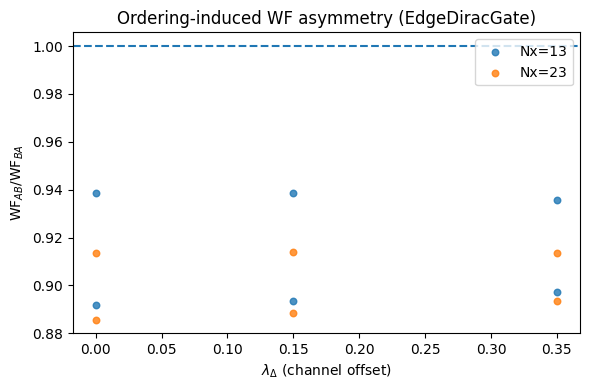

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# assume `rows` already exists from the sweep
lam_delta = np.array([r["lam_delta"] for r in rows])
WF_ratio  = np.array([r["WF_ratio"] for r in rows])
Nx_vals   = np.array([r["Nx"] for r in rows])

plt.figure(figsize=(6,4))

for Nx in np.unique(Nx_vals):
    m = Nx_vals == Nx
    plt.scatter(
        lam_delta[m],
        WF_ratio[m],
        s=22,
        label=f"Nx={Nx}",
        alpha=0.8
    )

plt.axhline(1.0, linestyle="--")
plt.xlabel(r"$\lambda_\Delta$ (channel offset)")
plt.ylabel(r"WF$_{AB}$/WF$_{BA}$")
plt.title("Ordering-induced WF asymmetry (EdgeDiracGate)")
plt.legend()
plt.tight_layout()
plt.show()

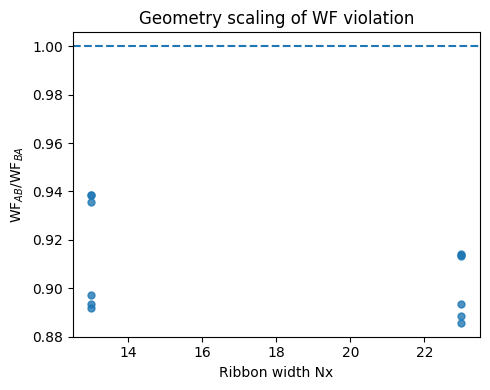

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

Nx_vals  = np.array([r["Nx"] for r in rows])
WF_ratio = np.array([r["WF_ratio"] for r in rows])

plt.figure(figsize=(5,4))
plt.scatter(Nx_vals, WF_ratio, s=25, alpha=0.8)
plt.axhline(1.0, linestyle="--")

plt.xlabel("Ribbon width Nx")
plt.ylabel(r"WF$_{AB}$/WF$_{BA}$")
plt.title("Geometry scaling of WF violation")
plt.tight_layout()
plt.show()

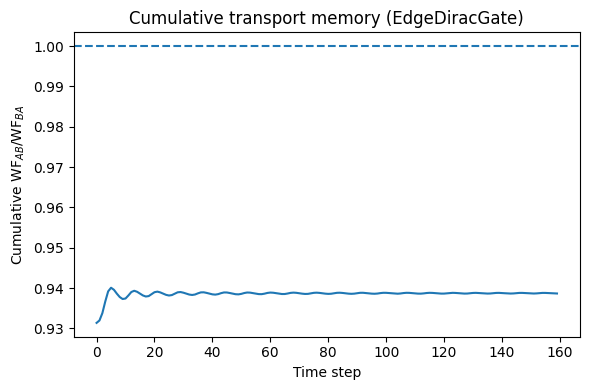

In [ ]:
best = best_ratio   # or best_excess

out = run_edgediracgate_AB_BA_timeseries(
    Nx=best["Nx"],
    Ny=best["Ny"],
    T=best["T"],
    alpha=best["alpha"],
    lam_chi=best["lam_chi"],
    lam_delta=best["lam_delta"],
    edge_beta_C=best["edge_beta_C"],
    edge_beta_H=best["edge_beta_H"],
    bias_mu=best["bias_mu"],
    bias_T=best["bias_T"],
    contact_width=best["contact_width"],
    seed=best["seed"],
)

JcAB = np.abs(out["JC_R_AB"])
JhAB = np.abs(out["JH_R_AB"])
JcBA = np.abs(out["JC_R_BA"])
JhBA = np.abs(out["JH_R_BA"])

eps = 1e-12
cum_ratio = (np.cumsum(JhAB)/(np.cumsum(JcAB)+eps)) / \
            (np.cumsum(JhBA)/(np.cumsum(JcBA)+eps))

plt.figure(figsize=(6,4))
plt.plot(cum_ratio)
plt.axhline(1.0, linestyle="--")

plt.xlabel("Time step")
plt.ylabel(r"Cumulative WF$_{AB}$/WF$_{BA}$")
plt.title("Cumulative transport memory (EdgeDiracGate)")
plt.tight_layout()
plt.show()

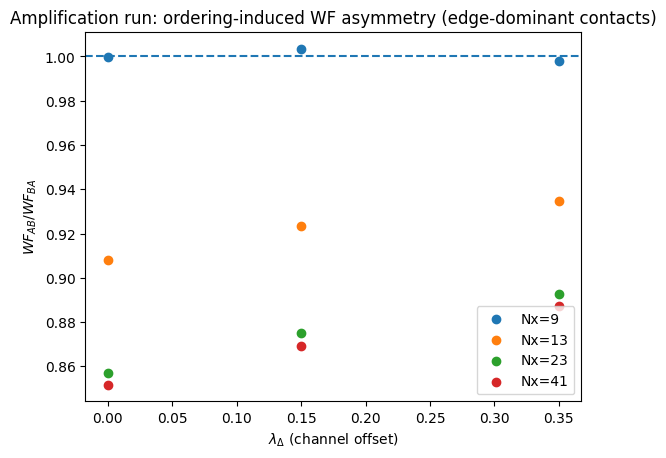

BEST (smallest WF_ratio): {'Nx': 41, 'lam_delta': 0.0, 'WF_AB': 1.019574761454571, 'WF_BA': 1.1970256109233803, 'WF_ratio': 0.851756848098867, 'WF_excess': -0.1774508494688094, 'cum_ratio_end': 0.8517568480988523}


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assumes you already defined:
# run_edgediracgate_AB_BA_timeseries(...) and wf_metrics_from_out(out)

def run_amplification_batch():
    Ny = 23
    T = 160
    alpha = 0.4
    p_thresh = 0.7
    seed = 0

    Nx_list = [9, 13, 23, 41]
    lam_delta_list = [0.0, 0.15, 0.35]

    # Edge-dominant contacts
    contact_width = 1
    contact_frac = 0.10

    # Stronger boundary drive
    bias_mu = 2.0
    bias_T  = 2.0

    # Sharp, asymmetric edge gating
    edge_beta_C = 4.0
    edge_beta_H = 1.5

    # Best-performing knobs so far
    lam_chi = 0.8
    lam_nu  = 0.0
    lam_m   = 0.0

    rows = []
    for Nx in Nx_list:
        for lam_delta in lam_delta_list:
            out = run_edgediracgate_AB_BA_timeseries(
                Nx=Nx, Ny=Ny, T=T,
                alpha=alpha, p_thresh=p_thresh,
                lam_chi=lam_chi, lam_delta=lam_delta,
                lam_nu=lam_nu, lam_m=lam_m,
                contact_width=contact_width,
                contact_frac=contact_frac,
                edge_beta_C=edge_beta_C,
                edge_beta_H=edge_beta_H,
                bias_mu=bias_mu,
                bias_T=bias_T,
                seed=seed,
            )
            m = wf_metrics_from_out(out)
            rows.append({
                "Nx": Nx,
                "lam_delta": lam_delta,
                "WF_AB": m["WF_AB"],
                "WF_BA": m["WF_BA"],
                "WF_ratio": m["WF_ratio"],
                "WF_excess": m["WF_excess"],
                "cum_ratio_end": m["cum_ratio_end"],
            })
    return rows


rows = run_amplification_batch()

# --- Plot: WF_ratio vs lambda_delta ---
Nx_values = sorted(set(r["Nx"] for r in rows))
deltas = sorted(set(r["lam_delta"] for r in rows))

for Nx in Nx_values:
    xs = []
    ys = []
    for d in deltas:
        vals = [r["WF_ratio"] for r in rows if (r["Nx"] == Nx and r["lam_delta"] == d)]
        if len(vals) == 0:
            continue
        xs.append(d)
        ys.append(float(np.mean(vals)))
    plt.scatter(xs, ys, label=f"Nx={Nx}")

plt.axhline(1.0, linestyle="--")
plt.xlabel(r"$\lambda_{\Delta}$ (channel offset)")
plt.ylabel(r"$WF_{AB}/WF_{BA}$")
plt.title("Amplification run: ordering-induced WF asymmetry (edge-dominant contacts)")
plt.legend()
plt.show()

best = sorted(rows, key=lambda r: r["WF_ratio"])[0]
print("BEST (smallest WF_ratio):", best)

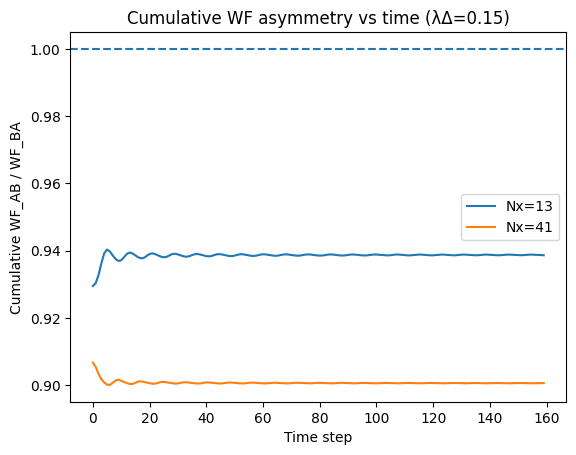

Final cumulative ratio Nx=13: 0.9386621247580782
Final cumulative ratio Nx=41: 0.9006556003922394
Pointwise WF_ratio Nx=13: 0.9386621247580794
Pointwise WF_ratio Nx=41: 0.9006556003922395


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- pick ONE lambda_delta for both widths (from your plot: 0.15 is a good mid-regime) ---
LAM_DELTA = 0.15

# --- keep the rest consistent with your sweep defaults / “amplification run” settings ---
COMMON = dict(
    Ny=23,
    T=160,
    alpha=0.4,
    p_thresh=0.7,
    lam_chi=0.8,
    lam_delta=LAM_DELTA,
    lam_nu=0.0,
    lam_m=0.0,
    edge_beta_C=2.0,
    edge_beta_H=2.5,
    bias_mu=1.0,
    bias_T=1.0,
    contact_width=2,
    contact_frac=0.35,
    seed=0,
)

def cum_ratio_curve(out):
    eps = 1e-12
    JcAB = np.abs(np.asarray(out["JC_R_AB"], float))
    JhAB = np.abs(np.asarray(out["JH_R_AB"], float))
    JcBA = np.abs(np.asarray(out["JC_R_BA"], float))
    JhBA = np.abs(np.asarray(out["JH_R_BA"], float))

    cum_WF_AB = np.cumsum(JhAB) / (np.cumsum(JcAB) + eps)
    cum_WF_BA = np.cumsum(JhBA) / (np.cumsum(JcBA) + eps)
    return cum_WF_AB / (cum_WF_BA + eps)

# --- run two widths ---
out_13 = run_edgediracgate_AB_BA_timeseries(Nx=13, **COMMON)
out_41 = run_edgediracgate_AB_BA_timeseries(Nx=41, **COMMON)

cr_13 = cum_ratio_curve(out_13)
cr_41 = cum_ratio_curve(out_41)

# --- plot ---
t = np.arange(len(cr_13))
plt.figure()
plt.plot(t, cr_13, label="Nx=13")
plt.plot(t, cr_41, label="Nx=41")
plt.axhline(1.0, linestyle="--")
plt.xlabel("Time step")
plt.ylabel("Cumulative WF_AB / WF_BA")
plt.title(f"Cumulative WF asymmetry vs time (λΔ={LAM_DELTA})")
plt.legend()
plt.show()

print("Final cumulative ratio Nx=13:", float(cr_13[-1]))
print("Final cumulative ratio Nx=41:", float(cr_41[-1]))
print("Pointwise WF_ratio Nx=13:", float(out_13["WF_ratio"]))
print("Pointwise WF_ratio Nx=41:", float(out_41["WF_ratio"]))

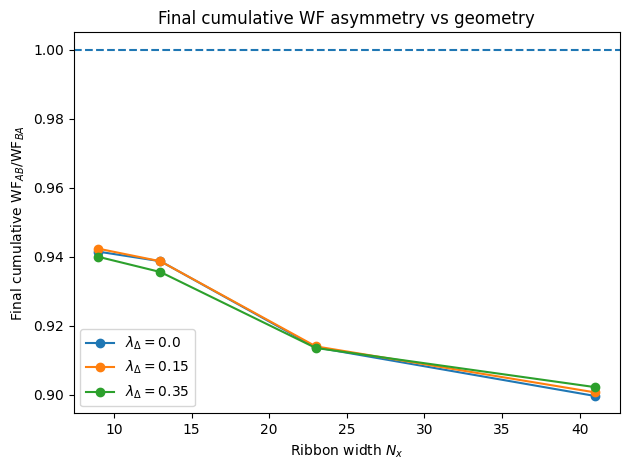

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assumes you already have:
# - run_edgediracgate_AB_BA_timeseries(...)
# - wf_metrics_from_out(out)
#
# This makes ONE final summary plot:
#   y = final cumulative WF asymmetry (cum_ratio_end)
#   x = ribbon width Nx
# with separate curves for each lambda_delta in lam_delta_list.

def final_plot_sweep(
    Nx_list=(9, 13, 23, 41),
    lam_delta_list=(0.0, 0.15, 0.35),
    Ny=23,
    T=160,
    alpha=0.4,
    p_thresh=0.7,
    lam_chi=0.8,
    lam_nu=0.0,
    lam_m=0.0,
    edge_beta_C=2.0,
    edge_beta_H=2.5,
    bias_mu=1.0,
    bias_T=1.0,
    contact_width=2,
    contact_frac=0.35,
    seed=0,
    run_fn=run_edgediracgate_AB_BA_timeseries,
):
    Nx_list = tuple(int(x) for x in Nx_list)
    lam_delta_list = tuple(float(x) for x in lam_delta_list)

    plt.figure()
    for lam_delta in lam_delta_list:
        ys = []
        for Nx in Nx_list:
            out = run_fn(
                Nx=Nx, Ny=Ny, T=T,
                alpha=alpha, p_thresh=p_thresh,
                lam_chi=lam_chi, lam_delta=lam_delta,
                lam_nu=lam_nu, lam_m=lam_m,
                edge_beta_C=edge_beta_C, edge_beta_H=edge_beta_H,
                bias_mu=bias_mu, bias_T=bias_T,
                contact_width=contact_width, contact_frac=contact_frac,
                seed=seed,
            )
            m = wf_metrics_from_out(out)
            ys.append(m["cum_ratio_end"])
        plt.plot(Nx_list, ys, marker="o", label=f"$\\lambda_\\Delta={lam_delta}$")

    plt.axhline(1.0, linestyle="--")
    plt.xlabel("Ribbon width $N_x$")
    plt.ylabel("Final cumulative $\\mathrm{WF}_{AB}/\\mathrm{WF}_{BA}$")
    plt.title("Final cumulative WF asymmetry vs geometry")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example call (edit lists as you like)
final_plot_sweep(
    Nx_list=(9, 13, 23, 41),
    lam_delta_list=(0.0, 0.15, 0.35),
)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_stepwise_wf_ratchet(out, tmax=40, label=None):
    """
    Plot instantaneous (pointwise) WF asymmetry:
    WF_AB(t) / WF_BA(t) for early times.
    """

    JC_AB = np.abs(np.asarray(out["JC_R_AB"]))
    JH_AB = np.abs(np.asarray(out["JH_R_AB"]))
    JC_BA = np.abs(np.asarray(out["JC_R_BA"]))
    JH_BA = np.abs(np.asarray(out["JH_R_BA"]))

    eps = 1e-12
    WF_AB_t = JH_AB / (JC_AB + eps)
    WF_BA_t = JH_BA / (JC_BA + eps)

    ratio_t = WF_AB_t / (WF_BA_t + eps)

    t = np.arange(len(ratio_t))[:tmax]

    plt.figure(figsize=(5,3))
    plt.plot(t, ratio_t[:tmax], lw=2, label=label)
    plt.axhline(1.0, ls="--")
    plt.xlabel("Time step")
    plt.ylabel(r"$\mathrm{WF}_{AB}(t)/\mathrm{WF}_{BA}(t)$")
    plt.title("Stepwise ordering ratchet (early time)")
    if label is not None:
        plt.legend(frameon=False)
    plt.tight_layout()
    plt.show()

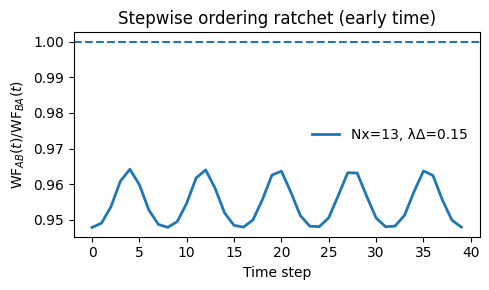

In [ ]:
out = run_edgediracgate_AB_BA_timeseries(
    Nx=13,
    Ny=23,
    lam_delta=0.15,
    lam_chi=0.8,
    seed=0
)

plot_stepwise_wf_ratchet(out, tmax=40, label="Nx=13, λΔ=0.15")

In [ ]:
plot_stepwise_wf_ratchet(out13, tmax=40, label="Nx=13")
plot_stepwise_wf_ratchet(out41, tmax=40, label="Nx=41")

NameError: name 'out13' is not defined

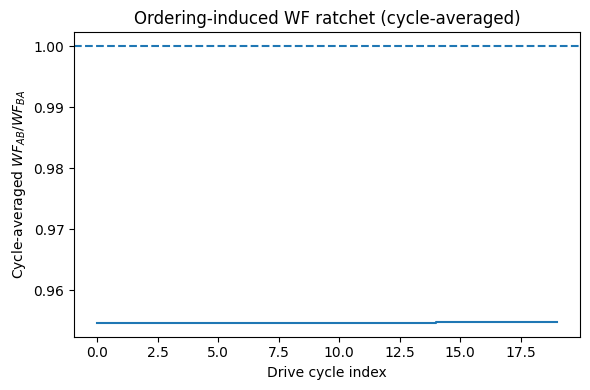

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ---- inputs ----
# Calculate ratio_t from the 'out' variable, which is available from previous executions
JC_AB = np.abs(np.asarray(out["JC_R_AB"])) # 'out' is from cell Ll2GwHOrZtiP
JH_AB = np.abs(np.asarray(out["JH_R_AB"])) # 'out' is from cell Ll2GwHOrZtiP
JC_BA = np.abs(np.asarray(out["JC_R_BA"])) # 'out' is from cell Ll2GwHOrZtiP
JH_BA = np.abs(np.asarray(out["JH_R_BA"])) # 'out' is from cell Ll2GwHOrZtiP

eps = 1e-12
WF_AB_t = JH_AB / (JC_AB + eps)
WF_BA_t = JH_BA / (JC_BA + eps)

ratio_t = WF_AB_t / (WF_BA_t + eps)

omega = 0.8                # same drive frequency as simulation
dt = 1.0                   # timestep (unitless in your model)

# ---- derive cycle length ----
cycle_len = int(round((2*np.pi) / (omega * dt)))
n_cycles = len(ratio_t) // cycle_len

# ---- cycle-averaged staircase ----
stair_vals = np.array([
    np.mean(ratio_t[i*cycle_len:(i+1)*cycle_len])
    for i in range(n_cycles)
])

# ---- plot ----
plt.figure(figsize=(6,4))
plt.step(
    np.arange(n_cycles),
    stair_vals,
    where="post"
)
plt.axhline(1.0, linestyle="--")
plt.xlabel("Drive cycle index")
plt.ylabel(r"Cycle-averaged $WF_{AB}/WF_{BA}$")
plt.title("Ordering-induced WF ratchet (cycle-averaged)")
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_cumulative_wf_staircase(out, omega=0.8, dt=1.0):
    # instantaneous pointwise WF ratio (AB/BA), using right-boundary series
    JcAB = np.abs(np.asarray(out["JC_R_AB"], float))
    JhAB = np.abs(np.asarray(out["JH_R_AB"], float))
    JcBA = np.abs(np.asarray(out["JC_R_BA"], float))
    JhBA = np.abs(np.asarray(out["JH_R_BA"], float))

    eps = 1e-12

    # cumulative WF within each protocol
    cumWF_AB = np.cumsum(JhAB) / (np.cumsum(JcAB) + eps)
    cumWF_BA = np.cumsum(JhBA) / (np.cumsum(JcBA) + eps)

    # cumulative asymmetry ratio (this is what you were already plotting smoothly)
    cum_ratio_t = cumWF_AB / (cumWF_BA + eps)

    # define drive period in steps (if your build_time_field uses cos(omega*t))
    P = int(round((2*np.pi) / (omega*dt)))
    if P < 1:
        P = 1

    # sample at cycle ends -> staircase points
    T = len(cum_ratio_t)
    ends = np.arange(P-1, T, P)
    cycle_idx = np.arange(len(ends))
    stair_vals = cum_ratio_t[ends]

    plt.figure()
    plt.step(cycle_idx, stair_vals, where="post")
    plt.axhline(1.0, linestyle="--")
    plt.xlabel("Drive cycle index")
    plt.ylabel("Cumulative WF asymmetry (cycle-sampled)")
    plt.title("Ordering-induced WF ratchet (cycle-sampled cumulative)")
    plt.tight_layout()
    plt.show()

    return dict(P=P, ends=ends, stair_vals=stair_vals)

In [ ]:
def plot_cycle_increment_wf(out, omega=0.8, dt=1.0):
    info = plot_cumulative_wf_staircase(out, omega=omega, dt=dt)
    stair_vals = info["stair_vals"]

    d = np.diff(stair_vals, prepend=stair_vals[0])

    plt.figure()
    plt.step(np.arange(len(d)), d, where="post")
    plt.axhline(0.0, linestyle="--")
    plt.xlabel("Drive cycle index")
    plt.ylabel("Per-cycle increment Δ(cum WF asymmetry)")
    plt.title("Imperfect ratchet: per-cycle increment")
    plt.tight_layout()
    plt.show()

<class 'dict'>
keys: ['JC_R_AB', 'JC_R_BA', 'JH_R_AB', 'JH_R_BA'] ...
JC_R_AB len= 160
JH_R_AB len= 160
JC_R_BA len= 160
JH_R_BA len= 160


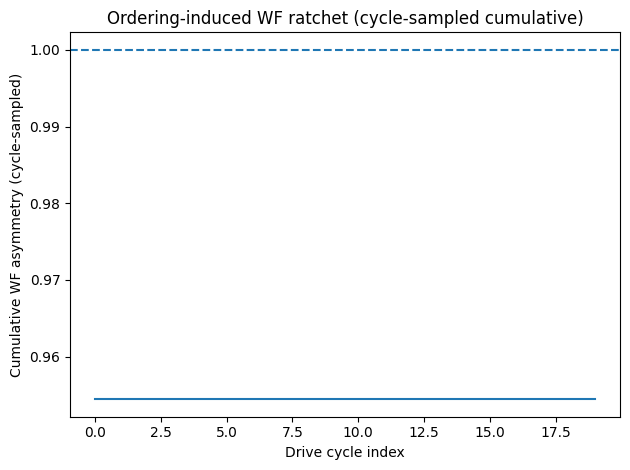

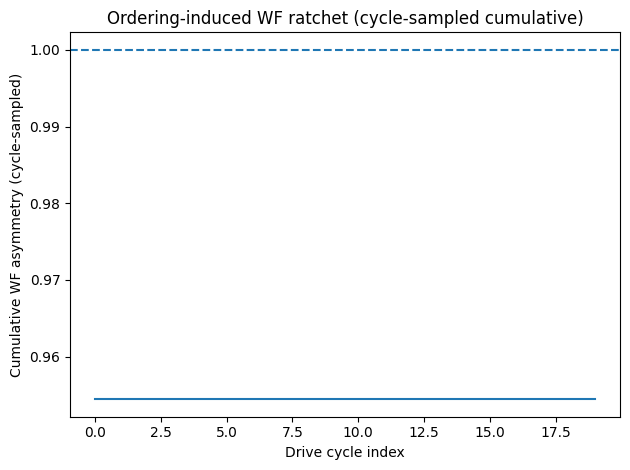

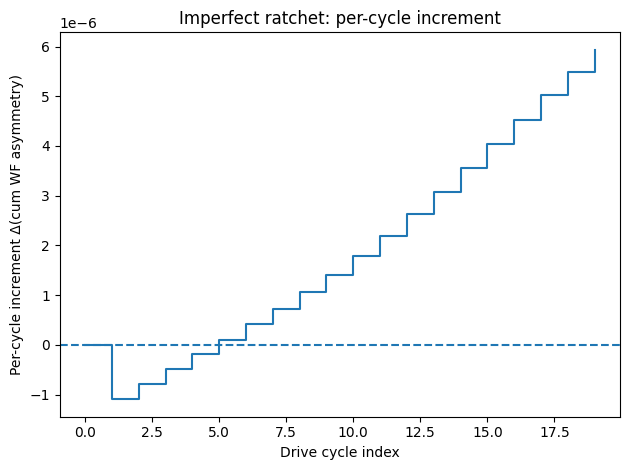

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

print(type(out))
if isinstance(out, dict):
    print("keys:", sorted([k for k in out.keys() if "JC" in k or "JH" in k])[:20], "...")
    for k in ["JC_R_AB","JH_R_AB","JC_R_BA","JH_R_BA"]:
        print(k, "len=", len(out[k]))
else:
    raise TypeError("`out` is not a dict. You probably overwrote it.")

plt.close("all")

plot_cumulative_wf_staircase(out, omega=0.8, dt=1.0)
plot_cycle_increment_wf(out, omega=0.8, dt=1.0)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def cycle_blocks(T, P):
    return [(i, min(i+P, T)) for i in range(0, T, P)]

def wf_cycle_increments(out, P=8, lam=1.0):
    JC_AB = np.asarray(out["JC_R_AB"])
    JH_AB = np.asarray(out["JH_R_AB"])
    JC_BA = np.asarray(out["JC_R_BA"])
    JH_BA = np.asarray(out["JH_R_BA"])

    T = len(JC_AB)
    blocks = cycle_blocks(T, P)

    deltas = []
    for i0, i1 in blocks:
        d = np.sum(JH_AB[i0:i1] - JH_BA[i0:i1]) \
            - lam * np.sum(JC_AB[i0:i1] - JC_BA[i0:i1])
        deltas.append(d)

    return np.array(deltas)

In [ ]:
def staircase_from_deltas(deltas):
    return np.cumsum(np.maximum(deltas, 0.0))

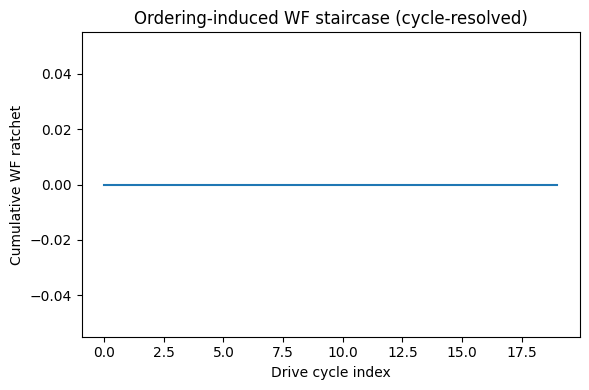

In [ ]:
deltas = wf_cycle_increments(out, P=8, lam=1.0)
stairs = staircase_from_deltas(deltas)

plt.figure(figsize=(6,4))
plt.step(range(len(stairs)), stairs, where="post")
plt.xlabel("Drive cycle index")
plt.ylabel("Cumulative WF ratchet")
plt.title("Ordering-induced WF staircase (cycle-resolved)")
plt.tight_layout()
plt.show()

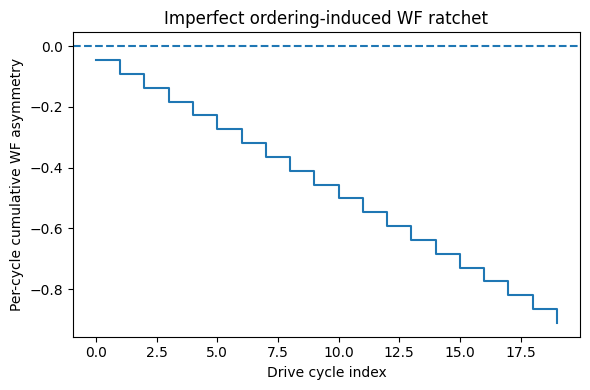

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_imperfect_wf_staircase(out, cyclesize=8):
    """
    Show stepwise cumulative WF asymmetry per drive cycle.
    """

    # instantaneous ratios
    ratio_t = (
        np.cumsum(np.abs(out["JH_R_AB"])) /
        (np.cumsum(np.abs(out["JC_R_AB"])) + 1e-12)
    ) / (
        np.cumsum(np.abs(out["JH_R_BA"])) /
        (np.cumsum(np.abs(out["JC_R_BA"])) + 1e-12)
    )

    # sample once per cycle
    ncycles = len(ratio_t) // cyclesize
    cycle_vals = np.array([
        ratio_t[(k+1)*cyclesize - 1] for k in range(ncycles)
    ])

    # per-cycle increment relative to symmetry
    delta = cycle_vals - 1.0
    cum_delta = np.cumsum(delta)

    plt.figure(figsize=(6,4))
    plt.step(range(ncycles), cum_delta, where="post")
    plt.axhline(0, linestyle="--")
    plt.xlabel("Drive cycle index")
    plt.ylabel("Per-cycle cumulative WF asymmetry")
    plt.title("Imperfect ordering-induced WF ratchet")
    plt.tight_layout()
    plt.show()

# usage
plot_imperfect_wf_staircase(out)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def wf_staircase_from_out(out, omega=0.8):
    eps = 1e-12
    JcAB = np.abs(np.asarray(out["JC_R_AB"], float))
    JhAB = np.abs(np.asarray(out["JH_R_AB"], float))
    JcBA = np.abs(np.asarray(out["JC_R_BA"], float))
    JhBA = np.abs(np.asarray(out["JH_R_BA"], float))

    # cumulative WF (time-resolved)
    WFcum_AB = np.cumsum(JhAB) / (np.cumsum(JcAB) + eps)
    WFcum_BA = np.cumsum(JhBA) / (np.cumsum(JcBA) + eps)
    ratio_t  = WFcum_AB / (WFcum_BA + eps)

    T = len(ratio_t)
    # cycle length from omega: drive factor is cos(omega*t) so period = 2π/omega
    L = max(1, int(round(2*np.pi / omega)))
    K = T // L
    if K < 2:
        raise ValueError("Not enough cycles for a staircase; increase T or check omega.")

    # sample at end of each cycle
    idx_end = (np.arange(1, K+1) * L) - 1
    Rk = ratio_t[idx_end]

    # per-cycle increment ("imperfect ratchet" diagnostic)
    dRk = np.diff(Rk, prepend=Rk[0])

    return L, Rk, dRk, ratio_t

def plot_wf_cycle_staircases(out, omega=0.8):
    L, Rk, dRk, ratio_t = wf_staircase_from_out(out, omega=omega)
    k = np.arange(len(Rk))

    # (A) cycle-sampled cumulative ratio (staircase)
    plt.figure(figsize=(7.2,4.6))
    plt.step(k, Rk, where="post")
    plt.axhline(1.0, linestyle="--")
    plt.xlabel("Drive cycle index")
    plt.ylabel(r"Cycle-sampled $WF^{cum}_{AB}/WF^{cum}_{BA}$")
    plt.title("Ordering-induced WF ratchet (cycle-sampled cumulative)")
    plt.tight_layout()
    plt.show()

    # (B) per-cycle increment (highlights imperfections)
    plt.figure(figsize=(7.2,4.6))
    plt.step(k, dRk, where="post")
    plt.axhline(0.0, linestyle="--")
    plt.xlabel("Drive cycle index")
    plt.ylabel(r"Per-cycle increment $\Delta(WF^{cum}_{AB}/WF^{cum}_{BA})$")
    plt.title("Imperfect ratchet diagnostic: per-cycle increment")
    plt.tight_layout()
    plt.show()

    # (C) sanity: time-resolved cumulative ratio
    plt.figure(figsize=(7.2,4.6))
    plt.plot(ratio_t)
    plt.axhline(1.0, linestyle="--")
    plt.xlabel("Time step")
    plt.ylabel(r"$WF^{cum}_{AB}(t)/WF^{cum}_{BA}(t)$")
    plt.title("Cumulative WF asymmetry vs time")
    plt.tight_layout()
    plt.show()

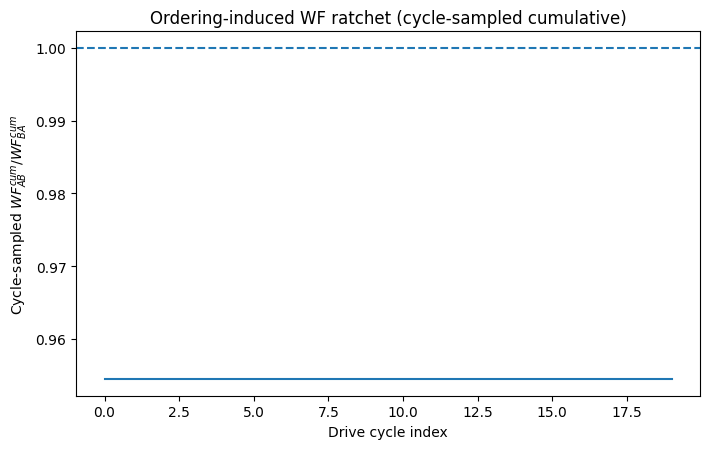

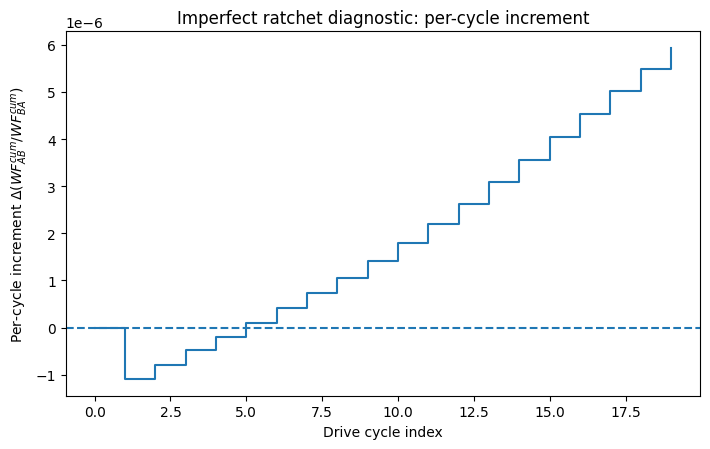

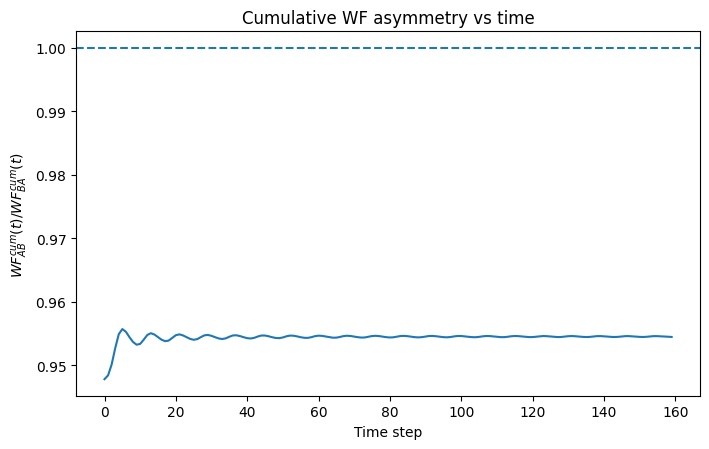

In [ ]:
plot_wf_cycle_staircases(out, omega=0.8)

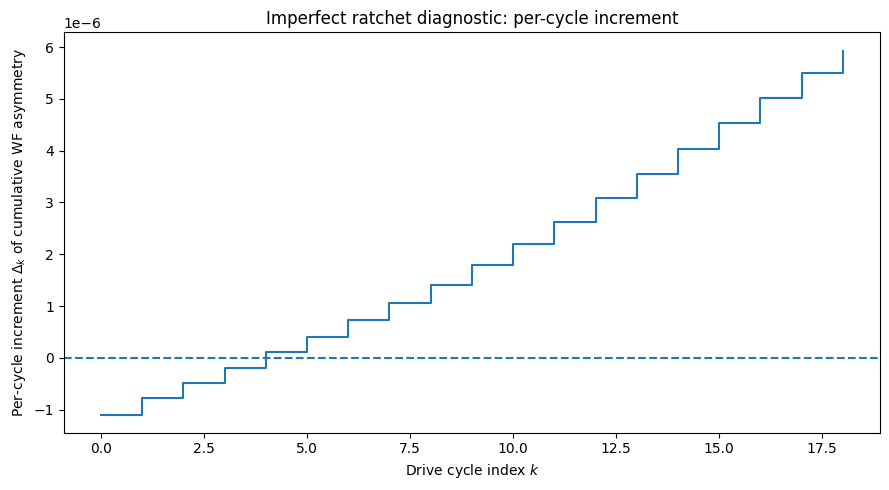

{'steps_per_cycle': 8,
 'cycle_end_idx': array([  7,  15,  23,  31,  39,  47,  55,  63,  71,  79,  87,  95, 103,
        111, 119, 127, 135, 143, 151, 159]),
 'A_cycle': array([0.95445367, 0.95445257, 0.95445179, 0.9544513 , 0.95445111,
        0.95445122, 0.95445163, 0.95445235, 0.95445341, 0.95445482,
        0.95445661, 0.95445881, 0.95446144, 0.95446452, 0.95446807,
        0.95447211, 0.95447664, 0.95448166, 0.95448715, 0.95449309]),
 'dA': array([-1.09494950e-06, -7.85149616e-07, -4.85495628e-07, -1.90314691e-07,
         1.06129845e-07,  4.09507931e-07,  7.25248260e-07,  1.05828067e-06,
         1.41270957e-06,  1.79147290e-06,  2.19604600e-06,  2.62621999e-06,
         3.07994734e-06,  3.55322997e-06,  4.04004240e-06,  4.53231995e-06,
         5.02007331e-06,  5.49169013e-06,  5.93444761e-06])}

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def _get_series(out, key):
    if key in out:
        return np.asarray(out[key], float)
    if "series" in out and key in out["series"]:
        return np.asarray(out["series"][key], float)
    raise KeyError(f"Missing '{key}'. Available keys: {list(out.keys())}")

def plot_fig11c_imperfect_ratchet(out, omega=0.8, n_cycles=20, title=None):
    """
    Fig 11c: 'imperfect ratchet' diagnostic.
    Plots per-cycle increment of the cumulative WF-asymmetry:
        Δ_k = A_{k+1} - A_k
    where A_k is the cycle-sampled cumulative ratio:
        A_k = (sum_0^{t_k} |JH_AB| / sum_0^{t_k} |JC_AB|)
            / (sum_0^{t_k} |JH_BA| / sum_0^{t_k} |JC_BA|)
    Using RIGHT boundary series by default: JC_R_*, JH_R_*.
    """

    # --- pull time-series ---
    JcAB = np.abs(_get_series(out, "JC_R_AB"))
    JhAB = np.abs(_get_series(out, "JH_R_AB"))
    JcBA = np.abs(_get_series(out, "JC_R_BA"))
    JhBA = np.abs(_get_series(out, "JH_R_BA"))

    T = len(JcAB)
    eps = 1e-12

    # --- cumulative WF ratios (time-resolved) ---
    cum_WF_AB = np.cumsum(JhAB) / (np.cumsum(JcAB) + eps)
    cum_WF_BA = np.cumsum(JhBA) / (np.cumsum(JcBA) + eps)
    cum_ratio = cum_WF_AB / (cum_WF_BA + eps)

    # --- define cycle boundaries (use omega) ---
    # one drive cycle is 2π/omega time steps
    steps_per_cycle = max(1, int(np.round((2.0 * np.pi) / float(omega))))
    k_max = min(int(n_cycles), max(1, T // steps_per_cycle) - 1)

    # sample at END of each cycle
    cycle_end_idx = np.array([(k + 1) * steps_per_cycle - 1 for k in range(k_max + 1)])
    cycle_end_idx = np.clip(cycle_end_idx, 0, T - 1)

    A = cum_ratio[cycle_end_idx]              # cycle-sampled cumulative ratio
    dA = np.diff(A)                           # per-cycle increment (imperfect ratchet)
    k = np.arange(len(dA))                    # cycle index for increments

    # --- plot as staircase (what you want visually) ---
    plt.figure(figsize=(9, 5))
    plt.step(k, dA, where="post")
    plt.axhline(0.0, linestyle="--")
    plt.xlabel("Drive cycle index $k$")
    plt.ylabel(r"Per-cycle increment $\Delta_k$ of cumulative WF asymmetry")
    plt.title(title or "Imperfect ratchet diagnostic: per-cycle increment")
    plt.tight_layout()
    plt.show()

    # return numbers in case you want to print them / caption them
    return {
        "steps_per_cycle": steps_per_cycle,
        "cycle_end_idx": cycle_end_idx,
        "A_cycle": A,
        "dA": dA
    }

# --- usage ---
# out = run_edgediracgate_AB_BA_timeseries(...your params...)
plot_fig11c_imperfect_ratchet(out, omega=0.8, n_cycles=20)


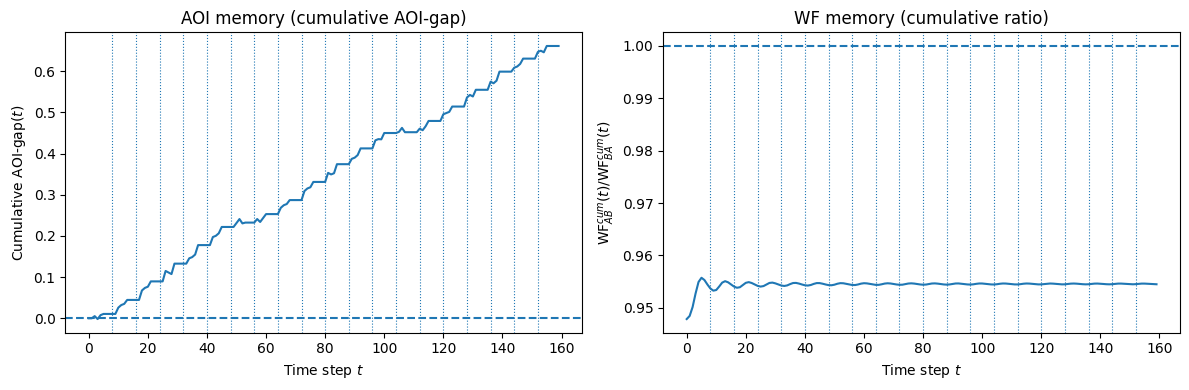

{'steps_per_cycle': 8,
 'AOI_gap_t': array([ 0.        ,  0.        ,  0.00528846, -0.00186037,  0.00771321,
         0.01059783,  0.01059783,  0.01059783,  0.01059783,  0.01059783,
         0.02591973,  0.03214883,  0.03503344,  0.04460702,  0.04460702,
         0.04460702,  0.04460702,  0.04460702,  0.06755853,  0.07378763,
         0.07667224,  0.0895903 ,  0.0895903 ,  0.0895903 ,  0.0895903 ,
         0.0895903 ,  0.11494565,  0.1111413 ,  0.10733696,  0.13269231,
         0.13269231,  0.13269231,  0.13269231,  0.13269231,  0.14561037,
         0.14849498,  0.15472408,  0.17767559,  0.17767559,  0.17767559,
         0.17767559,  0.17767559,  0.19728261,  0.20016722,  0.20639632,
         0.22171823,  0.22171823,  0.22171823,  0.22171823,  0.22171823,
         0.23129181,  0.24086538,  0.23037207,  0.23231605,  0.23231605,
         0.23231605,  0.23231605,  0.240949  ,  0.23380017,  0.24337375,
         0.25294732,  0.25294732,  0.25294732,  0.25294732,  0.25294732,
         0.2682

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def _get_series(out, key):
    if key in out:
        return np.asarray(out[key], float)
    if "series" in out and key in out["series"]:
        return np.asarray(out["series"][key], float)
    raise KeyError(f"Missing '{key}'. Available keys: {list(out.keys())}")

def plot_time_aligned_aoi_vs_wf(out, omega=0.8, show_cycle_lines=True, title=None):
    """
    Side-by-side, time-step aligned:
      Left : cumulative AOI-gap(t) = AOI_AB(t) - AOI_BA(t) using rC/rH series
      Right: cumulative WF asymmetry ratio(t) using boundary flux series
    """

    # --- AOI-gap(t) from reach fractions ---
    rC_AB = _get_series(out, "rC_AB")
    rH_AB = _get_series(out, "rH_AB")
    rC_BA = _get_series(out, "rC_BA")
    rH_BA = _get_series(out, "rH_BA")

    diff_AB = rC_AB - rH_AB
    diff_BA = rC_BA - rH_BA

    # "positive area above mean" increment per step (your AOI definition)
    inc_AB = np.maximum(diff_AB - np.mean(diff_AB), 0.0)
    inc_BA = np.maximum(diff_BA - np.mean(diff_BA), 0.0)

    AOI_AB_t = np.cumsum(inc_AB)
    AOI_BA_t = np.cumsum(inc_BA)
    AOI_gap_t = AOI_AB_t - AOI_BA_t

    # --- WF cumulative ratio(t) from boundary currents ---
    JcAB = np.abs(_get_series(out, "JC_R_AB"))
    JhAB = np.abs(_get_series(out, "JH_R_AB"))
    JcBA = np.abs(_get_series(out, "JC_R_BA"))
    JhBA = np.abs(_get_series(out, "JH_R_BA"))

    eps = 1e-12
    cum_WF_AB = np.cumsum(JhAB) / (np.cumsum(JcAB) + eps)
    cum_WF_BA = np.cumsum(JhBA) / (np.cumsum(JcBA) + eps)
    WF_ratio_t = cum_WF_AB / (cum_WF_BA + eps)

    # --- shared time axis ---
    T = min(len(AOI_gap_t), len(WF_ratio_t))
    t = np.arange(T)

    AOI_gap_t = AOI_gap_t[:T]
    WF_ratio_t = WF_ratio_t[:T]

    # --- cycle markers ---
    steps_per_cycle = max(1, int(np.round((2.0 * np.pi) / float(omega))))
    cycle_edges = np.arange(steps_per_cycle, T, steps_per_cycle)

    # --- plot ---
    fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

    ax[0].plot(t, AOI_gap_t)
    ax[0].axhline(0.0, linestyle="--")
    ax[0].set_xlabel("Time step $t$")
    ax[0].set_ylabel("Cumulative AOI-gap$(t)$")
    ax[0].set_title("AOI memory (cumulative AOI-gap)")

    ax[1].plot(t, WF_ratio_t)
    ax[1].axhline(1.0, linestyle="--")
    ax[1].set_xlabel("Time step $t$")
    ax[1].set_ylabel(r"$\mathrm{WF}_{AB}^{cum}(t)/\mathrm{WF}_{BA}^{cum}(t)$")
    ax[1].set_title("WF memory (cumulative ratio)")

    if show_cycle_lines:
        for x in cycle_edges:
            ax[0].axvline(x, linestyle=":", linewidth=0.8)
            ax[1].axvline(x, linestyle=":", linewidth=0.8)

    if title:
        fig.suptitle(title)

    plt.tight_layout()
    plt.show()

    return {
        "steps_per_cycle": steps_per_cycle,
        "AOI_gap_t": AOI_gap_t,
        "WF_ratio_t": WF_ratio_t
    }

# usage:
# out = run_edgediracgate_AB_BA_timeseries(...same params...)
plot_time_aligned_aoi_vs_wf(out, omega=0.8, show_cycle_lines=True)

In [ ]:
# --- WF cumulative ratio(t) from boundary currents ---
JcAB = np.abs(_get_series(out, "JC_R_AB"))
JhAB = np.abs(_get_series(out, "JH_R_AB"))
JcBA = np.abs(_get_series(out, "JC_R_BA"))
JhBA = np.abs(_get_series(out, "JH_R_BA"))

eps = 1e-12
cum_WF_AB = np.cumsum(JhAB) / (np.cumsum(JcAB) + eps)
cum_WF_BA = np.cumsum(JhBA) / (np.cumsum(JcBA) + eps)
WF_ratio_t = cum_WF_AB / (cum_WF_BA + eps)

T = len(WF_ratio_t)
t = np.arange(T)

# --- define cycle boundaries ---
steps_per_cycle = max(1, int(np.round((2.0 * np.pi) / float(omega))))
edges = np.arange(steps_per_cycle - 1, T, steps_per_cycle)  # last index of each cycle

# --- cycle-sampled staircase (piecewise constant over each cycle) ---
WF_cycle = WF_ratio_t[edges]                  # one value per cycle (end-of-cycle)
k = np.arange(len(WF_cycle))                  # cycle index

# expand back to time steps as a staircase
WF_step = np.zeros(T)
for ci, end_idx in enumerate(edges):
    start_idx = 0 if ci == 0 else edges[ci-1] + 1
    WF_step[start_idx:end_idx+1] = WF_cycle[ci]

# --- plot the staircase on the WF axis ---
ax[1].plot(t, WF_step, drawstyle="steps-post")
ax[1].axhline(1.0, linestyle="--")
ax[1].set_xlabel("Time step $t$")
ax[1].set_ylabel(r"$\mathrm{WF}_{AB}^{cum}/\mathrm{WF}_{BA}^{cum}$ (cycle-held)")
ax[1].set_title("WF memory (cycle-resolved staircase)")

NameError: name 'ax' is not defined

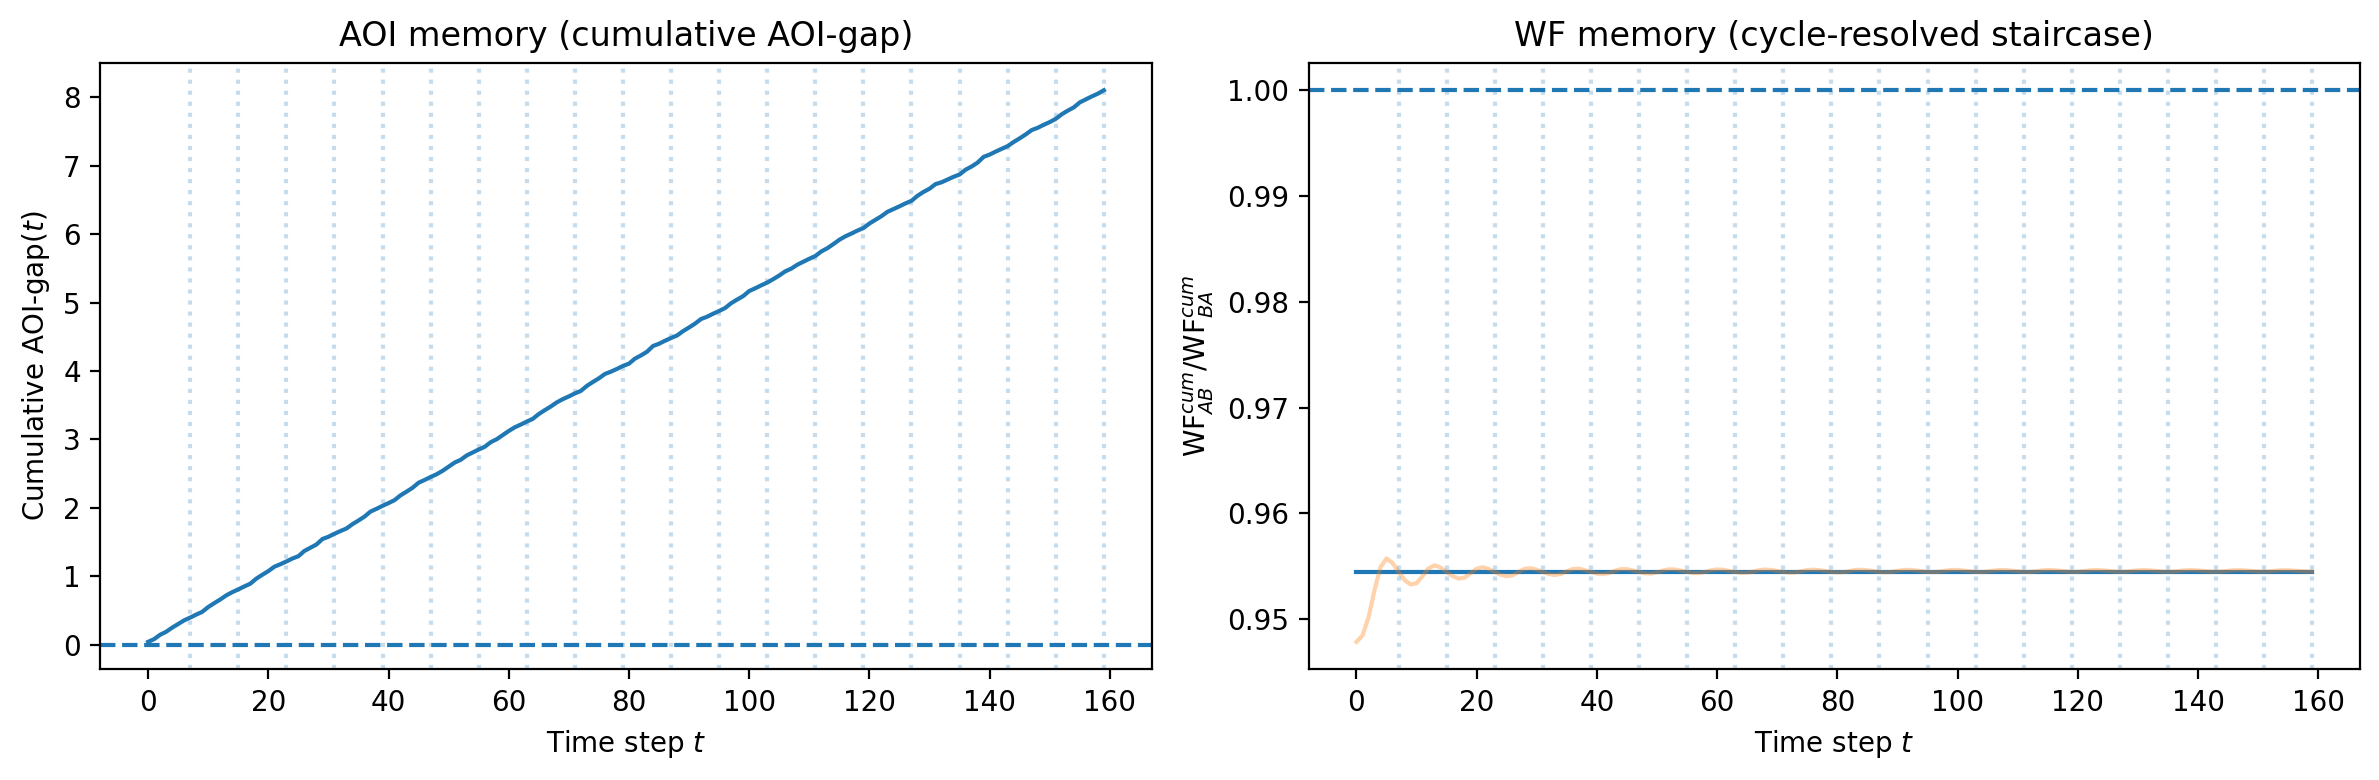

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# expects: out, omega, and _get_series(...) already defined in your notebook

# ---------- AOI series ----------
rC_AB = np.asarray(_get_series(out, "rC_AB"), float)
rH_AB = np.asarray(_get_series(out, "rH_AB"), float)
rC_BA = np.asarray(_get_series(out, "rC_BA"), float)
rH_BA = np.asarray(_get_series(out, "rH_BA"), float)

aoi_gap_t = (rC_AB - rH_AB) - (rC_BA - rH_BA)
aoi_gap_cum = np.cumsum(aoi_gap_t)

# ---------- WF series ----------
JcAB = np.abs(np.asarray(_get_series(out, "JC_R_AB"), float))
JhAB = np.abs(np.asarray(_get_series(out, "JH_R_AB"), float))
JcBA = np.abs(np.asarray(_get_series(out, "JC_R_BA"), float))
JhBA = np.abs(np.asarray(_get_series(out, "JH_R_BA"), float))

eps = 1e-12
cum_WF_AB = np.cumsum(JhAB) / (np.cumsum(JcAB) + eps)
cum_WF_BA = np.cumsum(JhBA) / (np.cumsum(JcBA) + eps)
WF_ratio_t = cum_WF_AB / (cum_WF_BA + eps)

T = len(WF_ratio_t)
t = np.arange(T)

# cycle boundaries
steps_per_cycle = max(1, int(np.round((2.0 * np.pi) / float(omega))))
edges = np.arange(steps_per_cycle - 1, T, steps_per_cycle)  # end-of-cycle indices

# cycle-sampled staircase (hold end-of-cycle value across that cycle)
WF_cycle = WF_ratio_t[edges]
WF_step = np.zeros(T)
for ci, end_idx in enumerate(edges):
    start_idx = 0 if ci == 0 else edges[ci - 1] + 1
    WF_step[start_idx:end_idx + 1] = WF_cycle[ci]

# ---------- Plot ----------
fig, ax = plt.subplots(1, 2, figsize=(12, 4), dpi=200)

# AOI: cumulative + cycle markers
ax[0].plot(t, aoi_gap_cum)
ax[0].axhline(0.0, linestyle="--")
for e in edges:
    ax[0].axvline(e, linestyle=":", alpha=0.25)
ax[0].set_xlabel("Time step $t$")
ax[0].set_ylabel("Cumulative AOI-gap$(t)$")
ax[0].set_title("AOI memory (cumulative AOI-gap)")

# WF: staircase + optional faint intra-cycle wiggle
ax[1].plot(t, WF_step, drawstyle="steps-post")
ax[1].plot(t, WF_ratio_t, alpha=0.35)  # comment out if you want staircase only
ax[1].axhline(1.0, linestyle="--")
for e in edges:
    ax[1].axvline(e, linestyle=":", alpha=0.25)
ax[1].set_xlabel("Time step $t$")
ax[1].set_ylabel(r"$\mathrm{WF}_{AB}^{cum}/\mathrm{WF}_{BA}^{cum}$")
ax[1].set_title("WF memory (cycle-resolved staircase)")

plt.tight_layout()
plt.show()

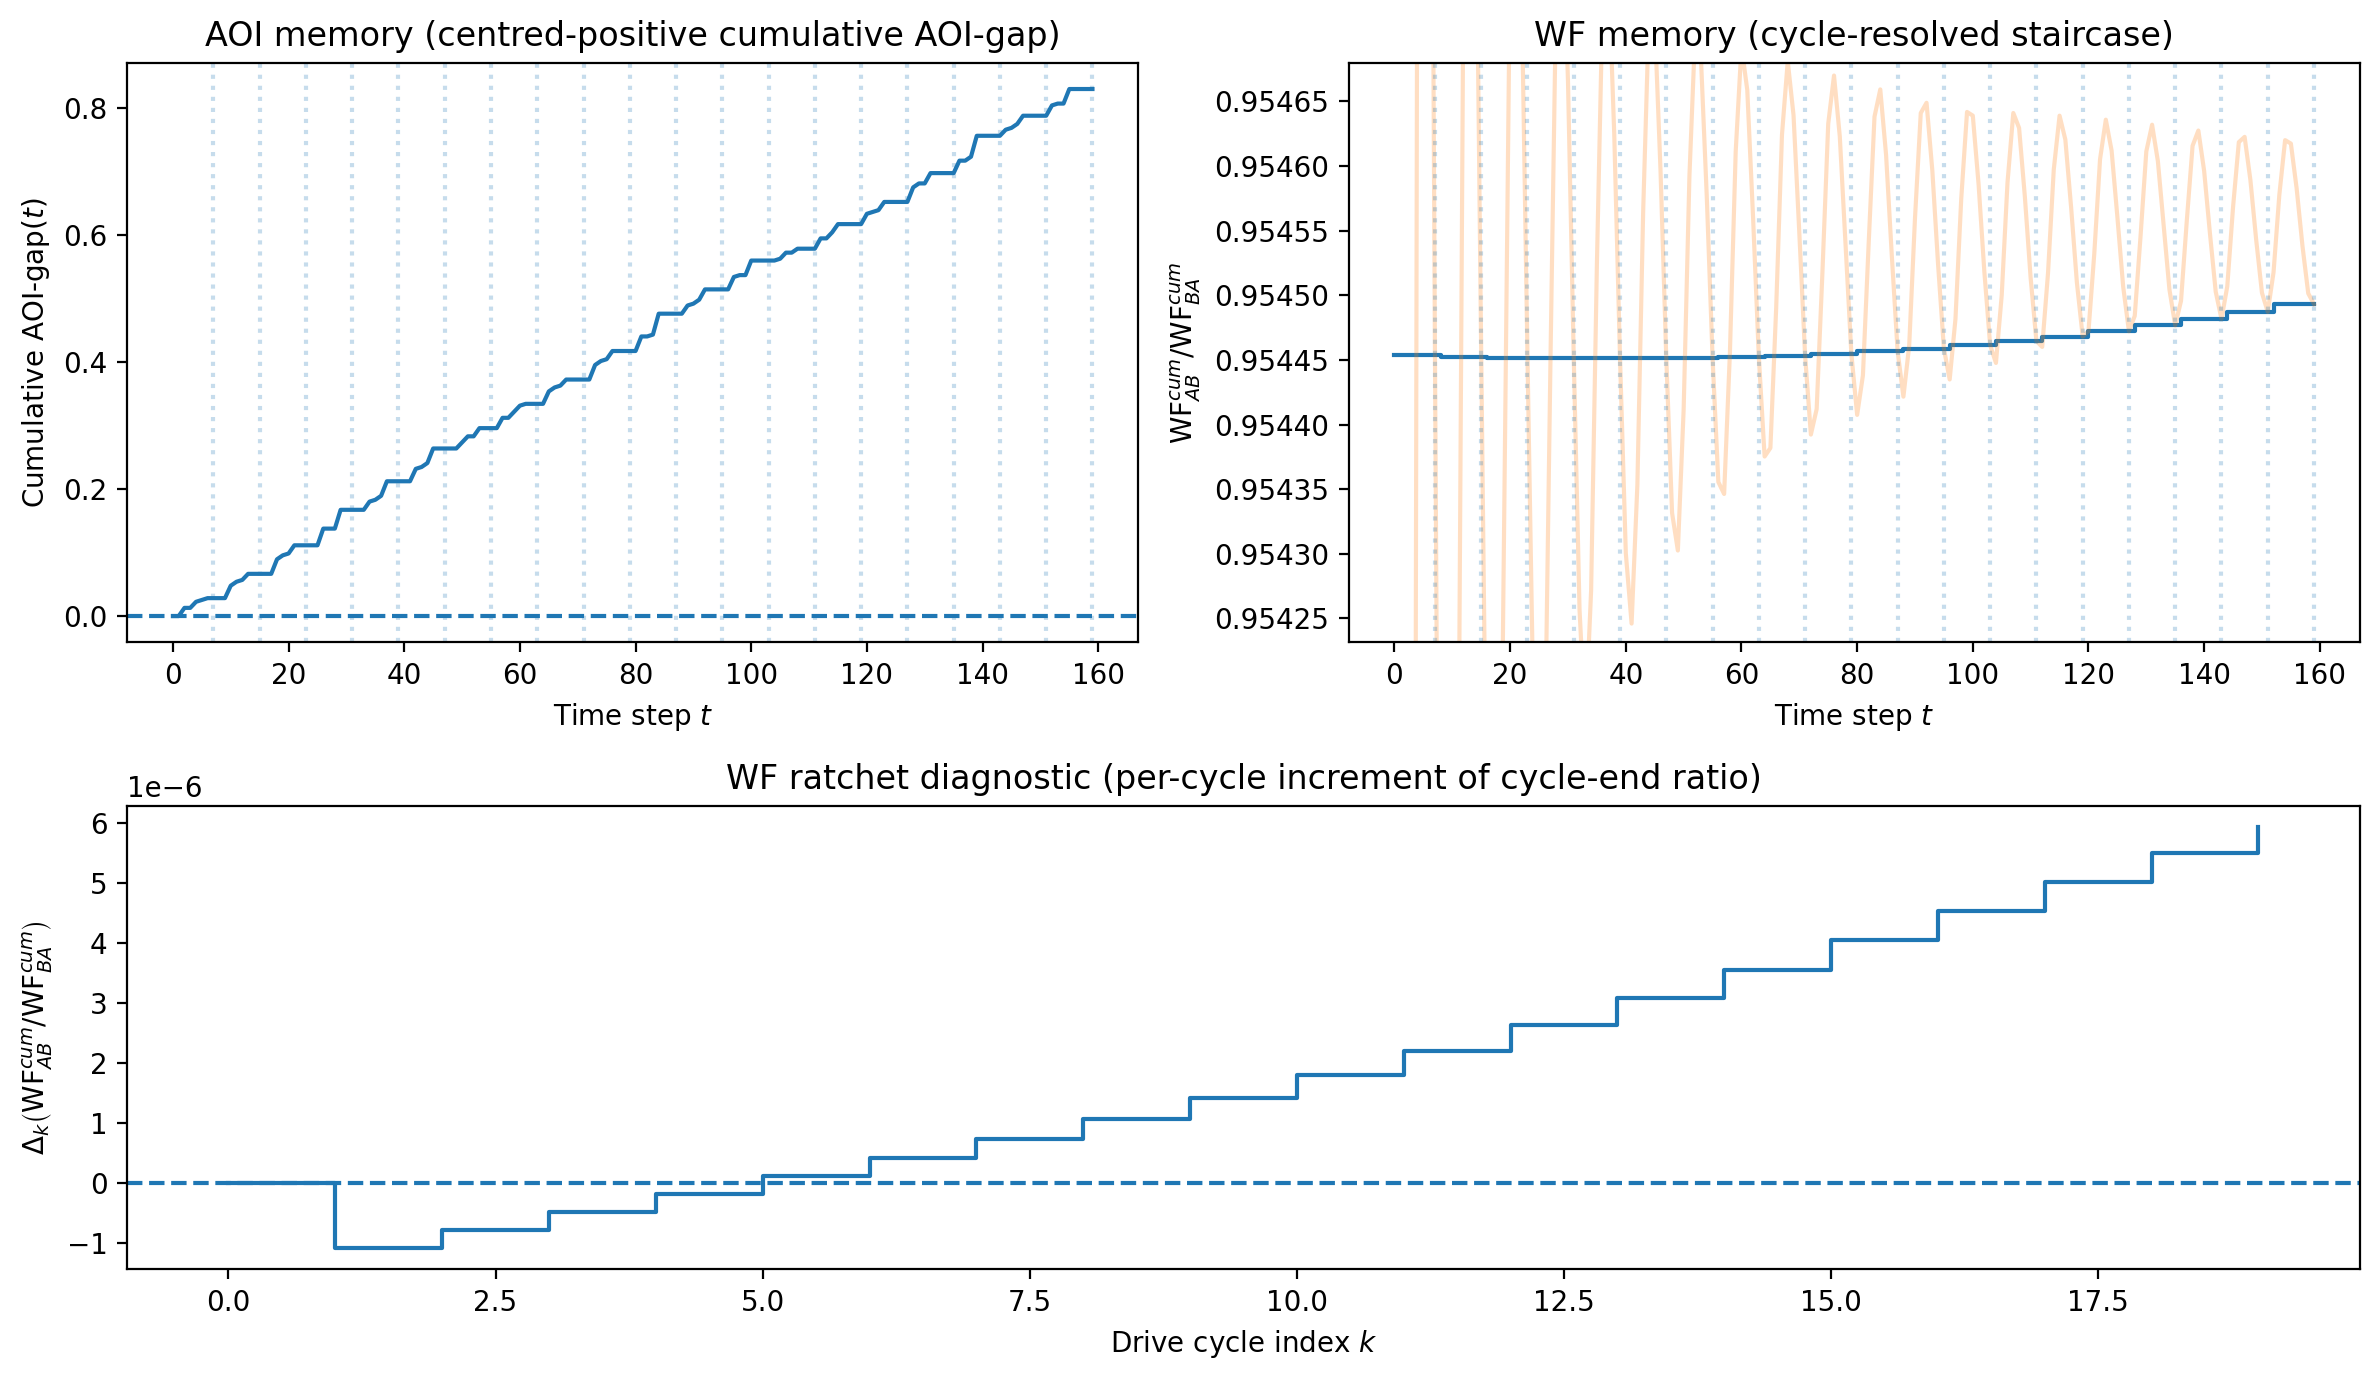

steps_per_cycle = 8 num_cycles = 20
WF_cycle_end range = 0.9544511098136219 to 0.9544930871795068
AOI_cum_end = 0.830685618729097


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# assumes: out, omega, and _get_series(out, key) exist

eps = 1e-12

# -------------------------
# Pull series
# -------------------------
rC_AB = np.asarray(_get_series(out, "rC_AB"), float)
rH_AB = np.asarray(_get_series(out, "rH_AB"), float)
rC_BA = np.asarray(_get_series(out, "rC_BA"), float)
rH_BA = np.asarray(_get_series(out, "rH_BA"), float)

JcAB = np.abs(np.asarray(_get_series(out, "JC_R_AB"), float))
JhAB = np.abs(np.asarray(_get_series(out, "JH_R_AB"), float))
JcBA = np.abs(np.asarray(_get_series(out, "JC_R_BA"), float))
JhBA = np.abs(np.asarray(_get_series(out, "JH_R_BA"), float))

T = len(JcAB)
t = np.arange(T)

# -------------------------
# AOI-gap(t): centred-positive accumulator (the one that doesn't "blow up")
# -------------------------
aoi_gap_t = (rC_AB - rH_AB) - (rC_BA - rH_BA)
aoi_gap_pos = np.maximum(aoi_gap_t - np.mean(aoi_gap_t), 0.0)
aoi_gap_cum = np.cumsum(aoi_gap_pos)

# -------------------------
# WF cumulative ratio (time-resolved)
# -------------------------
cum_WF_AB = np.cumsum(JhAB) / (np.cumsum(JcAB) + eps)
cum_WF_BA = np.cumsum(JhBA) / (np.cumsum(JcBA) + eps)
WF_ratio_t = cum_WF_AB / (cum_WF_BA + eps)

# -------------------------
# Cycle definition + staircase sampled at cycle ends
# -------------------------
steps_per_cycle = max(1, int(np.round((2.0 * np.pi) / float(omega))))
cycle_end = np.arange(steps_per_cycle - 1, T, steps_per_cycle)

WF_cycle_end = WF_ratio_t[cycle_end]                    # one value per cycle
k = np.arange(len(WF_cycle_end))                        # cycle index

# staircase in time: hold each cycle-end value across the whole cycle
WF_step_t = np.empty(T)
start = 0
for ci, end in enumerate(cycle_end):
    WF_step_t[start:end + 1] = WF_cycle_end[ci]
    start = end + 1
if start < T:
    WF_step_t[start:] = WF_cycle_end[-1]

# per-cycle increment diagnostic (difference of cycle-end values)
dWF_cycle = np.diff(np.r_[WF_cycle_end[0], WF_cycle_end])

# -------------------------
# Plot
# -------------------------
fig = plt.figure(figsize=(12, 7), dpi=200)
gs = fig.add_gridspec(2, 2, height_ratios=[1.0, 0.8])

ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[1, :])

# AOI memory (centred-positive cumulative)
ax0.plot(t, aoi_gap_cum)
ax0.axhline(0.0, linestyle="--")
for e in cycle_end:
    ax0.axvline(e, linestyle=":", alpha=0.25)
ax0.set_title("AOI memory (centred-positive cumulative AOI-gap)")
ax0.set_xlabel("Time step $t$")
ax0.set_ylabel("Cumulative AOI-gap$(t)$")

# WF memory staircase (cycle-resolved)
ax1.plot(t, WF_step_t, drawstyle="steps-post")
ax1.plot(t, WF_ratio_t, alpha=0.25)  # faint intra-cycle wiggle; comment out if you want pure stairs
ax1.axhline(1.0, linestyle="--")
for e in cycle_end:
    ax1.axvline(e, linestyle=":", alpha=0.25)

# auto-zoom so tiny steps are visible
m = float(np.median(WF_cycle_end))
span = float(np.max(np.abs(WF_cycle_end - m)) + 1e-9)
ax1.set_ylim(m - 6*span, m + 6*span)

ax1.set_title("WF memory (cycle-resolved staircase)")
ax1.set_xlabel("Time step $t$")
ax1.set_ylabel(r"$\mathrm{WF}^{cum}_{AB}/\mathrm{WF}^{cum}_{BA}$")

# Per-cycle increment (ratchet diagnostic)
ax2.plot(k, dWF_cycle, drawstyle="steps-post")
ax2.axhline(0.0, linestyle="--")
ax2.set_title("WF ratchet diagnostic (per-cycle increment of cycle-end ratio)")
ax2.set_xlabel("Drive cycle index $k$")
ax2.set_ylabel(r"$\Delta_k\left(\mathrm{WF}^{cum}_{AB}/\mathrm{WF}^{cum}_{BA}\right)$")

plt.tight_layout()
plt.show()

print("steps_per_cycle =", steps_per_cycle, "num_cycles =", len(WF_cycle_end))
print("WF_cycle_end range =", float(WF_cycle_end.min()), "to", float(WF_cycle_end.max()))
print("AOI_cum_end =", float(aoi_gap_cum[-1]))